In [1]:
import gurobi as gb
from gurobipy import GRB

import networkx as nx
import numpy as np
import math

# Network model

In [2]:
def init_ring(n):
    """Initializes a graph in ring structure with n nodes
    
    Args: 
        n (int): number of nodes
    
    Returns:
        G (networkx.classes.graph.Graph): Graph in ring structure
    """
    G = nx.Graph()
    for i in range(n): G.add_node(i)
    for i in range(n-1): G.add_edge(i,i+1)
    G.add_edge(0,n-1)
    pos = nx.circular_layout(G)
    nx.draw_networkx(G,pos=pos,with_labels=True)
    return(G)

def init_uniformDemand_matrix(G):
    """Returns a demand matrix, where each peer pair has the same demand in %
    
    Args:
        G (networkx.classes.graph.Graph): 
        
    Returns:
        D (numpy.ndarray): matrix with unformly distributed demands for all node pairs
    
    """
    nodesList = G.nodes
    uniformTraffic = round(1/(len(nodesList)*(len(nodesList)-1)),8)
    D = np.full((len(nodesList),len(nodesList)),uniformTraffic)
    for i in range(len(nodesList)):
        D[i][i] = 0
    return D

def calc_cost(G,D):
    """Returns the cost of traffic on a graph
    
    Args:
        G (networkx.classes.graph.Graph): network graph
        D (numpy.ndarray): Demand Graph
    Returns:
        cost (numpy.ndarray): cost of total traffic between nodes of G
    """
    nodesList = list(G.nodes)
    allShortestPath = nx.shortest_path(G)
    allShortestPathCost = [(len(allShortestPath[i][j])-1)*D[i][j]
                             for i in nodesList for j in nodesList if i!=j]
    return sum(allShortestPathCost)

def SP_edgeList(G,s,t):
    """
    Returns: Shortest Path as list of edge pairs
    """
    allShortestPath = nx.shortest_path(G)
    pathEdgeList = []
    for i in range(len(allShortestPath[s][t])-1):
        pathEdgeList.append((i,allShortestPath[s][t][i+1]))
    return pathEdgeList

def complete_node_pair_list(G):
    """
    Returns: list of all possible node pairings
    """
    nodePairList =[]
    nodes = G.nodes
    for i in G.nodes:
        nodePairList.append([])
        for j in G.nodes:
            nodePairList[i].append((i,j))
    return nodePairList

# Gurobi Optimization
Implementation of the LP, which Arash proposed on 6. June 2022

In [3]:
opt_mod = gb.Model(name="linear programm")

Set parameter Username
Academic license - for non-commercial use only - expires 2023-06-02


## Setup Network Parameters

8
[0, 1, 2, 3, 4, 5, 6, 7]
[[(0, 0), (0, 1), (0, 2), (0, 3), (0, 4), (0, 5), (0, 6), (0, 7)], [(1, 0), (1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7)], [(2, 0), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7)], [(3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7)], [(4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7)], [(5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7)], [(6, 0), (6, 1), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6), (6, 7)], [(7, 0), (7, 1), (7, 2), (7, 3), (7, 4), (7, 5), (7, 6), (7, 7)]]


/tmp/ipykernel_30422/459961200.py:5: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G)


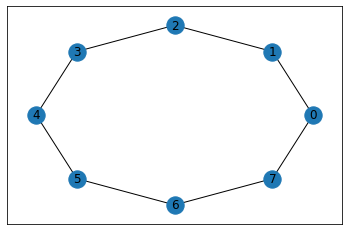

In [4]:
k = 3
G = init_ring(2**k)
D = init_uniformDemand_matrix(G)
adjM = np.full((2**k,2**k),0)
A = nx.adjacency_matrix(G)
print(len(G.nodes))
allShortestPath = nx.shortest_path(G)
print(list(G.nodes))
nodesPairList = gb.tuplelist(complete_node_pair_list(G))
print(nodesPairList)

## Setting variables

In [5]:
"""n = len(G.nodes)
edges = gb.tuplelist(G.edges)
nodesPairList = gb.tuplelist(complete_node_pair_list(G))

maxAllowedEperNode = math.log(2**k,2) + 2
allShortestPath = nx.shortest_path(G)

# Edges/Links gb.var definition and constraints
e = []
distance = []
x = []
for i in G.nodes:
    e.append([])
    distance.append([])
    x.append([])
    for j in G.nodes:
        e[i].append(opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.BINARY))
        distance[i].append(opt_mod.addVar(name=f"dist_{i,j}", vtype=GRB.INTEGER, lb=0, ub=GRB.INFINITY))
        x[i].append([])
        for u in G.nodes:
            x[i][j].append([])
            for v in G.nodes:
                x[i][j][u].append(opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype=GRB.BINARY))
                #opt_mod.addConstr(x[i][j][u][v] <= e[u][v], name="c-dist<e")
    opt_mod.addConstr(e[i][(i+1) % len(G.nodes)] == 1.0, name="c-ring")
    opt_mod.addConstr(distance[i][j] >= e[i][j], name="c-dist")
    opt_mod.addConstr(x[i][j][u][v] == (1 if (u,v) in SP_edgeList(G,i,j) else 0), name="c-distEdgeP")
    opt_mod.addConstr(distance[i][j]== sum(a for b in x[i][j] for a in b))

    opt_mod.addConstr(sum(e[i][j] for (i,j) in nodesPairList[i])
                          <= maxAllowedEperNode, name="c-logE")
opt_mod.update()"""

'n = len(G.nodes)\nedges = gb.tuplelist(G.edges)\nnodesPairList = gb.tuplelist(complete_node_pair_list(G))\n\nmaxAllowedEperNode = math.log(2**k,2) + 2\nallShortestPath = nx.shortest_path(G)\n\n# Edges/Links gb.var definition and constraints\ne = []\ndistance = []\nx = []\nfor i in G.nodes:\n    e.append([])\n    distance.append([])\n    x.append([])\n    for j in G.nodes:\n        e[i].append(opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.BINARY))\n        distance[i].append(opt_mod.addVar(name=f"dist_{i,j}", vtype=GRB.INTEGER, lb=0, ub=GRB.INFINITY))\n        x[i].append([])\n        for u in G.nodes:\n            x[i][j].append([])\n            for v in G.nodes:\n                x[i][j][u].append(opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype=GRB.BINARY))\n                #opt_mod.addConstr(x[i][j][u][v] <= e[u][v], name="c-dist<e")\n    opt_mod.addConstr(e[i][(i+1) % len(G.nodes)] == 1.0, name="c-ring")\n    opt_mod.addConstr(distance[i][j] >= e[i][j], name="c-dist")\n    opt_mod.addConstr

In [14]:
n = len(G.nodes)
edges = gb.tuplelist(G.edges)
nodesPairList = gb.tuplelist(complete_node_pair_list(G))
allShortestPath = nx.shortest_path(G)

# Edges/Links gb.var definition and constraints
e = []
for i in G.nodes:
    e.append([])
    for j in G.nodes:
        e[i].append(opt_mod.addVar(name=f"e_{i,j}", vtype=GRB.BINARY))
opt_mod.update() 

#distance, x
dist = []
x = []
y = []
flow = []
for i in G.nodes:
    dist.append([])
    x.append([])
    y.append([])
    flow.append([])
    for j in G.nodes:
        dist[i].append(opt_mod.addVar(name=f"dist_{i,j}", vtype=GRB.INTEGER, lb=0, ub=GRB.INFINITY))
        x[i].append([])
        y[i].append([])
        flow[i].append([])
        for u in G.nodes:
            x[i][j].append([])
            y[i][j].append(opt_mod.addVar(name=f"y_{i,j}_{u}", vtype=GRB.CONTINUOUS, lb=0, ub=1))
            flow[i][j].append(opt_mod.addVar(name=f"flow_{i,j}_{u}", vtype=GRB.CONTINUOUS, lb=-1, ub=1))
            for v in G.nodes:
                x[i][j][u].append(opt_mod.addVar(name=f"x_{i,j}_{u,v}", vtype=GRB.BINARY))
opt_mod.update() 

## Adding constraints

In [15]:
# Adjacency Matrix (e) Constraints
maxAllowedEperNode = math.log(2**k,2) + 2
for i in G.nodes:
    opt_mod.addConstr(e[i][(i+1) % len(G.nodes)] == 1, name="c-ring")
    for j in G.nodes:
        opt_mod.addConstr(e[i][j] == e[j][i], name="c-undirected")
        opt_mod.addConstr(sum(e[i][j] for (i,j) in nodesPairList[i])
                          <= maxAllowedEperNode, name="c-logE")
        
        
# Distance Matrix (distance) Constraints
for i in G.nodes:
    opt_mod.addConstr(dist[i][i] == 0, name="c-dist0")
    for j in G.nodes:
        if i != j:
            opt_mod.addConstr(dist[i][j] >= e[i][j], name="c-dist1")
        opt_mod.addConstr(dist[i][j] == sum(a for b in x[i][j] for a in b), name="b2")
        for u in G.nodes:
            opt_mod.addConstr(dist[i][j] <= (dist[i][k] + dist[k][j]), name="b1")
            opt_mod.addConstr(y[i][j][u] <= sum(x[i][j][u]), name="y0")
            opt_mod.addConstr(y[i][j][u] <= 1, name="y1")
            opt_mod.addConstr(y[i][j][u] >= 0, name="y2")
            opt_mod.addConstr(y[i][j][i] == 1, name="flowStart")
            opt_mod.addConstr(y[i][j][j] == -1, name="flowEnd")        
            for v in G.nodes:
                opt_mod.addConstr(x[i][j][u][v] <= e[u][v], name="c-dist<e")
                if u != [i,j] and v != [i,j]:
                    opt_mod.addConstr(y[i][j][u]
                                      == (y[i][j][u] * (sum(flow[u][v]) - sum(flow[v][u]))), name="blue0")
                    opt_mod.addConstr(0
                                      == (y[i][j][u] * (sum(flow[u][v]) - sum(flow[v][u]))), name="blue1")
                

In [11]:
#print(len(x[0,1,x,y]))
for a in nodesPairList:
    opt_mod.setObjective(sum([distance[i][j]*D[i][j] for (i,j) in a]), GRB.MINIMIZE)
opt_mod.update()
opt_mod.display()
#opt_mod.optimize()

Minimize
<gurobi.LinExpr: 0.01785714 dist_(7, 0) + 0.01785714 dist_(7, 1)
+ 0.01785714 dist_(7, 2) + 0.01785714 dist_(7, 3) + 0.01785714 dist_(7, 4)
+ 0.01785714 dist_(7, 5) + 0.01785714 dist_(7, 6)>
Subject To
  c-ring: <gurobi.LinExpr: e_(0, 1)> = 1
  c-ring: <gurobi.LinExpr: 0.0> = 0
c-logE: <gurobi.LinExpr: e_(0, 0) + e_(0, 1) + e_(0, 2) + e_(0, 3) + e_(0, 4) + e_(0,
 5) + e_(0, 6) + e_(0, 7)> <= 5
  c-ring: <gurobi.LinExpr: e_(0, 1) + -1.0 e_(1, 0)> = 0
c-logE: <gurobi.LinExpr: e_(0, 0) + e_(0, 1) + e_(0, 2) + e_(0, 3) + e_(0, 4) + e_(0,
 5) + e_(0, 6) + e_(0, 7)> <= 5
  c-ring: <gurobi.LinExpr: e_(0, 2) + -1.0 e_(2, 0)> = 0
c-logE: <gurobi.LinExpr: e_(0, 0) + e_(0, 1) + e_(0, 2) + e_(0, 3) + e_(0, 4) + e_(0,
 5) + e_(0, 6) + e_(0, 7)> <= 5
  c-ring: <gurobi.LinExpr: e_(0, 3) + -1.0 e_(3, 0)> = 0
c-logE: <gurobi.LinExpr: e_(0, 0) + e_(0, 1) + e_(0, 2) + e_(0, 3) + e_(0, 4) + e_(0,
 5) + e_(0, 6) + e_(0, 7)> <= 5
  c-ring: <gurobi.LinExpr: e_(0, 4) + -1.0 e_(4, 0)> = 0
c-logE: <gur

 5) + e_(5, 6) + e_(5, 7)> <= 5
  c-ring: <gurobi.LinExpr: 0.0> = 0
c-logE: <gurobi.LinExpr: e_(5, 0) + e_(5, 1) + e_(5, 2) + e_(5, 3) + e_(5, 4) + e_(5,
 5) + e_(5, 6) + e_(5, 7)> <= 5
  c-ring: <gurobi.LinExpr: e_(5, 6) + -1.0 e_(6, 5)> = 0
c-logE: <gurobi.LinExpr: e_(5, 0) + e_(5, 1) + e_(5, 2) + e_(5, 3) + e_(5, 4) + e_(5,
 5) + e_(5, 6) + e_(5, 7)> <= 5
  c-ring: <gurobi.LinExpr: e_(5, 7) + -1.0 e_(7, 5)> = 0
c-logE: <gurobi.LinExpr: e_(5, 0) + e_(5, 1) + e_(5, 2) + e_(5, 3) + e_(5, 4) + e_(5,
 5) + e_(5, 6) + e_(5, 7)> <= 5
  c-ring: <gurobi.LinExpr: e_(6, 7)> = 1
  c-ring: <gurobi.LinExpr: -1.0 e_(0, 6) + e_(6, 0)> = 0
c-logE: <gurobi.LinExpr: e_(6, 0) + e_(6, 1) + e_(6, 2) + e_(6, 3) + e_(6, 4) + e_(6,
 5) + e_(6, 6) + e_(6, 7)> <= 5
  c-ring: <gurobi.LinExpr: -1.0 e_(1, 6) + e_(6, 1)> = 0
c-logE: <gurobi.LinExpr: e_(6, 0) + e_(6, 1) + e_(6, 2) + e_(6, 3) + e_(6, 4) + e_(6,
 5) + e_(6, 6) + e_(6, 7)> <= 5
  c-ring: <gurobi.LinExpr: -1.0 e_(2, 6) + e_(6, 2)> = 0
c-logE: <gurobi.

 -1.0 x_(0, 0)_(3, 6) + -1.0 x_(0, 0)_(3, 7)> <= 0
  y1: <gurobi.LinExpr: y_(0, 0)_3> <= 1
  y2: <gurobi.LinExpr: y_(0, 0)_3> >= 0
  flowStart: <gurobi.LinExpr: y_(0, 0)_0> = 1
  flowEnd: <gurobi.LinExpr: y_(0, 0)_0> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(0, 0)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(0, 0)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(0, 0)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(0, 0)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(0, 0)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(0, 0)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(0, 0)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(0, 0)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(0, 0) + -1.0 dist_(0, 3) + -1.0 dist_(3, 0)> <= 0
y0: <gurobi.LinExpr: y_(0, 0)_4 + -1.0 x_(0, 0)_(4, 0) + -1.0 x_(0, 0)_(4, 1) + -1.0
x_(0, 0)_(4, 2) + -1.0 x_(0, 0)_(4, 3) + -1.0 x_(0, 0)_(4, 4) + -1.0 x_(0, 0)_

  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 6) + x_(0, 1)_(1, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 7) + x_(0, 1)_(1, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(0, 1) + -1.0 dist_(0, 3) + -1.0 dist_(3, 1)> <= 0
y0: <gurobi.LinExpr: y_(0, 1)_2 + -1.0 x_(0, 1)_(2, 0) + -1.0 x_(0, 1)_(2, 1) + -1.0
x_(0, 1)_(2, 2) + -1.0 x_(0, 1)_(2, 3) + -1.0 x_(0, 1)_(2, 4) + -1.0 x_(0, 1)_(2, 5) +
 -1.0 x_(0, 1)_(2, 6) + -1.0 x_(0, 1)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(0, 1)_2> <= 1
  y2: <gurobi.LinExpr: y_(0, 1)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(0, 1)_0> = 1
  flowEnd: <gurobi.LinExpr: y_(0, 1)_1> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(0, 1)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(0, 1)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(0, 1)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(0, 1)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(0, 1)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(0, 1)_(2, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(0, 2)_(0, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 1) + x_(0, 2)_(0, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 2) + x_(0, 2)_(0, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 3) + x_(0, 2)_(0, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 4) + x_(0, 2)_(0, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 5) + x_(0, 2)_(0, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 6) + x_(0, 2)_(0, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(0, 2)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(0, 2) + -1.0 dist_(0, 3) + -1.0 dist_(3, 2)> <= 0
y0: <gurobi.LinExpr: y_(0, 2)_1 + -1.0 x_(0, 2)_(1, 0) + -1.0 x_(0, 2)_(1, 1) + -1.0
x_(0, 2)_(1, 2) + -1.0 x_(0, 2)_(1, 3) + -1.0 x_(0, 2)_(1, 4) + -1.0 x_(0, 2)_(1, 5) +
 -1.0 x_(0, 2)_(1, 6) + -1.0 x_(0, 2)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(0, 2)_1> <= 1
  y2: <gurobi.LinExpr: y_(0, 2)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(0, 2)_0> = 1
  flowEnd: <gurobi.LinExpr: y_(0, 2)

0) + -1.0 x_(0, 3)_(3, 1) + -1.0 x_(0, 3)_(3, 2) + -1.0 x_(0, 3)_(3, 3) + -1.0 x_(0,
3)_(3, 4) + -1.0 x_(0, 3)_(3, 5) + -1.0 x_(0, 3)_(3, 6) + -1.0 x_(0, 3)_(3, 7) + -1.0
x_(0, 3)_(4, 0) + -1.0 x_(0, 3)_(4, 1) + -1.0 x_(0, 3)_(4, 2) + -1.0 x_(0, 3)_(4, 3) +
-1.0 x_(0, 3)_(4, 4) + -1.0 x_(0, 3)_(4, 5) + -1.0 x_(0, 3)_(4, 6) + -1.0 x_(0, 3)_(4,
7) + -1.0 x_(0, 3)_(5, 0) + -1.0 x_(0, 3)_(5, 1) + -1.0 x_(0, 3)_(5, 2) + -1.0 x_(0,
3)_(5, 3) + -1.0 x_(0, 3)_(5, 4) + -1.0 x_(0, 3)_(5, 5) + -1.0 x_(0, 3)_(5, 6) + -1.0
x_(0, 3)_(5, 7) + -1.0 x_(0, 3)_(6, 0) + -1.0 x_(0, 3)_(6, 1) + -1.0 x_(0, 3)_(6, 2) +
-1.0 x_(0, 3)_(6, 3) + -1.0 x_(0, 3)_(6, 4) + -1.0 x_(0, 3)_(6, 5) + -1.0 x_(0, 3)_(6,
6) + -1.0 x_(0, 3)_(6, 7) + -1.0 x_(0, 3)_(7, 0) + -1.0 x_(0, 3)_(7, 1) + -1.0 x_(0,
3)_(7, 2) + -1.0 x_(0, 3)_(7, 3) + -1.0 x_(0, 3)_(7, 4) + -1.0 x_(0, 3)_(7, 5) + -1.0
 x_(0, 3)_(7, 6) + -1.0 x_(0, 3)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(0, 3)_0 + -1.0 x_(0, 3)_

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 1) + x_(0, 3)_(7, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 2) + x_(0, 3)_(7, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(0, 3)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(0, 3)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(0, 3)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(0, 3)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(0, 3)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(0, 4) + dist_(0, 4)> >= 0
b2: <gurobi.LinExpr: dist_(0, 4) + -1.0 x_(0, 4)_(0, 0) + -1.0 x_(0, 4)_(0, 1) + -1.0
x_(0, 4)_(0, 2) + -1.0 x_(0, 4)_(0, 3) + -1.0 x_(0, 4)_(0, 4) + -1.0 x_(0, 4)_(0, 5) +
-1.0 x_(0, 4)_(0, 6) + -1.0 x_(0, 4)_(0, 7) + -1.0 x_(0, 4)_(1, 0) + -1.0 x_(0, 4)_(1,
1) + -1.0 x_(0, 4)_(1, 2) + -1.0 x_(0, 4)_(1, 3) + -1.0 x_(0, 4)_(1, 4) + -1.0 x_(0,
4)_(1, 5) + -1.0 x_(0, 4)_(1, 6) + -1.0 x_(0, 4)_(1, 7) + -1.0 x_(0, 4)_(2, 0) + -1.0
x_(0, 4)_(2, 1) + -1.0 x_(0, 4)_(2, 2) 

x_(0, 4)_(6, 2) + -1.0 x_(0, 4)_(6, 3) + -1.0 x_(0, 4)_(6, 4) + -1.0 x_(0, 4)_(6, 5) +
 -1.0 x_(0, 4)_(6, 6) + -1.0 x_(0, 4)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(0, 4)_6> <= 1
  y2: <gurobi.LinExpr: y_(0, 4)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(0, 4)_0> = 1
  flowEnd: <gurobi.LinExpr: y_(0, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(0, 4)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(0, 4)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(0, 4)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(0, 4)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(0, 4)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(0, 4)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(0, 4)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(0, 4)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(0, 3) + dist_(0, 4) + -1.0 dist_(3, 4)> <= 0
y0: <gurobi.LinExpr: y_(0, 4)_7 + -1.0 x_(0, 4)_(7, 0) + -1.0 x_(0, 4)_(7, 1

  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 4) + x_(0, 5)_(4, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 5) + x_(0, 5)_(4, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(0, 5)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(0, 5)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(0, 3) + dist_(0, 5) + -1.0 dist_(3, 5)> <= 0
y0: <gurobi.LinExpr: y_(0, 5)_5 + -1.0 x_(0, 5)_(5, 0) + -1.0 x_(0, 5)_(5, 1) + -1.0
x_(0, 5)_(5, 2) + -1.0 x_(0, 5)_(5, 3) + -1.0 x_(0, 5)_(5, 4) + -1.0 x_(0, 5)_(5, 5) +
 -1.0 x_(0, 5)_(5, 6) + -1.0 x_(0, 5)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(0, 5)_5> <= 1
  y2: <gurobi.LinExpr: y_(0, 5)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(0, 5)_0> = 1
  flowEnd: <gurobi.LinExpr: y_(0, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(0, 5)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(0, 5)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(0, 5)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(0, 5)_(5, 

  y1: <gurobi.LinExpr: y_(0, 6)_3> <= 1
  y2: <gurobi.LinExpr: y_(0, 6)_3> >= 0
  flowStart: <gurobi.LinExpr: y_(0, 6)_0> = 1
  flowEnd: <gurobi.LinExpr: y_(0, 6)_6> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(0, 6)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(0, 6)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(0, 6)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(0, 6)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(0, 6)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(0, 6)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(0, 6)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(0, 6)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(0, 3) + dist_(0, 6) + -1.0 dist_(3, 6)> <= 0
y0: <gurobi.LinExpr: y_(0, 6)_4 + -1.0 x_(0, 6)_(4, 0) + -1.0 x_(0, 6)_(4, 1) + -1.0
x_(0, 6)_(4, 2) + -1.0 x_(0, 6)_(4, 3) + -1.0 x_(0, 6)_(4, 4) + -1.0 x_(0, 6)_(4, 5) +
 -1.0 x_(0, 6)_(4, 6) + -1.0 x_(0, 6)_(4, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 6) + x_(0, 7)_(1, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 7) + x_(0, 7)_(1, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(0, 3) + dist_(0, 7) + -1.0 dist_(3, 7)> <= 0
y0: <gurobi.LinExpr: y_(0, 7)_2 + -1.0 x_(0, 7)_(2, 0) + -1.0 x_(0, 7)_(2, 1) + -1.0
x_(0, 7)_(2, 2) + -1.0 x_(0, 7)_(2, 3) + -1.0 x_(0, 7)_(2, 4) + -1.0 x_(0, 7)_(2, 5) +
 -1.0 x_(0, 7)_(2, 6) + -1.0 x_(0, 7)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(0, 7)_2> <= 1
  y2: <gurobi.LinExpr: y_(0, 7)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(0, 7)_0> = 1
  flowEnd: <gurobi.LinExpr: y_(0, 7)_7> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(0, 7)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(0, 7)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(0, 7)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(0, 7)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(0, 7)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(0, 7)_(2, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(1, 0)_(0, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 1) + x_(1, 0)_(0, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 2) + x_(1, 0)_(0, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 3) + x_(1, 0)_(0, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 4) + x_(1, 0)_(0, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 5) + x_(1, 0)_(0, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 6) + x_(1, 0)_(0, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(1, 0)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(1, 0) + -1.0 dist_(1, 3) + -1.0 dist_(3, 0)> <= 0
y0: <gurobi.LinExpr: y_(1, 0)_1 + -1.0 x_(1, 0)_(1, 0) + -1.0 x_(1, 0)_(1, 1) + -1.0
x_(1, 0)_(1, 2) + -1.0 x_(1, 0)_(1, 3) + -1.0 x_(1, 0)_(1, 4) + -1.0 x_(1, 0)_(1, 5) +
 -1.0 x_(1, 0)_(1, 6) + -1.0 x_(1, 0)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(1, 0)_1> <= 1
  y2: <gurobi.LinExpr: y_(1, 0)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 0)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 0)

0) + -1.0 x_(1, 1)_(3, 1) + -1.0 x_(1, 1)_(3, 2) + -1.0 x_(1, 1)_(3, 3) + -1.0 x_(1,
1)_(3, 4) + -1.0 x_(1, 1)_(3, 5) + -1.0 x_(1, 1)_(3, 6) + -1.0 x_(1, 1)_(3, 7) + -1.0
x_(1, 1)_(4, 0) + -1.0 x_(1, 1)_(4, 1) + -1.0 x_(1, 1)_(4, 2) + -1.0 x_(1, 1)_(4, 3) +
-1.0 x_(1, 1)_(4, 4) + -1.0 x_(1, 1)_(4, 5) + -1.0 x_(1, 1)_(4, 6) + -1.0 x_(1, 1)_(4,
7) + -1.0 x_(1, 1)_(5, 0) + -1.0 x_(1, 1)_(5, 1) + -1.0 x_(1, 1)_(5, 2) + -1.0 x_(1,
1)_(5, 3) + -1.0 x_(1, 1)_(5, 4) + -1.0 x_(1, 1)_(5, 5) + -1.0 x_(1, 1)_(5, 6) + -1.0
x_(1, 1)_(5, 7) + -1.0 x_(1, 1)_(6, 0) + -1.0 x_(1, 1)_(6, 1) + -1.0 x_(1, 1)_(6, 2) +
-1.0 x_(1, 1)_(6, 3) + -1.0 x_(1, 1)_(6, 4) + -1.0 x_(1, 1)_(6, 5) + -1.0 x_(1, 1)_(6,
6) + -1.0 x_(1, 1)_(6, 7) + -1.0 x_(1, 1)_(7, 0) + -1.0 x_(1, 1)_(7, 1) + -1.0 x_(1,
1)_(7, 2) + -1.0 x_(1, 1)_(7, 3) + -1.0 x_(1, 1)_(7, 4) + -1.0 x_(1, 1)_(7, 5) + -1.0
 x_(1, 1)_(7, 6) + -1.0 x_(1, 1)_(7, 7)> = 0
  b1: <gurobi.LinExpr: dist_(1, 1) + -1.0 dist_(1, 3) + -1.0 dist_(3, 1)> <= 0
y0: <gurobi.Lin

 -1.0 x_(1, 1)_(7, 6) + -1.0 x_(1, 1)_(7, 7)> <= 0
  y1: <gurobi.LinExpr: y_(1, 1)_7> <= 1
  y2: <gurobi.LinExpr: y_(1, 1)_7> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 1)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 1)_1> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 0) + x_(1, 1)_(7, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 1) + x_(1, 1)_(7, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 2) + x_(1, 1)_(7, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(1, 1)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(1, 1)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(1, 1)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(1, 1)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(1, 1)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(1, 2) + dist_(1, 2)> >= 0
b2: <gurobi.LinExpr: dist_(1, 2) + -1.0 x_(1, 2)_(0, 0) + -1.0 x_(1, 2)_(0, 1) + -1.0
x_(1, 2)_(0, 2) + -1.0 x_(1, 2)_(0, 3) + -1.0 x_(1, 2)_(0, 4) + -1.0 x_(1, 2)_(0, 5) +
-1.0 x_(

  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 6) + x_(1, 2)_(5, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 7) + x_(1, 2)_(5, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(1, 2) + -1.0 dist_(1, 3) + -1.0 dist_(3, 2)> <= 0
y0: <gurobi.LinExpr: y_(1, 2)_6 + -1.0 x_(1, 2)_(6, 0) + -1.0 x_(1, 2)_(6, 1) + -1.0
x_(1, 2)_(6, 2) + -1.0 x_(1, 2)_(6, 3) + -1.0 x_(1, 2)_(6, 4) + -1.0 x_(1, 2)_(6, 5) +
 -1.0 x_(1, 2)_(6, 6) + -1.0 x_(1, 2)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(1, 2)_6> <= 1
  y2: <gurobi.LinExpr: y_(1, 2)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 2)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 2)_2> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(1, 2)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(1, 2)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(1, 2)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(1, 2)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(1, 2)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(1, 2)_(6, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 2) + x_(1, 3)_(4, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 3) + x_(1, 3)_(4, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 4) + x_(1, 3)_(4, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 5) + x_(1, 3)_(4, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(1, 3)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(1, 3)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(1, 3)_5 + -1.0 x_(1, 3)_(5, 0) + -1.0 x_(1, 3)_(5, 1) + -1.0
x_(1, 3)_(5, 2) + -1.0 x_(1, 3)_(5, 3) + -1.0 x_(1, 3)_(5, 4) + -1.0 x_(1, 3)_(5, 5) +
 -1.0 x_(1, 3)_(5, 6) + -1.0 x_(1, 3)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(1, 3)_5> <= 1
  y2: <gurobi.LinExpr: y_(1, 3)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 3)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 3)_3> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(1, 3)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(1, 3)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinE

  y1: <gurobi.LinExpr: y_(1, 4)_3> <= 1
  y2: <gurobi.LinExpr: y_(1, 4)_3> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 4)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(1, 4)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(1, 4)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(1, 4)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(1, 4)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(1, 4)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(1, 4)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(1, 4)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(1, 4)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(1, 3) + dist_(1, 4) + -1.0 dist_(3, 4)> <= 0
y0: <gurobi.LinExpr: y_(1, 4)_4 + -1.0 x_(1, 4)_(4, 0) + -1.0 x_(1, 4)_(4, 1) + -1.0
x_(1, 4)_(4, 2) + -1.0 x_(1, 4)_(4, 3) + -1.0 x_(1, 4)_(4, 4) + -1.0 x_(1, 4)_(4, 5) +
 -1.0 x_(1, 4)_(4, 6) + -1.0 x_(1, 4)_(4, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 6) + x_(1, 5)_(1, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 7) + x_(1, 5)_(1, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(1, 3) + dist_(1, 5) + -1.0 dist_(3, 5)> <= 0
y0: <gurobi.LinExpr: y_(1, 5)_2 + -1.0 x_(1, 5)_(2, 0) + -1.0 x_(1, 5)_(2, 1) + -1.0
x_(1, 5)_(2, 2) + -1.0 x_(1, 5)_(2, 3) + -1.0 x_(1, 5)_(2, 4) + -1.0 x_(1, 5)_(2, 5) +
 -1.0 x_(1, 5)_(2, 6) + -1.0 x_(1, 5)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(1, 5)_2> <= 1
  y2: <gurobi.LinExpr: y_(1, 5)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 5)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(1, 5)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(1, 5)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(1, 5)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(1, 5)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(1, 5)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(1, 5)_(2, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(1, 6)_(0, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 1) + x_(1, 6)_(0, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 2) + x_(1, 6)_(0, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 3) + x_(1, 6)_(0, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 4) + x_(1, 6)_(0, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 5) + x_(1, 6)_(0, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 6) + x_(1, 6)_(0, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(1, 6)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(1, 3) + dist_(1, 6) + -1.0 dist_(3, 6)> <= 0
y0: <gurobi.LinExpr: y_(1, 6)_1 + -1.0 x_(1, 6)_(1, 0) + -1.0 x_(1, 6)_(1, 1) + -1.0
x_(1, 6)_(1, 2) + -1.0 x_(1, 6)_(1, 3) + -1.0 x_(1, 6)_(1, 4) + -1.0 x_(1, 6)_(1, 5) +
 -1.0 x_(1, 6)_(1, 6) + -1.0 x_(1, 6)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(1, 6)_1> <= 1
  y2: <gurobi.LinExpr: y_(1, 6)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 6)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 6)

0) + -1.0 x_(1, 7)_(3, 1) + -1.0 x_(1, 7)_(3, 2) + -1.0 x_(1, 7)_(3, 3) + -1.0 x_(1,
7)_(3, 4) + -1.0 x_(1, 7)_(3, 5) + -1.0 x_(1, 7)_(3, 6) + -1.0 x_(1, 7)_(3, 7) + -1.0
x_(1, 7)_(4, 0) + -1.0 x_(1, 7)_(4, 1) + -1.0 x_(1, 7)_(4, 2) + -1.0 x_(1, 7)_(4, 3) +
-1.0 x_(1, 7)_(4, 4) + -1.0 x_(1, 7)_(4, 5) + -1.0 x_(1, 7)_(4, 6) + -1.0 x_(1, 7)_(4,
7) + -1.0 x_(1, 7)_(5, 0) + -1.0 x_(1, 7)_(5, 1) + -1.0 x_(1, 7)_(5, 2) + -1.0 x_(1,
7)_(5, 3) + -1.0 x_(1, 7)_(5, 4) + -1.0 x_(1, 7)_(5, 5) + -1.0 x_(1, 7)_(5, 6) + -1.0
x_(1, 7)_(5, 7) + -1.0 x_(1, 7)_(6, 0) + -1.0 x_(1, 7)_(6, 1) + -1.0 x_(1, 7)_(6, 2) +
-1.0 x_(1, 7)_(6, 3) + -1.0 x_(1, 7)_(6, 4) + -1.0 x_(1, 7)_(6, 5) + -1.0 x_(1, 7)_(6,
6) + -1.0 x_(1, 7)_(6, 7) + -1.0 x_(1, 7)_(7, 0) + -1.0 x_(1, 7)_(7, 1) + -1.0 x_(1,
7)_(7, 2) + -1.0 x_(1, 7)_(7, 3) + -1.0 x_(1, 7)_(7, 4) + -1.0 x_(1, 7)_(7, 5) + -1.0
 x_(1, 7)_(7, 6) + -1.0 x_(1, 7)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(1, 3) + dist_(1, 7) + -1.0 dist_(3, 7)> <= 0
y0: <gurobi.Lin

 -1.0 x_(1, 7)_(7, 6) + -1.0 x_(1, 7)_(7, 7)> <= 0
  y1: <gurobi.LinExpr: y_(1, 7)_7> <= 1
  y2: <gurobi.LinExpr: y_(1, 7)_7> >= 0
  flowStart: <gurobi.LinExpr: y_(1, 7)_1> = 1
  flowEnd: <gurobi.LinExpr: y_(1, 7)_7> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 0) + x_(1, 7)_(7, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 1) + x_(1, 7)_(7, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 2) + x_(1, 7)_(7, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(1, 7)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(1, 7)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(1, 7)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(1, 7)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(1, 7)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(2, 0) + dist_(2, 0)> >= 0
b2: <gurobi.LinExpr: dist_(2, 0) + -1.0 x_(2, 0)_(0, 0) + -1.0 x_(2, 0)_(0, 1) + -1.0
x_(2, 0)_(0, 2) + -1.0 x_(2, 0)_(0, 3) + -1.0 x_(2, 0)_(0, 4) + -1.0 x_(2, 0)_(0, 5) +
-1.0 x_(

  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 6) + x_(2, 0)_(5, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 7) + x_(2, 0)_(5, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(2, 0) + -1.0 dist_(2, 3) + -1.0 dist_(3, 0)> <= 0
y0: <gurobi.LinExpr: y_(2, 0)_6 + -1.0 x_(2, 0)_(6, 0) + -1.0 x_(2, 0)_(6, 1) + -1.0
x_(2, 0)_(6, 2) + -1.0 x_(2, 0)_(6, 3) + -1.0 x_(2, 0)_(6, 4) + -1.0 x_(2, 0)_(6, 5) +
 -1.0 x_(2, 0)_(6, 6) + -1.0 x_(2, 0)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 0)_6> <= 1
  y2: <gurobi.LinExpr: y_(2, 0)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 0)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 0)_0> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(2, 0)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(2, 0)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(2, 0)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(2, 0)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(2, 0)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(2, 0)_(6, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 0) + x_(2, 1)_(4, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 1) + x_(2, 1)_(4, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 2) + x_(2, 1)_(4, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 3) + x_(2, 1)_(4, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 4) + x_(2, 1)_(4, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 5) + x_(2, 1)_(4, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(2, 1)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(2, 1)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(2, 1) + -1.0 dist_(2, 3) + -1.0 dist_(3, 1)> <= 0
y0: <gurobi.LinExpr: y_(2, 1)_5 + -1.0 x_(2, 1)_(5, 0) + -1.0 x_(2, 1)_(5, 1) + -1.0
x_(2, 1)_(5, 2) + -1.0 x_(2, 1)_(5, 3) + -1.0 x_(2, 1)_(5, 4) + -1.0 x_(2, 1)_(5, 5) +
 -1.0 x_(2, 1)_(5, 6) + -1.0 x_(2, 1)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 1)_5> <= 1
  y2: <gurobi.LinExpr: y_(2, 1)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 1)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 1)

y0: <gurobi.LinExpr: y_(2, 2)_3 + -1.0 x_(2, 2)_(3, 0) + -1.0 x_(2, 2)_(3, 1) + -1.0
x_(2, 2)_(3, 2) + -1.0 x_(2, 2)_(3, 3) + -1.0 x_(2, 2)_(3, 4) + -1.0 x_(2, 2)_(3, 5) +
 -1.0 x_(2, 2)_(3, 6) + -1.0 x_(2, 2)_(3, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 2)_3> <= 1
  y2: <gurobi.LinExpr: y_(2, 2)_3> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 2)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 2)_2> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(2, 2)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(2, 2)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(2, 2)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(2, 2)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(2, 2)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(2, 2)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(2, 2)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(2, 2)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: dist_(2, 2) + -1.0 dist_(2, 3) + -1.0 dist_(3, 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



 -1.0 x_(5, 0)_(6, 6) + -1.0 x_(5, 0)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 0)_6> <= 1
  y2: <gurobi.LinExpr: y_(5, 0)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 0)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 0)_0> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(5, 0)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(5, 0)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(5, 0)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(5, 0)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(5, 0)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(5, 0)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(5, 0)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(5, 0)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 0) + dist_(5, 0) + -1.0 dist_(5, 3)> <= 0
y0: <gurobi.LinExpr: y_(5, 0)_7 + -1.0 x_(5, 0)_(7, 0) + -1.0 x_(5, 0)_(7, 1) + -1.0
x_(5, 0)_(7, 2) + -1.0 x_(5, 0)_(7, 3) + -1.0 x_(5, 0)_(7, 4) + -1.0 x_(5, 0)_

  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(5, 1)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(5, 1)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 1) + dist_(5, 1) + -1.0 dist_(5, 3)> <= 0
y0: <gurobi.LinExpr: y_(5, 1)_5 + -1.0 x_(5, 1)_(5, 0) + -1.0 x_(5, 1)_(5, 1) + -1.0
x_(5, 1)_(5, 2) + -1.0 x_(5, 1)_(5, 3) + -1.0 x_(5, 1)_(5, 4) + -1.0 x_(5, 1)_(5, 5) +
 -1.0 x_(5, 1)_(5, 6) + -1.0 x_(5, 1)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 1)_5> <= 1
  y2: <gurobi.LinExpr: y_(5, 1)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 1)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 1)_1> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(5, 1)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(5, 1)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(5, 1)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(5, 1)_(5, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 4) + x_(5, 1)_(5, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 5) + x_(5, 1)_(5, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(5, 2)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(5, 2)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(5, 2)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(5, 2)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(5, 2)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(5, 2)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(5, 2)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(5, 2)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 2) + dist_(5, 2) + -1.0 dist_(5, 3)> <= 0
y0: <gurobi.LinExpr: y_(5, 2)_4 + -1.0 x_(5, 2)_(4, 0) + -1.0 x_(5, 2)_(4, 1) + -1.0
x_(5, 2)_(4, 2) + -1.0 x_(5, 2)_(4, 3) + -1.0 x_(5, 2)_(4, 4) + -1.0 x_(5, 2)_(4, 5) +
 -1.0 x_(5, 2)_(4, 6) + -1.0 x_(5, 2)_(4, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 2)_4> <= 1
  y2: <gurobi.LinExpr: y_(5, 2)_4> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 2)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 2)

x_(5, 3)_(2, 2) + -1.0 x_(5, 3)_(2, 3) + -1.0 x_(5, 3)_(2, 4) + -1.0 x_(5, 3)_(2, 5) +
 -1.0 x_(5, 3)_(2, 6) + -1.0 x_(5, 3)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 3)_2> <= 1
  y2: <gurobi.LinExpr: y_(5, 3)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 3)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 3)_3> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(5, 3)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(5, 3)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(5, 3)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(5, 3)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(5, 3)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(5, 3)_(2, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 6) + x_(5, 3)_(2, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 7) + x_(5, 3)_(2, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(5, 3)_3 + -1.0 x_(5, 3)_(3, 0) + -1.0 x_(5, 3)_(3, 1) + -1.0
x_(5, 3)_(3, 2) + -1.0 x

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(5, 4)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 4) + -1.0 dist_(5, 3) + dist_(5, 4)> <= 0
y0: <gurobi.LinExpr: y_(5, 4)_1 + -1.0 x_(5, 4)_(1, 0) + -1.0 x_(5, 4)_(1, 1) + -1.0
x_(5, 4)_(1, 2) + -1.0 x_(5, 4)_(1, 3) + -1.0 x_(5, 4)_(1, 4) + -1.0 x_(5, 4)_(1, 5) +
 -1.0 x_(5, 4)_(1, 6) + -1.0 x_(5, 4)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 4)_1> <= 1
  y2: <gurobi.LinExpr: y_(5, 4)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 4)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 0) + x_(5, 4)_(1, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 1) + x_(5, 4)_(1, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 2) + x_(5, 4)_(1, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 3) + x_(5, 4)_(1, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 4) + x_(5, 4)_(1, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 5) + x_(5, 4)_(1, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 6) + x_(5, 4)_(1, 

5)_(5, 3) + -1.0 x_(5, 5)_(5, 4) + -1.0 x_(5, 5)_(5, 5) + -1.0 x_(5, 5)_(5, 6) + -1.0
x_(5, 5)_(5, 7) + -1.0 x_(5, 5)_(6, 0) + -1.0 x_(5, 5)_(6, 1) + -1.0 x_(5, 5)_(6, 2) +
-1.0 x_(5, 5)_(6, 3) + -1.0 x_(5, 5)_(6, 4) + -1.0 x_(5, 5)_(6, 5) + -1.0 x_(5, 5)_(6,
6) + -1.0 x_(5, 5)_(6, 7) + -1.0 x_(5, 5)_(7, 0) + -1.0 x_(5, 5)_(7, 1) + -1.0 x_(5,
5)_(7, 2) + -1.0 x_(5, 5)_(7, 3) + -1.0 x_(5, 5)_(7, 4) + -1.0 x_(5, 5)_(7, 5) + -1.0
 x_(5, 5)_(7, 6) + -1.0 x_(5, 5)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 5) + -1.0 dist_(5, 3) + dist_(5, 5)> <= 0
y0: <gurobi.LinExpr: y_(5, 5)_0 + -1.0 x_(5, 5)_(0, 0) + -1.0 x_(5, 5)_(0, 1) + -1.0
x_(5, 5)_(0, 2) + -1.0 x_(5, 5)_(0, 3) + -1.0 x_(5, 5)_(0, 4) + -1.0 x_(5, 5)_(0, 5) +
 -1.0 x_(5, 5)_(0, 6) + -1.0 x_(5, 5)_(0, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 5)_0> <= 1
  y2: <gurobi.LinExpr: y_(5, 5)_0> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 5)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(5, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(5, 5)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(5, 5)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(5, 5)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(5, 5)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(5, 5)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(5, 6) + dist_(5, 6)> >= 0
b2: <gurobi.LinExpr: dist_(5, 6) + -1.0 x_(5, 6)_(0, 0) + -1.0 x_(5, 6)_(0, 1) + -1.0
x_(5, 6)_(0, 2) + -1.0 x_(5, 6)_(0, 3) + -1.0 x_(5, 6)_(0, 4) + -1.0 x_(5, 6)_(0, 5) +
-1.0 x_(5, 6)_(0, 6) + -1.0 x_(5, 6)_(0, 7) + -1.0 x_(5, 6)_(1, 0) + -1.0 x_(5, 6)_(1,
1) + -1.0 x_(5, 6)_(1, 2) + -1.0 x_(5, 6)_(1, 3) + -1.0 x_(5, 6)_(1, 4) + -1.0 x_(5,
6)_(1, 5) + -1.0 x_(5, 6)_(1, 6) + -1.0 x_(5, 6)_(1, 7) + -1.0 x_(5, 6)_(2, 0) + -1.0
x_(5, 6)_(2, 1) + -1.0 x_(5, 6)_(2, 2) + -1.0 x_(5, 6)_(2, 3) + -1.0 x_(5, 6)_(2, 4) +
-1.0 x_(5, 6)_(2, 5) + -1.0 x_(5, 6)_(2, 6) + -1.0 x_(5, 6)_(2, 7) + -1.0 x_(5, 6)_(3,

 -1.0 x_(5, 6)_(6, 6) + -1.0 x_(5, 6)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 6)_6> <= 1
  y2: <gurobi.LinExpr: y_(5, 6)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 6)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 6)_6> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(5, 6)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(5, 6)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(5, 6)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(5, 6)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(5, 6)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(5, 6)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(5, 6)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(5, 6)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 6) + -1.0 dist_(5, 3) + dist_(5, 6)> <= 0
y0: <gurobi.LinExpr: y_(5, 6)_7 + -1.0 x_(5, 6)_(7, 0) + -1.0 x_(5, 6)_(7, 1) + -1.0
x_(5, 6)_(7, 2) + -1.0 x_(5, 6)_(7, 3) + -1.0 x_(5, 6)_(7, 4) + -1.0 x_(5, 6)_

  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(5, 7)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(5, 7)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 7) + -1.0 dist_(5, 3) + dist_(5, 7)> <= 0
y0: <gurobi.LinExpr: y_(5, 7)_5 + -1.0 x_(5, 7)_(5, 0) + -1.0 x_(5, 7)_(5, 1) + -1.0
x_(5, 7)_(5, 2) + -1.0 x_(5, 7)_(5, 3) + -1.0 x_(5, 7)_(5, 4) + -1.0 x_(5, 7)_(5, 5) +
 -1.0 x_(5, 7)_(5, 6) + -1.0 x_(5, 7)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(5, 7)_5> <= 1
  y2: <gurobi.LinExpr: y_(5, 7)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(5, 7)_5> = 1
  flowEnd: <gurobi.LinExpr: y_(5, 7)_7> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(5, 7)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(5, 7)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(5, 7)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(5, 7)_(5, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 4) + x_(5, 7)_(5, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 5) + x_(5, 7)_(5, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(6, 0)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(6, 0)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(6, 0)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(6, 0)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(6, 0)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(6, 0)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(6, 0)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(6, 0)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 0) + dist_(6, 0) + -1.0 dist_(6, 3)> <= 0
y0: <gurobi.LinExpr: y_(6, 0)_4 + -1.0 x_(6, 0)_(4, 0) + -1.0 x_(6, 0)_(4, 1) + -1.0
x_(6, 0)_(4, 2) + -1.0 x_(6, 0)_(4, 3) + -1.0 x_(6, 0)_(4, 4) + -1.0 x_(6, 0)_(4, 5) +
 -1.0 x_(6, 0)_(4, 6) + -1.0 x_(6, 0)_(4, 7)> <= 0
  y1: <gurobi.LinExpr: y_(6, 0)_4> <= 1
  y2: <gurobi.LinExpr: y_(6, 0)_4> >= 0
  flowStart: <gurobi.LinExpr: y_(6, 0)_6> = 1
  flowEnd: <gurobi.LinExpr: y_(6, 0)

y0: <gurobi.LinExpr: y_(6, 1)_2 + -1.0 x_(6, 1)_(2, 0) + -1.0 x_(6, 1)_(2, 1) + -1.0
x_(6, 1)_(2, 2) + -1.0 x_(6, 1)_(2, 3) + -1.0 x_(6, 1)_(2, 4) + -1.0 x_(6, 1)_(2, 5) +
 -1.0 x_(6, 1)_(2, 6) + -1.0 x_(6, 1)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(6, 1)_2> <= 1
  y2: <gurobi.LinExpr: y_(6, 1)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(6, 1)_6> = 1
  flowEnd: <gurobi.LinExpr: y_(6, 1)_1> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(6, 1)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(6, 1)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(6, 1)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(6, 1)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(6, 1)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(6, 1)_(2, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 6) + x_(6, 1)_(2, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 7) + x_(6, 1)_(2, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 1) + dist_(6, 1) + -1.0 dist_(6, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 3) + x_(6, 2)_(0, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 4) + x_(6, 2)_(0, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 5) + x_(6, 2)_(0, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 6) + x_(6, 2)_(0, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(6, 2)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 2) + dist_(6, 2) + -1.0 dist_(6, 3)> <= 0
y0: <gurobi.LinExpr: y_(6, 2)_1 + -1.0 x_(6, 2)_(1, 0) + -1.0 x_(6, 2)_(1, 1) + -1.0
x_(6, 2)_(1, 2) + -1.0 x_(6, 2)_(1, 3) + -1.0 x_(6, 2)_(1, 4) + -1.0 x_(6, 2)_(1, 5) +
 -1.0 x_(6, 2)_(1, 6) + -1.0 x_(6, 2)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(6, 2)_1> <= 1
  y2: <gurobi.LinExpr: y_(6, 2)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(6, 2)_6> = 1
  flowEnd: <gurobi.LinExpr: y_(6, 2)_2> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 0) + x_(6, 2)_(1, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 1) + x_(6, 2)_(1, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 2) + x_(6, 2)_(1, 

x_(6, 3)_(4, 0) + -1.0 x_(6, 3)_(4, 1) + -1.0 x_(6, 3)_(4, 2) + -1.0 x_(6, 3)_(4, 3) +
-1.0 x_(6, 3)_(4, 4) + -1.0 x_(6, 3)_(4, 5) + -1.0 x_(6, 3)_(4, 6) + -1.0 x_(6, 3)_(4,
7) + -1.0 x_(6, 3)_(5, 0) + -1.0 x_(6, 3)_(5, 1) + -1.0 x_(6, 3)_(5, 2) + -1.0 x_(6,
3)_(5, 3) + -1.0 x_(6, 3)_(5, 4) + -1.0 x_(6, 3)_(5, 5) + -1.0 x_(6, 3)_(5, 6) + -1.0
x_(6, 3)_(5, 7) + -1.0 x_(6, 3)_(6, 0) + -1.0 x_(6, 3)_(6, 1) + -1.0 x_(6, 3)_(6, 2) +
-1.0 x_(6, 3)_(6, 3) + -1.0 x_(6, 3)_(6, 4) + -1.0 x_(6, 3)_(6, 5) + -1.0 x_(6, 3)_(6,
6) + -1.0 x_(6, 3)_(6, 7) + -1.0 x_(6, 3)_(7, 0) + -1.0 x_(6, 3)_(7, 1) + -1.0 x_(6,
3)_(7, 2) + -1.0 x_(6, 3)_(7, 3) + -1.0 x_(6, 3)_(7, 4) + -1.0 x_(6, 3)_(7, 5) + -1.0
 x_(6, 3)_(7, 6) + -1.0 x_(6, 3)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(6, 3)_0 + -1.0 x_(6, 3)_(0, 0) + -1.0 x_(6, 3)_(0, 1) + -1.0
x_(6, 3)_(0, 2) + -1.0 x_(6, 3)_(0, 3) + -1.0 x_(6, 3)_(0, 4) + -1.0 x_(6, 3)_(0, 5) +
 -1.0 x_(6, 3)_(0, 6) + -1.0 x_(6, 3)_(0, 7)> <

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(6, 3)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(6, 3)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(6, 3)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(6, 3)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(6, 3)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(6, 4) + dist_(6, 4)> >= 0
b2: <gurobi.LinExpr: dist_(6, 4) + -1.0 x_(6, 4)_(0, 0) + -1.0 x_(6, 4)_(0, 1) + -1.0
x_(6, 4)_(0, 2) + -1.0 x_(6, 4)_(0, 3) + -1.0 x_(6, 4)_(0, 4) + -1.0 x_(6, 4)_(0, 5) +
-1.0 x_(6, 4)_(0, 6) + -1.0 x_(6, 4)_(0, 7) + -1.0 x_(6, 4)_(1, 0) + -1.0 x_(6, 4)_(1,
1) + -1.0 x_(6, 4)_(1, 2) + -1.0 x_(6, 4)_(1, 3) + -1.0 x_(6, 4)_(1, 4) + -1.0 x_(6,
4)_(1, 5) + -1.0 x_(6, 4)_(1, 6) + -1.0 x_(6, 4)_(1, 7) + -1.0 x_(6, 4)_(2, 0) + -1.0
x_(6, 4)_(2, 1) + -1.0 x_(6, 4)_(2, 2) + -1.0 x_(6, 4)_(2, 3) + -1.0 x_(6, 4)_(2, 4) +
-1.0 x_(6, 4)_(2, 5) + -1.0 x_(6, 4)_(2, 6) + -1.0 x_(6, 4)_(2, 7) + -1.0 x_(6, 4)_(3,

 -1.0 x_(6, 4)_(6, 6) + -1.0 x_(6, 4)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(6, 4)_6> <= 1
  y2: <gurobi.LinExpr: y_(6, 4)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(6, 4)_6> = 1
  flowEnd: <gurobi.LinExpr: y_(6, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(6, 4)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(6, 4)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(6, 4)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(6, 4)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(6, 4)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(6, 4)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(6, 4)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(6, 4)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 4) + -1.0 dist_(6, 3) + dist_(6, 4)> <= 0
y0: <gurobi.LinExpr: y_(6, 4)_7 + -1.0 x_(6, 4)_(7, 0) + -1.0 x_(6, 4)_(7, 1) + -1.0
x_(6, 4)_(7, 2) + -1.0 x_(6, 4)_(7, 3) + -1.0 x_(6, 4)_(7, 4) + -1.0 x_(6, 4)_

  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(6, 5)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(6, 5)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 5) + -1.0 dist_(6, 3) + dist_(6, 5)> <= 0
y0: <gurobi.LinExpr: y_(6, 5)_5 + -1.0 x_(6, 5)_(5, 0) + -1.0 x_(6, 5)_(5, 1) + -1.0
x_(6, 5)_(5, 2) + -1.0 x_(6, 5)_(5, 3) + -1.0 x_(6, 5)_(5, 4) + -1.0 x_(6, 5)_(5, 5) +
 -1.0 x_(6, 5)_(5, 6) + -1.0 x_(6, 5)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(6, 5)_5> <= 1
  y2: <gurobi.LinExpr: y_(6, 5)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(6, 5)_6> = 1
  flowEnd: <gurobi.LinExpr: y_(6, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(6, 5)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(6, 5)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(6, 5)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(6, 5)_(5, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 4) + x_(6, 5)_(5, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 5) + x_(6, 5)_(5, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(6, 6)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(6, 6)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(6, 6)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(6, 6)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(6, 6)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(6, 6)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(6, 6)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(6, 6)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 6) + -1.0 dist_(6, 3) + dist_(6, 6)> <= 0
y0: <gurobi.LinExpr: y_(6, 6)_4 + -1.0 x_(6, 6)_(4, 0) + -1.0 x_(6, 6)_(4, 1) + -1.0
x_(6, 6)_(4, 2) + -1.0 x_(6, 6)_(4, 3) + -1.0 x_(6, 6)_(4, 4) + -1.0 x_(6, 6)_(4, 5) +
 -1.0 x_(6, 6)_(4, 6) + -1.0 x_(6, 6)_(4, 7)> <= 0
  y1: <gurobi.LinExpr: y_(6, 6)_4> <= 1
  y2: <gurobi.LinExpr: y_(6, 6)_4> >= 0
  flowStart: <gurobi.LinExpr: y_(6, 6)_6> = 1
  flowEnd: <gurobi.LinExpr: y_(6, 6)

y0: <gurobi.LinExpr: y_(6, 7)_2 + -1.0 x_(6, 7)_(2, 0) + -1.0 x_(6, 7)_(2, 1) + -1.0
x_(6, 7)_(2, 2) + -1.0 x_(6, 7)_(2, 3) + -1.0 x_(6, 7)_(2, 4) + -1.0 x_(6, 7)_(2, 5) +
 -1.0 x_(6, 7)_(2, 6) + -1.0 x_(6, 7)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(6, 7)_2> <= 1
  y2: <gurobi.LinExpr: y_(6, 7)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(6, 7)_6> = 1
  flowEnd: <gurobi.LinExpr: y_(6, 7)_7> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(6, 7)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(6, 7)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(6, 7)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(6, 7)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(6, 7)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(6, 7)_(2, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 6) + x_(6, 7)_(2, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 7) + x_(6, 7)_(2, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 7) + -1.0 dist_(6, 3) + dist_(6, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 3) + x_(7, 0)_(0, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 4) + x_(7, 0)_(0, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 5) + x_(7, 0)_(0, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 6) + x_(7, 0)_(0, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(7, 0)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 0) + dist_(7, 0) + -1.0 dist_(7, 3)> <= 0
y0: <gurobi.LinExpr: y_(7, 0)_1 + -1.0 x_(7, 0)_(1, 0) + -1.0 x_(7, 0)_(1, 1) + -1.0
x_(7, 0)_(1, 2) + -1.0 x_(7, 0)_(1, 3) + -1.0 x_(7, 0)_(1, 4) + -1.0 x_(7, 0)_(1, 5) +
 -1.0 x_(7, 0)_(1, 6) + -1.0 x_(7, 0)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 0)_1> <= 1
  y2: <gurobi.LinExpr: y_(7, 0)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 0)_7> = 1
  flowEnd: <gurobi.LinExpr: y_(7, 0)_0> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 0) + x_(7, 0)_(1, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 1) + x_(7, 0)_(1, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 2) + x_(7, 0)_(1, 

x_(7, 1)_(4, 0) + -1.0 x_(7, 1)_(4, 1) + -1.0 x_(7, 1)_(4, 2) + -1.0 x_(7, 1)_(4, 3) +
-1.0 x_(7, 1)_(4, 4) + -1.0 x_(7, 1)_(4, 5) + -1.0 x_(7, 1)_(4, 6) + -1.0 x_(7, 1)_(4,
7) + -1.0 x_(7, 1)_(5, 0) + -1.0 x_(7, 1)_(5, 1) + -1.0 x_(7, 1)_(5, 2) + -1.0 x_(7,
1)_(5, 3) + -1.0 x_(7, 1)_(5, 4) + -1.0 x_(7, 1)_(5, 5) + -1.0 x_(7, 1)_(5, 6) + -1.0
x_(7, 1)_(5, 7) + -1.0 x_(7, 1)_(6, 0) + -1.0 x_(7, 1)_(6, 1) + -1.0 x_(7, 1)_(6, 2) +
-1.0 x_(7, 1)_(6, 3) + -1.0 x_(7, 1)_(6, 4) + -1.0 x_(7, 1)_(6, 5) + -1.0 x_(7, 1)_(6,
6) + -1.0 x_(7, 1)_(6, 7) + -1.0 x_(7, 1)_(7, 0) + -1.0 x_(7, 1)_(7, 1) + -1.0 x_(7,
1)_(7, 2) + -1.0 x_(7, 1)_(7, 3) + -1.0 x_(7, 1)_(7, 4) + -1.0 x_(7, 1)_(7, 5) + -1.0
 x_(7, 1)_(7, 6) + -1.0 x_(7, 1)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 1) + dist_(7, 1) + -1.0 dist_(7, 3)> <= 0
y0: <gurobi.LinExpr: y_(7, 1)_0 + -1.0 x_(7, 1)_(0, 0) + -1.0 x_(7, 1)_(0, 1) + -1.0
x_(7, 1)_(0, 2) + -1.0 x_(7, 1)_(0, 3) + -1.0 x_(7, 1)_(0, 4) + -1.0 x_(7, 1)_(0, 5) +
 -1.0 x_(7, 1)

  flowEnd: <gurobi.LinExpr: y_(7, 1)_1> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 0) + x_(7, 1)_(7, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 1) + x_(7, 1)_(7, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 2) + x_(7, 1)_(7, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(7, 1)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(7, 1)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(7, 1)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(7, 1)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(7, 1)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(7, 2) + dist_(7, 2)> >= 0
b2: <gurobi.LinExpr: dist_(7, 2) + -1.0 x_(7, 2)_(0, 0) + -1.0 x_(7, 2)_(0, 1) + -1.0
x_(7, 2)_(0, 2) + -1.0 x_(7, 2)_(0, 3) + -1.0 x_(7, 2)_(0, 4) + -1.0 x_(7, 2)_(0, 5) +
-1.0 x_(7, 2)_(0, 6) + -1.0 x_(7, 2)_(0, 7) + -1.0 x_(7, 2)_(1, 0) + -1.0 x_(7, 2)_(1,
1) + -1.0 x_(7, 2)_(1, 2) + -1.0 x_(7, 2)_(1, 3) + -1.0 x_(7, 2)_(1, 4) + -1.0 x_(7,
2)_(1, 5) + -

  b1: <gurobi.LinExpr: -1.0 dist_(3, 2) + dist_(7, 2) + -1.0 dist_(7, 3)> <= 0
y0: <gurobi.LinExpr: y_(7, 2)_6 + -1.0 x_(7, 2)_(6, 0) + -1.0 x_(7, 2)_(6, 1) + -1.0
x_(7, 2)_(6, 2) + -1.0 x_(7, 2)_(6, 3) + -1.0 x_(7, 2)_(6, 4) + -1.0 x_(7, 2)_(6, 5) +
 -1.0 x_(7, 2)_(6, 6) + -1.0 x_(7, 2)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 2)_6> <= 1
  y2: <gurobi.LinExpr: y_(7, 2)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 2)_7> = 1
  flowEnd: <gurobi.LinExpr: y_(7, 2)_2> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(7, 2)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(7, 2)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(7, 2)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(7, 2)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(7, 2)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(7, 2)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(7, 2)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(7, 2)_(6, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 4) + x_(7, 3)_(4, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 5) + x_(7, 3)_(4, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(7, 3)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(7, 3)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(7, 3)_5 + -1.0 x_(7, 3)_(5, 0) + -1.0 x_(7, 3)_(5, 1) + -1.0
x_(7, 3)_(5, 2) + -1.0 x_(7, 3)_(5, 3) + -1.0 x_(7, 3)_(5, 4) + -1.0 x_(7, 3)_(5, 5) +
 -1.0 x_(7, 3)_(5, 6) + -1.0 x_(7, 3)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 3)_5> <= 1
  y2: <gurobi.LinExpr: y_(7, 3)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 3)_7> = 1
  flowEnd: <gurobi.LinExpr: y_(7, 3)_3> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(7, 3)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(7, 3)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(7, 3)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(7, 3)_(5, 3)> <= 0
  c-dist<e: <gurobi.LinE

  flowEnd: <gurobi.LinExpr: y_(7, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(7, 4)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(7, 4)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(7, 4)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(7, 4)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(7, 4)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(7, 4)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(7, 4)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(7, 4)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 4) + -1.0 dist_(7, 3) + dist_(7, 4)> <= 0
y0: <gurobi.LinExpr: y_(7, 4)_4 + -1.0 x_(7, 4)_(4, 0) + -1.0 x_(7, 4)_(4, 1) + -1.0
x_(7, 4)_(4, 2) + -1.0 x_(7, 4)_(4, 3) + -1.0 x_(7, 4)_(4, 4) + -1.0 x_(7, 4)_(4, 5) +
 -1.0 x_(7, 4)_(4, 6) + -1.0 x_(7, 4)_(4, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 4)_4> <= 1
  y2: <gurobi.LinExpr: y_(7, 4)_4> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



2)_(5, 3) + -1.0 x_(2, 2)_(5, 4) + -1.0 x_(2, 2)_(5, 5) + -1.0 x_(2, 2)_(5, 6) + -1.0
x_(2, 2)_(5, 7) + -1.0 x_(2, 2)_(6, 0) + -1.0 x_(2, 2)_(6, 1) + -1.0 x_(2, 2)_(6, 2) +
-1.0 x_(2, 2)_(6, 3) + -1.0 x_(2, 2)_(6, 4) + -1.0 x_(2, 2)_(6, 5) + -1.0 x_(2, 2)_(6,
6) + -1.0 x_(2, 2)_(6, 7) + -1.0 x_(2, 2)_(7, 0) + -1.0 x_(2, 2)_(7, 1) + -1.0 x_(2,
2)_(7, 2) + -1.0 x_(2, 2)_(7, 3) + -1.0 x_(2, 2)_(7, 4) + -1.0 x_(2, 2)_(7, 5) + -1.0
 x_(2, 2)_(7, 6) + -1.0 x_(2, 2)_(7, 7)> = 0
  b1: <gurobi.LinExpr: dist_(2, 2) + -1.0 dist_(2, 3) + -1.0 dist_(3, 2)> <= 0
y0: <gurobi.LinExpr: y_(2, 2)_0 + -1.0 x_(2, 2)_(0, 0) + -1.0 x_(2, 2)_(0, 1) + -1.0
x_(2, 2)_(0, 2) + -1.0 x_(2, 2)_(0, 3) + -1.0 x_(2, 2)_(0, 4) + -1.0 x_(2, 2)_(0, 5) +
 -1.0 x_(2, 2)_(0, 6) + -1.0 x_(2, 2)_(0, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 2)_0> <= 1
  y2: <gurobi.LinExpr: y_(2, 2)_0> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 2)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 2)_2> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(2, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(2, 2)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(2, 2)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(2, 2)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(2, 2)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(2, 2)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(2, 3) + dist_(2, 3)> >= 0
b2: <gurobi.LinExpr: dist_(2, 3) + -1.0 x_(2, 3)_(0, 0) + -1.0 x_(2, 3)_(0, 1) + -1.0
x_(2, 3)_(0, 2) + -1.0 x_(2, 3)_(0, 3) + -1.0 x_(2, 3)_(0, 4) + -1.0 x_(2, 3)_(0, 5) +
-1.0 x_(2, 3)_(0, 6) + -1.0 x_(2, 3)_(0, 7) + -1.0 x_(2, 3)_(1, 0) + -1.0 x_(2, 3)_(1,
1) + -1.0 x_(2, 3)_(1, 2) + -1.0 x_(2, 3)_(1, 3) + -1.0 x_(2, 3)_(1, 4) + -1.0 x_(2,
3)_(1, 5) + -1.0 x_(2, 3)_(1, 6) + -1.0 x_(2, 3)_(1, 7) + -1.0 x_(2, 3)_(2, 0) + -1.0
x_(2, 3)_(2, 1) + -1.0 x_(2, 3)_(2, 2) + -1.0 x_(2, 3)_(2, 3) + -1.0 x_(2, 3)_(2, 4) +
-1.0 x_(2, 3)_(2, 5) + -1.0 x_(2, 3)_(2, 6) + -1.0 x_(2, 3)_(2, 7) + -1.0 x_(2, 3)_(3,

  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(2, 3)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(2, 3)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(2, 3)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(2, 3)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(2, 3)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(2, 3)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(2, 3)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(2, 3)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(2, 3)_7 + -1.0 x_(2, 3)_(7, 0) + -1.0 x_(2, 3)_(7, 1) + -1.0
x_(2, 3)_(7, 2) + -1.0 x_(2, 3)_(7, 3) + -1.0 x_(2, 3)_(7, 4) + -1.0 x_(2, 3)_(7, 5) +
 -1.0 x_(2, 3)_(7, 6) + -1.0 x_(2, 3)_(7, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 3)_7> <= 1
  y2: <gurobi.LinExpr: y_(2, 3)_7> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 3)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 3)_3> = -1
  c-dist<e: <gurobi.LinE

y0: <gurobi.LinExpr: y_(2, 4)_5 + -1.0 x_(2, 4)_(5, 0) + -1.0 x_(2, 4)_(5, 1) + -1.0
x_(2, 4)_(5, 2) + -1.0 x_(2, 4)_(5, 3) + -1.0 x_(2, 4)_(5, 4) + -1.0 x_(2, 4)_(5, 5) +
 -1.0 x_(2, 4)_(5, 6) + -1.0 x_(2, 4)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 4)_5> <= 1
  y2: <gurobi.LinExpr: y_(2, 4)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 4)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(2, 4)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(2, 4)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(2, 4)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(2, 4)_(5, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 4) + x_(2, 4)_(5, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 5) + x_(2, 4)_(5, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 6) + x_(2, 4)_(5, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 7) + x_(2, 4)_(5, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(2, 3) + dist_(2, 4) + -1.0 dist_(3, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(2, 5)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(2, 5)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(2, 5)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(2, 5)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(2, 5)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(2, 3) + dist_(2, 5) + -1.0 dist_(3, 5)> <= 0
y0: <gurobi.LinExpr: y_(2, 5)_4 + -1.0 x_(2, 5)_(4, 0) + -1.0 x_(2, 5)_(4, 1) + -1.0
x_(2, 5)_(4, 2) + -1.0 x_(2, 5)_(4, 3) + -1.0 x_(2, 5)_(4, 4) + -1.0 x_(2, 5)_(4, 5) +
 -1.0 x_(2, 5)_(4, 6) + -1.0 x_(2, 5)_(4, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 5)_4> <= 1
  y2: <gurobi.LinExpr: y_(2, 5)_4> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 5)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 0) + x_(2, 5)_(4, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 1) + x_(2, 5)_(4, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 2) + x_(2, 5)_(4, 

 -1.0 x_(2, 6)_(2, 6) + -1.0 x_(2, 6)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 6)_2> <= 1
  y2: <gurobi.LinExpr: y_(2, 6)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 6)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 6)_6> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(2, 6)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(2, 6)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(2, 6)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(2, 6)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(2, 6)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(2, 6)_(2, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 6) + x_(2, 6)_(2, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 7) + x_(2, 6)_(2, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(2, 3) + dist_(2, 6) + -1.0 dist_(3, 6)> <= 0
y0: <gurobi.LinExpr: y_(2, 6)_3 + -1.0 x_(2, 6)_(3, 0) + -1.0 x_(2, 6)_(3, 1) + -1.0
x_(2, 6)_(3, 2) + -1.0 x_(2, 6)_(3, 3) + -1.0 x_(2, 6)_(3, 4) + -1.0 x_(2, 6)_

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 6) + x_(2, 7)_(0, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(2, 7)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(2, 3) + dist_(2, 7) + -1.0 dist_(3, 7)> <= 0
y0: <gurobi.LinExpr: y_(2, 7)_1 + -1.0 x_(2, 7)_(1, 0) + -1.0 x_(2, 7)_(1, 1) + -1.0
x_(2, 7)_(1, 2) + -1.0 x_(2, 7)_(1, 3) + -1.0 x_(2, 7)_(1, 4) + -1.0 x_(2, 7)_(1, 5) +
 -1.0 x_(2, 7)_(1, 6) + -1.0 x_(2, 7)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(2, 7)_1> <= 1
  y2: <gurobi.LinExpr: y_(2, 7)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(2, 7)_2> = 1
  flowEnd: <gurobi.LinExpr: y_(2, 7)_7> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 0) + x_(2, 7)_(1, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 1) + x_(2, 7)_(1, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 2) + x_(2, 7)_(1, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 3) + x_(2, 7)_(1, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 4) + x_(2, 7)_(1, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 5) + x_(2, 7)_(1, 

7) + -1.0 x_(3, 0)_(5, 0) + -1.0 x_(3, 0)_(5, 1) + -1.0 x_(3, 0)_(5, 2) + -1.0 x_(3,
0)_(5, 3) + -1.0 x_(3, 0)_(5, 4) + -1.0 x_(3, 0)_(5, 5) + -1.0 x_(3, 0)_(5, 6) + -1.0
x_(3, 0)_(5, 7) + -1.0 x_(3, 0)_(6, 0) + -1.0 x_(3, 0)_(6, 1) + -1.0 x_(3, 0)_(6, 2) +
-1.0 x_(3, 0)_(6, 3) + -1.0 x_(3, 0)_(6, 4) + -1.0 x_(3, 0)_(6, 5) + -1.0 x_(3, 0)_(6,
6) + -1.0 x_(3, 0)_(6, 7) + -1.0 x_(3, 0)_(7, 0) + -1.0 x_(3, 0)_(7, 1) + -1.0 x_(3,
0)_(7, 2) + -1.0 x_(3, 0)_(7, 3) + -1.0 x_(3, 0)_(7, 4) + -1.0 x_(3, 0)_(7, 5) + -1.0
 x_(3, 0)_(7, 6) + -1.0 x_(3, 0)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 0)_0 + -1.0 x_(3, 0)_(0, 0) + -1.0 x_(3, 0)_(0, 1) + -1.0
x_(3, 0)_(0, 2) + -1.0 x_(3, 0)_(0, 3) + -1.0 x_(3, 0)_(0, 4) + -1.0 x_(3, 0)_(0, 5) +
 -1.0 x_(3, 0)_(0, 6) + -1.0 x_(3, 0)_(0, 7)> <= 0
  y1: <gurobi.LinExpr: y_(3, 0)_0> <= 1
  y2: <gurobi.LinExpr: y_(3, 0)_0> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 0)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 0)_0> = -1

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(3, 0)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(3, 0)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(3, 1) + dist_(3, 1)> >= 0
b2: <gurobi.LinExpr: dist_(3, 1) + -1.0 x_(3, 1)_(0, 0) + -1.0 x_(3, 1)_(0, 1) + -1.0
x_(3, 1)_(0, 2) + -1.0 x_(3, 1)_(0, 3) + -1.0 x_(3, 1)_(0, 4) + -1.0 x_(3, 1)_(0, 5) +
-1.0 x_(3, 1)_(0, 6) + -1.0 x_(3, 1)_(0, 7) + -1.0 x_(3, 1)_(1, 0) + -1.0 x_(3, 1)_(1,
1) + -1.0 x_(3, 1)_(1, 2) + -1.0 x_(3, 1)_(1, 3) + -1.0 x_(3, 1)_(1, 4) + -1.0 x_(3,
1)_(1, 5) + -1.0 x_(3, 1)_(1, 6) + -1.0 x_(3, 1)_(1, 7) + -1.0 x_(3, 1)_(2, 0) + -1.0
x_(3, 1)_(2, 1) + -1.0 x_(3, 1)_(2, 2) + -1.0 x_(3, 1)_(2, 3) + -1.0 x_(3, 1)_(2, 4) +
-1.0 x_(3, 1)_(2, 5) + -1.0 x_(3, 1)_(2, 6) + -1.0 x_(3, 1)_(2, 7) + -1.0 x_(3, 1)_(3,
0) + -1.0 x_(3, 1)_(3, 1) + -1.0 x_(3, 1)_(3, 2) + -1.0 x_(3, 1)_(3, 3) + -1.0 x_(3,
1)_(3, 4) + -1.0 x_(3, 1)_(3, 5) + -1.0 x_(3, 1)_(3, 6) + -1.0 x_(3, 1)_(3, 7) + -1.0
x_(3, 1)_(4, 0) + -1.0 x_(3, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(3, 1)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(3, 1)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(3, 1)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(3, 1)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(3, 1)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 1)_7 + -1.0 x_(3, 1)_(7, 0) + -1.0 x_(3, 1)_(7, 1) + -1.0
x_(3, 1)_(7, 2) + -1.0 x_(3, 1)_(7, 3) + -1.0 x_(3, 1)_(7, 4) + -1.0 x_(3, 1)_(7, 5) +
 -1.0 x_(3, 1)_(7, 6) + -1.0 x_(3, 1)_(7, 7)> <= 0
  y1: <gurobi.LinExpr: y_(3, 1)_7> <= 1
  y2: <gurobi.LinExpr: y_(3, 1)_7> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 1)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 1)_1> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 0) + x_(3, 1)_(7, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 1) + x_(3, 1)_(7, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 2) + x_(3, 1)_(7, 2)> <= 0
  c-dist<e: <gurobi.LinE

  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(3, 2)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(3, 2)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(3, 2)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(3, 2)_(5, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 4) + x_(3, 2)_(5, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 5) + x_(3, 2)_(5, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 6) + x_(3, 2)_(5, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 7) + x_(3, 2)_(5, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 2)_6 + -1.0 x_(3, 2)_(6, 0) + -1.0 x_(3, 2)_(6, 1) + -1.0
x_(3, 2)_(6, 2) + -1.0 x_(3, 2)_(6, 3) + -1.0 x_(3, 2)_(6, 4) + -1.0 x_(3, 2)_(6, 5) +
 -1.0 x_(3, 2)_(6, 6) + -1.0 x_(3, 2)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(3, 2)_6> <= 1
  y2: <gurobi.LinExpr: y_(3, 2)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 2)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 2)_2> = -1
  c-dist<e: <gurobi.LinE

  y1: <gurobi.LinExpr: y_(3, 3)_4> <= 1
  y2: <gurobi.LinExpr: y_(3, 3)_4> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 3)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 3)_3> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 0) + x_(3, 3)_(4, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 1) + x_(3, 3)_(4, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 2) + x_(3, 3)_(4, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 3) + x_(3, 3)_(4, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 4) + x_(3, 3)_(4, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 5) + x_(3, 3)_(4, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 6) + x_(3, 3)_(4, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 7) + x_(3, 3)_(4, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 3)_5 + -1.0 x_(3, 3)_(5, 0) + -1.0 x_(3, 3)_(5, 1) + -1.0
x_(3, 3)_(5, 2) + -1.0 x_(3, 3)_(5, 3) + -1.0 x_(3, 3)_(5, 4) + -1.0 x_(3, 3)_(5, 5) +
 -1.0 x_(3, 3)_(5, 6) + -1.0 x_(3, 3)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y

x_(3, 4)_(3, 2) + -1.0 x_(3, 4)_(3, 3) + -1.0 x_(3, 4)_(3, 4) + -1.0 x_(3, 4)_(3, 5) +
 -1.0 x_(3, 4)_(3, 6) + -1.0 x_(3, 4)_(3, 7)> <= 0
  y1: <gurobi.LinExpr: y_(3, 4)_3> <= 1
  y2: <gurobi.LinExpr: y_(3, 4)_3> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 4)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 0) + x_(3, 4)_(3, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 1) + x_(3, 4)_(3, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 2) + x_(3, 4)_(3, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 3) + x_(3, 4)_(3, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(3, 4)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(3, 4)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(3, 4)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(3, 4)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 4)_4 + -1.0 x_(3, 4)_(4, 0) + -1.0 x_(3, 4)_(4, 1) + -1.0
x_(3, 4)_(4, 2) + -1.0 x

  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 7) + x_(3, 5)_(1, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 5)_2 + -1.0 x_(3, 5)_(2, 0) + -1.0 x_(3, 5)_(2, 1) + -1.0
x_(3, 5)_(2, 2) + -1.0 x_(3, 5)_(2, 3) + -1.0 x_(3, 5)_(2, 4) + -1.0 x_(3, 5)_(2, 5) +
 -1.0 x_(3, 5)_(2, 6) + -1.0 x_(3, 5)_(2, 7)> <= 0
  y1: <gurobi.LinExpr: y_(3, 5)_2> <= 1
  y2: <gurobi.LinExpr: y_(3, 5)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 5)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(3, 5)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(3, 5)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(3, 5)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(3, 5)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(3, 5)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(3, 5)_(2, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 6) + x_(3, 5)_(2, 6)> <= 0
  c-dist<e: <gurobi.LinE

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 4) + x_(3, 6)_(0, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 5) + x_(3, 6)_(0, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 6) + x_(3, 6)_(0, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(3, 6)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 6)_1 + -1.0 x_(3, 6)_(1, 0) + -1.0 x_(3, 6)_(1, 1) + -1.0
x_(3, 6)_(1, 2) + -1.0 x_(3, 6)_(1, 3) + -1.0 x_(3, 6)_(1, 4) + -1.0 x_(3, 6)_(1, 5) +
 -1.0 x_(3, 6)_(1, 6) + -1.0 x_(3, 6)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(3, 6)_1> <= 1
  y2: <gurobi.LinExpr: y_(3, 6)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 6)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 6)_6> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 0) + x_(3, 6)_(1, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 1) + x_(3, 6)_(1, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 2) + x_(3, 6)_(1, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 3) + x_(3, 6)_(1, 3)> <= 0
  c-dist<e: <gurobi.LinE

7)_(5, 3) + -1.0 x_(3, 7)_(5, 4) + -1.0 x_(3, 7)_(5, 5) + -1.0 x_(3, 7)_(5, 6) + -1.0
x_(3, 7)_(5, 7) + -1.0 x_(3, 7)_(6, 0) + -1.0 x_(3, 7)_(6, 1) + -1.0 x_(3, 7)_(6, 2) +
-1.0 x_(3, 7)_(6, 3) + -1.0 x_(3, 7)_(6, 4) + -1.0 x_(3, 7)_(6, 5) + -1.0 x_(3, 7)_(6,
6) + -1.0 x_(3, 7)_(6, 7) + -1.0 x_(3, 7)_(7, 0) + -1.0 x_(3, 7)_(7, 1) + -1.0 x_(3,
7)_(7, 2) + -1.0 x_(3, 7)_(7, 3) + -1.0 x_(3, 7)_(7, 4) + -1.0 x_(3, 7)_(7, 5) + -1.0
 x_(3, 7)_(7, 6) + -1.0 x_(3, 7)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(3, 7)_0 + -1.0 x_(3, 7)_(0, 0) + -1.0 x_(3, 7)_(0, 1) + -1.0
x_(3, 7)_(0, 2) + -1.0 x_(3, 7)_(0, 3) + -1.0 x_(3, 7)_(0, 4) + -1.0 x_(3, 7)_(0, 5) +
 -1.0 x_(3, 7)_(0, 6) + -1.0 x_(3, 7)_(0, 7)> <= 0
  y1: <gurobi.LinExpr: y_(3, 7)_0> <= 1
  y2: <gurobi.LinExpr: y_(3, 7)_0> >= 0
  flowStart: <gurobi.LinExpr: y_(3, 7)_3> = 1
  flowEnd: <gurobi.LinExpr: y_(3, 7)_7> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(3, 7)_(0, 0)> <= 0
  c-dist<e: <guro

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(3, 7)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(4, 0) + dist_(4, 0)> >= 0
b2: <gurobi.LinExpr: dist_(4, 0) + -1.0 x_(4, 0)_(0, 0) + -1.0 x_(4, 0)_(0, 1) + -1.0
x_(4, 0)_(0, 2) + -1.0 x_(4, 0)_(0, 3) + -1.0 x_(4, 0)_(0, 4) + -1.0 x_(4, 0)_(0, 5) +
-1.0 x_(4, 0)_(0, 6) + -1.0 x_(4, 0)_(0, 7) + -1.0 x_(4, 0)_(1, 0) + -1.0 x_(4, 0)_(1,
1) + -1.0 x_(4, 0)_(1, 2) + -1.0 x_(4, 0)_(1, 3) + -1.0 x_(4, 0)_(1, 4) + -1.0 x_(4,
0)_(1, 5) + -1.0 x_(4, 0)_(1, 6) + -1.0 x_(4, 0)_(1, 7) + -1.0 x_(4, 0)_(2, 0) + -1.0
x_(4, 0)_(2, 1) + -1.0 x_(4, 0)_(2, 2) + -1.0 x_(4, 0)_(2, 3) + -1.0 x_(4, 0)_(2, 4) +
-1.0 x_(4, 0)_(2, 5) + -1.0 x_(4, 0)_(2, 6) + -1.0 x_(4, 0)_(2, 7) + -1.0 x_(4, 0)_(3,
0) + -1.0 x_(4, 0)_(3, 1) + -1.0 x_(4, 0)_(3, 2) + -1.0 x_(4, 0)_(3, 3) + -1.0 x_(4,
0)_(3, 4) + -1.0 x_(4, 0)_(3, 5) + -1.0 x_(4, 0)_(3, 6) + -1.0 x_(4, 0)_(3, 7) + -1.0
x_(4, 0)_(4, 0) + -1.0 x_(4, 0)_(4, 1) + -1.0 x_(4, 0)_(4, 2) + -1.0 x_(4, 0)_(4, 3) +
-1.0 x_(4

  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(4, 0)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(4, 0)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(4, 0)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(4, 0)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(4, 0)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(4, 0)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(4, 0)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 0) + dist_(4, 0) + -1.0 dist_(4, 3)> <= 0
y0: <gurobi.LinExpr: y_(4, 0)_7 + -1.0 x_(4, 0)_(7, 0) + -1.0 x_(4, 0)_(7, 1) + -1.0
x_(4, 0)_(7, 2) + -1.0 x_(4, 0)_(7, 3) + -1.0 x_(4, 0)_(7, 4) + -1.0 x_(4, 0)_(7, 5) +
 -1.0 x_(4, 0)_(7, 6) + -1.0 x_(4, 0)_(7, 7)> <= 0
  y1: <gurobi.LinExpr: y_(4, 0)_7> <= 1
  y2: <gurobi.LinExpr: y_(4, 0)_7> >= 0
  flowStart: <gurobi.LinExpr: y_(4, 0)_4> = 1
  flowEnd: <gurobi.LinExpr: y_(4, 0)_0> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 0) + x_(4, 0)_(7, 

x_(4, 1)_(5, 2) + -1.0 x_(4, 1)_(5, 3) + -1.0 x_(4, 1)_(5, 4) + -1.0 x_(4, 1)_(5, 5) +
 -1.0 x_(4, 1)_(5, 6) + -1.0 x_(4, 1)_(5, 7)> <= 0
  y1: <gurobi.LinExpr: y_(4, 1)_5> <= 1
  y2: <gurobi.LinExpr: y_(4, 1)_5> >= 0
  flowStart: <gurobi.LinExpr: y_(4, 1)_4> = 1
  flowEnd: <gurobi.LinExpr: y_(4, 1)_1> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 0) + x_(4, 1)_(5, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 1) + x_(4, 1)_(5, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 2) + x_(4, 1)_(5, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 3) + x_(4, 1)_(5, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 4) + x_(4, 1)_(5, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 5) + x_(4, 1)_(5, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 6) + x_(4, 1)_(5, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(5, 7) + x_(4, 1)_(5, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 1) + dist_(4, 1) + -1.0 dist_(4, 3)> <= 0
y0: <gurobi.LinExpr: y_(4, 1)_6 + -1.0 x_(4, 1)_(6, 0) + -1.0 x_(4, 1)_(6, 1

  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 4) + x_(4, 2)_(3, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 5) + x_(4, 2)_(3, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 6) + x_(4, 2)_(3, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(3, 7) + x_(4, 2)_(3, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 2) + dist_(4, 2) + -1.0 dist_(4, 3)> <= 0
y0: <gurobi.LinExpr: y_(4, 2)_4 + -1.0 x_(4, 2)_(4, 0) + -1.0 x_(4, 2)_(4, 1) + -1.0
x_(4, 2)_(4, 2) + -1.0 x_(4, 2)_(4, 3) + -1.0 x_(4, 2)_(4, 4) + -1.0 x_(4, 2)_(4, 5) +
 -1.0 x_(4, 2)_(4, 6) + -1.0 x_(4, 2)_(4, 7)> <= 0
  y1: <gurobi.LinExpr: y_(4, 2)_4> <= 1
  y2: <gurobi.LinExpr: y_(4, 2)_4> >= 0
  flowStart: <gurobi.LinExpr: y_(4, 2)_4> = 1
  flowEnd: <gurobi.LinExpr: y_(4, 2)_2> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 0) + x_(4, 2)_(4, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 1) + x_(4, 2)_(4, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 2) + x_(4, 2)_(4, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(4, 3) + x_(4, 2)_(4, 

  flowEnd: <gurobi.LinExpr: y_(4, 3)_3> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(4, 3)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(4, 3)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(4, 3)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(4, 3)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(4, 3)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(4, 3)_(2, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 6) + x_(4, 3)_(2, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 7) + x_(4, 3)_(2, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 3)> <= 0
y0: <gurobi.LinExpr: y_(4, 3)_3 + -1.0 x_(4, 3)_(3, 0) + -1.0 x_(4, 3)_(3, 1) + -1.0
x_(4, 3)_(3, 2) + -1.0 x_(4, 3)_(3, 3) + -1.0 x_(4, 3)_(3, 4) + -1.0 x_(4, 3)_(3, 5) +
 -1.0 x_(4, 3)_(3, 6) + -1.0 x_(4, 3)_(3, 7)> <= 0
  y1: <gurobi.LinExpr: y_(4, 3)_3> <= 1
  y2: <gurobi.LinExpr: y_(4, 3)_3> >= 0
  flowStart: <gurobi.LinExpr: y_(4, 3)_4> = 1
  flowEnd: <gurobi.LinEx

x_(4, 4)_(1, 2) + -1.0 x_(4, 4)_(1, 3) + -1.0 x_(4, 4)_(1, 4) + -1.0 x_(4, 4)_(1, 5) +
 -1.0 x_(4, 4)_(1, 6) + -1.0 x_(4, 4)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(4, 4)_1> <= 1
  y2: <gurobi.LinExpr: y_(4, 4)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(4, 4)_4> = 1
  flowEnd: <gurobi.LinExpr: y_(4, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 0) + x_(4, 4)_(1, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 1) + x_(4, 4)_(1, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 2) + x_(4, 4)_(1, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 3) + x_(4, 4)_(1, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 4) + x_(4, 4)_(1, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 5) + x_(4, 4)_(1, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 6) + x_(4, 4)_(1, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 7) + x_(4, 4)_(1, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 4) + -1.0 dist_(4, 3) + dist_(4, 4)> <= 0
y0: <gurobi.LinExpr: y_(4, 4)_2 + -1.0 x_(4, 4)_(2, 0) + -1.0 x_(4, 4)_(2, 1

6) + -1.0 x_(4, 5)_(6, 7) + -1.0 x_(4, 5)_(7, 0) + -1.0 x_(4, 5)_(7, 1) + -1.0 x_(4,
5)_(7, 2) + -1.0 x_(4, 5)_(7, 3) + -1.0 x_(4, 5)_(7, 4) + -1.0 x_(4, 5)_(7, 5) + -1.0
 x_(4, 5)_(7, 6) + -1.0 x_(4, 5)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 5) + -1.0 dist_(4, 3) + dist_(4, 5)> <= 0
y0: <gurobi.LinExpr: y_(4, 5)_0 + -1.0 x_(4, 5)_(0, 0) + -1.0 x_(4, 5)_(0, 1) + -1.0
x_(4, 5)_(0, 2) + -1.0 x_(4, 5)_(0, 3) + -1.0 x_(4, 5)_(0, 4) + -1.0 x_(4, 5)_(0, 5) +
 -1.0 x_(4, 5)_(0, 6) + -1.0 x_(4, 5)_(0, 7)> <= 0
  y1: <gurobi.LinExpr: y_(4, 5)_0> <= 1
  y2: <gurobi.LinExpr: y_(4, 5)_0> >= 0
  flowStart: <gurobi.LinExpr: y_(4, 5)_4> = 1
  flowEnd: <gurobi.LinExpr: y_(4, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(4, 5)_(0, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 1) + x_(4, 5)_(0, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 2) + x_(4, 5)_(0, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 3) + x_(4, 5)_(0, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 4) 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(4, 5)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(4, 6) + dist_(4, 6)> >= 0
b2: <gurobi.LinExpr: dist_(4, 6) + -1.0 x_(4, 6)_(0, 0) + -1.0 x_(4, 6)_(0, 1) + -1.0
x_(4, 6)_(0, 2) + -1.0 x_(4, 6)_(0, 3) + -1.0 x_(4, 6)_(0, 4) + -1.0 x_(4, 6)_(0, 5) +
-1.0 x_(4, 6)_(0, 6) + -1.0 x_(4, 6)_(0, 7) + -1.0 x_(4, 6)_(1, 0) + -1.0 x_(4, 6)_(1,
1) + -1.0 x_(4, 6)_(1, 2) + -1.0 x_(4, 6)_(1, 3) + -1.0 x_(4, 6)_(1, 4) + -1.0 x_(4,
6)_(1, 5) + -1.0 x_(4, 6)_(1, 6) + -1.0 x_(4, 6)_(1, 7) + -1.0 x_(4, 6)_(2, 0) + -1.0
x_(4, 6)_(2, 1) + -1.0 x_(4, 6)_(2, 2) + -1.0 x_(4, 6)_(2, 3) + -1.0 x_(4, 6)_(2, 4) +
-1.0 x_(4, 6)_(2, 5) + -1.0 x_(4, 6)_(2, 6) + -1.0 x_(4, 6)_(2, 7) + -1.0 x_(4, 6)_(3,
0) + -1.0 x_(4, 6)_(3, 1) + -1.0 x_(4, 6)_(3, 2) + -1.0 x_(4, 6)_(3, 3) + -1.0 x_(4,
6)_(3, 4) + -1.0 x_(4, 6)_(3, 5) + -1.0 x_(4, 6)_(3, 6) + -1.0 x_(4, 6)_(3, 7) + -1.0
x_(4, 6)_(4, 0) + -1.0 x_(4, 6)_(4, 1) + -1.0 x_(4, 6)_(4, 2) + -1.0 x_(4, 6)_(4, 3) +
-1.0 x_(4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  y2: <gurobi.LinExpr: y_(7, 4)_2> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 4)_7> = 1
  flowEnd: <gurobi.LinExpr: y_(7, 4)_4> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 0) + x_(7, 4)_(2, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 1) + x_(7, 4)_(2, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 2) + x_(7, 4)_(2, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 3) + x_(7, 4)_(2, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 4) + x_(7, 4)_(2, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 5) + x_(7, 4)_(2, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 6) + x_(7, 4)_(2, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(2, 7) + x_(7, 4)_(2, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 4) + -1.0 dist_(7, 3) + dist_(7, 4)> <= 0
y0: <gurobi.LinExpr: y_(7, 4)_3 + -1.0 x_(7, 4)_(3, 0) + -1.0 x_(7, 4)_(3, 1) + -1.0
x_(7, 4)_(3, 2) + -1.0 x_(7, 4)_(3, 3) + -1.0 x_(7, 4)_(3, 4) + -1.0 x_(7, 4)_(3, 5) +
 -1.0 x_(7, 4)_(3, 6) + -1.0 x_(7, 4)_(3, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 4)

  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 7) + x_(7, 5)_(0, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 5) + -1.0 dist_(7, 3) + dist_(7, 5)> <= 0
y0: <gurobi.LinExpr: y_(7, 5)_1 + -1.0 x_(7, 5)_(1, 0) + -1.0 x_(7, 5)_(1, 1) + -1.0
x_(7, 5)_(1, 2) + -1.0 x_(7, 5)_(1, 3) + -1.0 x_(7, 5)_(1, 4) + -1.0 x_(7, 5)_(1, 5) +
 -1.0 x_(7, 5)_(1, 6) + -1.0 x_(7, 5)_(1, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 5)_1> <= 1
  y2: <gurobi.LinExpr: y_(7, 5)_1> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 5)_7> = 1
  flowEnd: <gurobi.LinExpr: y_(7, 5)_5> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 0) + x_(7, 5)_(1, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 1) + x_(7, 5)_(1, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 2) + x_(7, 5)_(1, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 3) + x_(7, 5)_(1, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 4) + x_(7, 5)_(1, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 5) + x_(7, 5)_(1, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(1, 6) + x_(7, 5)_(1, 

6)_(5, 3) + -1.0 x_(7, 6)_(5, 4) + -1.0 x_(7, 6)_(5, 5) + -1.0 x_(7, 6)_(5, 6) + -1.0
x_(7, 6)_(5, 7) + -1.0 x_(7, 6)_(6, 0) + -1.0 x_(7, 6)_(6, 1) + -1.0 x_(7, 6)_(6, 2) +
-1.0 x_(7, 6)_(6, 3) + -1.0 x_(7, 6)_(6, 4) + -1.0 x_(7, 6)_(6, 5) + -1.0 x_(7, 6)_(6,
6) + -1.0 x_(7, 6)_(6, 7) + -1.0 x_(7, 6)_(7, 0) + -1.0 x_(7, 6)_(7, 1) + -1.0 x_(7,
6)_(7, 2) + -1.0 x_(7, 6)_(7, 3) + -1.0 x_(7, 6)_(7, 4) + -1.0 x_(7, 6)_(7, 5) + -1.0
 x_(7, 6)_(7, 6) + -1.0 x_(7, 6)_(7, 7)> = 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 6) + -1.0 dist_(7, 3) + dist_(7, 6)> <= 0
y0: <gurobi.LinExpr: y_(7, 6)_0 + -1.0 x_(7, 6)_(0, 0) + -1.0 x_(7, 6)_(0, 1) + -1.0
x_(7, 6)_(0, 2) + -1.0 x_(7, 6)_(0, 3) + -1.0 x_(7, 6)_(0, 4) + -1.0 x_(7, 6)_(0, 5) +
 -1.0 x_(7, 6)_(0, 6) + -1.0 x_(7, 6)_(0, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 6)_0> <= 1
  y2: <gurobi.LinExpr: y_(7, 6)_0> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 6)_7> = 1
  flowEnd: <gurobi.LinExpr: y_(7, 6)_6> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(0, 0) + x_(7, 

  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 3) + x_(7, 6)_(7, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 4) + x_(7, 6)_(7, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 5) + x_(7, 6)_(7, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 6) + x_(7, 6)_(7, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(7, 7) + x_(7, 6)_(7, 7)> <= 0
  c-dist: <gurobi.LinExpr: -1.0 e_(7, 7) + dist_(7, 7)> >= 0
b2: <gurobi.LinExpr: dist_(7, 7) + -1.0 x_(7, 7)_(0, 0) + -1.0 x_(7, 7)_(0, 1) + -1.0
x_(7, 7)_(0, 2) + -1.0 x_(7, 7)_(0, 3) + -1.0 x_(7, 7)_(0, 4) + -1.0 x_(7, 7)_(0, 5) +
-1.0 x_(7, 7)_(0, 6) + -1.0 x_(7, 7)_(0, 7) + -1.0 x_(7, 7)_(1, 0) + -1.0 x_(7, 7)_(1,
1) + -1.0 x_(7, 7)_(1, 2) + -1.0 x_(7, 7)_(1, 3) + -1.0 x_(7, 7)_(1, 4) + -1.0 x_(7,
7)_(1, 5) + -1.0 x_(7, 7)_(1, 6) + -1.0 x_(7, 7)_(1, 7) + -1.0 x_(7, 7)_(2, 0) + -1.0
x_(7, 7)_(2, 1) + -1.0 x_(7, 7)_(2, 2) + -1.0 x_(7, 7)_(2, 3) + -1.0 x_(7, 7)_(2, 4) +
-1.0 x_(7, 7)_(2, 5) + -1.0 x_(7, 7)_(2, 6) + -1.0 x_(7, 7)_(2, 7) + -1.0 x_(7, 7)_(3,

 -1.0 x_(7, 7)_(6, 6) + -1.0 x_(7, 7)_(6, 7)> <= 0
  y1: <gurobi.LinExpr: y_(7, 7)_6> <= 1
  y2: <gurobi.LinExpr: y_(7, 7)_6> >= 0
  flowStart: <gurobi.LinExpr: y_(7, 7)_7> = 1
  flowEnd: <gurobi.LinExpr: y_(7, 7)_7> = -1
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 0) + x_(7, 7)_(6, 0)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 1) + x_(7, 7)_(6, 1)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 2) + x_(7, 7)_(6, 2)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 3) + x_(7, 7)_(6, 3)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 4) + x_(7, 7)_(6, 4)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 5) + x_(7, 7)_(6, 5)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 6) + x_(7, 7)_(6, 6)> <= 0
  c-dist<e: <gurobi.LinExpr: -1.0 e_(6, 7) + x_(7, 7)_(6, 7)> <= 0
  b1: <gurobi.LinExpr: -1.0 dist_(3, 7) + -1.0 dist_(7, 3) + dist_(7, 7)> <= 0
y0: <gurobi.LinExpr: y_(7, 7)_7 + -1.0 x_(7, 7)_(7, 0) + -1.0 x_(7, 7)_(7, 1) + -1.0
x_(7, 7)_(7, 2) + -1.0 x_(7, 7)_(7, 3) + -1.0 x_(7, 7)_(7, 4) + -1.0 x_(7, 7)_

0)_0 * flow_(6, 0)_2 + -1.0 y_(0, 0)_0 * flow_(6, 0)_3 + -1.0 y_(0, 0)_0 * flow_(6, 0)_4
+ -1.0 y_(0, 0)_0 * flow_(6, 0)_5 + -1.0 y_(0, 0)_0 * flow_(6, 0)_6 + -1.0 y_(0, 0)_0 *
 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 0)_0 + [ -1.0 y_(0, 0)_0 * flow_(0, 7)_0 + -1.0 y_(0,
0)_0 * flow_(0, 7)_1 + -1.0 y_(0, 0)_0 * flow_(0, 7)_2 + -1.0 y_(0, 0)_0 * flow_(0, 7)_3
+ -1.0 y_(0, 0)_0 * flow_(0, 7)_4 + -1.0 y_(0, 0)_0 * flow_(0, 7)_5 + -1.0 y_(0, 0)_0 *
flow_(0, 7)_6 + -1.0 y_(0, 0)_0 * flow_(0, 7)_7 + y_(0, 0)_0 * flow_(7, 0)_0 + y_(0,
0)_0 * flow_(7, 0)_1 + y_(0, 0)_0 * flow_(7, 0)_2 + y_(0, 0)_0 * flow_(7, 0)_3 + y_(0,
0)_0 * flow_(7, 0)_4 + y_(0, 0)_0 * flow_(7, 0)_5 + y_(0, 0)_0 * flow_(7, 0)_6 + y_(0,
 0)_0 * flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 0)_0 * flow_(0, 7)_0 + y_(0, 0)_0 * flow_(0,
7)_1 + y_(0, 0)_0 * flow_(0, 7)_2 + y_(0, 0)_0 * flow_(0, 7)_3 + y_(0, 0)_0 * flow_(0,
7)_4 + y_(0, 0)_0 * flow_(0, 7)_5 + y_(0, 0)_0 * flow_(0, 7)_6 + y_(0, 0)_0 * 

flow_(1, 7)_6 + -1.0 y_(0, 0)_1 * flow_(1, 7)_7 + y_(0, 0)_1 * flow_(7, 1)_0 + y_(0,
0)_1 * flow_(7, 1)_1 + y_(0, 0)_1 * flow_(7, 1)_2 + y_(0, 0)_1 * flow_(7, 1)_3 + y_(0,
0)_1 * flow_(7, 1)_4 + y_(0, 0)_1 * flow_(7, 1)_5 + y_(0, 0)_1 * flow_(7, 1)_6 + y_(0,
 0)_1 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 0)_1 * flow_(1, 7)_0 + y_(0, 0)_1 * flow_(1,
7)_1 + y_(0, 0)_1 * flow_(1, 7)_2 + y_(0, 0)_1 * flow_(1, 7)_3 + y_(0, 0)_1 * flow_(1,
7)_4 + y_(0, 0)_1 * flow_(1, 7)_5 + y_(0, 0)_1 * flow_(1, 7)_6 + y_(0, 0)_1 * flow_(1,
7)_7 + -1.0 y_(0, 0)_1 * flow_(7, 1)_0 + -1.0 y_(0, 0)_1 * flow_(7, 1)_1 + -1.0 y_(0,
0)_1 * flow_(7, 1)_2 + -1.0 y_(0, 0)_1 * flow_(7, 1)_3 + -1.0 y_(0, 0)_1 * flow_(7, 1)_4
+ -1.0 y_(0, 0)_1 * flow_(7, 1)_5 + -1.0 y_(0, 0)_1 * flow_(7, 1)_6 + -1.0 y_(0, 0)_1 *
 flow_(7, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 0)_2 + [ y_(0, 0)_2 * flow_(0, 2)_0 + y_(0, 0)_2 *
flow_(0, 2)_1 + y_(0, 0)_2 * flow_(0, 2)_2 + y_(0, 0)_2 * flow_(0, 2)_3 + y_(0, 0)_2 

7)_4 + y_(0, 0)_2 * flow_(2, 7)_5 + y_(0, 0)_2 * flow_(2, 7)_6 + y_(0, 0)_2 * flow_(2,
7)_7 + -1.0 y_(0, 0)_2 * flow_(7, 2)_0 + -1.0 y_(0, 0)_2 * flow_(7, 2)_1 + -1.0 y_(0,
0)_2 * flow_(7, 2)_2 + -1.0 y_(0, 0)_2 * flow_(7, 2)_3 + -1.0 y_(0, 0)_2 * flow_(7, 2)_4
+ -1.0 y_(0, 0)_2 * flow_(7, 2)_5 + -1.0 y_(0, 0)_2 * flow_(7, 2)_6 + -1.0 y_(0, 0)_2 *
 flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 0)_3 + [ y_(0, 0)_3 * flow_(0, 3)_0 + y_(0, 0)_3 *
flow_(0, 3)_1 + y_(0, 0)_3 * flow_(0, 3)_2 + y_(0, 0)_3 * flow_(0, 3)_3 + y_(0, 0)_3 *
flow_(0, 3)_4 + y_(0, 0)_3 * flow_(0, 3)_5 + y_(0, 0)_3 * flow_(0, 3)_6 + y_(0, 0)_3 *
flow_(0, 3)_7 + -1.0 y_(0, 0)_3 * flow_(3, 0)_0 + -1.0 y_(0, 0)_3 * flow_(3, 0)_1 + -1.0
y_(0, 0)_3 * flow_(3, 0)_2 + -1.0 y_(0, 0)_3 * flow_(3, 0)_3 + -1.0 y_(0, 0)_3 *
flow_(3, 0)_4 + -1.0 y_(0, 0)_3 * flow_(3, 0)_5 + -1.0 y_(0, 0)_3 * flow_(3, 0)_6 + -1.0
 y_(0, 0)_3 * flow_(3, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 0)_3 * flow_(0, 3)_0 + -1.0 y_(0

flow_(0, 4)_1 + y_(0, 0)_4 * flow_(0, 4)_2 + y_(0, 0)_4 * flow_(0, 4)_3 + y_(0, 0)_4 *
flow_(0, 4)_4 + y_(0, 0)_4 * flow_(0, 4)_5 + y_(0, 0)_4 * flow_(0, 4)_6 + y_(0, 0)_4 *
flow_(0, 4)_7 + -1.0 y_(0, 0)_4 * flow_(4, 0)_0 + -1.0 y_(0, 0)_4 * flow_(4, 0)_1 + -1.0
y_(0, 0)_4 * flow_(4, 0)_2 + -1.0 y_(0, 0)_4 * flow_(4, 0)_3 + -1.0 y_(0, 0)_4 *
flow_(4, 0)_4 + -1.0 y_(0, 0)_4 * flow_(4, 0)_5 + -1.0 y_(0, 0)_4 * flow_(4, 0)_6 + -1.0
 y_(0, 0)_4 * flow_(4, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 0)_4 * flow_(0, 4)_0 + -1.0 y_(0, 0)_4 *
flow_(0, 4)_1 + -1.0 y_(0, 0)_4 * flow_(0, 4)_2 + -1.0 y_(0, 0)_4 * flow_(0, 4)_3 + -1.0
y_(0, 0)_4 * flow_(0, 4)_4 + -1.0 y_(0, 0)_4 * flow_(0, 4)_5 + -1.0 y_(0, 0)_4 *
flow_(0, 4)_6 + -1.0 y_(0, 0)_4 * flow_(0, 4)_7 + y_(0, 0)_4 * flow_(4, 0)_0 + y_(0,
0)_4 * flow_(4, 0)_1 + y_(0, 0)_4 * flow_(4, 0)_2 + y_(0, 0)_4 * flow_(4, 0)_3 + y_(0,
0)_4 * flow_(4, 0)_4 + y_(0, 0)_4 * flow_(4, 0)_5 + y_(0, 0)_4 * flow_(4, 0)_6 + y_(0,
 0)_4 * flow_(4, 

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 0)_5 * flow_(0, 5)_0 + -1.0 y_(0, 0)_5 *
flow_(0, 5)_1 + -1.0 y_(0, 0)_5 * flow_(0, 5)_2 + -1.0 y_(0, 0)_5 * flow_(0, 5)_3 + -1.0
y_(0, 0)_5 * flow_(0, 5)_4 + -1.0 y_(0, 0)_5 * flow_(0, 5)_5 + -1.0 y_(0, 0)_5 *
flow_(0, 5)_6 + -1.0 y_(0, 0)_5 * flow_(0, 5)_7 + y_(0, 0)_5 * flow_(5, 0)_0 + y_(0,
0)_5 * flow_(5, 0)_1 + y_(0, 0)_5 * flow_(5, 0)_2 + y_(0, 0)_5 * flow_(5, 0)_3 + y_(0,
0)_5 * flow_(5, 0)_4 + y_(0, 0)_5 * flow_(5, 0)_5 + y_(0, 0)_5 * flow_(5, 0)_6 + y_(0,
 0)_5 * flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 0)_5 + [ y_(0, 0)_5 * flow_(1, 5)_0 + y_(0, 0)_5 *
flow_(1, 5)_1 + y_(0, 0)_5 * flow_(1, 5)_2 + y_(0, 0)_5 * flow_(1, 5)_3 + y_(0, 0)_5 *
flow_(1, 5)_4 + y_(0, 0)_5 * flow_(1, 5)_5 + y_(0, 0)_5 * flow_(1, 5)_6 + y_(0, 0)_5 *
flow_(1, 5)_7 + -1.0 y_(0, 0)_5 * flow_(5, 1)_0 + -1.0 y_(0, 0)_5 * flow_(5, 1)_1 + -1.0
y_(0, 0)_5 * flow_(5, 1)_2 + -1.0 y_(0, 0)_5 * flow_(5, 1)_3 + -1.0 y_(0, 0)_5 *
flow_(5, 1)_4 + -1.0 y_(0, 0)_

 0)_6 * flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 0)_6 + [ y_(0, 0)_6 * flow_(1, 6)_0 + y_(0, 0)_6 *
flow_(1, 6)_1 + y_(0, 0)_6 * flow_(1, 6)_2 + y_(0, 0)_6 * flow_(1, 6)_3 + y_(0, 0)_6 *
flow_(1, 6)_4 + y_(0, 0)_6 * flow_(1, 6)_5 + y_(0, 0)_6 * flow_(1, 6)_6 + y_(0, 0)_6 *
flow_(1, 6)_7 + -1.0 y_(0, 0)_6 * flow_(6, 1)_0 + -1.0 y_(0, 0)_6 * flow_(6, 1)_1 + -1.0
y_(0, 0)_6 * flow_(6, 1)_2 + -1.0 y_(0, 0)_6 * flow_(6, 1)_3 + -1.0 y_(0, 0)_6 *
flow_(6, 1)_4 + -1.0 y_(0, 0)_6 * flow_(6, 1)_5 + -1.0 y_(0, 0)_6 * flow_(6, 1)_6 + -1.0
 y_(0, 0)_6 * flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 0)_6 * flow_(1, 6)_0 + -1.0 y_(0, 0)_6 *
flow_(1, 6)_1 + -1.0 y_(0, 0)_6 * flow_(1, 6)_2 + -1.0 y_(0, 0)_6 * flow_(1, 6)_3 + -1.0
y_(0, 0)_6 * flow_(1, 6)_4 + -1.0 y_(0, 0)_6 * flow_(1, 6)_5 + -1.0 y_(0, 0)_6 *
flow_(1, 6)_6 + -1.0 y_(0, 0)_6 * flow_(1, 6)_7 + y_(0, 0)_6 * flow_(6, 1)_0 + y_(0,
0)_6 * flow_(6, 1)_1 + y_(0, 0)_6 * flow_(6, 1)_2 + y_(0, 0)_6 * flow_(6, 1)_3 

flow_(7, 1)_4 + -1.0 y_(0, 0)_7 * flow_(7, 1)_5 + -1.0 y_(0, 0)_7 * flow_(7, 1)_6 + -1.0
 y_(0, 0)_7 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 0)_7 * flow_(1, 7)_0 + -1.0 y_(0, 0)_7 *
flow_(1, 7)_1 + -1.0 y_(0, 0)_7 * flow_(1, 7)_2 + -1.0 y_(0, 0)_7 * flow_(1, 7)_3 + -1.0
y_(0, 0)_7 * flow_(1, 7)_4 + -1.0 y_(0, 0)_7 * flow_(1, 7)_5 + -1.0 y_(0, 0)_7 *
flow_(1, 7)_6 + -1.0 y_(0, 0)_7 * flow_(1, 7)_7 + y_(0, 0)_7 * flow_(7, 1)_0 + y_(0,
0)_7 * flow_(7, 1)_1 + y_(0, 0)_7 * flow_(7, 1)_2 + y_(0, 0)_7 * flow_(7, 1)_3 + y_(0,
0)_7 * flow_(7, 1)_4 + y_(0, 0)_7 * flow_(7, 1)_5 + y_(0, 0)_7 * flow_(7, 1)_6 + y_(0,
 0)_7 * flow_(7, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 0)_7 + [ y_(0, 0)_7 * flow_(2, 7)_0 + y_(0, 0)_7 *
flow_(2, 7)_1 + y_(0, 0)_7 * flow_(2, 7)_2 + y_(0, 0)_7 * flow_(2, 7)_3 + y_(0, 0)_7 *
flow_(2, 7)_4 + y_(0, 0)_7 * flow_(2, 7)_5 + y_(0, 0)_7 * flow_(2, 7)_6 + y_(0, 0)_7 *
flow_(2, 7)_7 + -1.0 y_(0, 0)_7 * flow_(7, 2)_0 + -1.0 y_(0, 0)_7 * flow_(7

2)_7 + -1.0 y_(0, 1)_0 * flow_(2, 0)_0 + -1.0 y_(0, 1)_0 * flow_(2, 0)_1 + -1.0 y_(0,
1)_0 * flow_(2, 0)_2 + -1.0 y_(0, 1)_0 * flow_(2, 0)_3 + -1.0 y_(0, 1)_0 * flow_(2, 0)_4
+ -1.0 y_(0, 1)_0 * flow_(2, 0)_5 + -1.0 y_(0, 1)_0 * flow_(2, 0)_6 + -1.0 y_(0, 1)_0 *
 flow_(2, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_0 + [ -1.0 y_(0, 1)_0 * flow_(0, 3)_0 + -1.0 y_(0,
1)_0 * flow_(0, 3)_1 + -1.0 y_(0, 1)_0 * flow_(0, 3)_2 + -1.0 y_(0, 1)_0 * flow_(0, 3)_3
+ -1.0 y_(0, 1)_0 * flow_(0, 3)_4 + -1.0 y_(0, 1)_0 * flow_(0, 3)_5 + -1.0 y_(0, 1)_0 *
flow_(0, 3)_6 + -1.0 y_(0, 1)_0 * flow_(0, 3)_7 + y_(0, 1)_0 * flow_(3, 0)_0 + y_(0,
1)_0 * flow_(3, 0)_1 + y_(0, 1)_0 * flow_(3, 0)_2 + y_(0, 1)_0 * flow_(3, 0)_3 + y_(0,
1)_0 * flow_(3, 0)_4 + y_(0, 1)_0 * flow_(3, 0)_5 + y_(0, 1)_0 * flow_(3, 0)_6 + y_(0,
 1)_0 * flow_(3, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 1)_0 * flow_(0, 3)_0 + y_(0, 1)_0 * flow_(0,
3)_1 + y_(0, 1)_0 * flow_(0, 3)_2 + y_(0, 1)_0 * flow_(0, 3)_3 + y_(0, 1)_0 * f

+ -1.0 y_(0, 1)_1 * flow_(1, 3)_4 + -1.0 y_(0, 1)_1 * flow_(1, 3)_5 + -1.0 y_(0, 1)_1 *
flow_(1, 3)_6 + -1.0 y_(0, 1)_1 * flow_(1, 3)_7 + y_(0, 1)_1 * flow_(3, 1)_0 + y_(0,
1)_1 * flow_(3, 1)_1 + y_(0, 1)_1 * flow_(3, 1)_2 + y_(0, 1)_1 * flow_(3, 1)_3 + y_(0,
1)_1 * flow_(3, 1)_4 + y_(0, 1)_1 * flow_(3, 1)_5 + y_(0, 1)_1 * flow_(3, 1)_6 + y_(0,
 1)_1 * flow_(3, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 1)_1 * flow_(1, 3)_0 + y_(0, 1)_1 * flow_(1,
3)_1 + y_(0, 1)_1 * flow_(1, 3)_2 + y_(0, 1)_1 * flow_(1, 3)_3 + y_(0, 1)_1 * flow_(1,
3)_4 + y_(0, 1)_1 * flow_(1, 3)_5 + y_(0, 1)_1 * flow_(1, 3)_6 + y_(0, 1)_1 * flow_(1,
3)_7 + -1.0 y_(0, 1)_1 * flow_(3, 1)_0 + -1.0 y_(0, 1)_1 * flow_(3, 1)_1 + -1.0 y_(0,
1)_1 * flow_(3, 1)_2 + -1.0 y_(0, 1)_1 * flow_(3, 1)_3 + -1.0 y_(0, 1)_1 * flow_(3, 1)_4
+ -1.0 y_(0, 1)_1 * flow_(3, 1)_5 + -1.0 y_(0, 1)_1 * flow_(3, 1)_6 + -1.0 y_(0, 1)_1 *
 flow_(3, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_1 + [ -1.0 y_(0, 1)_1 * flow_(1, 4)_0 + -1.0 

3)_1 + y_(0, 1)_2 * flow_(2, 3)_2 + y_(0, 1)_2 * flow_(2, 3)_3 + y_(0, 1)_2 * flow_(2,
3)_4 + y_(0, 1)_2 * flow_(2, 3)_5 + y_(0, 1)_2 * flow_(2, 3)_6 + y_(0, 1)_2 * flow_(2,
3)_7 + -1.0 y_(0, 1)_2 * flow_(3, 2)_0 + -1.0 y_(0, 1)_2 * flow_(3, 2)_1 + -1.0 y_(0,
1)_2 * flow_(3, 2)_2 + -1.0 y_(0, 1)_2 * flow_(3, 2)_3 + -1.0 y_(0, 1)_2 * flow_(3, 2)_4
+ -1.0 y_(0, 1)_2 * flow_(3, 2)_5 + -1.0 y_(0, 1)_2 * flow_(3, 2)_6 + -1.0 y_(0, 1)_2 *
 flow_(3, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_2 + [ -1.0 y_(0, 1)_2 * flow_(2, 4)_0 + -1.0 y_(0,
1)_2 * flow_(2, 4)_1 + -1.0 y_(0, 1)_2 * flow_(2, 4)_2 + -1.0 y_(0, 1)_2 * flow_(2, 4)_3
+ -1.0 y_(0, 1)_2 * flow_(2, 4)_4 + -1.0 y_(0, 1)_2 * flow_(2, 4)_5 + -1.0 y_(0, 1)_2 *
flow_(2, 4)_6 + -1.0 y_(0, 1)_2 * flow_(2, 4)_7 + y_(0, 1)_2 * flow_(4, 2)_0 + y_(0,
1)_2 * flow_(4, 2)_1 + y_(0, 1)_2 * flow_(4, 2)_2 + y_(0, 1)_2 * flow_(4, 2)_3 + y_(0,
1)_2 * flow_(4, 2)_4 + y_(0, 1)_2 * flow_(4, 2)_5 + y_(0, 1)_2 * flow_(4, 2)_6 + y_(0,
 1)_2 * flow_(4, 2)

blue0: <gurobi.QuadExpr: y_(0, 1)_3 + [ -1.0 y_(0, 1)_3 * flow_(3, 4)_0 + -1.0 y_(0,
1)_3 * flow_(3, 4)_1 + -1.0 y_(0, 1)_3 * flow_(3, 4)_2 + -1.0 y_(0, 1)_3 * flow_(3, 4)_3
+ -1.0 y_(0, 1)_3 * flow_(3, 4)_4 + -1.0 y_(0, 1)_3 * flow_(3, 4)_5 + -1.0 y_(0, 1)_3 *
flow_(3, 4)_6 + -1.0 y_(0, 1)_3 * flow_(3, 4)_7 + y_(0, 1)_3 * flow_(4, 3)_0 + y_(0,
1)_3 * flow_(4, 3)_1 + y_(0, 1)_3 * flow_(4, 3)_2 + y_(0, 1)_3 * flow_(4, 3)_3 + y_(0,
1)_3 * flow_(4, 3)_4 + y_(0, 1)_3 * flow_(4, 3)_5 + y_(0, 1)_3 * flow_(4, 3)_6 + y_(0,
 1)_3 * flow_(4, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 1)_3 * flow_(3, 4)_0 + y_(0, 1)_3 * flow_(3,
4)_1 + y_(0, 1)_3 * flow_(3, 4)_2 + y_(0, 1)_3 * flow_(3, 4)_3 + y_(0, 1)_3 * flow_(3,
4)_4 + y_(0, 1)_3 * flow_(3, 4)_5 + y_(0, 1)_3 * flow_(3, 4)_6 + y_(0, 1)_3 * flow_(3,
4)_7 + -1.0 y_(0, 1)_3 * flow_(4, 3)_0 + -1.0 y_(0, 1)_3 * flow_(4, 3)_1 + -1.0 y_(0,
1)_3 * flow_(4, 3)_2 + -1.0 y_(0, 1)_3 * flow_(4, 3)_3 + -1.0 y_(0, 1)_3 * flow_(4, 3)_4
+ -1.0 y_(0, 1)_

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 1)_4 * flow_(3, 4)_0 + -1.0 y_(0, 1)_4 *
flow_(3, 4)_1 + -1.0 y_(0, 1)_4 * flow_(3, 4)_2 + -1.0 y_(0, 1)_4 * flow_(3, 4)_3 + -1.0
y_(0, 1)_4 * flow_(3, 4)_4 + -1.0 y_(0, 1)_4 * flow_(3, 4)_5 + -1.0 y_(0, 1)_4 *
flow_(3, 4)_6 + -1.0 y_(0, 1)_4 * flow_(3, 4)_7 + y_(0, 1)_4 * flow_(4, 3)_0 + y_(0,
1)_4 * flow_(4, 3)_1 + y_(0, 1)_4 * flow_(4, 3)_2 + y_(0, 1)_4 * flow_(4, 3)_3 + y_(0,
1)_4 * flow_(4, 3)_4 + y_(0, 1)_4 * flow_(4, 3)_5 + y_(0, 1)_4 * flow_(4, 3)_6 + y_(0,
 1)_4 * flow_(4, 3)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(0, 1)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_4 + [ -1.0 y_(0, 1)_4 * flow_(4, 5)_0 + -1.0 y_(0,
1)_4 * flow_(4, 5)_1 + -1.0 y_(0, 1)_4 * flow_(4, 5)_2 + -1.0 y_(0, 1)_4 * flow_(4, 5)_3
+ -1.0 y_(0, 1)_4 * flow_(4, 5)_4 + -1.0 y_(0, 1)_4 * flow_(4, 5)_5 + -1.0 y_(0, 1)_4 *
flow_(4, 5)_6 + -1.0 y_(0, 1)_4 * flow_(4, 5)_7 + y_(0, 1)_4 * flow_(5, 4)_0 + y_(0,
1)_4 * flow_(5, 4)_1 + y_(0,

 1)_5 * flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_5 + [ y_(0, 1)_5 * flow_(4, 5)_0 + y_(0, 1)_5 *
flow_(4, 5)_1 + y_(0, 1)_5 * flow_(4, 5)_2 + y_(0, 1)_5 * flow_(4, 5)_3 + y_(0, 1)_5 *
flow_(4, 5)_4 + y_(0, 1)_5 * flow_(4, 5)_5 + y_(0, 1)_5 * flow_(4, 5)_6 + y_(0, 1)_5 *
flow_(4, 5)_7 + -1.0 y_(0, 1)_5 * flow_(5, 4)_0 + -1.0 y_(0, 1)_5 * flow_(5, 4)_1 + -1.0
y_(0, 1)_5 * flow_(5, 4)_2 + -1.0 y_(0, 1)_5 * flow_(5, 4)_3 + -1.0 y_(0, 1)_5 *
flow_(5, 4)_4 + -1.0 y_(0, 1)_5 * flow_(5, 4)_5 + -1.0 y_(0, 1)_5 * flow_(5, 4)_6 + -1.0
 y_(0, 1)_5 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 1)_5 * flow_(4, 5)_0 + -1.0 y_(0, 1)_5 *
flow_(4, 5)_1 + -1.0 y_(0, 1)_5 * flow_(4, 5)_2 + -1.0 y_(0, 1)_5 * flow_(4, 5)_3 + -1.0
y_(0, 1)_5 * flow_(4, 5)_4 + -1.0 y_(0, 1)_5 * flow_(4, 5)_5 + -1.0 y_(0, 1)_5 *
flow_(4, 5)_6 + -1.0 y_(0, 1)_5 * flow_(4, 5)_7 + y_(0, 1)_5 * flow_(5, 4)_0 + y_(0,
1)_5 * flow_(5, 4)_1 + y_(0, 1)_5 * flow_(5, 4)_2 + y_(0, 1)_5 * flow_(5, 4)_3 

flow_(6, 4)_4 + -1.0 y_(0, 1)_6 * flow_(6, 4)_5 + -1.0 y_(0, 1)_6 * flow_(6, 4)_6 + -1.0
 y_(0, 1)_6 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 1)_6 * flow_(4, 6)_0 + -1.0 y_(0, 1)_6 *
flow_(4, 6)_1 + -1.0 y_(0, 1)_6 * flow_(4, 6)_2 + -1.0 y_(0, 1)_6 * flow_(4, 6)_3 + -1.0
y_(0, 1)_6 * flow_(4, 6)_4 + -1.0 y_(0, 1)_6 * flow_(4, 6)_5 + -1.0 y_(0, 1)_6 *
flow_(4, 6)_6 + -1.0 y_(0, 1)_6 * flow_(4, 6)_7 + y_(0, 1)_6 * flow_(6, 4)_0 + y_(0,
1)_6 * flow_(6, 4)_1 + y_(0, 1)_6 * flow_(6, 4)_2 + y_(0, 1)_6 * flow_(6, 4)_3 + y_(0,
1)_6 * flow_(6, 4)_4 + y_(0, 1)_6 * flow_(6, 4)_5 + y_(0, 1)_6 * flow_(6, 4)_6 + y_(0,
 1)_6 * flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_6 + [ y_(0, 1)_6 * flow_(5, 6)_0 + y_(0, 1)_6 *
flow_(5, 6)_1 + y_(0, 1)_6 * flow_(5, 6)_2 + y_(0, 1)_6 * flow_(5, 6)_3 + y_(0, 1)_6 *
flow_(5, 6)_4 + y_(0, 1)_6 * flow_(5, 6)_5 + y_(0, 1)_6 * flow_(5, 6)_6 + y_(0, 1)_6 *
flow_(5, 6)_7 + -1.0 y_(0, 1)_6 * flow_(6, 5)_0 + -1.0 y_(0, 1)_6 * flow_(6

1)_7 * flow_(7, 4)_1 + y_(0, 1)_7 * flow_(7, 4)_2 + y_(0, 1)_7 * flow_(7, 4)_3 + y_(0,
1)_7 * flow_(7, 4)_4 + y_(0, 1)_7 * flow_(7, 4)_5 + y_(0, 1)_7 * flow_(7, 4)_6 + y_(0,
 1)_7 * flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_7 + [ y_(0, 1)_7 * flow_(5, 7)_0 + y_(0, 1)_7 *
flow_(5, 7)_1 + y_(0, 1)_7 * flow_(5, 7)_2 + y_(0, 1)_7 * flow_(5, 7)_3 + y_(0, 1)_7 *
flow_(5, 7)_4 + y_(0, 1)_7 * flow_(5, 7)_5 + y_(0, 1)_7 * flow_(5, 7)_6 + y_(0, 1)_7 *
flow_(5, 7)_7 + -1.0 y_(0, 1)_7 * flow_(7, 5)_0 + -1.0 y_(0, 1)_7 * flow_(7, 5)_1 + -1.0
y_(0, 1)_7 * flow_(7, 5)_2 + -1.0 y_(0, 1)_7 * flow_(7, 5)_3 + -1.0 y_(0, 1)_7 *
flow_(7, 5)_4 + -1.0 y_(0, 1)_7 * flow_(7, 5)_5 + -1.0 y_(0, 1)_7 * flow_(7, 5)_6 + -1.0
 y_(0, 1)_7 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 1)_7 * flow_(5, 7)_0 + -1.0 y_(0, 1)_7 *
flow_(5, 7)_1 + -1.0 y_(0, 1)_7 * flow_(5, 7)_2 + -1.0 y_(0, 1)_7 * flow_(5, 7)_3 + -1.0
y_(0, 1)_7 * flow_(5, 7)_4 + -1.0 y_(0, 1)_7 * flow_(5, 7)_5 + -1.0 y_(

+ -1.0 y_(0, 2)_0 * flow_(0, 6)_4 + -1.0 y_(0, 2)_0 * flow_(0, 6)_5 + -1.0 y_(0, 2)_0 *
flow_(0, 6)_6 + -1.0 y_(0, 2)_0 * flow_(0, 6)_7 + y_(0, 2)_0 * flow_(6, 0)_0 + y_(0,
2)_0 * flow_(6, 0)_1 + y_(0, 2)_0 * flow_(6, 0)_2 + y_(0, 2)_0 * flow_(6, 0)_3 + y_(0,
2)_0 * flow_(6, 0)_4 + y_(0, 2)_0 * flow_(6, 0)_5 + y_(0, 2)_0 * flow_(6, 0)_6 + y_(0,
 2)_0 * flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 2)_0 * flow_(0, 6)_0 + y_(0, 2)_0 * flow_(0,
6)_1 + y_(0, 2)_0 * flow_(0, 6)_2 + y_(0, 2)_0 * flow_(0, 6)_3 + y_(0, 2)_0 * flow_(0,
6)_4 + y_(0, 2)_0 * flow_(0, 6)_5 + y_(0, 2)_0 * flow_(0, 6)_6 + y_(0, 2)_0 * flow_(0,
6)_7 + -1.0 y_(0, 2)_0 * flow_(6, 0)_0 + -1.0 y_(0, 2)_0 * flow_(6, 0)_1 + -1.0 y_(0,
2)_0 * flow_(6, 0)_2 + -1.0 y_(0, 2)_0 * flow_(6, 0)_3 + -1.0 y_(0, 2)_0 * flow_(6, 0)_4
+ -1.0 y_(0, 2)_0 * flow_(6, 0)_5 + -1.0 y_(0, 2)_0 * flow_(6, 0)_6 + -1.0 y_(0, 2)_0 *
 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_0 + [ -1.0 y_(0, 2)_0 * flow_(0, 7)_0 + -1.0 

6)_1 + y_(0, 2)_1 * flow_(1, 6)_2 + y_(0, 2)_1 * flow_(1, 6)_3 + y_(0, 2)_1 * flow_(1,
6)_4 + y_(0, 2)_1 * flow_(1, 6)_5 + y_(0, 2)_1 * flow_(1, 6)_6 + y_(0, 2)_1 * flow_(1,
6)_7 + -1.0 y_(0, 2)_1 * flow_(6, 1)_0 + -1.0 y_(0, 2)_1 * flow_(6, 1)_1 + -1.0 y_(0,
2)_1 * flow_(6, 1)_2 + -1.0 y_(0, 2)_1 * flow_(6, 1)_3 + -1.0 y_(0, 2)_1 * flow_(6, 1)_4
+ -1.0 y_(0, 2)_1 * flow_(6, 1)_5 + -1.0 y_(0, 2)_1 * flow_(6, 1)_6 + -1.0 y_(0, 2)_1 *
 flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_1 + [ -1.0 y_(0, 2)_1 * flow_(1, 7)_0 + -1.0 y_(0,
2)_1 * flow_(1, 7)_1 + -1.0 y_(0, 2)_1 * flow_(1, 7)_2 + -1.0 y_(0, 2)_1 * flow_(1, 7)_3
+ -1.0 y_(0, 2)_1 * flow_(1, 7)_4 + -1.0 y_(0, 2)_1 * flow_(1, 7)_5 + -1.0 y_(0, 2)_1 *
flow_(1, 7)_6 + -1.0 y_(0, 2)_1 * flow_(1, 7)_7 + y_(0, 2)_1 * flow_(7, 1)_0 + y_(0,
2)_1 * flow_(7, 1)_1 + y_(0, 2)_1 * flow_(7, 1)_2 + y_(0, 2)_1 * flow_(7, 1)_3 + y_(0,
2)_1 * flow_(7, 1)_4 + y_(0, 2)_1 * flow_(7, 1)_5 + y_(0, 2)_1 * flow_(7, 1)_6 + y_(0,
 2)_1 * flow_(7, 1)

blue0: <gurobi.QuadExpr: y_(0, 2)_2 + [ -1.0 y_(0, 2)_2 * flow_(2, 7)_0 + -1.0 y_(0,
2)_2 * flow_(2, 7)_1 + -1.0 y_(0, 2)_2 * flow_(2, 7)_2 + -1.0 y_(0, 2)_2 * flow_(2, 7)_3
+ -1.0 y_(0, 2)_2 * flow_(2, 7)_4 + -1.0 y_(0, 2)_2 * flow_(2, 7)_5 + -1.0 y_(0, 2)_2 *
flow_(2, 7)_6 + -1.0 y_(0, 2)_2 * flow_(2, 7)_7 + y_(0, 2)_2 * flow_(7, 2)_0 + y_(0,
2)_2 * flow_(7, 2)_1 + y_(0, 2)_2 * flow_(7, 2)_2 + y_(0, 2)_2 * flow_(7, 2)_3 + y_(0,
2)_2 * flow_(7, 2)_4 + y_(0, 2)_2 * flow_(7, 2)_5 + y_(0, 2)_2 * flow_(7, 2)_6 + y_(0,
 2)_2 * flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 2)_2 * flow_(2, 7)_0 + y_(0, 2)_2 * flow_(2,
7)_1 + y_(0, 2)_2 * flow_(2, 7)_2 + y_(0, 2)_2 * flow_(2, 7)_3 + y_(0, 2)_2 * flow_(2,
7)_4 + y_(0, 2)_2 * flow_(2, 7)_5 + y_(0, 2)_2 * flow_(2, 7)_6 + y_(0, 2)_2 * flow_(2,
7)_7 + -1.0 y_(0, 2)_2 * flow_(7, 2)_0 + -1.0 y_(0, 2)_2 * flow_(7, 2)_1 + -1.0 y_(0,
2)_2 * flow_(7, 2)_2 + -1.0 y_(0, 2)_2 * flow_(7, 2)_3 + -1.0 y_(0, 2)_2 * flow_(7, 2)_4
+ -1.0 y_(0, 2)_

 2)_3 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 2)_3 * flow_(3, 7)_0 + y_(0, 2)_3 * flow_(3,
7)_1 + y_(0, 2)_3 * flow_(3, 7)_2 + y_(0, 2)_3 * flow_(3, 7)_3 + y_(0, 2)_3 * flow_(3,
7)_4 + y_(0, 2)_3 * flow_(3, 7)_5 + y_(0, 2)_3 * flow_(3, 7)_6 + y_(0, 2)_3 * flow_(3,
7)_7 + -1.0 y_(0, 2)_3 * flow_(7, 3)_0 + -1.0 y_(0, 2)_3 * flow_(7, 3)_1 + -1.0 y_(0,
2)_3 * flow_(7, 3)_2 + -1.0 y_(0, 2)_3 * flow_(7, 3)_3 + -1.0 y_(0, 2)_3 * flow_(7, 3)_4
+ -1.0 y_(0, 2)_3 * flow_(7, 3)_5 + -1.0 y_(0, 2)_3 * flow_(7, 3)_6 + -1.0 y_(0, 2)_3 *
 flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_4 + [ y_(0, 2)_4 * flow_(0, 4)_0 + y_(0, 2)_4 *
flow_(0, 4)_1 + y_(0, 2)_4 * flow_(0, 4)_2 + y_(0, 2)_4 * flow_(0, 4)_3 + y_(0, 2)_4 *
flow_(0, 4)_4 + y_(0, 2)_4 * flow_(0, 4)_5 + y_(0, 2)_4 * flow_(0, 4)_6 + y_(0, 2)_4 *
flow_(0, 4)_7 + -1.0 y_(0, 2)_4 * flow_(4, 0)_0 + -1.0 y_(0, 2)_4 * flow_(4, 0)_1 + -1.0
y_(0, 2)_4 * flow_(4, 0)_2 + -1.0 y_(0, 2)_4 * flow_(4, 0)_3 + -1.0 y_(0, 2)_4 *


+ -1.0 y_(0, 2)_4 * flow_(7, 4)_5 + -1.0 y_(0, 2)_4 * flow_(7, 4)_6 + -1.0 y_(0, 2)_4 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_5 + [ y_(0, 2)_5 * flow_(0, 5)_0 + y_(0, 2)_5 *
flow_(0, 5)_1 + y_(0, 2)_5 * flow_(0, 5)_2 + y_(0, 2)_5 * flow_(0, 5)_3 + y_(0, 2)_5 *
flow_(0, 5)_4 + y_(0, 2)_5 * flow_(0, 5)_5 + y_(0, 2)_5 * flow_(0, 5)_6 + y_(0, 2)_5 *
flow_(0, 5)_7 + -1.0 y_(0, 2)_5 * flow_(5, 0)_0 + -1.0 y_(0, 2)_5 * flow_(5, 0)_1 + -1.0
y_(0, 2)_5 * flow_(5, 0)_2 + -1.0 y_(0, 2)_5 * flow_(5, 0)_3 + -1.0 y_(0, 2)_5 *
flow_(5, 0)_4 + -1.0 y_(0, 2)_5 * flow_(5, 0)_5 + -1.0 y_(0, 2)_5 * flow_(5, 0)_6 + -1.0
 y_(0, 2)_5 * flow_(5, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 2)_5 * flow_(0, 5)_0 + -1.0 y_(0, 2)_5 *
flow_(0, 5)_1 + -1.0 y_(0, 2)_5 * flow_(0, 5)_2 + -1.0 y_(0, 2)_5 * flow_(0, 5)_3 + -1.0
y_(0, 2)_5 * flow_(0, 5)_4 + -1.0 y_(0, 2)_5 * flow_(0, 5)_5 + -1.0 y_(0, 2)_5 *
flow_(0, 5)_6 + -1.0 y_(0, 2)_5 * flow_(0, 5)_7 + y_(0, 2)_5 * flow_(5, 0)_0 + y_(0

y_(0, 2)_6 * flow_(6, 0)_2 + -1.0 y_(0, 2)_6 * flow_(6, 0)_3 + -1.0 y_(0, 2)_6 *
flow_(6, 0)_4 + -1.0 y_(0, 2)_6 * flow_(6, 0)_5 + -1.0 y_(0, 2)_6 * flow_(6, 0)_6 + -1.0
 y_(0, 2)_6 * flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 2)_6 * flow_(0, 6)_0 + -1.0 y_(0, 2)_6 *
flow_(0, 6)_1 + -1.0 y_(0, 2)_6 * flow_(0, 6)_2 + -1.0 y_(0, 2)_6 * flow_(0, 6)_3 + -1.0
y_(0, 2)_6 * flow_(0, 6)_4 + -1.0 y_(0, 2)_6 * flow_(0, 6)_5 + -1.0 y_(0, 2)_6 *
flow_(0, 6)_6 + -1.0 y_(0, 2)_6 * flow_(0, 6)_7 + y_(0, 2)_6 * flow_(6, 0)_0 + y_(0,
2)_6 * flow_(6, 0)_1 + y_(0, 2)_6 * flow_(6, 0)_2 + y_(0, 2)_6 * flow_(6, 0)_3 + y_(0,
2)_6 * flow_(6, 0)_4 + y_(0, 2)_6 * flow_(6, 0)_5 + y_(0, 2)_6 * flow_(6, 0)_6 + y_(0,
 2)_6 * flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_6 + [ y_(0, 2)_6 * flow_(1, 6)_0 + y_(0, 2)_6 *
flow_(1, 6)_1 + y_(0, 2)_6 * flow_(1, 6)_2 + y_(0, 2)_6 * flow_(1, 6)_3 + y_(0, 2)_6 *
flow_(1, 6)_4 + y_(0, 2)_6 * flow_(1, 6)_5 + y_(0, 2)_6 * flow_(1, 6)_6 + y_(0, 2

flow_(0, 7)_6 + -1.0 y_(0, 2)_7 * flow_(0, 7)_7 + y_(0, 2)_7 * flow_(7, 0)_0 + y_(0,
2)_7 * flow_(7, 0)_1 + y_(0, 2)_7 * flow_(7, 0)_2 + y_(0, 2)_7 * flow_(7, 0)_3 + y_(0,
2)_7 * flow_(7, 0)_4 + y_(0, 2)_7 * flow_(7, 0)_5 + y_(0, 2)_7 * flow_(7, 0)_6 + y_(0,
 2)_7 * flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_7 + [ y_(0, 2)_7 * flow_(1, 7)_0 + y_(0, 2)_7 *
flow_(1, 7)_1 + y_(0, 2)_7 * flow_(1, 7)_2 + y_(0, 2)_7 * flow_(1, 7)_3 + y_(0, 2)_7 *
flow_(1, 7)_4 + y_(0, 2)_7 * flow_(1, 7)_5 + y_(0, 2)_7 * flow_(1, 7)_6 + y_(0, 2)_7 *
flow_(1, 7)_7 + -1.0 y_(0, 2)_7 * flow_(7, 1)_0 + -1.0 y_(0, 2)_7 * flow_(7, 1)_1 + -1.0
y_(0, 2)_7 * flow_(7, 1)_2 + -1.0 y_(0, 2)_7 * flow_(7, 1)_3 + -1.0 y_(0, 2)_7 *
flow_(7, 1)_4 + -1.0 y_(0, 2)_7 * flow_(7, 1)_5 + -1.0 y_(0, 2)_7 * flow_(7, 1)_6 + -1.0
 y_(0, 2)_7 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 2)_7 * flow_(1, 7)_0 + -1.0 y_(0, 2)_7 *
flow_(1, 7)_1 + -1.0 y_(0, 2)_7 * flow_(1, 7)_2 + -1.0 y_(0, 2)_7 * flow_(1

2)_1 * y_(0, 3)_0 + -1.0 flow_(0, 2)_2 * y_(0, 3)_0 + -1.0 flow_(0, 2)_3 * y_(0, 3)_0 +
-1.0 flow_(0, 2)_4 * y_(0, 3)_0 + -1.0 flow_(0, 2)_5 * y_(0, 3)_0 + -1.0 flow_(0, 2)_6 *
y_(0, 3)_0 + -1.0 flow_(0, 2)_7 * y_(0, 3)_0 + y_(0, 3)_0 * flow_(2, 0)_0 + y_(0, 3)_0 *
flow_(2, 0)_1 + y_(0, 3)_0 * flow_(2, 0)_2 + y_(0, 3)_0 * flow_(2, 0)_3 + y_(0, 3)_0 *
flow_(2, 0)_4 + y_(0, 3)_0 * flow_(2, 0)_5 + y_(0, 3)_0 * flow_(2, 0)_6 + y_(0, 3)_0 *
 flow_(2, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 2)_0 * y_(0, 3)_0 + flow_(0, 2)_1 * y_(0,
3)_0 + flow_(0, 2)_2 * y_(0, 3)_0 + flow_(0, 2)_3 * y_(0, 3)_0 + flow_(0, 2)_4 * y_(0,
3)_0 + flow_(0, 2)_5 * y_(0, 3)_0 + flow_(0, 2)_6 * y_(0, 3)_0 + flow_(0, 2)_7 * y_(0,
3)_0 + -1.0 y_(0, 3)_0 * flow_(2, 0)_0 + -1.0 y_(0, 3)_0 * flow_(2, 0)_1 + -1.0 y_(0,
3)_0 * flow_(2, 0)_2 + -1.0 y_(0, 3)_0 * flow_(2, 0)_3 + -1.0 y_(0, 3)_0 * flow_(2, 0)_4
+ -1.0 y_(0, 3)_0 * flow_(2, 0)_5 + -1.0 y_(0, 3)_0 * flow_(2, 0)_6 + -1.0 y_(0, 3)_0 *
 flow_(2, 0)_7 ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



flow_(0, 7)_6 + -1.0 y_(0, 6)_7 * flow_(0, 7)_7 + y_(0, 6)_7 * flow_(7, 0)_0 + y_(0,
6)_7 * flow_(7, 0)_1 + y_(0, 6)_7 * flow_(7, 0)_2 + y_(0, 6)_7 * flow_(7, 0)_3 + y_(0,
6)_7 * flow_(7, 0)_4 + y_(0, 6)_7 * flow_(7, 0)_5 + y_(0, 6)_7 * flow_(7, 0)_6 + y_(0,
 6)_7 * flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 6)_7 + [ y_(0, 6)_7 * flow_(1, 7)_0 + y_(0, 6)_7 *
flow_(1, 7)_1 + y_(0, 6)_7 * flow_(1, 7)_2 + y_(0, 6)_7 * flow_(1, 7)_3 + y_(0, 6)_7 *
flow_(1, 7)_4 + y_(0, 6)_7 * flow_(1, 7)_5 + y_(0, 6)_7 * flow_(1, 7)_6 + y_(0, 6)_7 *
flow_(1, 7)_7 + -1.0 y_(0, 6)_7 * flow_(7, 1)_0 + -1.0 y_(0, 6)_7 * flow_(7, 1)_1 + -1.0
y_(0, 6)_7 * flow_(7, 1)_2 + -1.0 y_(0, 6)_7 * flow_(7, 1)_3 + -1.0 y_(0, 6)_7 *
flow_(7, 1)_4 + -1.0 y_(0, 6)_7 * flow_(7, 1)_5 + -1.0 y_(0, 6)_7 * flow_(7, 1)_6 + -1.0
 y_(0, 6)_7 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 6)_7 * flow_(1, 7)_0 + -1.0 y_(0, 6)_7 *
flow_(1, 7)_1 + -1.0 y_(0, 6)_7 * flow_(1, 7)_2 + -1.0 y_(0, 6)_7 * flow_(1

2)_1 * y_(0, 7)_0 + -1.0 flow_(0, 2)_2 * y_(0, 7)_0 + -1.0 flow_(0, 2)_3 * y_(0, 7)_0 +
-1.0 flow_(0, 2)_4 * y_(0, 7)_0 + -1.0 flow_(0, 2)_5 * y_(0, 7)_0 + -1.0 flow_(0, 2)_6 *
y_(0, 7)_0 + -1.0 flow_(0, 2)_7 * y_(0, 7)_0 + y_(0, 7)_0 * flow_(2, 0)_0 + y_(0, 7)_0 *
flow_(2, 0)_1 + y_(0, 7)_0 * flow_(2, 0)_2 + y_(0, 7)_0 * flow_(2, 0)_3 + y_(0, 7)_0 *
flow_(2, 0)_4 + y_(0, 7)_0 * flow_(2, 0)_5 + y_(0, 7)_0 * flow_(2, 0)_6 + y_(0, 7)_0 *
 flow_(2, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 2)_0 * y_(0, 7)_0 + flow_(0, 2)_1 * y_(0,
7)_0 + flow_(0, 2)_2 * y_(0, 7)_0 + flow_(0, 2)_3 * y_(0, 7)_0 + flow_(0, 2)_4 * y_(0,
7)_0 + flow_(0, 2)_5 * y_(0, 7)_0 + flow_(0, 2)_6 * y_(0, 7)_0 + flow_(0, 2)_7 * y_(0,
7)_0 + -1.0 y_(0, 7)_0 * flow_(2, 0)_0 + -1.0 y_(0, 7)_0 * flow_(2, 0)_1 + -1.0 y_(0,
7)_0 * flow_(2, 0)_2 + -1.0 y_(0, 7)_0 * flow_(2, 0)_3 + -1.0 y_(0, 7)_0 * flow_(2, 0)_4
+ -1.0 y_(0, 7)_0 * flow_(2, 0)_5 + -1.0 y_(0, 7)_0 * flow_(2, 0)_6 + -1.0 y_(0, 7)_0 *
 flow_(2, 0)_7 ]

blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 7)_1 * flow_(1, 2)_0 + y_(0, 7)_1 * flow_(1,
2)_1 + y_(0, 7)_1 * flow_(1, 2)_2 + y_(0, 7)_1 * flow_(1, 2)_3 + y_(0, 7)_1 * flow_(1,
2)_4 + y_(0, 7)_1 * flow_(1, 2)_5 + y_(0, 7)_1 * flow_(1, 2)_6 + y_(0, 7)_1 * flow_(1,
2)_7 + -1.0 y_(0, 7)_1 * flow_(2, 1)_0 + -1.0 y_(0, 7)_1 * flow_(2, 1)_1 + -1.0 y_(0,
7)_1 * flow_(2, 1)_2 + -1.0 y_(0, 7)_1 * flow_(2, 1)_3 + -1.0 y_(0, 7)_1 * flow_(2, 1)_4
+ -1.0 y_(0, 7)_1 * flow_(2, 1)_5 + -1.0 y_(0, 7)_1 * flow_(2, 1)_6 + -1.0 y_(0, 7)_1 *
 flow_(2, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_1 + [ -1.0 y_(0, 7)_1 * flow_(1, 3)_0 + -1.0 y_(0,
7)_1 * flow_(1, 3)_1 + -1.0 y_(0, 7)_1 * flow_(1, 3)_2 + -1.0 y_(0, 7)_1 * flow_(1, 3)_3
+ -1.0 y_(0, 7)_1 * flow_(1, 3)_4 + -1.0 y_(0, 7)_1 * flow_(1, 3)_5 + -1.0 y_(0, 7)_1 *
flow_(1, 3)_6 + -1.0 y_(0, 7)_1 * flow_(1, 3)_7 + y_(0, 7)_1 * flow_(3, 1)_0 + y_(0,
7)_1 * flow_(3, 1)_1 + y_(0, 7)_1 * flow_(3, 1)_2 + y_(0, 7)_1 * flow_(3, 1)_3 + y_(0,
7)_1 * flow_(3, 1)_4 +

  blue0: <gurobi.QuadExpr: y_(0, 7)_2> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_2 + [ -1.0 y_(0, 7)_2 * flow_(2, 3)_0 + -1.0 y_(0,
7)_2 * flow_(2, 3)_1 + -1.0 y_(0, 7)_2 * flow_(2, 3)_2 + -1.0 y_(0, 7)_2 * flow_(2, 3)_3
+ -1.0 y_(0, 7)_2 * flow_(2, 3)_4 + -1.0 y_(0, 7)_2 * flow_(2, 3)_5 + -1.0 y_(0, 7)_2 *
flow_(2, 3)_6 + -1.0 y_(0, 7)_2 * flow_(2, 3)_7 + y_(0, 7)_2 * flow_(3, 2)_0 + y_(0,
7)_2 * flow_(3, 2)_1 + y_(0, 7)_2 * flow_(3, 2)_2 + y_(0, 7)_2 * flow_(3, 2)_3 + y_(0,
7)_2 * flow_(3, 2)_4 + y_(0, 7)_2 * flow_(3, 2)_5 + y_(0, 7)_2 * flow_(3, 2)_6 + y_(0,
 7)_2 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 7)_2 * flow_(2, 3)_0 + y_(0, 7)_2 * flow_(2,
3)_1 + y_(0, 7)_2 * flow_(2, 3)_2 + y_(0, 7)_2 * flow_(2, 3)_3 + y_(0, 7)_2 * flow_(2,
3)_4 + y_(0, 7)_2 * flow_(2, 3)_5 + y_(0, 7)_2 * flow_(2, 3)_6 + y_(0, 7)_2 * flow_(2,
3)_7 + -1.0 y_(0, 7)_2 * flow_(3, 2)_0 + -1.0 y_(0, 7)_2 * flow_(3, 2)_1 + -1.0 y_(0,
7)_2 * flow_(3, 2)_2 + -

 y_(0, 7)_3 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 7)_3 * flow_(2, 3)_0 + -1.0 y_(0, 7)_3 *
flow_(2, 3)_1 + -1.0 y_(0, 7)_3 * flow_(2, 3)_2 + -1.0 y_(0, 7)_3 * flow_(2, 3)_3 + -1.0
y_(0, 7)_3 * flow_(2, 3)_4 + -1.0 y_(0, 7)_3 * flow_(2, 3)_5 + -1.0 y_(0, 7)_3 *
flow_(2, 3)_6 + -1.0 y_(0, 7)_3 * flow_(2, 3)_7 + y_(0, 7)_3 * flow_(3, 2)_0 + y_(0,
7)_3 * flow_(3, 2)_1 + y_(0, 7)_3 * flow_(3, 2)_2 + y_(0, 7)_3 * flow_(3, 2)_3 + y_(0,
7)_3 * flow_(3, 2)_4 + y_(0, 7)_3 * flow_(3, 2)_5 + y_(0, 7)_3 * flow_(3, 2)_6 + y_(0,
 7)_3 * flow_(3, 2)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(0, 7)_3> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_3 + [ -1.0 y_(0, 7)_3 * flow_(3, 4)_0 + -1.0 y_(0,
7)_3 * flow_(3, 4)_1 + -1.0 y_(0, 7)_3 * flow_(3, 4)_2 + -1.0 y_(0, 7)_3 * flow_(3, 4)_3
+ -1.0 y_(0, 7)_3 * flow_(3, 4)_4 + -1.0 y_(0, 7)_3 * flow_(3, 4)_5 + -1.0 y_(0, 7)_3 *
flow_(3, 4)_6 + -1.0 y_(0, 7)_3 * flow_(3, 4)_7 + y_(0, 7)_3 * flow_(4, 3)_0 

7)_4 * flow_(4, 2)_4 + y_(0, 7)_4 * flow_(4, 2)_5 + y_(0, 7)_4 * flow_(4, 2)_6 + y_(0,
 7)_4 * flow_(4, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_4 + [ y_(0, 7)_4 * flow_(3, 4)_0 + y_(0, 7)_4 *
flow_(3, 4)_1 + y_(0, 7)_4 * flow_(3, 4)_2 + y_(0, 7)_4 * flow_(3, 4)_3 + y_(0, 7)_4 *
flow_(3, 4)_4 + y_(0, 7)_4 * flow_(3, 4)_5 + y_(0, 7)_4 * flow_(3, 4)_6 + y_(0, 7)_4 *
flow_(3, 4)_7 + -1.0 y_(0, 7)_4 * flow_(4, 3)_0 + -1.0 y_(0, 7)_4 * flow_(4, 3)_1 + -1.0
y_(0, 7)_4 * flow_(4, 3)_2 + -1.0 y_(0, 7)_4 * flow_(4, 3)_3 + -1.0 y_(0, 7)_4 *
flow_(4, 3)_4 + -1.0 y_(0, 7)_4 * flow_(4, 3)_5 + -1.0 y_(0, 7)_4 * flow_(4, 3)_6 + -1.0
 y_(0, 7)_4 * flow_(4, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 7)_4 * flow_(3, 4)_0 + -1.0 y_(0, 7)_4 *
flow_(3, 4)_1 + -1.0 y_(0, 7)_4 * flow_(3, 4)_2 + -1.0 y_(0, 7)_4 * flow_(3, 4)_3 + -1.0
y_(0, 7)_4 * flow_(3, 4)_4 + -1.0 y_(0, 7)_4 * flow_(3, 4)_5 + -1.0 y_(0, 7)_4 *
flow_(3, 4)_6 + -1.0 y_(0, 7)_4 * flow_(3, 4)_7 + y_(0, 7)_4 * flow_(4, 3)_0 

y_(0, 7)_5 * flow_(5, 3)_2 + -1.0 y_(0, 7)_5 * flow_(5, 3)_3 + -1.0 y_(0, 7)_5 *
flow_(5, 3)_4 + -1.0 y_(0, 7)_5 * flow_(5, 3)_5 + -1.0 y_(0, 7)_5 * flow_(5, 3)_6 + -1.0
 y_(0, 7)_5 * flow_(5, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 7)_5 * flow_(3, 5)_0 + -1.0 y_(0, 7)_5 *
flow_(3, 5)_1 + -1.0 y_(0, 7)_5 * flow_(3, 5)_2 + -1.0 y_(0, 7)_5 * flow_(3, 5)_3 + -1.0
y_(0, 7)_5 * flow_(3, 5)_4 + -1.0 y_(0, 7)_5 * flow_(3, 5)_5 + -1.0 y_(0, 7)_5 *
flow_(3, 5)_6 + -1.0 y_(0, 7)_5 * flow_(3, 5)_7 + y_(0, 7)_5 * flow_(5, 3)_0 + y_(0,
7)_5 * flow_(5, 3)_1 + y_(0, 7)_5 * flow_(5, 3)_2 + y_(0, 7)_5 * flow_(5, 3)_3 + y_(0,
7)_5 * flow_(5, 3)_4 + y_(0, 7)_5 * flow_(5, 3)_5 + y_(0, 7)_5 * flow_(5, 3)_6 + y_(0,
 7)_5 * flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_5 + [ y_(0, 7)_5 * flow_(4, 5)_0 + y_(0, 7)_5 *
flow_(4, 5)_1 + y_(0, 7)_5 * flow_(4, 5)_2 + y_(0, 7)_5 * flow_(4, 5)_3 + y_(0, 7)_5 *
flow_(4, 5)_4 + y_(0, 7)_5 * flow_(4, 5)_5 + y_(0, 7)_5 * flow_(4, 5)_6 + y_(0, 7

flow_(3, 6)_6 + -1.0 y_(0, 7)_6 * flow_(3, 6)_7 + y_(0, 7)_6 * flow_(6, 3)_0 + y_(0,
7)_6 * flow_(6, 3)_1 + y_(0, 7)_6 * flow_(6, 3)_2 + y_(0, 7)_6 * flow_(6, 3)_3 + y_(0,
7)_6 * flow_(6, 3)_4 + y_(0, 7)_6 * flow_(6, 3)_5 + y_(0, 7)_6 * flow_(6, 3)_6 + y_(0,
 7)_6 * flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_6 + [ y_(0, 7)_6 * flow_(4, 6)_0 + y_(0, 7)_6 *
flow_(4, 6)_1 + y_(0, 7)_6 * flow_(4, 6)_2 + y_(0, 7)_6 * flow_(4, 6)_3 + y_(0, 7)_6 *
flow_(4, 6)_4 + y_(0, 7)_6 * flow_(4, 6)_5 + y_(0, 7)_6 * flow_(4, 6)_6 + y_(0, 7)_6 *
flow_(4, 6)_7 + -1.0 y_(0, 7)_6 * flow_(6, 4)_0 + -1.0 y_(0, 7)_6 * flow_(6, 4)_1 + -1.0
y_(0, 7)_6 * flow_(6, 4)_2 + -1.0 y_(0, 7)_6 * flow_(6, 4)_3 + -1.0 y_(0, 7)_6 *
flow_(6, 4)_4 + -1.0 y_(0, 7)_6 * flow_(6, 4)_5 + -1.0 y_(0, 7)_6 * flow_(6, 4)_6 + -1.0
 y_(0, 7)_6 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 7)_6 * flow_(4, 6)_0 + -1.0 y_(0, 7)_6 *
flow_(4, 6)_1 + -1.0 y_(0, 7)_6 * flow_(4, 6)_2 + -1.0 y_(0, 7)_6 * flow_(4

flow_(4, 7)_4 + y_(0, 7)_7 * flow_(4, 7)_5 + y_(0, 7)_7 * flow_(4, 7)_6 + y_(0, 7)_7 *
flow_(4, 7)_7 + -1.0 y_(0, 7)_7 * flow_(7, 4)_0 + -1.0 y_(0, 7)_7 * flow_(7, 4)_1 + -1.0
y_(0, 7)_7 * flow_(7, 4)_2 + -1.0 y_(0, 7)_7 * flow_(7, 4)_3 + -1.0 y_(0, 7)_7 *
flow_(7, 4)_4 + -1.0 y_(0, 7)_7 * flow_(7, 4)_5 + -1.0 y_(0, 7)_7 * flow_(7, 4)_6 + -1.0
 y_(0, 7)_7 * flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 7)_7 * flow_(4, 7)_0 + -1.0 y_(0, 7)_7 *
flow_(4, 7)_1 + -1.0 y_(0, 7)_7 * flow_(4, 7)_2 + -1.0 y_(0, 7)_7 * flow_(4, 7)_3 + -1.0
y_(0, 7)_7 * flow_(4, 7)_4 + -1.0 y_(0, 7)_7 * flow_(4, 7)_5 + -1.0 y_(0, 7)_7 *
flow_(4, 7)_6 + -1.0 y_(0, 7)_7 * flow_(4, 7)_7 + y_(0, 7)_7 * flow_(7, 4)_0 + y_(0,
7)_7 * flow_(7, 4)_1 + y_(0, 7)_7 * flow_(7, 4)_2 + y_(0, 7)_7 * flow_(7, 4)_3 + y_(0,
7)_7 * flow_(7, 4)_4 + y_(0, 7)_7 * flow_(7, 4)_5 + y_(0, 7)_7 * flow_(7, 4)_6 + y_(0,
 7)_7 * flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_7 + [ y_(0, 7)_7 * flow_(5, 7)_0 + y_(0,

blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 5)_0 * y_(1, 0)_0 + flow_(0, 5)_1 * y_(1,
0)_0 + flow_(0, 5)_2 * y_(1, 0)_0 + flow_(0, 5)_3 * y_(1, 0)_0 + flow_(0, 5)_4 * y_(1,
0)_0 + flow_(0, 5)_5 * y_(1, 0)_0 + flow_(0, 5)_6 * y_(1, 0)_0 + flow_(0, 5)_7 * y_(1,
0)_0 + -1.0 y_(1, 0)_0 * flow_(5, 0)_0 + -1.0 y_(1, 0)_0 * flow_(5, 0)_1 + -1.0 y_(1,
0)_0 * flow_(5, 0)_2 + -1.0 y_(1, 0)_0 * flow_(5, 0)_3 + -1.0 y_(1, 0)_0 * flow_(5, 0)_4
+ -1.0 y_(1, 0)_0 * flow_(5, 0)_5 + -1.0 y_(1, 0)_0 * flow_(5, 0)_6 + -1.0 y_(1, 0)_0 *
 flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_0 + [ -1.0 flow_(0, 6)_0 * y_(1, 0)_0 + -1.0 flow_(0,
6)_1 * y_(1, 0)_0 + -1.0 flow_(0, 6)_2 * y_(1, 0)_0 + -1.0 flow_(0, 6)_3 * y_(1, 0)_0 +
-1.0 flow_(0, 6)_4 * y_(1, 0)_0 + -1.0 flow_(0, 6)_5 * y_(1, 0)_0 + -1.0 flow_(0, 6)_6 *
y_(1, 0)_0 + -1.0 flow_(0, 6)_7 * y_(1, 0)_0 + y_(1, 0)_0 * flow_(6, 0)_0 + y_(1, 0)_0 *
flow_(6, 0)_1 + y_(1, 0)_0 * flow_(6, 0)_2 + y_(1, 0)_0 * flow_(6, 0)_3 + y_(1, 0)_0 *
flow_(6, 0)_4 +

 flow_(5, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_1 + [ -1.0 y_(1, 0)_1 * flow_(1, 6)_0 + -1.0 y_(1,
0)_1 * flow_(1, 6)_1 + -1.0 y_(1, 0)_1 * flow_(1, 6)_2 + -1.0 y_(1, 0)_1 * flow_(1, 6)_3
+ -1.0 y_(1, 0)_1 * flow_(1, 6)_4 + -1.0 y_(1, 0)_1 * flow_(1, 6)_5 + -1.0 y_(1, 0)_1 *
flow_(1, 6)_6 + -1.0 y_(1, 0)_1 * flow_(1, 6)_7 + y_(1, 0)_1 * flow_(6, 1)_0 + y_(1,
0)_1 * flow_(6, 1)_1 + y_(1, 0)_1 * flow_(6, 1)_2 + y_(1, 0)_1 * flow_(6, 1)_3 + y_(1,
0)_1 * flow_(6, 1)_4 + y_(1, 0)_1 * flow_(6, 1)_5 + y_(1, 0)_1 * flow_(6, 1)_6 + y_(1,
 0)_1 * flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 0)_1 * flow_(1, 6)_0 + y_(1, 0)_1 * flow_(1,
6)_1 + y_(1, 0)_1 * flow_(1, 6)_2 + y_(1, 0)_1 * flow_(1, 6)_3 + y_(1, 0)_1 * flow_(1,
6)_4 + y_(1, 0)_1 * flow_(1, 6)_5 + y_(1, 0)_1 * flow_(1, 6)_6 + y_(1, 0)_1 * flow_(1,
6)_7 + -1.0 y_(1, 0)_1 * flow_(6, 1)_0 + -1.0 y_(1, 0)_1 * flow_(6, 1)_1 + -1.0 y_(1,
0)_1 * flow_(6, 1)_2 + -1.0 y_(1, 0)_1 * flow_(6, 1)_3 + -1.0 y_(1, 0)_1 * flow_(6

0)_2 * flow_(6, 2)_4 + y_(1, 0)_2 * flow_(6, 2)_5 + y_(1, 0)_2 * flow_(6, 2)_6 + y_(1,
 0)_2 * flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 0)_2 * flow_(2, 6)_0 + y_(1, 0)_2 * flow_(2,
6)_1 + y_(1, 0)_2 * flow_(2, 6)_2 + y_(1, 0)_2 * flow_(2, 6)_3 + y_(1, 0)_2 * flow_(2,
6)_4 + y_(1, 0)_2 * flow_(2, 6)_5 + y_(1, 0)_2 * flow_(2, 6)_6 + y_(1, 0)_2 * flow_(2,
6)_7 + -1.0 y_(1, 0)_2 * flow_(6, 2)_0 + -1.0 y_(1, 0)_2 * flow_(6, 2)_1 + -1.0 y_(1,
0)_2 * flow_(6, 2)_2 + -1.0 y_(1, 0)_2 * flow_(6, 2)_3 + -1.0 y_(1, 0)_2 * flow_(6, 2)_4
+ -1.0 y_(1, 0)_2 * flow_(6, 2)_5 + -1.0 y_(1, 0)_2 * flow_(6, 2)_6 + -1.0 y_(1, 0)_2 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_2 + [ -1.0 y_(1, 0)_2 * flow_(2, 7)_0 + -1.0 y_(1,
0)_2 * flow_(2, 7)_1 + -1.0 y_(1, 0)_2 * flow_(2, 7)_2 + -1.0 y_(1, 0)_2 * flow_(2, 7)_3
+ -1.0 y_(1, 0)_2 * flow_(2, 7)_4 + -1.0 y_(1, 0)_2 * flow_(2, 7)_5 + -1.0 y_(1, 0)_2 *
flow_(2, 7)_6 + -1.0 y_(1, 0)_2 * flow_(2, 7)_7 + y_(1, 0)_2 * flow_(7, 2)_0 

0)_3 * flow_(6, 3)_2 + -1.0 y_(1, 0)_3 * flow_(6, 3)_3 + -1.0 y_(1, 0)_3 * flow_(6, 3)_4
+ -1.0 y_(1, 0)_3 * flow_(6, 3)_5 + -1.0 y_(1, 0)_3 * flow_(6, 3)_6 + -1.0 y_(1, 0)_3 *
 flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_3 + [ -1.0 y_(1, 0)_3 * flow_(3, 7)_0 + -1.0 y_(1,
0)_3 * flow_(3, 7)_1 + -1.0 y_(1, 0)_3 * flow_(3, 7)_2 + -1.0 y_(1, 0)_3 * flow_(3, 7)_3
+ -1.0 y_(1, 0)_3 * flow_(3, 7)_4 + -1.0 y_(1, 0)_3 * flow_(3, 7)_5 + -1.0 y_(1, 0)_3 *
flow_(3, 7)_6 + -1.0 y_(1, 0)_3 * flow_(3, 7)_7 + y_(1, 0)_3 * flow_(7, 3)_0 + y_(1,
0)_3 * flow_(7, 3)_1 + y_(1, 0)_3 * flow_(7, 3)_2 + y_(1, 0)_3 * flow_(7, 3)_3 + y_(1,
0)_3 * flow_(7, 3)_4 + y_(1, 0)_3 * flow_(7, 3)_5 + y_(1, 0)_3 * flow_(7, 3)_6 + y_(1,
 0)_3 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 0)_3 * flow_(3, 7)_0 + y_(1, 0)_3 * flow_(3,
7)_1 + y_(1, 0)_3 * flow_(3, 7)_2 + y_(1, 0)_3 * flow_(3, 7)_3 + y_(1, 0)_3 * flow_(3,
7)_4 + y_(1, 0)_3 * flow_(3, 7)_5 + y_(1, 0)_3 * flow_(3, 7)_6 + y_(1, 0)_3 * 

flow_(4, 7)_6 + -1.0 y_(1, 0)_4 * flow_(4, 7)_7 + y_(1, 0)_4 * flow_(7, 4)_0 + y_(1,
0)_4 * flow_(7, 4)_1 + y_(1, 0)_4 * flow_(7, 4)_2 + y_(1, 0)_4 * flow_(7, 4)_3 + y_(1,
0)_4 * flow_(7, 4)_4 + y_(1, 0)_4 * flow_(7, 4)_5 + y_(1, 0)_4 * flow_(7, 4)_6 + y_(1,
 0)_4 * flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 0)_4 * flow_(4, 7)_0 + y_(1, 0)_4 * flow_(4,
7)_1 + y_(1, 0)_4 * flow_(4, 7)_2 + y_(1, 0)_4 * flow_(4, 7)_3 + y_(1, 0)_4 * flow_(4,
7)_4 + y_(1, 0)_4 * flow_(4, 7)_5 + y_(1, 0)_4 * flow_(4, 7)_6 + y_(1, 0)_4 * flow_(4,
7)_7 + -1.0 y_(1, 0)_4 * flow_(7, 4)_0 + -1.0 y_(1, 0)_4 * flow_(7, 4)_1 + -1.0 y_(1,
0)_4 * flow_(7, 4)_2 + -1.0 y_(1, 0)_4 * flow_(7, 4)_3 + -1.0 y_(1, 0)_4 * flow_(7, 4)_4
+ -1.0 y_(1, 0)_4 * flow_(7, 4)_5 + -1.0 y_(1, 0)_4 * flow_(7, 4)_6 + -1.0 y_(1, 0)_4 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_5 + [ flow_(0, 5)_0 * y_(1, 0)_5 + flow_(0, 5)_1 *
y_(1, 0)_5 + flow_(0, 5)_2 * y_(1, 0)_5 + flow_(0, 5)_3 * y_(1, 0)_5 + flow_(0, 5)

7)_4 + y_(1, 0)_5 * flow_(5, 7)_5 + y_(1, 0)_5 * flow_(5, 7)_6 + y_(1, 0)_5 * flow_(5,
7)_7 + -1.0 y_(1, 0)_5 * flow_(7, 5)_0 + -1.0 y_(1, 0)_5 * flow_(7, 5)_1 + -1.0 y_(1,
0)_5 * flow_(7, 5)_2 + -1.0 y_(1, 0)_5 * flow_(7, 5)_3 + -1.0 y_(1, 0)_5 * flow_(7, 5)_4
+ -1.0 y_(1, 0)_5 * flow_(7, 5)_5 + -1.0 y_(1, 0)_5 * flow_(7, 5)_6 + -1.0 y_(1, 0)_5 *
 flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_6 + [ flow_(0, 6)_0 * y_(1, 0)_6 + flow_(0, 6)_1 *
y_(1, 0)_6 + flow_(0, 6)_2 * y_(1, 0)_6 + flow_(0, 6)_3 * y_(1, 0)_6 + flow_(0, 6)_4 *
y_(1, 0)_6 + flow_(0, 6)_5 * y_(1, 0)_6 + flow_(0, 6)_6 * y_(1, 0)_6 + flow_(0, 6)_7 *
y_(1, 0)_6 + -1.0 y_(1, 0)_6 * flow_(6, 0)_0 + -1.0 y_(1, 0)_6 * flow_(6, 0)_1 + -1.0
y_(1, 0)_6 * flow_(6, 0)_2 + -1.0 y_(1, 0)_6 * flow_(6, 0)_3 + -1.0 y_(1, 0)_6 *
flow_(6, 0)_4 + -1.0 y_(1, 0)_6 * flow_(6, 0)_5 + -1.0 y_(1, 0)_6 * flow_(6, 0)_6 + -1.0
 y_(1, 0)_6 * flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 6)_0 * y_(1, 0)_6 + -1.0 flow

y_(1, 0)_7 + flow_(0, 7)_2 * y_(1, 0)_7 + flow_(0, 7)_3 * y_(1, 0)_7 + flow_(0, 7)_4 *
y_(1, 0)_7 + flow_(0, 7)_5 * y_(1, 0)_7 + flow_(0, 7)_6 * y_(1, 0)_7 + flow_(0, 7)_7 *
y_(1, 0)_7 + -1.0 y_(1, 0)_7 * flow_(7, 0)_0 + -1.0 y_(1, 0)_7 * flow_(7, 0)_1 + -1.0
y_(1, 0)_7 * flow_(7, 0)_2 + -1.0 y_(1, 0)_7 * flow_(7, 0)_3 + -1.0 y_(1, 0)_7 *
flow_(7, 0)_4 + -1.0 y_(1, 0)_7 * flow_(7, 0)_5 + -1.0 y_(1, 0)_7 * flow_(7, 0)_6 + -1.0
 y_(1, 0)_7 * flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 7)_0 * y_(1, 0)_7 + -1.0 flow_(0, 7)_1 *
y_(1, 0)_7 + -1.0 flow_(0, 7)_2 * y_(1, 0)_7 + -1.0 flow_(0, 7)_3 * y_(1, 0)_7 + -1.0
flow_(0, 7)_4 * y_(1, 0)_7 + -1.0 flow_(0, 7)_5 * y_(1, 0)_7 + -1.0 flow_(0, 7)_6 *
y_(1, 0)_7 + -1.0 flow_(0, 7)_7 * y_(1, 0)_7 + y_(1, 0)_7 * flow_(7, 0)_0 + y_(1, 0)_7 *
flow_(7, 0)_1 + y_(1, 0)_7 * flow_(7, 0)_2 + y_(1, 0)_7 * flow_(7, 0)_3 + y_(1, 0)_7 *
flow_(7, 0)_4 + y_(1, 0)_7 * flow_(7, 0)_5 + y_(1, 0)_7 * flow_(7, 0)_6 + y_(1, 0)_7 *
 flow_(7, 0)_

 0)_7 * y_(1, 1)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 1)_0 * y_(1, 1)_0 + flow_(0, 1)_1 * y_(1,
1)_0 + flow_(0, 1)_2 * y_(1, 1)_0 + flow_(0, 1)_3 * y_(1, 1)_0 + flow_(0, 1)_4 * y_(1,
1)_0 + flow_(0, 1)_5 * y_(1, 1)_0 + flow_(0, 1)_6 * y_(1, 1)_0 + flow_(0, 1)_7 * y_(1,
1)_0 + -1.0 flow_(1, 0)_0 * y_(1, 1)_0 + -1.0 flow_(1, 0)_1 * y_(1, 1)_0 + -1.0 flow_(1,
0)_2 * y_(1, 1)_0 + -1.0 flow_(1, 0)_3 * y_(1, 1)_0 + -1.0 flow_(1, 0)_4 * y_(1, 1)_0 +
-1.0 flow_(1, 0)_5 * y_(1, 1)_0 + -1.0 flow_(1, 0)_6 * y_(1, 1)_0 + -1.0 flow_(1, 0)_7 *
 y_(1, 1)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_0 + [ -1.0 flow_(0, 2)_0 * y_(1, 1)_0 + -1.0 flow_(0,
2)_1 * y_(1, 1)_0 + -1.0 flow_(0, 2)_2 * y_(1, 1)_0 + -1.0 flow_(0, 2)_3 * y_(1, 1)_0 +
-1.0 flow_(0, 2)_4 * y_(1, 1)_0 + -1.0 flow_(0, 2)_5 * y_(1, 1)_0 + -1.0 flow_(0, 2)_6 *
y_(1, 1)_0 + -1.0 flow_(0, 2)_7 * y_(1, 1)_0 + y_(1, 1)_0 * flow_(2, 0)_0 + y_(1, 1)_0 *
flow_(2, 0)_1 + y_(1, 1)_0 * flow_(2, 0)_2 + y_(1, 1)_0 * flow_(2, 0)_3 + y

 0)_7 * y_(1, 1)_1 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 1)_1> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_1 + [ -1.0 y_(1, 1)_1 * flow_(1, 2)_0 + -1.0 y_(1,
1)_1 * flow_(1, 2)_1 + -1.0 y_(1, 1)_1 * flow_(1, 2)_2 + -1.0 y_(1, 1)_1 * flow_(1, 2)_3
+ -1.0 y_(1, 1)_1 * flow_(1, 2)_4 + -1.0 y_(1, 1)_1 * flow_(1, 2)_5 + -1.0 y_(1, 1)_1 *
flow_(1, 2)_6 + -1.0 y_(1, 1)_1 * flow_(1, 2)_7 + y_(1, 1)_1 * flow_(2, 1)_0 + y_(1,
1)_1 * flow_(2, 1)_1 + y_(1, 1)_1 * flow_(2, 1)_2 + y_(1, 1)_1 * flow_(2, 1)_3 + y_(1,
1)_1 * flow_(2, 1)_4 + y_(1, 1)_1 * flow_(2, 1)_5 + y_(1, 1)_1 * flow_(2, 1)_6 + y_(1,
 1)_1 * flow_(2, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 1)_1 * flow_(1, 2)_0 + y_(1, 1)_1 * flow_(1,
2)_1 + y_(1, 1)_1 * flow_(1, 2)_2 + y_(1, 1)_1 * flow_(1, 2)_3 + y_(1, 1)_1 * flow_(1,
2)_4 + y_(1, 1)_1 * flow_(1, 2)_5 + y_(1, 1)_1 * flow_(1, 2)_6 + y_(1, 1)_1 * flow_(1,
2)_7 + -1.0 y_(1, 1)_1 * flow_(2, 1)_0 + -1.0 y_(1, 1)_1 * flow_(2, 1)_1 + -1.0 y_(

flow_(2, 1)_4 + -1.0 y_(1, 1)_2 * flow_(2, 1)_5 + -1.0 y_(1, 1)_2 * flow_(2, 1)_6 + -1.0
 y_(1, 1)_2 * flow_(2, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_2 * flow_(1, 2)_0 + -1.0 y_(1, 1)_2 *
flow_(1, 2)_1 + -1.0 y_(1, 1)_2 * flow_(1, 2)_2 + -1.0 y_(1, 1)_2 * flow_(1, 2)_3 + -1.0
y_(1, 1)_2 * flow_(1, 2)_4 + -1.0 y_(1, 1)_2 * flow_(1, 2)_5 + -1.0 y_(1, 1)_2 *
flow_(1, 2)_6 + -1.0 y_(1, 1)_2 * flow_(1, 2)_7 + y_(1, 1)_2 * flow_(2, 1)_0 + y_(1,
1)_2 * flow_(2, 1)_1 + y_(1, 1)_2 * flow_(2, 1)_2 + y_(1, 1)_2 * flow_(2, 1)_3 + y_(1,
1)_2 * flow_(2, 1)_4 + y_(1, 1)_2 * flow_(2, 1)_5 + y_(1, 1)_2 * flow_(2, 1)_6 + y_(1,
 1)_2 * flow_(2, 1)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 1)_2> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_2 + [ -1.0 y_(1, 1)_2 * flow_(2, 3)_0 + -1.0 y_(1,
1)_2 * flow_(2, 3)_1 + -1.0 y_(1, 1)_2 * flow_(2, 3)_2 + -1.0 y_(1, 1)_2 * flow_(2, 3)_3
+ -1.0 y_(1, 1)_2 * flow_(2, 3)_4 + -1.0 y_(1, 1)_2 * flow_(2, 3)_5 + -1.0 y

1)_3 * flow_(3, 1)_1 + y_(1, 1)_3 * flow_(3, 1)_2 + y_(1, 1)_3 * flow_(3, 1)_3 + y_(1,
1)_3 * flow_(3, 1)_4 + y_(1, 1)_3 * flow_(3, 1)_5 + y_(1, 1)_3 * flow_(3, 1)_6 + y_(1,
 1)_3 * flow_(3, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_3 + [ y_(1, 1)_3 * flow_(2, 3)_0 + y_(1, 1)_3 *
flow_(2, 3)_1 + y_(1, 1)_3 * flow_(2, 3)_2 + y_(1, 1)_3 * flow_(2, 3)_3 + y_(1, 1)_3 *
flow_(2, 3)_4 + y_(1, 1)_3 * flow_(2, 3)_5 + y_(1, 1)_3 * flow_(2, 3)_6 + y_(1, 1)_3 *
flow_(2, 3)_7 + -1.0 y_(1, 1)_3 * flow_(3, 2)_0 + -1.0 y_(1, 1)_3 * flow_(3, 2)_1 + -1.0
y_(1, 1)_3 * flow_(3, 2)_2 + -1.0 y_(1, 1)_3 * flow_(3, 2)_3 + -1.0 y_(1, 1)_3 *
flow_(3, 2)_4 + -1.0 y_(1, 1)_3 * flow_(3, 2)_5 + -1.0 y_(1, 1)_3 * flow_(3, 2)_6 + -1.0
 y_(1, 1)_3 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_3 * flow_(2, 3)_0 + -1.0 y_(1, 1)_3 *
flow_(2, 3)_1 + -1.0 y_(1, 1)_3 * flow_(2, 3)_2 + -1.0 y_(1, 1)_3 * flow_(2, 3)_3 + -1.0
y_(1, 1)_3 * flow_(2, 3)_4 + -1.0 y_(1, 1)_3 * flow_(2, 3)_5 + -1.0 y_(

flow_(2, 4)_7 + -1.0 y_(1, 1)_4 * flow_(4, 2)_0 + -1.0 y_(1, 1)_4 * flow_(4, 2)_1 + -1.0
y_(1, 1)_4 * flow_(4, 2)_2 + -1.0 y_(1, 1)_4 * flow_(4, 2)_3 + -1.0 y_(1, 1)_4 *
flow_(4, 2)_4 + -1.0 y_(1, 1)_4 * flow_(4, 2)_5 + -1.0 y_(1, 1)_4 * flow_(4, 2)_6 + -1.0
 y_(1, 1)_4 * flow_(4, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_4 * flow_(2, 4)_0 + -1.0 y_(1, 1)_4 *
flow_(2, 4)_1 + -1.0 y_(1, 1)_4 * flow_(2, 4)_2 + -1.0 y_(1, 1)_4 * flow_(2, 4)_3 + -1.0
y_(1, 1)_4 * flow_(2, 4)_4 + -1.0 y_(1, 1)_4 * flow_(2, 4)_5 + -1.0 y_(1, 1)_4 *
flow_(2, 4)_6 + -1.0 y_(1, 1)_4 * flow_(2, 4)_7 + y_(1, 1)_4 * flow_(4, 2)_0 + y_(1,
1)_4 * flow_(4, 2)_1 + y_(1, 1)_4 * flow_(4, 2)_2 + y_(1, 1)_4 * flow_(4, 2)_3 + y_(1,
1)_4 * flow_(4, 2)_4 + y_(1, 1)_4 * flow_(4, 2)_5 + y_(1, 1)_4 * flow_(4, 2)_6 + y_(1,
 1)_4 * flow_(4, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_4 + [ y_(1, 1)_4 * flow_(3, 4)_0 + y_(1, 1)_4 *
flow_(3, 4)_1 + y_(1, 1)_4 * flow_(3, 4)_2 + y_(1, 1)_4 * flow_(3, 4)_3 + y_(1,

y_(1, 1)_5 * flow_(2, 5)_4 + -1.0 y_(1, 1)_5 * flow_(2, 5)_5 + -1.0 y_(1, 1)_5 *
flow_(2, 5)_6 + -1.0 y_(1, 1)_5 * flow_(2, 5)_7 + y_(1, 1)_5 * flow_(5, 2)_0 + y_(1,
1)_5 * flow_(5, 2)_1 + y_(1, 1)_5 * flow_(5, 2)_2 + y_(1, 1)_5 * flow_(5, 2)_3 + y_(1,
1)_5 * flow_(5, 2)_4 + y_(1, 1)_5 * flow_(5, 2)_5 + y_(1, 1)_5 * flow_(5, 2)_6 + y_(1,
 1)_5 * flow_(5, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_5 + [ y_(1, 1)_5 * flow_(3, 5)_0 + y_(1, 1)_5 *
flow_(3, 5)_1 + y_(1, 1)_5 * flow_(3, 5)_2 + y_(1, 1)_5 * flow_(3, 5)_3 + y_(1, 1)_5 *
flow_(3, 5)_4 + y_(1, 1)_5 * flow_(3, 5)_5 + y_(1, 1)_5 * flow_(3, 5)_6 + y_(1, 1)_5 *
flow_(3, 5)_7 + -1.0 y_(1, 1)_5 * flow_(5, 3)_0 + -1.0 y_(1, 1)_5 * flow_(5, 3)_1 + -1.0
y_(1, 1)_5 * flow_(5, 3)_2 + -1.0 y_(1, 1)_5 * flow_(5, 3)_3 + -1.0 y_(1, 1)_5 *
flow_(5, 3)_4 + -1.0 y_(1, 1)_5 * flow_(5, 3)_5 + -1.0 y_(1, 1)_5 * flow_(5, 3)_6 + -1.0
 y_(1, 1)_5 * flow_(5, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_5 * flow_(3, 5)_0 + -1.0 y_(1, 1

flow_(3, 6)_1 + y_(1, 1)_6 * flow_(3, 6)_2 + y_(1, 1)_6 * flow_(3, 6)_3 + y_(1, 1)_6 *
flow_(3, 6)_4 + y_(1, 1)_6 * flow_(3, 6)_5 + y_(1, 1)_6 * flow_(3, 6)_6 + y_(1, 1)_6 *
flow_(3, 6)_7 + -1.0 y_(1, 1)_6 * flow_(6, 3)_0 + -1.0 y_(1, 1)_6 * flow_(6, 3)_1 + -1.0
y_(1, 1)_6 * flow_(6, 3)_2 + -1.0 y_(1, 1)_6 * flow_(6, 3)_3 + -1.0 y_(1, 1)_6 *
flow_(6, 3)_4 + -1.0 y_(1, 1)_6 * flow_(6, 3)_5 + -1.0 y_(1, 1)_6 * flow_(6, 3)_6 + -1.0
 y_(1, 1)_6 * flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_6 * flow_(3, 6)_0 + -1.0 y_(1, 1)_6 *
flow_(3, 6)_1 + -1.0 y_(1, 1)_6 * flow_(3, 6)_2 + -1.0 y_(1, 1)_6 * flow_(3, 6)_3 + -1.0
y_(1, 1)_6 * flow_(3, 6)_4 + -1.0 y_(1, 1)_6 * flow_(3, 6)_5 + -1.0 y_(1, 1)_6 *
flow_(3, 6)_6 + -1.0 y_(1, 1)_6 * flow_(3, 6)_7 + y_(1, 1)_6 * flow_(6, 3)_0 + y_(1,
1)_6 * flow_(6, 3)_1 + y_(1, 1)_6 * flow_(6, 3)_2 + y_(1, 1)_6 * flow_(6, 3)_3 + y_(1,
1)_6 * flow_(6, 3)_4 + y_(1, 1)_6 * flow_(6, 3)_5 + y_(1, 1)_6 * flow_(6, 3)_6 + y_(1,
 1)_6 * flow_(6, 

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_7 * flow_(3, 7)_0 + -1.0 y_(1, 1)_7 *
flow_(3, 7)_1 + -1.0 y_(1, 1)_7 * flow_(3, 7)_2 + -1.0 y_(1, 1)_7 * flow_(3, 7)_3 + -1.0
y_(1, 1)_7 * flow_(3, 7)_4 + -1.0 y_(1, 1)_7 * flow_(3, 7)_5 + -1.0 y_(1, 1)_7 *
flow_(3, 7)_6 + -1.0 y_(1, 1)_7 * flow_(3, 7)_7 + y_(1, 1)_7 * flow_(7, 3)_0 + y_(1,
1)_7 * flow_(7, 3)_1 + y_(1, 1)_7 * flow_(7, 3)_2 + y_(1, 1)_7 * flow_(7, 3)_3 + y_(1,
1)_7 * flow_(7, 3)_4 + y_(1, 1)_7 * flow_(7, 3)_5 + y_(1, 1)_7 * flow_(7, 3)_6 + y_(1,
 1)_7 * flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_7 + [ y_(1, 1)_7 * flow_(4, 7)_0 + y_(1, 1)_7 *
flow_(4, 7)_1 + y_(1, 1)_7 * flow_(4, 7)_2 + y_(1, 1)_7 * flow_(4, 7)_3 + y_(1, 1)_7 *
flow_(4, 7)_4 + y_(1, 1)_7 * flow_(4, 7)_5 + y_(1, 1)_7 * flow_(4, 7)_6 + y_(1, 1)_7 *
flow_(4, 7)_7 + -1.0 y_(1, 1)_7 * flow_(7, 4)_0 + -1.0 y_(1, 1)_7 * flow_(7, 4)_1 + -1.0
y_(1, 1)_7 * flow_(7, 4)_2 + -1.0 y_(1, 1)_7 * flow_(7, 4)_3 + -1.0 y_(1, 1)_7 *
flow_(7, 4)_4 + -1.0 y_(1, 1)_

+ -1.0 y_(1, 2)_0 * flow_(4, 0)_5 + -1.0 y_(1, 2)_0 * flow_(4, 0)_6 + -1.0 y_(1, 2)_0 *
 flow_(4, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_0 + [ -1.0 flow_(0, 5)_0 * y_(1, 2)_0 + -1.0 flow_(0,
5)_1 * y_(1, 2)_0 + -1.0 flow_(0, 5)_2 * y_(1, 2)_0 + -1.0 flow_(0, 5)_3 * y_(1, 2)_0 +
-1.0 flow_(0, 5)_4 * y_(1, 2)_0 + -1.0 flow_(0, 5)_5 * y_(1, 2)_0 + -1.0 flow_(0, 5)_6 *
y_(1, 2)_0 + -1.0 flow_(0, 5)_7 * y_(1, 2)_0 + y_(1, 2)_0 * flow_(5, 0)_0 + y_(1, 2)_0 *
flow_(5, 0)_1 + y_(1, 2)_0 * flow_(5, 0)_2 + y_(1, 2)_0 * flow_(5, 0)_3 + y_(1, 2)_0 *
flow_(5, 0)_4 + y_(1, 2)_0 * flow_(5, 0)_5 + y_(1, 2)_0 * flow_(5, 0)_6 + y_(1, 2)_0 *
 flow_(5, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 5)_0 * y_(1, 2)_0 + flow_(0, 5)_1 * y_(1,
2)_0 + flow_(0, 5)_2 * y_(1, 2)_0 + flow_(0, 5)_3 * y_(1, 2)_0 + flow_(0, 5)_4 * y_(1,
2)_0 + flow_(0, 5)_5 * y_(1, 2)_0 + flow_(0, 5)_6 * y_(1, 2)_0 + flow_(0, 5)_7 * y_(1,
2)_0 + -1.0 y_(1, 2)_0 * flow_(5, 0)_0 + -1.0 y_(1, 2)_0 * flow_(5, 0)_1 + -1.0 

2)_1 * flow_(5, 1)_1 + y_(1, 2)_1 * flow_(5, 1)_2 + y_(1, 2)_1 * flow_(5, 1)_3 + y_(1,
2)_1 * flow_(5, 1)_4 + y_(1, 2)_1 * flow_(5, 1)_5 + y_(1, 2)_1 * flow_(5, 1)_6 + y_(1,
 2)_1 * flow_(5, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 2)_1 * flow_(1, 5)_0 + y_(1, 2)_1 * flow_(1,
5)_1 + y_(1, 2)_1 * flow_(1, 5)_2 + y_(1, 2)_1 * flow_(1, 5)_3 + y_(1, 2)_1 * flow_(1,
5)_4 + y_(1, 2)_1 * flow_(1, 5)_5 + y_(1, 2)_1 * flow_(1, 5)_6 + y_(1, 2)_1 * flow_(1,
5)_7 + -1.0 y_(1, 2)_1 * flow_(5, 1)_0 + -1.0 y_(1, 2)_1 * flow_(5, 1)_1 + -1.0 y_(1,
2)_1 * flow_(5, 1)_2 + -1.0 y_(1, 2)_1 * flow_(5, 1)_3 + -1.0 y_(1, 2)_1 * flow_(5, 1)_4
+ -1.0 y_(1, 2)_1 * flow_(5, 1)_5 + -1.0 y_(1, 2)_1 * flow_(5, 1)_6 + -1.0 y_(1, 2)_1 *
 flow_(5, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_1 + [ -1.0 y_(1, 2)_1 * flow_(1, 6)_0 + -1.0 y_(1,
2)_1 * flow_(1, 6)_1 + -1.0 y_(1, 2)_1 * flow_(1, 6)_2 + -1.0 y_(1, 2)_1 * flow_(1, 6)_3
+ -1.0 y_(1, 2)_1 * flow_(1, 6)_4 + -1.0 y_(1, 2)_1 * flow_(1, 6)_5 + -1.0 y_(

5)_7 + -1.0 y_(1, 2)_2 * flow_(5, 2)_0 + -1.0 y_(1, 2)_2 * flow_(5, 2)_1 + -1.0 y_(1,
2)_2 * flow_(5, 2)_2 + -1.0 y_(1, 2)_2 * flow_(5, 2)_3 + -1.0 y_(1, 2)_2 * flow_(5, 2)_4
+ -1.0 y_(1, 2)_2 * flow_(5, 2)_5 + -1.0 y_(1, 2)_2 * flow_(5, 2)_6 + -1.0 y_(1, 2)_2 *
 flow_(5, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_2 + [ -1.0 y_(1, 2)_2 * flow_(2, 6)_0 + -1.0 y_(1,
2)_2 * flow_(2, 6)_1 + -1.0 y_(1, 2)_2 * flow_(2, 6)_2 + -1.0 y_(1, 2)_2 * flow_(2, 6)_3
+ -1.0 y_(1, 2)_2 * flow_(2, 6)_4 + -1.0 y_(1, 2)_2 * flow_(2, 6)_5 + -1.0 y_(1, 2)_2 *
flow_(2, 6)_6 + -1.0 y_(1, 2)_2 * flow_(2, 6)_7 + y_(1, 2)_2 * flow_(6, 2)_0 + y_(1,
2)_2 * flow_(6, 2)_1 + y_(1, 2)_2 * flow_(6, 2)_2 + y_(1, 2)_2 * flow_(6, 2)_3 + y_(1,
2)_2 * flow_(6, 2)_4 + y_(1, 2)_2 * flow_(6, 2)_5 + y_(1, 2)_2 * flow_(6, 2)_6 + y_(1,
 2)_2 * flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 2)_2 * flow_(2, 6)_0 + y_(1, 2)_2 * flow_(2,
6)_1 + y_(1, 2)_2 * flow_(2, 6)_2 + y_(1, 2)_2 * flow_(2, 6)_3 + y_(1, 2)_2 * f

+ -1.0 y_(1, 2)_3 * flow_(3, 6)_4 + -1.0 y_(1, 2)_3 * flow_(3, 6)_5 + -1.0 y_(1, 2)_3 *
flow_(3, 6)_6 + -1.0 y_(1, 2)_3 * flow_(3, 6)_7 + y_(1, 2)_3 * flow_(6, 3)_0 + y_(1,
2)_3 * flow_(6, 3)_1 + y_(1, 2)_3 * flow_(6, 3)_2 + y_(1, 2)_3 * flow_(6, 3)_3 + y_(1,
2)_3 * flow_(6, 3)_4 + y_(1, 2)_3 * flow_(6, 3)_5 + y_(1, 2)_3 * flow_(6, 3)_6 + y_(1,
 2)_3 * flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 2)_3 * flow_(3, 6)_0 + y_(1, 2)_3 * flow_(3,
6)_1 + y_(1, 2)_3 * flow_(3, 6)_2 + y_(1, 2)_3 * flow_(3, 6)_3 + y_(1, 2)_3 * flow_(3,
6)_4 + y_(1, 2)_3 * flow_(3, 6)_5 + y_(1, 2)_3 * flow_(3, 6)_6 + y_(1, 2)_3 * flow_(3,
6)_7 + -1.0 y_(1, 2)_3 * flow_(6, 3)_0 + -1.0 y_(1, 2)_3 * flow_(6, 3)_1 + -1.0 y_(1,
2)_3 * flow_(6, 3)_2 + -1.0 y_(1, 2)_3 * flow_(6, 3)_3 + -1.0 y_(1, 2)_3 * flow_(6, 3)_4
+ -1.0 y_(1, 2)_3 * flow_(6, 3)_5 + -1.0 y_(1, 2)_3 * flow_(6, 3)_6 + -1.0 y_(1, 2)_3 *
 flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_3 + [ -1.0 y_(1, 2)_3 * flow_(3, 7)_0 + -1.0 

6)_1 + y_(1, 2)_4 * flow_(4, 6)_2 + y_(1, 2)_4 * flow_(4, 6)_3 + y_(1, 2)_4 * flow_(4,
6)_4 + y_(1, 2)_4 * flow_(4, 6)_5 + y_(1, 2)_4 * flow_(4, 6)_6 + y_(1, 2)_4 * flow_(4,
6)_7 + -1.0 y_(1, 2)_4 * flow_(6, 4)_0 + -1.0 y_(1, 2)_4 * flow_(6, 4)_1 + -1.0 y_(1,
2)_4 * flow_(6, 4)_2 + -1.0 y_(1, 2)_4 * flow_(6, 4)_3 + -1.0 y_(1, 2)_4 * flow_(6, 4)_4
+ -1.0 y_(1, 2)_4 * flow_(6, 4)_5 + -1.0 y_(1, 2)_4 * flow_(6, 4)_6 + -1.0 y_(1, 2)_4 *
 flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_4 + [ -1.0 y_(1, 2)_4 * flow_(4, 7)_0 + -1.0 y_(1,
2)_4 * flow_(4, 7)_1 + -1.0 y_(1, 2)_4 * flow_(4, 7)_2 + -1.0 y_(1, 2)_4 * flow_(4, 7)_3
+ -1.0 y_(1, 2)_4 * flow_(4, 7)_4 + -1.0 y_(1, 2)_4 * flow_(4, 7)_5 + -1.0 y_(1, 2)_4 *
flow_(4, 7)_6 + -1.0 y_(1, 2)_4 * flow_(4, 7)_7 + y_(1, 2)_4 * flow_(7, 4)_0 + y_(1,
2)_4 * flow_(7, 4)_1 + y_(1, 2)_4 * flow_(7, 4)_2 + y_(1, 2)_4 * flow_(7, 4)_3 + y_(1,
2)_4 * flow_(7, 4)_4 + y_(1, 2)_4 * flow_(7, 4)_5 + y_(1, 2)_4 * flow_(7, 4)_6 + y_(1,
 2)_4 * flow_(7, 4)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



blue0: <gurobi.QuadExpr: y_(1, 6)_4 + [ flow_(1, 4)_0 * y_(1, 6)_4 + flow_(1, 4)_1 *
y_(1, 6)_4 + flow_(1, 4)_2 * y_(1, 6)_4 + flow_(1, 4)_3 * y_(1, 6)_4 + flow_(1, 4)_4 *
y_(1, 6)_4 + flow_(1, 4)_5 * y_(1, 6)_4 + flow_(1, 4)_6 * y_(1, 6)_4 + flow_(1, 4)_7 *
y_(1, 6)_4 + -1.0 y_(1, 6)_4 * flow_(4, 1)_0 + -1.0 y_(1, 6)_4 * flow_(4, 1)_1 + -1.0
y_(1, 6)_4 * flow_(4, 1)_2 + -1.0 y_(1, 6)_4 * flow_(4, 1)_3 + -1.0 y_(1, 6)_4 *
flow_(4, 1)_4 + -1.0 y_(1, 6)_4 * flow_(4, 1)_5 + -1.0 y_(1, 6)_4 * flow_(4, 1)_6 + -1.0
 y_(1, 6)_4 * flow_(4, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 4)_0 * y_(1, 6)_4 + -1.0 flow_(1, 4)_1 *
y_(1, 6)_4 + -1.0 flow_(1, 4)_2 * y_(1, 6)_4 + -1.0 flow_(1, 4)_3 * y_(1, 6)_4 + -1.0
flow_(1, 4)_4 * y_(1, 6)_4 + -1.0 flow_(1, 4)_5 * y_(1, 6)_4 + -1.0 flow_(1, 4)_6 *
y_(1, 6)_4 + -1.0 flow_(1, 4)_7 * y_(1, 6)_4 + y_(1, 6)_4 * flow_(4, 1)_0 + y_(1, 6)_4 *
flow_(4, 1)_1 + y_(1, 6)_4 * flow_(4, 1)_2 + y_(1, 6)_4 * flow_(4, 1)_3 + y_(1, 6)_4 *
flow_(4, 1)_4 +

 y_(1, 6)_5 * flow_(5, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 5)_0 * y_(1, 6)_5 + -1.0 flow_(1, 5)_1 *
y_(1, 6)_5 + -1.0 flow_(1, 5)_2 * y_(1, 6)_5 + -1.0 flow_(1, 5)_3 * y_(1, 6)_5 + -1.0
flow_(1, 5)_4 * y_(1, 6)_5 + -1.0 flow_(1, 5)_5 * y_(1, 6)_5 + -1.0 flow_(1, 5)_6 *
y_(1, 6)_5 + -1.0 flow_(1, 5)_7 * y_(1, 6)_5 + y_(1, 6)_5 * flow_(5, 1)_0 + y_(1, 6)_5 *
flow_(5, 1)_1 + y_(1, 6)_5 * flow_(5, 1)_2 + y_(1, 6)_5 * flow_(5, 1)_3 + y_(1, 6)_5 *
flow_(5, 1)_4 + y_(1, 6)_5 * flow_(5, 1)_5 + y_(1, 6)_5 * flow_(5, 1)_6 + y_(1, 6)_5 *
 flow_(5, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 6)_5 + [ y_(1, 6)_5 * flow_(2, 5)_0 + y_(1, 6)_5 *
flow_(2, 5)_1 + y_(1, 6)_5 * flow_(2, 5)_2 + y_(1, 6)_5 * flow_(2, 5)_3 + y_(1, 6)_5 *
flow_(2, 5)_4 + y_(1, 6)_5 * flow_(2, 5)_5 + y_(1, 6)_5 * flow_(2, 5)_6 + y_(1, 6)_5 *
flow_(2, 5)_7 + -1.0 y_(1, 6)_5 * flow_(5, 2)_0 + -1.0 y_(1, 6)_5 * flow_(5, 2)_1 + -1.0
y_(1, 6)_5 * flow_(5, 2)_2 + -1.0 y_(1, 6)_5 * flow_(5, 2)_3 + -1.0 y_(1, 6

6)_6 * flow_(6, 1)_4 + y_(1, 6)_6 * flow_(6, 1)_5 + y_(1, 6)_6 * flow_(6, 1)_6 + y_(1,
 6)_6 * flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 6)_6 + [ y_(1, 6)_6 * flow_(2, 6)_0 + y_(1, 6)_6 *
flow_(2, 6)_1 + y_(1, 6)_6 * flow_(2, 6)_2 + y_(1, 6)_6 * flow_(2, 6)_3 + y_(1, 6)_6 *
flow_(2, 6)_4 + y_(1, 6)_6 * flow_(2, 6)_5 + y_(1, 6)_6 * flow_(2, 6)_6 + y_(1, 6)_6 *
flow_(2, 6)_7 + -1.0 y_(1, 6)_6 * flow_(6, 2)_0 + -1.0 y_(1, 6)_6 * flow_(6, 2)_1 + -1.0
y_(1, 6)_6 * flow_(6, 2)_2 + -1.0 y_(1, 6)_6 * flow_(6, 2)_3 + -1.0 y_(1, 6)_6 *
flow_(6, 2)_4 + -1.0 y_(1, 6)_6 * flow_(6, 2)_5 + -1.0 y_(1, 6)_6 * flow_(6, 2)_6 + -1.0
 y_(1, 6)_6 * flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 6)_6 * flow_(2, 6)_0 + -1.0 y_(1, 6)_6 *
flow_(2, 6)_1 + -1.0 y_(1, 6)_6 * flow_(2, 6)_2 + -1.0 y_(1, 6)_6 * flow_(2, 6)_3 + -1.0
y_(1, 6)_6 * flow_(2, 6)_4 + -1.0 y_(1, 6)_6 * flow_(2, 6)_5 + -1.0 y_(1, 6)_6 *
flow_(2, 6)_6 + -1.0 y_(1, 6)_6 * flow_(2, 6)_7 + y_(1, 6)_6 * flow_(6, 2)_0 

y_(1, 6)_7 * flow_(7, 2)_2 + -1.0 y_(1, 6)_7 * flow_(7, 2)_3 + -1.0 y_(1, 6)_7 *
flow_(7, 2)_4 + -1.0 y_(1, 6)_7 * flow_(7, 2)_5 + -1.0 y_(1, 6)_7 * flow_(7, 2)_6 + -1.0
 y_(1, 6)_7 * flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 6)_7 * flow_(2, 7)_0 + -1.0 y_(1, 6)_7 *
flow_(2, 7)_1 + -1.0 y_(1, 6)_7 * flow_(2, 7)_2 + -1.0 y_(1, 6)_7 * flow_(2, 7)_3 + -1.0
y_(1, 6)_7 * flow_(2, 7)_4 + -1.0 y_(1, 6)_7 * flow_(2, 7)_5 + -1.0 y_(1, 6)_7 *
flow_(2, 7)_6 + -1.0 y_(1, 6)_7 * flow_(2, 7)_7 + y_(1, 6)_7 * flow_(7, 2)_0 + y_(1,
6)_7 * flow_(7, 2)_1 + y_(1, 6)_7 * flow_(7, 2)_2 + y_(1, 6)_7 * flow_(7, 2)_3 + y_(1,
6)_7 * flow_(7, 2)_4 + y_(1, 6)_7 * flow_(7, 2)_5 + y_(1, 6)_7 * flow_(7, 2)_6 + y_(1,
 6)_7 * flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 6)_7 + [ y_(1, 6)_7 * flow_(3, 7)_0 + y_(1, 6)_7 *
flow_(3, 7)_1 + y_(1, 6)_7 * flow_(3, 7)_2 + y_(1, 6)_7 * flow_(3, 7)_3 + y_(1, 6)_7 *
flow_(3, 7)_4 + y_(1, 6)_7 * flow_(3, 7)_5 + y_(1, 6)_7 * flow_(3, 7)_6 + y_(1, 6

7)_0 + flow_(0, 3)_5 * y_(1, 7)_0 + flow_(0, 3)_6 * y_(1, 7)_0 + flow_(0, 3)_7 * y_(1,
7)_0 + -1.0 y_(1, 7)_0 * flow_(3, 0)_0 + -1.0 y_(1, 7)_0 * flow_(3, 0)_1 + -1.0 y_(1,
7)_0 * flow_(3, 0)_2 + -1.0 y_(1, 7)_0 * flow_(3, 0)_3 + -1.0 y_(1, 7)_0 * flow_(3, 0)_4
+ -1.0 y_(1, 7)_0 * flow_(3, 0)_5 + -1.0 y_(1, 7)_0 * flow_(3, 0)_6 + -1.0 y_(1, 7)_0 *
 flow_(3, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 7)_0 + [ -1.0 flow_(0, 4)_0 * y_(1, 7)_0 + -1.0 flow_(0,
4)_1 * y_(1, 7)_0 + -1.0 flow_(0, 4)_2 * y_(1, 7)_0 + -1.0 flow_(0, 4)_3 * y_(1, 7)_0 +
-1.0 flow_(0, 4)_4 * y_(1, 7)_0 + -1.0 flow_(0, 4)_5 * y_(1, 7)_0 + -1.0 flow_(0, 4)_6 *
y_(1, 7)_0 + -1.0 flow_(0, 4)_7 * y_(1, 7)_0 + y_(1, 7)_0 * flow_(4, 0)_0 + y_(1, 7)_0 *
flow_(4, 0)_1 + y_(1, 7)_0 * flow_(4, 0)_2 + y_(1, 7)_0 * flow_(4, 0)_3 + y_(1, 7)_0 *
flow_(4, 0)_4 + y_(1, 7)_0 * flow_(4, 0)_5 + y_(1, 7)_0 * flow_(4, 0)_6 + y_(1, 7)_0 *
 flow_(4, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(1, 7)_0 + flow_(0, 4)_1 

4)_1 * y_(1, 7)_1 + -1.0 flow_(1, 4)_2 * y_(1, 7)_1 + -1.0 flow_(1, 4)_3 * y_(1, 7)_1 +
-1.0 flow_(1, 4)_4 * y_(1, 7)_1 + -1.0 flow_(1, 4)_5 * y_(1, 7)_1 + -1.0 flow_(1, 4)_6 *
y_(1, 7)_1 + -1.0 flow_(1, 4)_7 * y_(1, 7)_1 + y_(1, 7)_1 * flow_(4, 1)_0 + y_(1, 7)_1 *
flow_(4, 1)_1 + y_(1, 7)_1 * flow_(4, 1)_2 + y_(1, 7)_1 * flow_(4, 1)_3 + y_(1, 7)_1 *
flow_(4, 1)_4 + y_(1, 7)_1 * flow_(4, 1)_5 + y_(1, 7)_1 * flow_(4, 1)_6 + y_(1, 7)_1 *
 flow_(4, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 4)_0 * y_(1, 7)_1 + flow_(1, 4)_1 * y_(1,
7)_1 + flow_(1, 4)_2 * y_(1, 7)_1 + flow_(1, 4)_3 * y_(1, 7)_1 + flow_(1, 4)_4 * y_(1,
7)_1 + flow_(1, 4)_5 * y_(1, 7)_1 + flow_(1, 4)_6 * y_(1, 7)_1 + flow_(1, 4)_7 * y_(1,
7)_1 + -1.0 y_(1, 7)_1 * flow_(4, 1)_0 + -1.0 y_(1, 7)_1 * flow_(4, 1)_1 + -1.0 y_(1,
7)_1 * flow_(4, 1)_2 + -1.0 y_(1, 7)_1 * flow_(4, 1)_3 + -1.0 y_(1, 7)_1 * flow_(4, 1)_4
+ -1.0 y_(1, 7)_1 * flow_(4, 1)_5 + -1.0 y_(1, 7)_1 * flow_(4, 1)_6 + -1.0 y_(1, 7)_1 *
 flow_(4, 1)_7 ]

blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 7)_2 * flow_(2, 4)_0 + y_(1, 7)_2 * flow_(2,
4)_1 + y_(1, 7)_2 * flow_(2, 4)_2 + y_(1, 7)_2 * flow_(2, 4)_3 + y_(1, 7)_2 * flow_(2,
4)_4 + y_(1, 7)_2 * flow_(2, 4)_5 + y_(1, 7)_2 * flow_(2, 4)_6 + y_(1, 7)_2 * flow_(2,
4)_7 + -1.0 y_(1, 7)_2 * flow_(4, 2)_0 + -1.0 y_(1, 7)_2 * flow_(4, 2)_1 + -1.0 y_(1,
7)_2 * flow_(4, 2)_2 + -1.0 y_(1, 7)_2 * flow_(4, 2)_3 + -1.0 y_(1, 7)_2 * flow_(4, 2)_4
+ -1.0 y_(1, 7)_2 * flow_(4, 2)_5 + -1.0 y_(1, 7)_2 * flow_(4, 2)_6 + -1.0 y_(1, 7)_2 *
 flow_(4, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 7)_2 + [ -1.0 y_(1, 7)_2 * flow_(2, 5)_0 + -1.0 y_(1,
7)_2 * flow_(2, 5)_1 + -1.0 y_(1, 7)_2 * flow_(2, 5)_2 + -1.0 y_(1, 7)_2 * flow_(2, 5)_3
+ -1.0 y_(1, 7)_2 * flow_(2, 5)_4 + -1.0 y_(1, 7)_2 * flow_(2, 5)_5 + -1.0 y_(1, 7)_2 *
flow_(2, 5)_6 + -1.0 y_(1, 7)_2 * flow_(2, 5)_7 + y_(1, 7)_2 * flow_(5, 2)_0 + y_(1,
7)_2 * flow_(5, 2)_1 + y_(1, 7)_2 * flow_(5, 2)_2 + y_(1, 7)_2 * flow_(5, 2)_3 + y_(1,
7)_2 * flow_(5, 2)_4 +

 flow_(4, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 7)_3 + [ -1.0 y_(1, 7)_3 * flow_(3, 5)_0 + -1.0 y_(1,
7)_3 * flow_(3, 5)_1 + -1.0 y_(1, 7)_3 * flow_(3, 5)_2 + -1.0 y_(1, 7)_3 * flow_(3, 5)_3
+ -1.0 y_(1, 7)_3 * flow_(3, 5)_4 + -1.0 y_(1, 7)_3 * flow_(3, 5)_5 + -1.0 y_(1, 7)_3 *
flow_(3, 5)_6 + -1.0 y_(1, 7)_3 * flow_(3, 5)_7 + y_(1, 7)_3 * flow_(5, 3)_0 + y_(1,
7)_3 * flow_(5, 3)_1 + y_(1, 7)_3 * flow_(5, 3)_2 + y_(1, 7)_3 * flow_(5, 3)_3 + y_(1,
7)_3 * flow_(5, 3)_4 + y_(1, 7)_3 * flow_(5, 3)_5 + y_(1, 7)_3 * flow_(5, 3)_6 + y_(1,
 7)_3 * flow_(5, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 7)_3 * flow_(3, 5)_0 + y_(1, 7)_3 * flow_(3,
5)_1 + y_(1, 7)_3 * flow_(3, 5)_2 + y_(1, 7)_3 * flow_(3, 5)_3 + y_(1, 7)_3 * flow_(3,
5)_4 + y_(1, 7)_3 * flow_(3, 5)_5 + y_(1, 7)_3 * flow_(3, 5)_6 + y_(1, 7)_3 * flow_(3,
5)_7 + -1.0 y_(1, 7)_3 * flow_(5, 3)_0 + -1.0 y_(1, 7)_3 * flow_(5, 3)_1 + -1.0 y_(1,
7)_3 * flow_(5, 3)_2 + -1.0 y_(1, 7)_3 * flow_(5, 3)_3 + -1.0 y_(1, 7)_3 * flow_(5

7)_4 * flow_(5, 4)_4 + y_(1, 7)_4 * flow_(5, 4)_5 + y_(1, 7)_4 * flow_(5, 4)_6 + y_(1,
 7)_4 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 7)_4 * flow_(4, 5)_0 + y_(1, 7)_4 * flow_(4,
5)_1 + y_(1, 7)_4 * flow_(4, 5)_2 + y_(1, 7)_4 * flow_(4, 5)_3 + y_(1, 7)_4 * flow_(4,
5)_4 + y_(1, 7)_4 * flow_(4, 5)_5 + y_(1, 7)_4 * flow_(4, 5)_6 + y_(1, 7)_4 * flow_(4,
5)_7 + -1.0 y_(1, 7)_4 * flow_(5, 4)_0 + -1.0 y_(1, 7)_4 * flow_(5, 4)_1 + -1.0 y_(1,
7)_4 * flow_(5, 4)_2 + -1.0 y_(1, 7)_4 * flow_(5, 4)_3 + -1.0 y_(1, 7)_4 * flow_(5, 4)_4
+ -1.0 y_(1, 7)_4 * flow_(5, 4)_5 + -1.0 y_(1, 7)_4 * flow_(5, 4)_6 + -1.0 y_(1, 7)_4 *
 flow_(5, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 7)_4 + [ -1.0 y_(1, 7)_4 * flow_(4, 6)_0 + -1.0 y_(1,
7)_4 * flow_(4, 6)_1 + -1.0 y_(1, 7)_4 * flow_(4, 6)_2 + -1.0 y_(1, 7)_4 * flow_(4, 6)_3
+ -1.0 y_(1, 7)_4 * flow_(4, 6)_4 + -1.0 y_(1, 7)_4 * flow_(4, 6)_5 + -1.0 y_(1, 7)_4 *
flow_(4, 6)_6 + -1.0 y_(1, 7)_4 * flow_(4, 6)_7 + y_(1, 7)_4 * flow_(6, 4)_0 

7)_5 * flow_(5, 4)_4 + y_(1, 7)_5 * flow_(5, 4)_5 + y_(1, 7)_5 * flow_(5, 4)_6 + y_(1,
 7)_5 * flow_(5, 4)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 7)_5> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 7)_5 + [ -1.0 y_(1, 7)_5 * flow_(5, 6)_0 + -1.0 y_(1,
7)_5 * flow_(5, 6)_1 + -1.0 y_(1, 7)_5 * flow_(5, 6)_2 + -1.0 y_(1, 7)_5 * flow_(5, 6)_3
+ -1.0 y_(1, 7)_5 * flow_(5, 6)_4 + -1.0 y_(1, 7)_5 * flow_(5, 6)_5 + -1.0 y_(1, 7)_5 *
flow_(5, 6)_6 + -1.0 y_(1, 7)_5 * flow_(5, 6)_7 + y_(1, 7)_5 * flow_(6, 5)_0 + y_(1,
7)_5 * flow_(6, 5)_1 + y_(1, 7)_5 * flow_(6, 5)_2 + y_(1, 7)_5 * flow_(6, 5)_3 + y_(1,
7)_5 * flow_(6, 5)_4 + y_(1, 7)_5 * flow_(6, 5)_5 + y_(1, 7)_5 * flow_(6, 5)_6 + y_(1,
 7)_5 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 7)_5 * flow_(5, 6)_0 + y_(1, 7)_5 * flow_(5,
6)_1 + y_(1, 7)_5 * flow_(5, 6)_2 + y_(1, 7)_5 * flow_(5, 6)_3 + y_(1, 7)_5 * flow_(5,
6)_4 + y_(1, 7)_5 * flow_(5, 6)_5 + y_(1, 7)_5 * flow_(5, 6)_6 + y_(1, 7)_5 * fl

y_(1, 7)_6 * flow_(6, 5)_2 + -1.0 y_(1, 7)_6 * flow_(6, 5)_3 + -1.0 y_(1, 7)_6 *
flow_(6, 5)_4 + -1.0 y_(1, 7)_6 * flow_(6, 5)_5 + -1.0 y_(1, 7)_6 * flow_(6, 5)_6 + -1.0
 y_(1, 7)_6 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 7)_6 * flow_(5, 6)_0 + -1.0 y_(1, 7)_6 *
flow_(5, 6)_1 + -1.0 y_(1, 7)_6 * flow_(5, 6)_2 + -1.0 y_(1, 7)_6 * flow_(5, 6)_3 + -1.0
y_(1, 7)_6 * flow_(5, 6)_4 + -1.0 y_(1, 7)_6 * flow_(5, 6)_5 + -1.0 y_(1, 7)_6 *
flow_(5, 6)_6 + -1.0 y_(1, 7)_6 * flow_(5, 6)_7 + y_(1, 7)_6 * flow_(6, 5)_0 + y_(1,
7)_6 * flow_(6, 5)_1 + y_(1, 7)_6 * flow_(6, 5)_2 + y_(1, 7)_6 * flow_(6, 5)_3 + y_(1,
7)_6 * flow_(6, 5)_4 + y_(1, 7)_6 * flow_(6, 5)_5 + y_(1, 7)_6 * flow_(6, 5)_6 + y_(1,
 7)_6 * flow_(6, 5)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 7)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 7)_6 + [ -1.0 y_(1, 7)_6 * flow_(6, 7)_0 + -1.0 y_(1,
7)_6 * flow_(6, 7)_1 + -1.0 y_(1, 7)_6 * flow_(6, 7)_2 + -1.0 y_(1, 7)_6 * flow_(6, 

flow_(5, 7)_6 + -1.0 y_(1, 7)_7 * flow_(5, 7)_7 + y_(1, 7)_7 * flow_(7, 5)_0 + y_(1,
7)_7 * flow_(7, 5)_1 + y_(1, 7)_7 * flow_(7, 5)_2 + y_(1, 7)_7 * flow_(7, 5)_3 + y_(1,
7)_7 * flow_(7, 5)_4 + y_(1, 7)_7 * flow_(7, 5)_5 + y_(1, 7)_7 * flow_(7, 5)_6 + y_(1,
 7)_7 * flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 7)_7 + [ y_(1, 7)_7 * flow_(6, 7)_0 + y_(1, 7)_7 *
flow_(6, 7)_1 + y_(1, 7)_7 * flow_(6, 7)_2 + y_(1, 7)_7 * flow_(6, 7)_3 + y_(1, 7)_7 *
flow_(6, 7)_4 + y_(1, 7)_7 * flow_(6, 7)_5 + y_(1, 7)_7 * flow_(6, 7)_6 + y_(1, 7)_7 *
flow_(6, 7)_7 + -1.0 y_(1, 7)_7 * flow_(7, 6)_0 + -1.0 y_(1, 7)_7 * flow_(7, 6)_1 + -1.0
y_(1, 7)_7 * flow_(7, 6)_2 + -1.0 y_(1, 7)_7 * flow_(7, 6)_3 + -1.0 y_(1, 7)_7 *
flow_(7, 6)_4 + -1.0 y_(1, 7)_7 * flow_(7, 6)_5 + -1.0 y_(1, 7)_7 * flow_(7, 6)_6 + -1.0
 y_(1, 7)_7 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 7)_7 * flow_(6, 7)_0 + -1.0 y_(1, 7)_7 *
flow_(6, 7)_1 + -1.0 y_(1, 7)_7 * flow_(6, 7)_2 + -1.0 y_(1, 7)_7 * flow_(6

7)_1 * y_(2, 0)_0 + -1.0 flow_(0, 7)_2 * y_(2, 0)_0 + -1.0 flow_(0, 7)_3 * y_(2, 0)_0 +
-1.0 flow_(0, 7)_4 * y_(2, 0)_0 + -1.0 flow_(0, 7)_5 * y_(2, 0)_0 + -1.0 flow_(0, 7)_6 *
y_(2, 0)_0 + -1.0 flow_(0, 7)_7 * y_(2, 0)_0 + y_(2, 0)_0 * flow_(7, 0)_0 + y_(2, 0)_0 *
flow_(7, 0)_1 + y_(2, 0)_0 * flow_(7, 0)_2 + y_(2, 0)_0 * flow_(7, 0)_3 + y_(2, 0)_0 *
flow_(7, 0)_4 + y_(2, 0)_0 * flow_(7, 0)_5 + y_(2, 0)_0 * flow_(7, 0)_6 + y_(2, 0)_0 *
 flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 7)_0 * y_(2, 0)_0 + flow_(0, 7)_1 * y_(2,
0)_0 + flow_(0, 7)_2 * y_(2, 0)_0 + flow_(0, 7)_3 * y_(2, 0)_0 + flow_(0, 7)_4 * y_(2,
0)_0 + flow_(0, 7)_5 * y_(2, 0)_0 + flow_(0, 7)_6 * y_(2, 0)_0 + flow_(0, 7)_7 * y_(2,
0)_0 + -1.0 y_(2, 0)_0 * flow_(7, 0)_0 + -1.0 y_(2, 0)_0 * flow_(7, 0)_1 + -1.0 y_(2,
0)_0 * flow_(7, 0)_2 + -1.0 y_(2, 0)_0 * flow_(7, 0)_3 + -1.0 y_(2, 0)_0 * flow_(7, 0)_4
+ -1.0 y_(2, 0)_0 * flow_(7, 0)_5 + -1.0 y_(2, 0)_0 * flow_(7, 0)_6 + -1.0 y_(2, 0)_0 *
 flow_(7, 0)_7 ]

blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 7)_0 * y_(2, 0)_1 + flow_(1, 7)_1 * y_(2,
0)_1 + flow_(1, 7)_2 * y_(2, 0)_1 + flow_(1, 7)_3 * y_(2, 0)_1 + flow_(1, 7)_4 * y_(2,
0)_1 + flow_(1, 7)_5 * y_(2, 0)_1 + flow_(1, 7)_6 * y_(2, 0)_1 + flow_(1, 7)_7 * y_(2,
0)_1 + -1.0 y_(2, 0)_1 * flow_(7, 1)_0 + -1.0 y_(2, 0)_1 * flow_(7, 1)_1 + -1.0 y_(2,
0)_1 * flow_(7, 1)_2 + -1.0 y_(2, 0)_1 * flow_(7, 1)_3 + -1.0 y_(2, 0)_1 * flow_(7, 1)_4
+ -1.0 y_(2, 0)_1 * flow_(7, 1)_5 + -1.0 y_(2, 0)_1 * flow_(7, 1)_6 + -1.0 y_(2, 0)_1 *
 flow_(7, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_2 + [ flow_(0, 2)_0 * y_(2, 0)_2 + flow_(0, 2)_1 *
y_(2, 0)_2 + flow_(0, 2)_2 * y_(2, 0)_2 + flow_(0, 2)_3 * y_(2, 0)_2 + flow_(0, 2)_4 *
y_(2, 0)_2 + flow_(0, 2)_5 * y_(2, 0)_2 + flow_(0, 2)_6 * y_(2, 0)_2 + flow_(0, 2)_7 *
y_(2, 0)_2 + -1.0 flow_(2, 0)_0 * y_(2, 0)_2 + -1.0 flow_(2, 0)_1 * y_(2, 0)_2 + -1.0
y_(2, 0)_2 * flow_(2, 0)_2 + -1.0 y_(2, 0)_2 * flow_(2, 0)_3 + -1.0 y_(2, 0)_2 *
flow_(2, 0)_4 + -1.0 y_(2, 0)_

 flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_3 + [ flow_(0, 3)_0 * y_(2, 0)_3 + flow_(0, 3)_1 *
y_(2, 0)_3 + flow_(0, 3)_2 * y_(2, 0)_3 + flow_(0, 3)_3 * y_(2, 0)_3 + flow_(0, 3)_4 *
y_(2, 0)_3 + flow_(0, 3)_5 * y_(2, 0)_3 + flow_(0, 3)_6 * y_(2, 0)_3 + flow_(0, 3)_7 *
y_(2, 0)_3 + -1.0 y_(2, 0)_3 * flow_(3, 0)_0 + -1.0 y_(2, 0)_3 * flow_(3, 0)_1 + -1.0
y_(2, 0)_3 * flow_(3, 0)_2 + -1.0 y_(2, 0)_3 * flow_(3, 0)_3 + -1.0 y_(2, 0)_3 *
flow_(3, 0)_4 + -1.0 y_(2, 0)_3 * flow_(3, 0)_5 + -1.0 y_(2, 0)_3 * flow_(3, 0)_6 + -1.0
 y_(2, 0)_3 * flow_(3, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 3)_0 * y_(2, 0)_3 + -1.0 flow_(0, 3)_1 *
y_(2, 0)_3 + -1.0 flow_(0, 3)_2 * y_(2, 0)_3 + -1.0 flow_(0, 3)_3 * y_(2, 0)_3 + -1.0
flow_(0, 3)_4 * y_(2, 0)_3 + -1.0 flow_(0, 3)_5 * y_(2, 0)_3 + -1.0 flow_(0, 3)_6 *
y_(2, 0)_3 + -1.0 flow_(0, 3)_7 * y_(2, 0)_3 + y_(2, 0)_3 * flow_(3, 0)_0 + y_(2, 0)_3 *
flow_(3, 0)_1 + y_(2, 0)_3 * flow_(3, 0)_2 + y_(2, 0)_3 * flow_(3, 0)_3 + y_(2,

flow_(4, 0)_4 + -1.0 y_(2, 0)_4 * flow_(4, 0)_5 + -1.0 y_(2, 0)_4 * flow_(4, 0)_6 + -1.0
 y_(2, 0)_4 * flow_(4, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 4)_0 * y_(2, 0)_4 + -1.0 flow_(0, 4)_1 *
y_(2, 0)_4 + -1.0 flow_(0, 4)_2 * y_(2, 0)_4 + -1.0 flow_(0, 4)_3 * y_(2, 0)_4 + -1.0
flow_(0, 4)_4 * y_(2, 0)_4 + -1.0 flow_(0, 4)_5 * y_(2, 0)_4 + -1.0 flow_(0, 4)_6 *
y_(2, 0)_4 + -1.0 flow_(0, 4)_7 * y_(2, 0)_4 + y_(2, 0)_4 * flow_(4, 0)_0 + y_(2, 0)_4 *
flow_(4, 0)_1 + y_(2, 0)_4 * flow_(4, 0)_2 + y_(2, 0)_4 * flow_(4, 0)_3 + y_(2, 0)_4 *
flow_(4, 0)_4 + y_(2, 0)_4 * flow_(4, 0)_5 + y_(2, 0)_4 * flow_(4, 0)_6 + y_(2, 0)_4 *
 flow_(4, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_4 + [ flow_(1, 4)_0 * y_(2, 0)_4 + flow_(1, 4)_1 *
y_(2, 0)_4 + flow_(1, 4)_2 * y_(2, 0)_4 + flow_(1, 4)_3 * y_(2, 0)_4 + flow_(1, 4)_4 *
y_(2, 0)_4 + flow_(1, 4)_5 * y_(2, 0)_4 + flow_(1, 4)_6 * y_(2, 0)_4 + flow_(1, 4)_7 *
y_(2, 0)_4 + -1.0 y_(2, 0)_4 * flow_(4, 1)_0 + -1.0 y_(2, 0)_4 * flow_(4

flow_(5, 0)_1 + y_(2, 0)_5 * flow_(5, 0)_2 + y_(2, 0)_5 * flow_(5, 0)_3 + y_(2, 0)_5 *
flow_(5, 0)_4 + y_(2, 0)_5 * flow_(5, 0)_5 + y_(2, 0)_5 * flow_(5, 0)_6 + y_(2, 0)_5 *
 flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_5 + [ flow_(1, 5)_0 * y_(2, 0)_5 + flow_(1, 5)_1 *
y_(2, 0)_5 + flow_(1, 5)_2 * y_(2, 0)_5 + flow_(1, 5)_3 * y_(2, 0)_5 + flow_(1, 5)_4 *
y_(2, 0)_5 + flow_(1, 5)_5 * y_(2, 0)_5 + flow_(1, 5)_6 * y_(2, 0)_5 + flow_(1, 5)_7 *
y_(2, 0)_5 + -1.0 y_(2, 0)_5 * flow_(5, 1)_0 + -1.0 y_(2, 0)_5 * flow_(5, 1)_1 + -1.0
y_(2, 0)_5 * flow_(5, 1)_2 + -1.0 y_(2, 0)_5 * flow_(5, 1)_3 + -1.0 y_(2, 0)_5 *
flow_(5, 1)_4 + -1.0 y_(2, 0)_5 * flow_(5, 1)_5 + -1.0 y_(2, 0)_5 * flow_(5, 1)_6 + -1.0
 y_(2, 0)_5 * flow_(5, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 5)_0 * y_(2, 0)_5 + -1.0 flow_(1, 5)_1 *
y_(2, 0)_5 + -1.0 flow_(1, 5)_2 * y_(2, 0)_5 + -1.0 flow_(1, 5)_3 * y_(2, 0)_5 + -1.0
flow_(1, 5)_4 * y_(2, 0)_5 + -1.0 flow_(1, 5)_5 * y_(2, 0)_5 + -1.0 flow_(1, 5

y_(2, 0)_6 + -1.0 y_(2, 0)_6 * flow_(6, 1)_0 + -1.0 y_(2, 0)_6 * flow_(6, 1)_1 + -1.0
y_(2, 0)_6 * flow_(6, 1)_2 + -1.0 y_(2, 0)_6 * flow_(6, 1)_3 + -1.0 y_(2, 0)_6 *
flow_(6, 1)_4 + -1.0 y_(2, 0)_6 * flow_(6, 1)_5 + -1.0 y_(2, 0)_6 * flow_(6, 1)_6 + -1.0
 y_(2, 0)_6 * flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 6)_0 * y_(2, 0)_6 + -1.0 flow_(1, 6)_1 *
y_(2, 0)_6 + -1.0 flow_(1, 6)_2 * y_(2, 0)_6 + -1.0 flow_(1, 6)_3 * y_(2, 0)_6 + -1.0
flow_(1, 6)_4 * y_(2, 0)_6 + -1.0 flow_(1, 6)_5 * y_(2, 0)_6 + -1.0 flow_(1, 6)_6 *
y_(2, 0)_6 + -1.0 flow_(1, 6)_7 * y_(2, 0)_6 + y_(2, 0)_6 * flow_(6, 1)_0 + y_(2, 0)_6 *
flow_(6, 1)_1 + y_(2, 0)_6 * flow_(6, 1)_2 + y_(2, 0)_6 * flow_(6, 1)_3 + y_(2, 0)_6 *
flow_(6, 1)_4 + y_(2, 0)_6 * flow_(6, 1)_5 + y_(2, 0)_6 * flow_(6, 1)_6 + y_(2, 0)_6 *
 flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_6 + [ y_(2, 0)_6 * flow_(2, 6)_0 + y_(2, 0)_6 *
flow_(2, 6)_1 + y_(2, 0)_6 * flow_(2, 6)_2 + y_(2, 0)_6 * flow_(2, 6)_3 + y_(2, 0)

flow_(1, 7)_4 * y_(2, 0)_7 + -1.0 flow_(1, 7)_5 * y_(2, 0)_7 + -1.0 flow_(1, 7)_6 *
y_(2, 0)_7 + -1.0 flow_(1, 7)_7 * y_(2, 0)_7 + y_(2, 0)_7 * flow_(7, 1)_0 + y_(2, 0)_7 *
flow_(7, 1)_1 + y_(2, 0)_7 * flow_(7, 1)_2 + y_(2, 0)_7 * flow_(7, 1)_3 + y_(2, 0)_7 *
flow_(7, 1)_4 + y_(2, 0)_7 * flow_(7, 1)_5 + y_(2, 0)_7 * flow_(7, 1)_6 + y_(2, 0)_7 *
 flow_(7, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_7 + [ y_(2, 0)_7 * flow_(2, 7)_0 + y_(2, 0)_7 *
flow_(2, 7)_1 + y_(2, 0)_7 * flow_(2, 7)_2 + y_(2, 0)_7 * flow_(2, 7)_3 + y_(2, 0)_7 *
flow_(2, 7)_4 + y_(2, 0)_7 * flow_(2, 7)_5 + y_(2, 0)_7 * flow_(2, 7)_6 + y_(2, 0)_7 *
flow_(2, 7)_7 + -1.0 y_(2, 0)_7 * flow_(7, 2)_0 + -1.0 y_(2, 0)_7 * flow_(7, 2)_1 + -1.0
y_(2, 0)_7 * flow_(7, 2)_2 + -1.0 y_(2, 0)_7 * flow_(7, 2)_3 + -1.0 y_(2, 0)_7 *
flow_(7, 2)_4 + -1.0 y_(2, 0)_7 * flow_(7, 2)_5 + -1.0 y_(2, 0)_7 * flow_(7, 2)_6 + -1.0
 y_(2, 0)_7 * flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 0)_7 * flow_(2, 7)_0 + -1.0 y_(2, 0

blue0: <gurobi.QuadExpr: y_(2, 1)_0 + [ -1.0 flow_(0, 3)_0 * y_(2, 1)_0 + -1.0 flow_(0,
3)_1 * y_(2, 1)_0 + -1.0 flow_(0, 3)_2 * y_(2, 1)_0 + -1.0 flow_(0, 3)_3 * y_(2, 1)_0 +
-1.0 flow_(0, 3)_4 * y_(2, 1)_0 + -1.0 flow_(0, 3)_5 * y_(2, 1)_0 + -1.0 flow_(0, 3)_6 *
y_(2, 1)_0 + -1.0 flow_(0, 3)_7 * y_(2, 1)_0 + y_(2, 1)_0 * flow_(3, 0)_0 + y_(2, 1)_0 *
flow_(3, 0)_1 + y_(2, 1)_0 * flow_(3, 0)_2 + y_(2, 1)_0 * flow_(3, 0)_3 + y_(2, 1)_0 *
flow_(3, 0)_4 + y_(2, 1)_0 * flow_(3, 0)_5 + y_(2, 1)_0 * flow_(3, 0)_6 + y_(2, 1)_0 *
 flow_(3, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 3)_0 * y_(2, 1)_0 + flow_(0, 3)_1 * y_(2,
1)_0 + flow_(0, 3)_2 * y_(2, 1)_0 + flow_(0, 3)_3 * y_(2, 1)_0 + flow_(0, 3)_4 * y_(2,
1)_0 + flow_(0, 3)_5 * y_(2, 1)_0 + flow_(0, 3)_6 * y_(2, 1)_0 + flow_(0, 3)_7 * y_(2,
1)_0 + -1.0 y_(2, 1)_0 * flow_(3, 0)_0 + -1.0 y_(2, 1)_0 * flow_(3, 0)_1 + -1.0 y_(2,
1)_0 * flow_(3, 0)_2 + -1.0 y_(2, 1)_0 * flow_(3, 0)_3 + -1.0 y_(2, 1)_0 * flow_(3, 0)_4
+ -1.0 y_(2, 1)_

 flow_(3, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 3)_0 * y_(2, 1)_1 + flow_(1, 3)_1 * y_(2,
1)_1 + flow_(1, 3)_2 * y_(2, 1)_1 + flow_(1, 3)_3 * y_(2, 1)_1 + flow_(1, 3)_4 * y_(2,
1)_1 + flow_(1, 3)_5 * y_(2, 1)_1 + flow_(1, 3)_6 * y_(2, 1)_1 + flow_(1, 3)_7 * y_(2,
1)_1 + -1.0 y_(2, 1)_1 * flow_(3, 1)_0 + -1.0 y_(2, 1)_1 * flow_(3, 1)_1 + -1.0 y_(2,
1)_1 * flow_(3, 1)_2 + -1.0 y_(2, 1)_1 * flow_(3, 1)_3 + -1.0 y_(2, 1)_1 * flow_(3, 1)_4
+ -1.0 y_(2, 1)_1 * flow_(3, 1)_5 + -1.0 y_(2, 1)_1 * flow_(3, 1)_6 + -1.0 y_(2, 1)_1 *
 flow_(3, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_1 + [ -1.0 flow_(1, 4)_0 * y_(2, 1)_1 + -1.0 flow_(1,
4)_1 * y_(2, 1)_1 + -1.0 flow_(1, 4)_2 * y_(2, 1)_1 + -1.0 flow_(1, 4)_3 * y_(2, 1)_1 +
-1.0 flow_(1, 4)_4 * y_(2, 1)_1 + -1.0 flow_(1, 4)_5 * y_(2, 1)_1 + -1.0 flow_(1, 4)_6 *
y_(2, 1)_1 + -1.0 flow_(1, 4)_7 * y_(2, 1)_1 + y_(2, 1)_1 * flow_(4, 1)_0 + y_(2, 1)_1 *
flow_(4, 1)_1 + y_(2, 1)_1 * flow_(4, 1)_2 + y_(2, 1)_1 * flow_(4, 1)_3 + y_(2,

+ -1.0 y_(2, 1)_2 * flow_(3, 2)_5 + -1.0 y_(2, 1)_2 * flow_(3, 2)_6 + -1.0 y_(2, 1)_2 *
 flow_(3, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_2 + [ -1.0 y_(2, 1)_2 * flow_(2, 4)_0 + -1.0 y_(2,
1)_2 * flow_(2, 4)_1 + -1.0 y_(2, 1)_2 * flow_(2, 4)_2 + -1.0 y_(2, 1)_2 * flow_(2, 4)_3
+ -1.0 y_(2, 1)_2 * flow_(2, 4)_4 + -1.0 y_(2, 1)_2 * flow_(2, 4)_5 + -1.0 y_(2, 1)_2 *
flow_(2, 4)_6 + -1.0 y_(2, 1)_2 * flow_(2, 4)_7 + y_(2, 1)_2 * flow_(4, 2)_0 + y_(2,
1)_2 * flow_(4, 2)_1 + y_(2, 1)_2 * flow_(4, 2)_2 + y_(2, 1)_2 * flow_(4, 2)_3 + y_(2,
1)_2 * flow_(4, 2)_4 + y_(2, 1)_2 * flow_(4, 2)_5 + y_(2, 1)_2 * flow_(4, 2)_6 + y_(2,
 1)_2 * flow_(4, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 1)_2 * flow_(2, 4)_0 + y_(2, 1)_2 * flow_(2,
4)_1 + y_(2, 1)_2 * flow_(2, 4)_2 + y_(2, 1)_2 * flow_(2, 4)_3 + y_(2, 1)_2 * flow_(2,
4)_4 + y_(2, 1)_2 * flow_(2, 4)_5 + y_(2, 1)_2 * flow_(2, 4)_6 + y_(2, 1)_2 * flow_(2,
4)_7 + -1.0 y_(2, 1)_2 * flow_(4, 2)_0 + -1.0 y_(2, 1)_2 * flow_(4, 2)_1 + -1.0 

1)_3 * flow_(4, 3)_1 + y_(2, 1)_3 * flow_(4, 3)_2 + y_(2, 1)_3 * flow_(4, 3)_3 + y_(2,
1)_3 * flow_(4, 3)_4 + y_(2, 1)_3 * flow_(4, 3)_5 + y_(2, 1)_3 * flow_(4, 3)_6 + y_(2,
 1)_3 * flow_(4, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 1)_3 * flow_(3, 4)_0 + y_(2, 1)_3 * flow_(3,
4)_1 + y_(2, 1)_3 * flow_(3, 4)_2 + y_(2, 1)_3 * flow_(3, 4)_3 + y_(2, 1)_3 * flow_(3,
4)_4 + y_(2, 1)_3 * flow_(3, 4)_5 + y_(2, 1)_3 * flow_(3, 4)_6 + y_(2, 1)_3 * flow_(3,
4)_7 + -1.0 y_(2, 1)_3 * flow_(4, 3)_0 + -1.0 y_(2, 1)_3 * flow_(4, 3)_1 + -1.0 y_(2,
1)_3 * flow_(4, 3)_2 + -1.0 y_(2, 1)_3 * flow_(4, 3)_3 + -1.0 y_(2, 1)_3 * flow_(4, 3)_4
+ -1.0 y_(2, 1)_3 * flow_(4, 3)_5 + -1.0 y_(2, 1)_3 * flow_(4, 3)_6 + -1.0 y_(2, 1)_3 *
 flow_(4, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_3 + [ -1.0 y_(2, 1)_3 * flow_(3, 5)_0 + -1.0 y_(2,
1)_3 * flow_(3, 5)_1 + -1.0 y_(2, 1)_3 * flow_(3, 5)_2 + -1.0 y_(2, 1)_3 * flow_(3, 5)_3
+ -1.0 y_(2, 1)_3 * flow_(3, 5)_4 + -1.0 y_(2, 1)_3 * flow_(3, 5)_5 + -1.0 y_(

1)_4 * flow_(4, 3)_1 + y_(2, 1)_4 * flow_(4, 3)_2 + y_(2, 1)_4 * flow_(4, 3)_3 + y_(2,
1)_4 * flow_(4, 3)_4 + y_(2, 1)_4 * flow_(4, 3)_5 + y_(2, 1)_4 * flow_(4, 3)_6 + y_(2,
 1)_4 * flow_(4, 3)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(2, 1)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_4 + [ -1.0 y_(2, 1)_4 * flow_(4, 5)_0 + -1.0 y_(2,
1)_4 * flow_(4, 5)_1 + -1.0 y_(2, 1)_4 * flow_(4, 5)_2 + -1.0 y_(2, 1)_4 * flow_(4, 5)_3
+ -1.0 y_(2, 1)_4 * flow_(4, 5)_4 + -1.0 y_(2, 1)_4 * flow_(4, 5)_5 + -1.0 y_(2, 1)_4 *
flow_(4, 5)_6 + -1.0 y_(2, 1)_4 * flow_(4, 5)_7 + y_(2, 1)_4 * flow_(5, 4)_0 + y_(2,
1)_4 * flow_(5, 4)_1 + y_(2, 1)_4 * flow_(5, 4)_2 + y_(2, 1)_4 * flow_(5, 4)_3 + y_(2,
1)_4 * flow_(5, 4)_4 + y_(2, 1)_4 * flow_(5, 4)_5 + y_(2, 1)_4 * flow_(5, 4)_6 + y_(2,
 1)_4 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 1)_4 * flow_(4, 5)_0 + y_(2, 1)_4 * flow_(4,
5)_1 + y_(2, 1)_4 * flow_(4, 5)_2 + y_(2, 1)_4 * flow_(4, 5)_3 + y_(2, 1)_4 * fl

flow_(4, 5)_7 + -1.0 y_(2, 1)_5 * flow_(5, 4)_0 + -1.0 y_(2, 1)_5 * flow_(5, 4)_1 + -1.0
y_(2, 1)_5 * flow_(5, 4)_2 + -1.0 y_(2, 1)_5 * flow_(5, 4)_3 + -1.0 y_(2, 1)_5 *
flow_(5, 4)_4 + -1.0 y_(2, 1)_5 * flow_(5, 4)_5 + -1.0 y_(2, 1)_5 * flow_(5, 4)_6 + -1.0
 y_(2, 1)_5 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 1)_5 * flow_(4, 5)_0 + -1.0 y_(2, 1)_5 *
flow_(4, 5)_1 + -1.0 y_(2, 1)_5 * flow_(4, 5)_2 + -1.0 y_(2, 1)_5 * flow_(4, 5)_3 + -1.0
y_(2, 1)_5 * flow_(4, 5)_4 + -1.0 y_(2, 1)_5 * flow_(4, 5)_5 + -1.0 y_(2, 1)_5 *
flow_(4, 5)_6 + -1.0 y_(2, 1)_5 * flow_(4, 5)_7 + y_(2, 1)_5 * flow_(5, 4)_0 + y_(2,
1)_5 * flow_(5, 4)_1 + y_(2, 1)_5 * flow_(5, 4)_2 + y_(2, 1)_5 * flow_(5, 4)_3 + y_(2,
1)_5 * flow_(5, 4)_4 + y_(2, 1)_5 * flow_(5, 4)_5 + y_(2, 1)_5 * flow_(5, 4)_6 + y_(2,
 1)_5 * flow_(5, 4)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(2, 1)_5> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_5 + [ -1.0 y_(2, 1)_5 * flow_(5, 6)_0 + -1.0 y

y_(2, 1)_6 * flow_(4, 6)_4 + -1.0 y_(2, 1)_6 * flow_(4, 6)_5 + -1.0 y_(2, 1)_6 *
flow_(4, 6)_6 + -1.0 y_(2, 1)_6 * flow_(4, 6)_7 + y_(2, 1)_6 * flow_(6, 4)_0 + y_(2,
1)_6 * flow_(6, 4)_1 + y_(2, 1)_6 * flow_(6, 4)_2 + y_(2, 1)_6 * flow_(6, 4)_3 + y_(2,
1)_6 * flow_(6, 4)_4 + y_(2, 1)_6 * flow_(6, 4)_5 + y_(2, 1)_6 * flow_(6, 4)_6 + y_(2,
 1)_6 * flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_6 + [ y_(2, 1)_6 * flow_(5, 6)_0 + y_(2, 1)_6 *
flow_(5, 6)_1 + y_(2, 1)_6 * flow_(5, 6)_2 + y_(2, 1)_6 * flow_(5, 6)_3 + y_(2, 1)_6 *
flow_(5, 6)_4 + y_(2, 1)_6 * flow_(5, 6)_5 + y_(2, 1)_6 * flow_(5, 6)_6 + y_(2, 1)_6 *
flow_(5, 6)_7 + -1.0 y_(2, 1)_6 * flow_(6, 5)_0 + -1.0 y_(2, 1)_6 * flow_(6, 5)_1 + -1.0
y_(2, 1)_6 * flow_(6, 5)_2 + -1.0 y_(2, 1)_6 * flow_(6, 5)_3 + -1.0 y_(2, 1)_6 *
flow_(6, 5)_4 + -1.0 y_(2, 1)_6 * flow_(6, 5)_5 + -1.0 y_(2, 1)_6 * flow_(6, 5)_6 + -1.0
 y_(2, 1)_6 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 1)_6 * flow_(5, 6)_0 + -1.0 y_(2, 1

flow_(5, 7)_1 + y_(2, 1)_7 * flow_(5, 7)_2 + y_(2, 1)_7 * flow_(5, 7)_3 + y_(2, 1)_7 *
flow_(5, 7)_4 + y_(2, 1)_7 * flow_(5, 7)_5 + y_(2, 1)_7 * flow_(5, 7)_6 + y_(2, 1)_7 *
flow_(5, 7)_7 + -1.0 y_(2, 1)_7 * flow_(7, 5)_0 + -1.0 y_(2, 1)_7 * flow_(7, 5)_1 + -1.0
y_(2, 1)_7 * flow_(7, 5)_2 + -1.0 y_(2, 1)_7 * flow_(7, 5)_3 + -1.0 y_(2, 1)_7 *
flow_(7, 5)_4 + -1.0 y_(2, 1)_7 * flow_(7, 5)_5 + -1.0 y_(2, 1)_7 * flow_(7, 5)_6 + -1.0
 y_(2, 1)_7 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 1)_7 * flow_(5, 7)_0 + -1.0 y_(2, 1)_7 *
flow_(5, 7)_1 + -1.0 y_(2, 1)_7 * flow_(5, 7)_2 + -1.0 y_(2, 1)_7 * flow_(5, 7)_3 + -1.0
y_(2, 1)_7 * flow_(5, 7)_4 + -1.0 y_(2, 1)_7 * flow_(5, 7)_5 + -1.0 y_(2, 1)_7 *
flow_(5, 7)_6 + -1.0 y_(2, 1)_7 * flow_(5, 7)_7 + y_(2, 1)_7 * flow_(7, 5)_0 + y_(2,
1)_7 * flow_(7, 5)_1 + y_(2, 1)_7 * flow_(7, 5)_2 + y_(2, 1)_7 * flow_(7, 5)_3 + y_(2,
1)_7 * flow_(7, 5)_4 + y_(2, 1)_7 * flow_(7, 5)_5 + y_(2, 1)_7 * flow_(7, 5)_6 + y_(2,
 1)_7 * flow_(7, 

 flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 6)_0 * y_(2, 2)_0 + flow_(0, 6)_1 * y_(2,
2)_0 + flow_(0, 6)_2 * y_(2, 2)_0 + flow_(0, 6)_3 * y_(2, 2)_0 + flow_(0, 6)_4 * y_(2,
2)_0 + flow_(0, 6)_5 * y_(2, 2)_0 + flow_(0, 6)_6 * y_(2, 2)_0 + flow_(0, 6)_7 * y_(2,
2)_0 + -1.0 y_(2, 2)_0 * flow_(6, 0)_0 + -1.0 y_(2, 2)_0 * flow_(6, 0)_1 + -1.0 y_(2,
2)_0 * flow_(6, 0)_2 + -1.0 y_(2, 2)_0 * flow_(6, 0)_3 + -1.0 y_(2, 2)_0 * flow_(6, 0)_4
+ -1.0 y_(2, 2)_0 * flow_(6, 0)_5 + -1.0 y_(2, 2)_0 * flow_(6, 0)_6 + -1.0 y_(2, 2)_0 *
 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_0 + [ -1.0 flow_(0, 7)_0 * y_(2, 2)_0 + -1.0 flow_(0,
7)_1 * y_(2, 2)_0 + -1.0 flow_(0, 7)_2 * y_(2, 2)_0 + -1.0 flow_(0, 7)_3 * y_(2, 2)_0 +
-1.0 flow_(0, 7)_4 * y_(2, 2)_0 + -1.0 flow_(0, 7)_5 * y_(2, 2)_0 + -1.0 flow_(0, 7)_6 *
y_(2, 2)_0 + -1.0 flow_(0, 7)_7 * y_(2, 2)_0 + y_(2, 2)_0 * flow_(7, 0)_0 + y_(2, 2)_0 *
flow_(7, 0)_1 + y_(2, 2)_0 * flow_(7, 0)_2 + y_(2, 2)_0 * flow_(7, 0)_3 + y_(2,

+ -1.0 y_(2, 2)_1 * flow_(6, 1)_5 + -1.0 y_(2, 2)_1 * flow_(6, 1)_6 + -1.0 y_(2, 2)_1 *
 flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_1 + [ -1.0 flow_(1, 7)_0 * y_(2, 2)_1 + -1.0 flow_(1,
7)_1 * y_(2, 2)_1 + -1.0 flow_(1, 7)_2 * y_(2, 2)_1 + -1.0 flow_(1, 7)_3 * y_(2, 2)_1 +
-1.0 flow_(1, 7)_4 * y_(2, 2)_1 + -1.0 flow_(1, 7)_5 * y_(2, 2)_1 + -1.0 flow_(1, 7)_6 *
y_(2, 2)_1 + -1.0 flow_(1, 7)_7 * y_(2, 2)_1 + y_(2, 2)_1 * flow_(7, 1)_0 + y_(2, 2)_1 *
flow_(7, 1)_1 + y_(2, 2)_1 * flow_(7, 1)_2 + y_(2, 2)_1 * flow_(7, 1)_3 + y_(2, 2)_1 *
flow_(7, 1)_4 + y_(2, 2)_1 * flow_(7, 1)_5 + y_(2, 2)_1 * flow_(7, 1)_6 + y_(2, 2)_1 *
 flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 7)_0 * y_(2, 2)_1 + flow_(1, 7)_1 * y_(2,
2)_1 + flow_(1, 7)_2 * y_(2, 2)_1 + flow_(1, 7)_3 * y_(2, 2)_1 + flow_(1, 7)_4 * y_(2,
2)_1 + flow_(1, 7)_5 * y_(2, 2)_1 + flow_(1, 7)_6 * y_(2, 2)_1 + flow_(1, 7)_7 * y_(2,
2)_1 + -1.0 y_(2, 2)_1 * flow_(7, 1)_0 + -1.0 y_(2, 2)_1 * flow_(7, 1)_1 + -1.0 

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



flow_(4, 0)_4 + y_(2, 6)_0 * flow_(4, 0)_5 + y_(2, 6)_0 * flow_(4, 0)_6 + y_(2, 6)_0 *
 flow_(4, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(2, 6)_0 + flow_(0, 4)_1 * y_(2,
6)_0 + flow_(0, 4)_2 * y_(2, 6)_0 + flow_(0, 4)_3 * y_(2, 6)_0 + flow_(0, 4)_4 * y_(2,
6)_0 + flow_(0, 4)_5 * y_(2, 6)_0 + flow_(0, 4)_6 * y_(2, 6)_0 + flow_(0, 4)_7 * y_(2,
6)_0 + -1.0 y_(2, 6)_0 * flow_(4, 0)_0 + -1.0 y_(2, 6)_0 * flow_(4, 0)_1 + -1.0 y_(2,
6)_0 * flow_(4, 0)_2 + -1.0 y_(2, 6)_0 * flow_(4, 0)_3 + -1.0 y_(2, 6)_0 * flow_(4, 0)_4
+ -1.0 y_(2, 6)_0 * flow_(4, 0)_5 + -1.0 y_(2, 6)_0 * flow_(4, 0)_6 + -1.0 y_(2, 6)_0 *
 flow_(4, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 6)_0 + [ -1.0 flow_(0, 5)_0 * y_(2, 6)_0 + -1.0 flow_(0,
5)_1 * y_(2, 6)_0 + -1.0 flow_(0, 5)_2 * y_(2, 6)_0 + -1.0 flow_(0, 5)_3 * y_(2, 6)_0 +
-1.0 flow_(0, 5)_4 * y_(2, 6)_0 + -1.0 flow_(0, 5)_5 * y_(2, 6)_0 + -1.0 flow_(0, 5)_6 *
y_(2, 6)_0 + -1.0 flow_(0, 5)_7 * y_(2, 6)_0 + y_(2, 6)_0 * flow_(5, 0)_0 + y_(2,

6)_1 * flow_(4, 1)_2 + -1.0 y_(2, 6)_1 * flow_(4, 1)_3 + -1.0 y_(2, 6)_1 * flow_(4, 1)_4
+ -1.0 y_(2, 6)_1 * flow_(4, 1)_5 + -1.0 y_(2, 6)_1 * flow_(4, 1)_6 + -1.0 y_(2, 6)_1 *
 flow_(4, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 6)_1 + [ -1.0 flow_(1, 5)_0 * y_(2, 6)_1 + -1.0 flow_(1,
5)_1 * y_(2, 6)_1 + -1.0 flow_(1, 5)_2 * y_(2, 6)_1 + -1.0 flow_(1, 5)_3 * y_(2, 6)_1 +
-1.0 flow_(1, 5)_4 * y_(2, 6)_1 + -1.0 flow_(1, 5)_5 * y_(2, 6)_1 + -1.0 flow_(1, 5)_6 *
y_(2, 6)_1 + -1.0 flow_(1, 5)_7 * y_(2, 6)_1 + y_(2, 6)_1 * flow_(5, 1)_0 + y_(2, 6)_1 *
flow_(5, 1)_1 + y_(2, 6)_1 * flow_(5, 1)_2 + y_(2, 6)_1 * flow_(5, 1)_3 + y_(2, 6)_1 *
flow_(5, 1)_4 + y_(2, 6)_1 * flow_(5, 1)_5 + y_(2, 6)_1 * flow_(5, 1)_6 + y_(2, 6)_1 *
 flow_(5, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 5)_0 * y_(2, 6)_1 + flow_(1, 5)_1 * y_(2,
6)_1 + flow_(1, 5)_2 * y_(2, 6)_1 + flow_(1, 5)_3 * y_(2, 6)_1 + flow_(1, 5)_4 * y_(2,
6)_1 + flow_(1, 5)_5 * y_(2, 6)_1 + flow_(1, 5)_6 * y_(2, 6)_1 + flow_(1, 5)_7

y_(2, 6)_2 + -1.0 flow_(2, 5)_7 * y_(2, 6)_2 + y_(2, 6)_2 * flow_(5, 2)_0 + y_(2, 6)_2 *
flow_(5, 2)_1 + y_(2, 6)_2 * flow_(5, 2)_2 + y_(2, 6)_2 * flow_(5, 2)_3 + y_(2, 6)_2 *
flow_(5, 2)_4 + y_(2, 6)_2 * flow_(5, 2)_5 + y_(2, 6)_2 * flow_(5, 2)_6 + y_(2, 6)_2 *
 flow_(5, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 5)_0 * y_(2, 6)_2 + flow_(2, 5)_1 * y_(2,
6)_2 + flow_(2, 5)_2 * y_(2, 6)_2 + flow_(2, 5)_3 * y_(2, 6)_2 + flow_(2, 5)_4 * y_(2,
6)_2 + flow_(2, 5)_5 * y_(2, 6)_2 + flow_(2, 5)_6 * y_(2, 6)_2 + flow_(2, 5)_7 * y_(2,
6)_2 + -1.0 y_(2, 6)_2 * flow_(5, 2)_0 + -1.0 y_(2, 6)_2 * flow_(5, 2)_1 + -1.0 y_(2,
6)_2 * flow_(5, 2)_2 + -1.0 y_(2, 6)_2 * flow_(5, 2)_3 + -1.0 y_(2, 6)_2 * flow_(5, 2)_4
+ -1.0 y_(2, 6)_2 * flow_(5, 2)_5 + -1.0 y_(2, 6)_2 * flow_(5, 2)_6 + -1.0 y_(2, 6)_2 *
 flow_(5, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 6)_2 + [ -1.0 flow_(2, 6)_0 * y_(2, 6)_2 + -1.0 flow_(2,
6)_1 * y_(2, 6)_2 + -1.0 y_(2, 6)_2 * flow_(2, 6)_2 + -1.0 y_(2, 6)_2 * flow_(2, 6

5)_4 + y_(2, 6)_3 * flow_(3, 5)_5 + y_(2, 6)_3 * flow_(3, 5)_6 + y_(2, 6)_3 * flow_(3,
5)_7 + -1.0 y_(2, 6)_3 * flow_(5, 3)_0 + -1.0 y_(2, 6)_3 * flow_(5, 3)_1 + -1.0 y_(2,
6)_3 * flow_(5, 3)_2 + -1.0 y_(2, 6)_3 * flow_(5, 3)_3 + -1.0 y_(2, 6)_3 * flow_(5, 3)_4
+ -1.0 y_(2, 6)_3 * flow_(5, 3)_5 + -1.0 y_(2, 6)_3 * flow_(5, 3)_6 + -1.0 y_(2, 6)_3 *
 flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 6)_3 + [ -1.0 y_(2, 6)_3 * flow_(3, 6)_0 + -1.0 y_(2,
6)_3 * flow_(3, 6)_1 + -1.0 y_(2, 6)_3 * flow_(3, 6)_2 + -1.0 y_(2, 6)_3 * flow_(3, 6)_3
+ -1.0 y_(2, 6)_3 * flow_(3, 6)_4 + -1.0 y_(2, 6)_3 * flow_(3, 6)_5 + -1.0 y_(2, 6)_3 *
flow_(3, 6)_6 + -1.0 y_(2, 6)_3 * flow_(3, 6)_7 + y_(2, 6)_3 * flow_(6, 3)_0 + y_(2,
6)_3 * flow_(6, 3)_1 + y_(2, 6)_3 * flow_(6, 3)_2 + y_(2, 6)_3 * flow_(6, 3)_3 + y_(2,
6)_3 * flow_(6, 3)_4 + y_(2, 6)_3 * flow_(6, 3)_5 + y_(2, 6)_3 * flow_(6, 3)_6 + y_(2,
 6)_3 * flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 6)_3 * flow_(3, 6)_0 + y_(2, 6)_3 * f

6)_4 * flow_(4, 6)_1 + -1.0 y_(2, 6)_4 * flow_(4, 6)_2 + -1.0 y_(2, 6)_4 * flow_(4, 6)_3
+ -1.0 y_(2, 6)_4 * flow_(4, 6)_4 + -1.0 y_(2, 6)_4 * flow_(4, 6)_5 + -1.0 y_(2, 6)_4 *
flow_(4, 6)_6 + -1.0 y_(2, 6)_4 * flow_(4, 6)_7 + y_(2, 6)_4 * flow_(6, 4)_0 + y_(2,
6)_4 * flow_(6, 4)_1 + y_(2, 6)_4 * flow_(6, 4)_2 + y_(2, 6)_4 * flow_(6, 4)_3 + y_(2,
6)_4 * flow_(6, 4)_4 + y_(2, 6)_4 * flow_(6, 4)_5 + y_(2, 6)_4 * flow_(6, 4)_6 + y_(2,
 6)_4 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 6)_4 * flow_(4, 6)_0 + y_(2, 6)_4 * flow_(4,
6)_1 + y_(2, 6)_4 * flow_(4, 6)_2 + y_(2, 6)_4 * flow_(4, 6)_3 + y_(2, 6)_4 * flow_(4,
6)_4 + y_(2, 6)_4 * flow_(4, 6)_5 + y_(2, 6)_4 * flow_(4, 6)_6 + y_(2, 6)_4 * flow_(4,
6)_7 + -1.0 y_(2, 6)_4 * flow_(6, 4)_0 + -1.0 y_(2, 6)_4 * flow_(6, 4)_1 + -1.0 y_(2,
6)_4 * flow_(6, 4)_2 + -1.0 y_(2, 6)_4 * flow_(6, 4)_3 + -1.0 y_(2, 6)_4 * flow_(6, 4)_4
+ -1.0 y_(2, 6)_4 * flow_(6, 4)_5 + -1.0 y_(2, 6)_4 * flow_(6, 4)_6 + -1.0 y_(2, 6)_4 *
 flow_(6, 4)_

blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 6)_5 * flow_(5, 6)_0 + y_(2, 6)_5 * flow_(5,
6)_1 + y_(2, 6)_5 * flow_(5, 6)_2 + y_(2, 6)_5 * flow_(5, 6)_3 + y_(2, 6)_5 * flow_(5,
6)_4 + y_(2, 6)_5 * flow_(5, 6)_5 + y_(2, 6)_5 * flow_(5, 6)_6 + y_(2, 6)_5 * flow_(5,
6)_7 + -1.0 y_(2, 6)_5 * flow_(6, 5)_0 + -1.0 y_(2, 6)_5 * flow_(6, 5)_1 + -1.0 y_(2,
6)_5 * flow_(6, 5)_2 + -1.0 y_(2, 6)_5 * flow_(6, 5)_3 + -1.0 y_(2, 6)_5 * flow_(6, 5)_4
+ -1.0 y_(2, 6)_5 * flow_(6, 5)_5 + -1.0 y_(2, 6)_5 * flow_(6, 5)_6 + -1.0 y_(2, 6)_5 *
 flow_(6, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 6)_5 + [ -1.0 y_(2, 6)_5 * flow_(5, 7)_0 + -1.0 y_(2,
6)_5 * flow_(5, 7)_1 + -1.0 y_(2, 6)_5 * flow_(5, 7)_2 + -1.0 y_(2, 6)_5 * flow_(5, 7)_3
+ -1.0 y_(2, 6)_5 * flow_(5, 7)_4 + -1.0 y_(2, 6)_5 * flow_(5, 7)_5 + -1.0 y_(2, 6)_5 *
flow_(5, 7)_6 + -1.0 y_(2, 6)_5 * flow_(5, 7)_7 + y_(2, 6)_5 * flow_(7, 5)_0 + y_(2,
6)_5 * flow_(7, 5)_1 + y_(2, 6)_5 * flow_(7, 5)_2 + y_(2, 6)_5 * flow_(7, 5)_3 + y_(2,
6)_5 * flow_(7, 5)_4 +

  blue0: <gurobi.QuadExpr: y_(2, 6)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(2, 6)_6 + [ -1.0 y_(2, 6)_6 * flow_(6, 7)_0 + -1.0 y_(2,
6)_6 * flow_(6, 7)_1 + -1.0 y_(2, 6)_6 * flow_(6, 7)_2 + -1.0 y_(2, 6)_6 * flow_(6, 7)_3
+ -1.0 y_(2, 6)_6 * flow_(6, 7)_4 + -1.0 y_(2, 6)_6 * flow_(6, 7)_5 + -1.0 y_(2, 6)_6 *
flow_(6, 7)_6 + -1.0 y_(2, 6)_6 * flow_(6, 7)_7 + y_(2, 6)_6 * flow_(7, 6)_0 + y_(2,
6)_6 * flow_(7, 6)_1 + y_(2, 6)_6 * flow_(7, 6)_2 + y_(2, 6)_6 * flow_(7, 6)_3 + y_(2,
6)_6 * flow_(7, 6)_4 + y_(2, 6)_6 * flow_(7, 6)_5 + y_(2, 6)_6 * flow_(7, 6)_6 + y_(2,
 6)_6 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 6)_6 * flow_(6, 7)_0 + y_(2, 6)_6 * flow_(6,
7)_1 + y_(2, 6)_6 * flow_(6, 7)_2 + y_(2, 6)_6 * flow_(6, 7)_3 + y_(2, 6)_6 * flow_(6,
7)_4 + y_(2, 6)_6 * flow_(6, 7)_5 + y_(2, 6)_6 * flow_(6, 7)_6 + y_(2, 6)_6 * flow_(6,
7)_7 + -1.0 y_(2, 6)_6 * flow_(7, 6)_0 + -1.0 y_(2, 6)_6 * flow_(7, 6)_1 + -1.0 y_(2,
6)_6 * flow_(7, 6)_2 + -

 y_(2, 6)_7 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 6)_7 * flow_(6, 7)_0 + -1.0 y_(2, 6)_7 *
flow_(6, 7)_1 + -1.0 y_(2, 6)_7 * flow_(6, 7)_2 + -1.0 y_(2, 6)_7 * flow_(6, 7)_3 + -1.0
y_(2, 6)_7 * flow_(6, 7)_4 + -1.0 y_(2, 6)_7 * flow_(6, 7)_5 + -1.0 y_(2, 6)_7 *
flow_(6, 7)_6 + -1.0 y_(2, 6)_7 * flow_(6, 7)_7 + y_(2, 6)_7 * flow_(7, 6)_0 + y_(2,
6)_7 * flow_(7, 6)_1 + y_(2, 6)_7 * flow_(7, 6)_2 + y_(2, 6)_7 * flow_(7, 6)_3 + y_(2,
6)_7 * flow_(7, 6)_4 + y_(2, 6)_7 * flow_(7, 6)_5 + y_(2, 6)_7 * flow_(7, 6)_6 + y_(2,
 6)_7 * flow_(7, 6)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(2, 6)_7> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
  blue0: <gurobi.QuadExpr: y_(2, 7)_0> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(2, 7)_0 + [ -1.0 flow_(0, 1)_0 * y_(2, 7)_0 + -1.0 flow_(0,
1)_1 * y_(2, 7)_0 + -1.0 flow_(0, 1)_2 * y_(2, 7)_0 + -1.0 flow_(0, 1)_3 * y_(2, 7)_0 +
-1.0 flow_(0, 1)_4 * y_(2, 7)_0 + -1.0 flow_(0, 1)_5 * y_(2, 7)_0 + -1.0 flow_(0, 

7)_0 * flow_(7, 0)_2 + -1.0 y_(2, 7)_0 * flow_(7, 0)_3 + -1.0 y_(2, 7)_0 * flow_(7, 0)_4
+ -1.0 y_(2, 7)_0 * flow_(7, 0)_5 + -1.0 y_(2, 7)_0 * flow_(7, 0)_6 + -1.0 y_(2, 7)_0 *
 flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 7)_1 + [ flow_(0, 1)_0 * y_(2, 7)_1 + flow_(0, 1)_1 *
y_(2, 7)_1 + flow_(0, 1)_2 * y_(2, 7)_1 + flow_(0, 1)_3 * y_(2, 7)_1 + flow_(0, 1)_4 *
y_(2, 7)_1 + flow_(0, 1)_5 * y_(2, 7)_1 + flow_(0, 1)_6 * y_(2, 7)_1 + flow_(0, 1)_7 *
y_(2, 7)_1 + -1.0 flow_(1, 0)_0 * y_(2, 7)_1 + -1.0 flow_(1, 0)_1 * y_(2, 7)_1 + -1.0
flow_(1, 0)_2 * y_(2, 7)_1 + -1.0 flow_(1, 0)_3 * y_(2, 7)_1 + -1.0 flow_(1, 0)_4 *
y_(2, 7)_1 + -1.0 flow_(1, 0)_5 * y_(2, 7)_1 + -1.0 flow_(1, 0)_6 * y_(2, 7)_1 + -1.0
 flow_(1, 0)_7 * y_(2, 7)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 1)_0 * y_(2, 7)_1 + -1.0 flow_(0, 1)_1 *
y_(2, 7)_1 + -1.0 flow_(0, 1)_2 * y_(2, 7)_1 + -1.0 flow_(0, 1)_3 * y_(2, 7)_1 + -1.0
flow_(0, 1)_4 * y_(2, 7)_1 + -1.0 flow_(0, 1)_5 * y_(2, 7)_1 + -1.0 flow_(0

y_(2, 7)_2 + -1.0 flow_(2, 0)_0 * y_(2, 7)_2 + -1.0 flow_(2, 0)_1 * y_(2, 7)_2 + -1.0
flow_(2, 0)_2 * y_(2, 7)_2 + -1.0 flow_(2, 0)_3 * y_(2, 7)_2 + -1.0 flow_(2, 0)_4 *
y_(2, 7)_2 + -1.0 flow_(2, 0)_5 * y_(2, 7)_2 + -1.0 flow_(2, 0)_6 * y_(2, 7)_2 + -1.0
 flow_(2, 0)_7 * y_(2, 7)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 2)_0 * y_(2, 7)_2 + -1.0 flow_(0, 2)_1 *
y_(2, 7)_2 + -1.0 flow_(0, 2)_2 * y_(2, 7)_2 + -1.0 flow_(0, 2)_3 * y_(2, 7)_2 + -1.0
flow_(0, 2)_4 * y_(2, 7)_2 + -1.0 flow_(0, 2)_5 * y_(2, 7)_2 + -1.0 flow_(0, 2)_6 *
y_(2, 7)_2 + -1.0 flow_(0, 2)_7 * y_(2, 7)_2 + flow_(2, 0)_0 * y_(2, 7)_2 + flow_(2,
0)_1 * y_(2, 7)_2 + flow_(2, 0)_2 * y_(2, 7)_2 + flow_(2, 0)_3 * y_(2, 7)_2 + flow_(2,
0)_4 * y_(2, 7)_2 + flow_(2, 0)_5 * y_(2, 7)_2 + flow_(2, 0)_6 * y_(2, 7)_2 + flow_(2,
 0)_7 * y_(2, 7)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 7)_2 + [ flow_(1, 2)_0 * y_(2, 7)_2 + flow_(1, 2)_1 *
y_(2, 7)_2 + flow_(1, 2)_2 * y_(2, 7)_2 + flow_(1, 2)_3 * y_(2, 7)_2 + flow_(1,

flow_(0, 3)_4 * y_(2, 7)_3 + -1.0 flow_(0, 3)_5 * y_(2, 7)_3 + -1.0 flow_(0, 3)_6 *
y_(2, 7)_3 + -1.0 flow_(0, 3)_7 * y_(2, 7)_3 + y_(2, 7)_3 * flow_(3, 0)_0 + y_(2, 7)_3 *
flow_(3, 0)_1 + y_(2, 7)_3 * flow_(3, 0)_2 + y_(2, 7)_3 * flow_(3, 0)_3 + y_(2, 7)_3 *
flow_(3, 0)_4 + y_(2, 7)_3 * flow_(3, 0)_5 + y_(2, 7)_3 * flow_(3, 0)_6 + y_(2, 7)_3 *
 flow_(3, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 7)_3 + [ flow_(1, 3)_0 * y_(2, 7)_3 + flow_(1, 3)_1 *
y_(2, 7)_3 + flow_(1, 3)_2 * y_(2, 7)_3 + flow_(1, 3)_3 * y_(2, 7)_3 + flow_(1, 3)_4 *
y_(2, 7)_3 + flow_(1, 3)_5 * y_(2, 7)_3 + flow_(1, 3)_6 * y_(2, 7)_3 + flow_(1, 3)_7 *
y_(2, 7)_3 + -1.0 y_(2, 7)_3 * flow_(3, 1)_0 + -1.0 y_(2, 7)_3 * flow_(3, 1)_1 + -1.0
y_(2, 7)_3 * flow_(3, 1)_2 + -1.0 y_(2, 7)_3 * flow_(3, 1)_3 + -1.0 y_(2, 7)_3 *
flow_(3, 1)_4 + -1.0 y_(2, 7)_3 * flow_(3, 1)_5 + -1.0 y_(2, 7)_3 * flow_(3, 1)_6 + -1.0
 y_(2, 7)_3 * flow_(3, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(2, 7)_3 + -1.0 flow_(1

y_(2, 7)_4 + flow_(1, 4)_2 * y_(2, 7)_4 + flow_(1, 4)_3 * y_(2, 7)_4 + flow_(1, 4)_4 *
y_(2, 7)_4 + flow_(1, 4)_5 * y_(2, 7)_4 + flow_(1, 4)_6 * y_(2, 7)_4 + flow_(1, 4)_7 *
y_(2, 7)_4 + -1.0 y_(2, 7)_4 * flow_(4, 1)_0 + -1.0 y_(2, 7)_4 * flow_(4, 1)_1 + -1.0
y_(2, 7)_4 * flow_(4, 1)_2 + -1.0 y_(2, 7)_4 * flow_(4, 1)_3 + -1.0 y_(2, 7)_4 *
flow_(4, 1)_4 + -1.0 y_(2, 7)_4 * flow_(4, 1)_5 + -1.0 y_(2, 7)_4 * flow_(4, 1)_6 + -1.0
 y_(2, 7)_4 * flow_(4, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 4)_0 * y_(2, 7)_4 + -1.0 flow_(1, 4)_1 *
y_(2, 7)_4 + -1.0 flow_(1, 4)_2 * y_(2, 7)_4 + -1.0 flow_(1, 4)_3 * y_(2, 7)_4 + -1.0
flow_(1, 4)_4 * y_(2, 7)_4 + -1.0 flow_(1, 4)_5 * y_(2, 7)_4 + -1.0 flow_(1, 4)_6 *
y_(2, 7)_4 + -1.0 flow_(1, 4)_7 * y_(2, 7)_4 + y_(2, 7)_4 * flow_(4, 1)_0 + y_(2, 7)_4 *
flow_(4, 1)_1 + y_(2, 7)_4 * flow_(4, 1)_2 + y_(2, 7)_4 * flow_(4, 1)_3 + y_(2, 7)_4 *
flow_(4, 1)_4 + y_(2, 7)_4 * flow_(4, 1)_5 + y_(2, 7)_4 * flow_(4, 1)_6 + y_(2, 7)_4 *
 flow_(4, 1)_

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 5)_0 * y_(2, 7)_5 + -1.0 flow_(1, 5)_1 *
y_(2, 7)_5 + -1.0 flow_(1, 5)_2 * y_(2, 7)_5 + -1.0 flow_(1, 5)_3 * y_(2, 7)_5 + -1.0
flow_(1, 5)_4 * y_(2, 7)_5 + -1.0 flow_(1, 5)_5 * y_(2, 7)_5 + -1.0 flow_(1, 5)_6 *
y_(2, 7)_5 + -1.0 flow_(1, 5)_7 * y_(2, 7)_5 + y_(2, 7)_5 * flow_(5, 1)_0 + y_(2, 7)_5 *
flow_(5, 1)_1 + y_(2, 7)_5 * flow_(5, 1)_2 + y_(2, 7)_5 * flow_(5, 1)_3 + y_(2, 7)_5 *
flow_(5, 1)_4 + y_(2, 7)_5 * flow_(5, 1)_5 + y_(2, 7)_5 * flow_(5, 1)_6 + y_(2, 7)_5 *
 flow_(5, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 7)_5 + [ flow_(2, 5)_0 * y_(2, 7)_5 + flow_(2, 5)_1 *
y_(2, 7)_5 + flow_(2, 5)_2 * y_(2, 7)_5 + flow_(2, 5)_3 * y_(2, 7)_5 + flow_(2, 5)_4 *
y_(2, 7)_5 + flow_(2, 5)_5 * y_(2, 7)_5 + flow_(2, 5)_6 * y_(2, 7)_5 + flow_(2, 5)_7 *
y_(2, 7)_5 + -1.0 y_(2, 7)_5 * flow_(5, 2)_0 + -1.0 y_(2, 7)_5 * flow_(5, 2)_1 + -1.0
y_(2, 7)_5 * flow_(5, 2)_2 + -1.0 y_(2, 7)_5 * flow_(5, 2)_3 + -1.0 y_(2, 7)_5 *
flow_(5, 2)_4 + -1.0 y_(2, 7)_

 flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 7)_6 + [ flow_(2, 6)_0 * y_(2, 7)_6 + flow_(2, 6)_1 *
y_(2, 7)_6 + flow_(2, 6)_2 * y_(2, 7)_6 + flow_(2, 6)_3 * y_(2, 7)_6 + flow_(2, 6)_4 *
y_(2, 7)_6 + flow_(2, 6)_5 * y_(2, 7)_6 + flow_(2, 6)_6 * y_(2, 7)_6 + flow_(2, 6)_7 *
y_(2, 7)_6 + -1.0 y_(2, 7)_6 * flow_(6, 2)_0 + -1.0 y_(2, 7)_6 * flow_(6, 2)_1 + -1.0
y_(2, 7)_6 * flow_(6, 2)_2 + -1.0 y_(2, 7)_6 * flow_(6, 2)_3 + -1.0 y_(2, 7)_6 *
flow_(6, 2)_4 + -1.0 y_(2, 7)_6 * flow_(6, 2)_5 + -1.0 y_(2, 7)_6 * flow_(6, 2)_6 + -1.0
 y_(2, 7)_6 * flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 6)_0 * y_(2, 7)_6 + -1.0 flow_(2, 6)_1 *
y_(2, 7)_6 + -1.0 flow_(2, 6)_2 * y_(2, 7)_6 + -1.0 flow_(2, 6)_3 * y_(2, 7)_6 + -1.0
flow_(2, 6)_4 * y_(2, 7)_6 + -1.0 flow_(2, 6)_5 * y_(2, 7)_6 + -1.0 flow_(2, 6)_6 *
y_(2, 7)_6 + -1.0 flow_(2, 6)_7 * y_(2, 7)_6 + y_(2, 7)_6 * flow_(6, 2)_0 + y_(2, 7)_6 *
flow_(6, 2)_1 + y_(2, 7)_6 * flow_(6, 2)_2 + y_(2, 7)_6 * flow_(6, 2)_3 + y_(2,

flow_(7, 2)_4 + -1.0 y_(2, 7)_7 * flow_(7, 2)_5 + -1.0 y_(2, 7)_7 * flow_(7, 2)_6 + -1.0
 y_(2, 7)_7 * flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 7)_0 * y_(2, 7)_7 + -1.0 flow_(2, 7)_1 *
y_(2, 7)_7 + -1.0 flow_(2, 7)_2 * y_(2, 7)_7 + -1.0 flow_(2, 7)_3 * y_(2, 7)_7 + -1.0
flow_(2, 7)_4 * y_(2, 7)_7 + -1.0 flow_(2, 7)_5 * y_(2, 7)_7 + -1.0 flow_(2, 7)_6 *
y_(2, 7)_7 + -1.0 y_(2, 7)_7 * flow_(2, 7)_7 + y_(2, 7)_7 * flow_(7, 2)_0 + y_(2, 7)_7 *
flow_(7, 2)_1 + y_(2, 7)_7 * flow_(7, 2)_2 + y_(2, 7)_7 * flow_(7, 2)_3 + y_(2, 7)_7 *
flow_(7, 2)_4 + y_(2, 7)_7 * flow_(7, 2)_5 + y_(2, 7)_7 * flow_(7, 2)_6 + y_(2, 7)_7 *
 flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 7)_7 + [ y_(2, 7)_7 * flow_(3, 7)_0 + y_(2, 7)_7 *
flow_(3, 7)_1 + y_(2, 7)_7 * flow_(3, 7)_2 + y_(2, 7)_7 * flow_(3, 7)_3 + y_(2, 7)_7 *
flow_(3, 7)_4 + y_(2, 7)_7 * flow_(3, 7)_5 + y_(2, 7)_7 * flow_(3, 7)_6 + y_(2, 7)_7 *
flow_(3, 7)_7 + -1.0 y_(2, 7)_7 * flow_(7, 3)_0 + -1.0 y_(2, 7)_7 * flow_(7

0)_0 + -1.0 y_(3, 0)_0 * flow_(3, 0)_0 + -1.0 y_(3, 0)_0 * flow_(3, 0)_1 + -1.0 y_(3,
0)_0 * flow_(3, 0)_2 + -1.0 y_(3, 0)_0 * flow_(3, 0)_3 + -1.0 y_(3, 0)_0 * flow_(3, 0)_4
+ -1.0 y_(3, 0)_0 * flow_(3, 0)_5 + -1.0 y_(3, 0)_0 * flow_(3, 0)_6 + -1.0 y_(3, 0)_0 *
 flow_(3, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 0)_0 + [ -1.0 flow_(0, 4)_0 * y_(3, 0)_0 + -1.0 flow_(0,
4)_1 * y_(3, 0)_0 + -1.0 flow_(0, 4)_2 * y_(3, 0)_0 + -1.0 flow_(0, 4)_3 * y_(3, 0)_0 +
-1.0 flow_(0, 4)_4 * y_(3, 0)_0 + -1.0 flow_(0, 4)_5 * y_(3, 0)_0 + -1.0 flow_(0, 4)_6 *
y_(3, 0)_0 + -1.0 flow_(0, 4)_7 * y_(3, 0)_0 + y_(3, 0)_0 * flow_(4, 0)_0 + y_(3, 0)_0 *
flow_(4, 0)_1 + y_(3, 0)_0 * flow_(4, 0)_2 + y_(3, 0)_0 * flow_(4, 0)_3 + y_(3, 0)_0 *
flow_(4, 0)_4 + y_(3, 0)_0 * flow_(4, 0)_5 + y_(3, 0)_0 * flow_(4, 0)_6 + y_(3, 0)_0 *
 flow_(4, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(3, 0)_0 + flow_(0, 4)_1 * y_(3,
0)_0 + flow_(0, 4)_2 * y_(3, 0)_0 + flow_(0, 4)_3 * y_(3, 0)_0 + flow_(0, 4)_4 

y_(3, 3)_2 + -1.0 flow_(0, 2)_2 * y_(3, 3)_2 + -1.0 flow_(0, 2)_3 * y_(3, 3)_2 + -1.0
flow_(0, 2)_4 * y_(3, 3)_2 + -1.0 flow_(0, 2)_5 * y_(3, 3)_2 + -1.0 flow_(0, 2)_6 *
y_(3, 3)_2 + -1.0 flow_(0, 2)_7 * y_(3, 3)_2 + flow_(2, 0)_0 * y_(3, 3)_2 + flow_(2,
0)_1 * y_(3, 3)_2 + flow_(2, 0)_2 * y_(3, 3)_2 + flow_(2, 0)_3 * y_(3, 3)_2 + flow_(2,
0)_4 * y_(3, 3)_2 + flow_(2, 0)_5 * y_(3, 3)_2 + flow_(2, 0)_6 * y_(3, 3)_2 + flow_(2,
 0)_7 * y_(3, 3)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 3)_2 + [ flow_(1, 2)_0 * y_(3, 3)_2 + flow_(1, 2)_1 *
y_(3, 3)_2 + flow_(1, 2)_2 * y_(3, 3)_2 + flow_(1, 2)_3 * y_(3, 3)_2 + flow_(1, 2)_4 *
y_(3, 3)_2 + flow_(1, 2)_5 * y_(3, 3)_2 + flow_(1, 2)_6 * y_(3, 3)_2 + flow_(1, 2)_7 *
y_(3, 3)_2 + -1.0 flow_(2, 1)_0 * y_(3, 3)_2 + -1.0 flow_(2, 1)_1 * y_(3, 3)_2 + -1.0
flow_(2, 1)_2 * y_(3, 3)_2 + -1.0 flow_(2, 1)_3 * y_(3, 3)_2 + -1.0 flow_(2, 1)_4 *
y_(3, 3)_2 + -1.0 flow_(2, 1)_5 * y_(3, 3)_2 + -1.0 flow_(2, 1)_6 * y_(3, 3)_2 + -1.0
 flow_(2, 1)_7 * y_(3, 3)_2 ]

blue0: <gurobi.QuadExpr: y_(3, 3)_3 + [ flow_(1, 3)_0 * y_(3, 3)_3 + flow_(1, 3)_1 *
y_(3, 3)_3 + flow_(1, 3)_2 * y_(3, 3)_3 + flow_(1, 3)_3 * y_(3, 3)_3 + flow_(1, 3)_4 *
y_(3, 3)_3 + flow_(1, 3)_5 * y_(3, 3)_3 + flow_(1, 3)_6 * y_(3, 3)_3 + flow_(1, 3)_7 *
y_(3, 3)_3 + -1.0 flow_(3, 1)_0 * y_(3, 3)_3 + -1.0 flow_(3, 1)_1 * y_(3, 3)_3 + -1.0
flow_(3, 1)_2 * y_(3, 3)_3 + -1.0 flow_(3, 1)_3 * y_(3, 3)_3 + -1.0 flow_(3, 1)_4 *
y_(3, 3)_3 + -1.0 flow_(3, 1)_5 * y_(3, 3)_3 + -1.0 flow_(3, 1)_6 * y_(3, 3)_3 + -1.0
 flow_(3, 1)_7 * y_(3, 3)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(3, 3)_3 + -1.0 flow_(1, 3)_1 *
y_(3, 3)_3 + -1.0 flow_(1, 3)_2 * y_(3, 3)_3 + -1.0 flow_(1, 3)_3 * y_(3, 3)_3 + -1.0
flow_(1, 3)_4 * y_(3, 3)_3 + -1.0 flow_(1, 3)_5 * y_(3, 3)_3 + -1.0 flow_(1, 3)_6 *
y_(3, 3)_3 + -1.0 flow_(1, 3)_7 * y_(3, 3)_3 + flow_(3, 1)_0 * y_(3, 3)_3 + flow_(3,
1)_1 * y_(3, 3)_3 + flow_(3, 1)_2 * y_(3, 3)_3 + flow_(3, 1)_3 * y_(3, 3)_3 + flow_(3,
1)_4 * y_(3, 3)_3 +

 y_(3, 3)_4 * flow_(4, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 4)_0 * y_(3, 3)_4 + -1.0 flow_(1, 4)_1 *
y_(3, 3)_4 + -1.0 flow_(1, 4)_2 * y_(3, 3)_4 + -1.0 flow_(1, 4)_3 * y_(3, 3)_4 + -1.0
flow_(1, 4)_4 * y_(3, 3)_4 + -1.0 flow_(1, 4)_5 * y_(3, 3)_4 + -1.0 flow_(1, 4)_6 *
y_(3, 3)_4 + -1.0 flow_(1, 4)_7 * y_(3, 3)_4 + y_(3, 3)_4 * flow_(4, 1)_0 + y_(3, 3)_4 *
flow_(4, 1)_1 + y_(3, 3)_4 * flow_(4, 1)_2 + y_(3, 3)_4 * flow_(4, 1)_3 + y_(3, 3)_4 *
flow_(4, 1)_4 + y_(3, 3)_4 * flow_(4, 1)_5 + y_(3, 3)_4 * flow_(4, 1)_6 + y_(3, 3)_4 *
 flow_(4, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 3)_4 + [ flow_(2, 4)_0 * y_(3, 3)_4 + flow_(2, 4)_1 *
y_(3, 3)_4 + flow_(2, 4)_2 * y_(3, 3)_4 + flow_(2, 4)_3 * y_(3, 3)_4 + flow_(2, 4)_4 *
y_(3, 3)_4 + flow_(2, 4)_5 * y_(3, 3)_4 + flow_(2, 4)_6 * y_(3, 3)_4 + flow_(2, 4)_7 *
y_(3, 3)_4 + -1.0 y_(3, 3)_4 * flow_(4, 2)_0 + -1.0 y_(3, 3)_4 * flow_(4, 2)_1 + -1.0
y_(3, 3)_4 * flow_(4, 2)_2 + -1.0 y_(3, 3)_4 * flow_(4, 2)_3 + -1.0 y_(3, 3

flow_(5, 1)_4 + y_(3, 3)_5 * flow_(5, 1)_5 + y_(3, 3)_5 * flow_(5, 1)_6 + y_(3, 3)_5 *
 flow_(5, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 3)_5 + [ flow_(2, 5)_0 * y_(3, 3)_5 + flow_(2, 5)_1 *
y_(3, 3)_5 + flow_(2, 5)_2 * y_(3, 3)_5 + flow_(2, 5)_3 * y_(3, 3)_5 + flow_(2, 5)_4 *
y_(3, 3)_5 + flow_(2, 5)_5 * y_(3, 3)_5 + flow_(2, 5)_6 * y_(3, 3)_5 + flow_(2, 5)_7 *
y_(3, 3)_5 + -1.0 y_(3, 3)_5 * flow_(5, 2)_0 + -1.0 y_(3, 3)_5 * flow_(5, 2)_1 + -1.0
y_(3, 3)_5 * flow_(5, 2)_2 + -1.0 y_(3, 3)_5 * flow_(5, 2)_3 + -1.0 y_(3, 3)_5 *
flow_(5, 2)_4 + -1.0 y_(3, 3)_5 * flow_(5, 2)_5 + -1.0 y_(3, 3)_5 * flow_(5, 2)_6 + -1.0
 y_(3, 3)_5 * flow_(5, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(3, 3)_5 + -1.0 flow_(2, 5)_1 *
y_(3, 3)_5 + -1.0 flow_(2, 5)_2 * y_(3, 3)_5 + -1.0 flow_(2, 5)_3 * y_(3, 3)_5 + -1.0
flow_(2, 5)_4 * y_(3, 3)_5 + -1.0 flow_(2, 5)_5 * y_(3, 3)_5 + -1.0 flow_(2, 5)_6 *
y_(3, 3)_5 + -1.0 flow_(2, 5)_7 * y_(3, 3)_5 + y_(3, 3)_5 * flow_(5, 2)_0 + y_(3,

y_(3, 3)_6 * flow_(6, 2)_2 + -1.0 y_(3, 3)_6 * flow_(6, 2)_3 + -1.0 y_(3, 3)_6 *
flow_(6, 2)_4 + -1.0 y_(3, 3)_6 * flow_(6, 2)_5 + -1.0 y_(3, 3)_6 * flow_(6, 2)_6 + -1.0
 y_(3, 3)_6 * flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 6)_0 * y_(3, 3)_6 + -1.0 flow_(2, 6)_1 *
y_(3, 3)_6 + -1.0 flow_(2, 6)_2 * y_(3, 3)_6 + -1.0 flow_(2, 6)_3 * y_(3, 3)_6 + -1.0
y_(3, 4)_1 + -1.0 flow_(0, 1)_7 * y_(3, 4)_1 + flow_(1, 0)_0 * y_(3, 4)_1 + flow_(1,
0)_1 * y_(3, 4)_1 + flow_(1, 0)_2 * y_(3, 4)_1 + flow_(1, 0)_3 * y_(3, 4)_1 + flow_(1,
0)_4 * y_(3, 4)_1 + flow_(1, 0)_5 * y_(3, 4)_1 + flow_(1, 0)_6 * y_(3, 4)_1 + flow_(1,
 0)_7 * y_(3, 4)_1 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(3, 4)_1> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_1 + [ -1.0 flow_(1, 2)_0 * y_(3, 4)_1 + -1.0 flow_(1,
2)_1 * y_(3, 4)_1 + -1.0 flow_(1, 2)_2 * y_(3, 4)_1 + -1.0 flow_(1, 2)_3 * y_(3, 4)_1 +
-1.0 flow_(1, 2)_4 * y_(3, 4)_1 + -1.0 flow_(1, 2)_5 * y_(3, 4)_1 + -1.0 flow

0)_1 * y_(3, 4)_2 + flow_(2, 0)_2 * y_(3, 4)_2 + flow_(2, 0)_3 * y_(3, 4)_2 + flow_(2,
0)_4 * y_(3, 4)_2 + flow_(2, 0)_5 * y_(3, 4)_2 + flow_(2, 0)_6 * y_(3, 4)_2 + flow_(2,
 0)_7 * y_(3, 4)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_2 + [ flow_(1, 2)_0 * y_(3, 4)_2 + flow_(1, 2)_1 *
y_(3, 4)_2 + flow_(1, 2)_2 * y_(3, 4)_2 + flow_(1, 2)_3 * y_(3, 4)_2 + flow_(1, 2)_4 *
y_(3, 4)_2 + flow_(1, 2)_5 * y_(3, 4)_2 + flow_(1, 2)_6 * y_(3, 4)_2 + flow_(1, 2)_7 *
y_(3, 4)_2 + -1.0 flow_(2, 1)_0 * y_(3, 4)_2 + -1.0 flow_(2, 1)_1 * y_(3, 4)_2 + -1.0
flow_(2, 1)_2 * y_(3, 4)_2 + -1.0 flow_(2, 1)_3 * y_(3, 4)_2 + -1.0 flow_(2, 1)_4 *
y_(3, 4)_2 + -1.0 flow_(2, 1)_5 * y_(3, 4)_2 + -1.0 flow_(2, 1)_6 * y_(3, 4)_2 + -1.0
 flow_(2, 1)_7 * y_(3, 4)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 2)_0 * y_(3, 4)_2 + -1.0 flow_(1, 2)_1 *
y_(3, 4)_2 + -1.0 flow_(1, 2)_2 * y_(3, 4)_2 + -1.0 flow_(1, 2)_3 * y_(3, 4)_2 + -1.0
flow_(1, 2)_4 * y_(3, 4)_2 + -1.0 flow_(1, 2)_5 * y_(3, 4)_2 + -1.0 flow_(

y_(3, 4)_3 + -1.0 flow_(3, 1)_0 * y_(3, 4)_3 + -1.0 flow_(3, 1)_1 * y_(3, 4)_3 + -1.0
flow_(3, 1)_2 * y_(3, 4)_3 + -1.0 flow_(3, 1)_3 * y_(3, 4)_3 + -1.0 flow_(3, 1)_4 *
y_(3, 4)_3 + -1.0 flow_(3, 1)_5 * y_(3, 4)_3 + -1.0 flow_(3, 1)_6 * y_(3, 4)_3 + -1.0
 flow_(3, 1)_7 * y_(3, 4)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(3, 4)_3 + -1.0 flow_(1, 3)_1 *
y_(3, 4)_3 + -1.0 flow_(1, 3)_2 * y_(3, 4)_3 + -1.0 flow_(1, 3)_3 * y_(3, 4)_3 + -1.0
flow_(1, 3)_4 * y_(3, 4)_3 + -1.0 flow_(1, 3)_5 * y_(3, 4)_3 + -1.0 flow_(1, 3)_6 *
y_(3, 4)_3 + -1.0 flow_(1, 3)_7 * y_(3, 4)_3 + flow_(3, 1)_0 * y_(3, 4)_3 + flow_(3,
1)_1 * y_(3, 4)_3 + flow_(3, 1)_2 * y_(3, 4)_3 + flow_(3, 1)_3 * y_(3, 4)_3 + flow_(3,
1)_4 * y_(3, 4)_3 + flow_(3, 1)_5 * y_(3, 4)_3 + flow_(3, 1)_6 * y_(3, 4)_3 + flow_(3,
 1)_7 * y_(3, 4)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_3 + [ flow_(2, 3)_0 * y_(3, 4)_3 + flow_(2, 3)_1 *
y_(3, 4)_3 + flow_(2, 3)_2 * y_(3, 4)_3 + flow_(2, 3)_3 * y_(3, 4)_3 + flow_(2,

flow_(1, 4)_4 * y_(3, 4)_4 + -1.0 flow_(1, 4)_5 * y_(3, 4)_4 + -1.0 flow_(1, 4)_6 *
y_(3, 4)_4 + -1.0 flow_(1, 4)_7 * y_(3, 4)_4 + y_(3, 4)_4 * flow_(4, 1)_0 + y_(3, 4)_4 *
flow_(4, 1)_1 + y_(3, 4)_4 * flow_(4, 1)_2 + y_(3, 4)_4 * flow_(4, 1)_3 + y_(3, 4)_4 *
flow_(4, 1)_4 + y_(3, 4)_4 * flow_(4, 1)_5 + y_(3, 4)_4 * flow_(4, 1)_6 + y_(3, 4)_4 *
 flow_(4, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_4 + [ flow_(2, 4)_0 * y_(3, 4)_4 + flow_(2, 4)_1 *
y_(3, 4)_4 + flow_(2, 4)_2 * y_(3, 4)_4 + flow_(2, 4)_3 * y_(3, 4)_4 + flow_(2, 4)_4 *
y_(3, 4)_4 + flow_(2, 4)_5 * y_(3, 4)_4 + flow_(2, 4)_6 * y_(3, 4)_4 + flow_(2, 4)_7 *
y_(3, 4)_4 + -1.0 y_(3, 4)_4 * flow_(4, 2)_0 + -1.0 y_(3, 4)_4 * flow_(4, 2)_1 + -1.0
y_(3, 4)_4 * flow_(4, 2)_2 + -1.0 y_(3, 4)_4 * flow_(4, 2)_3 + -1.0 y_(3, 4)_4 *
flow_(4, 2)_4 + -1.0 y_(3, 4)_4 * flow_(4, 2)_5 + -1.0 y_(3, 4)_4 * flow_(4, 2)_6 + -1.0
 y_(3, 4)_4 * flow_(4, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 4)_0 * y_(3, 4)_4 + -1.0 flow_(2

y_(3, 4)_5 + flow_(2, 5)_2 * y_(3, 4)_5 + flow_(2, 5)_3 * y_(3, 4)_5 + flow_(2, 5)_4 *
y_(3, 4)_5 + flow_(2, 5)_5 * y_(3, 4)_5 + flow_(2, 5)_6 * y_(3, 4)_5 + flow_(2, 5)_7 *
y_(3, 4)_5 + -1.0 y_(3, 4)_5 * flow_(5, 2)_0 + -1.0 y_(3, 4)_5 * flow_(5, 2)_1 + -1.0
y_(3, 4)_5 * flow_(5, 2)_2 + -1.0 y_(3, 4)_5 * flow_(5, 2)_3 + -1.0 y_(3, 4)_5 *
flow_(5, 2)_4 + -1.0 y_(3, 4)_5 * flow_(5, 2)_5 + -1.0 y_(3, 4)_5 * flow_(5, 2)_6 + -1.0
 y_(3, 4)_5 * flow_(5, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(3, 4)_5 + -1.0 flow_(2, 5)_1 *
y_(3, 4)_5 + -1.0 flow_(2, 5)_2 * y_(3, 4)_5 + -1.0 flow_(2, 5)_3 * y_(3, 4)_5 + -1.0
flow_(2, 5)_4 * y_(3, 4)_5 + -1.0 flow_(2, 5)_5 * y_(3, 4)_5 + -1.0 flow_(2, 5)_6 *
y_(3, 4)_5 + -1.0 flow_(2, 5)_7 * y_(3, 4)_5 + y_(3, 4)_5 * flow_(5, 2)_0 + y_(3, 4)_5 *
flow_(5, 2)_1 + y_(3, 4)_5 * flow_(5, 2)_2 + y_(3, 4)_5 * flow_(5, 2)_3 + y_(3, 4)_5 *
flow_(5, 2)_4 + y_(3, 4)_5 * flow_(5, 2)_5 + y_(3, 4)_5 * flow_(5, 2)_6 + y_(3, 4)_5 *
 flow_(5, 2)_

0)_1 * y_(3, 5)_2 + flow_(2, 0)_2 * y_(3, 5)_2 + flow_(2, 0)_3 * y_(3, 5)_2 + flow_(2,
0)_4 * y_(3, 5)_2 + flow_(2, 0)_5 * y_(3, 5)_2 + flow_(2, 0)_6 * y_(3, 5)_2 + flow_(2,
 0)_7 * y_(3, 5)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_2 + [ flow_(1, 2)_0 * y_(3, 5)_2 + flow_(1, 2)_1 *
y_(3, 5)_2 + flow_(1, 2)_2 * y_(3, 5)_2 + flow_(1, 2)_3 * y_(3, 5)_2 + flow_(1, 2)_4 *
y_(3, 5)_2 + flow_(1, 2)_5 * y_(3, 5)_2 + flow_(1, 2)_6 * y_(3, 5)_2 + flow_(1, 2)_7 *
y_(3, 5)_2 + -1.0 flow_(2, 1)_0 * y_(3, 5)_2 + -1.0 flow_(2, 1)_1 * y_(3, 5)_2 + -1.0
flow_(2, 1)_2 * y_(3, 5)_2 + -1.0 flow_(2, 1)_3 * y_(3, 5)_2 + -1.0 flow_(2, 1)_4 *
y_(3, 5)_2 + -1.0 flow_(2, 1)_5 * y_(3, 5)_2 + -1.0 flow_(2, 1)_6 * y_(3, 5)_2 + -1.0
 flow_(2, 1)_7 * y_(3, 5)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 2)_0 * y_(3, 5)_2 + -1.0 flow_(1, 2)_1 *
y_(3, 5)_2 + -1.0 flow_(1, 2)_2 * y_(3, 5)_2 + -1.0 flow_(1, 2)_3 * y_(3, 5)_2 + -1.0
flow_(1, 2)_4 * y_(3, 5)_2 + -1.0 flow_(1, 2)_5 * y_(3, 5)_2 + -1.0 flow_(

y_(3, 5)_3 + -1.0 flow_(3, 1)_0 * y_(3, 5)_3 + -1.0 flow_(3, 1)_1 * y_(3, 5)_3 + -1.0
flow_(3, 1)_2 * y_(3, 5)_3 + -1.0 flow_(3, 1)_3 * y_(3, 5)_3 + -1.0 flow_(3, 1)_4 *
y_(3, 5)_3 + -1.0 flow_(3, 1)_5 * y_(3, 5)_3 + -1.0 flow_(3, 1)_6 * y_(3, 5)_3 + -1.0
 flow_(3, 1)_7 * y_(3, 5)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(3, 5)_3 + -1.0 flow_(1, 3)_1 *
y_(3, 5)_3 + -1.0 flow_(1, 3)_2 * y_(3, 5)_3 + -1.0 flow_(1, 3)_3 * y_(3, 5)_3 + -1.0
flow_(1, 3)_4 * y_(3, 5)_3 + -1.0 flow_(1, 3)_5 * y_(3, 5)_3 + -1.0 flow_(1, 3)_6 *
y_(3, 5)_3 + -1.0 flow_(1, 3)_7 * y_(3, 5)_3 + flow_(3, 1)_0 * y_(3, 5)_3 + flow_(3,
1)_1 * y_(3, 5)_3 + flow_(3, 1)_2 * y_(3, 5)_3 + flow_(3, 1)_3 * y_(3, 5)_3 + flow_(3,
1)_4 * y_(3, 5)_3 + flow_(3, 1)_5 * y_(3, 5)_3 + flow_(3, 1)_6 * y_(3, 5)_3 + flow_(3,
 1)_7 * y_(3, 5)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_3 + [ flow_(2, 3)_0 * y_(3, 5)_3 + flow_(2, 3)_1 *
y_(3, 5)_3 + flow_(2, 3)_2 * y_(3, 5)_3 + flow_(2, 3)_3 * y_(3, 5)_3 + flow_(2,

flow_(1, 4)_4 * y_(3, 5)_4 + -1.0 flow_(1, 4)_5 * y_(3, 5)_4 + -1.0 flow_(1, 4)_6 *
y_(3, 5)_4 + -1.0 flow_(1, 4)_7 * y_(3, 5)_4 + y_(3, 5)_4 * flow_(4, 1)_0 + y_(3, 5)_4 *
flow_(4, 1)_1 + y_(3, 5)_4 * flow_(4, 1)_2 + y_(3, 5)_4 * flow_(4, 1)_3 + y_(3, 5)_4 *
flow_(4, 1)_4 + y_(3, 5)_4 * flow_(4, 1)_5 + y_(3, 5)_4 * flow_(4, 1)_6 + y_(3, 5)_4 *
 flow_(4, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_4 + [ flow_(2, 4)_0 * y_(3, 5)_4 + flow_(2, 4)_1 *
y_(3, 5)_4 + flow_(2, 4)_2 * y_(3, 5)_4 + flow_(2, 4)_3 * y_(3, 5)_4 + flow_(2, 4)_4 *
y_(3, 5)_4 + flow_(2, 4)_5 * y_(3, 5)_4 + flow_(2, 4)_6 * y_(3, 5)_4 + flow_(2, 4)_7 *
y_(3, 5)_4 + -1.0 y_(3, 5)_4 * flow_(4, 2)_0 + -1.0 y_(3, 5)_4 * flow_(4, 2)_1 + -1.0
y_(3, 5)_4 * flow_(4, 2)_2 + -1.0 y_(3, 5)_4 * flow_(4, 2)_3 + -1.0 y_(3, 5)_4 *
flow_(4, 2)_4 + -1.0 y_(3, 5)_4 * flow_(4, 2)_5 + -1.0 y_(3, 5)_4 * flow_(4, 2)_6 + -1.0
 y_(3, 5)_4 * flow_(4, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 4)_0 * y_(3, 5)_4 + -1.0 flow_(2

y_(3, 5)_5 + flow_(2, 5)_2 * y_(3, 5)_5 + flow_(2, 5)_3 * y_(3, 5)_5 + flow_(2, 5)_4 *
y_(3, 5)_5 + flow_(2, 5)_5 * y_(3, 5)_5 + flow_(2, 5)_6 * y_(3, 5)_5 + flow_(2, 5)_7 *
y_(3, 5)_5 + -1.0 y_(3, 5)_5 * flow_(5, 2)_0 + -1.0 y_(3, 5)_5 * flow_(5, 2)_1 + -1.0
y_(3, 5)_5 * flow_(5, 2)_2 + -1.0 y_(3, 5)_5 * flow_(5, 2)_3 + -1.0 y_(3, 5)_5 *
flow_(5, 2)_4 + -1.0 y_(3, 5)_5 * flow_(5, 2)_5 + -1.0 y_(3, 5)_5 * flow_(5, 2)_6 + -1.0
 y_(3, 5)_5 * flow_(5, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(3, 5)_5 + -1.0 flow_(2, 5)_1 *
y_(3, 5)_5 + -1.0 flow_(2, 5)_2 * y_(3, 5)_5 + -1.0 flow_(2, 5)_3 * y_(3, 5)_5 + -1.0
flow_(2, 5)_4 * y_(3, 5)_5 + -1.0 flow_(2, 5)_5 * y_(3, 5)_5 + -1.0 flow_(2, 5)_6 *
y_(3, 5)_5 + -1.0 flow_(2, 5)_7 * y_(3, 5)_5 + y_(3, 5)_5 * flow_(5, 2)_0 + y_(3, 5)_5 *
flow_(5, 2)_1 + y_(3, 5)_5 * flow_(5, 2)_2 + y_(3, 5)_5 * flow_(5, 2)_3 + y_(3, 5)_5 *
flow_(5, 2)_4 + y_(3, 5)_5 * flow_(5, 2)_5 + y_(3, 5)_5 * flow_(5, 2)_6 + y_(3, 5)_5 *
 flow_(5, 2)_

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



blue0: <gurobi.QuadExpr: y_(4, 2)_3 + [ flow_(1, 3)_0 * y_(4, 2)_3 + flow_(1, 3)_1 *
y_(4, 2)_3 + flow_(1, 3)_2 * y_(4, 2)_3 + flow_(1, 3)_3 * y_(4, 2)_3 + flow_(1, 3)_4 *
y_(4, 2)_3 + flow_(1, 3)_5 * y_(4, 2)_3 + flow_(1, 3)_6 * y_(4, 2)_3 + flow_(1, 3)_7 *
y_(4, 2)_3 + -1.0 flow_(3, 1)_0 * y_(4, 2)_3 + -1.0 flow_(3, 1)_1 * y_(4, 2)_3 + -1.0
flow_(3, 1)_2 * y_(4, 2)_3 + -1.0 flow_(3, 1)_3 * y_(4, 2)_3 + -1.0 flow_(3, 1)_4 *
y_(4, 2)_3 + -1.0 flow_(3, 1)_5 * y_(4, 2)_3 + -1.0 flow_(3, 1)_6 * y_(4, 2)_3 + -1.0
 flow_(3, 1)_7 * y_(4, 2)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(4, 2)_3 + -1.0 flow_(1, 3)_1 *
y_(4, 2)_3 + -1.0 flow_(1, 3)_2 * y_(4, 2)_3 + -1.0 flow_(1, 3)_3 * y_(4, 2)_3 + -1.0
flow_(1, 3)_4 * y_(4, 2)_3 + -1.0 flow_(1, 3)_5 * y_(4, 2)_3 + -1.0 flow_(1, 3)_6 *
y_(4, 2)_3 + -1.0 flow_(1, 3)_7 * y_(4, 2)_3 + flow_(3, 1)_0 * y_(4, 2)_3 + flow_(3,
1)_1 * y_(4, 2)_3 + flow_(3, 1)_2 * y_(4, 2)_3 + flow_(3, 1)_3 * y_(4, 2)_3 + flow_(3,
1)_4 * y_(4, 2)_3 +

2)_6 * flow_(6, 5)_1 + y_(4, 2)_6 * flow_(6, 5)_2 + y_(4, 2)_6 * flow_(6, 5)_3 + y_(4,
2)_6 * flow_(6, 5)_4 + y_(4, 2)_6 * flow_(6, 5)_5 + y_(4, 2)_6 * flow_(6, 5)_6 + y_(4,
 2)_6 * flow_(6, 5)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(4, 2)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(4, 2)_6 + [ -1.0 y_(4, 2)_6 * flow_(6, 7)_0 + -1.0 y_(4,
2)_6 * flow_(6, 7)_1 + -1.0 y_(4, 2)_6 * flow_(6, 7)_2 + -1.0 y_(4, 2)_6 * flow_(6, 7)_3
+ -1.0 y_(4, 2)_6 * flow_(6, 7)_4 + -1.0 y_(4, 2)_6 * flow_(6, 7)_5 + -1.0 y_(4, 2)_6 *
flow_(6, 7)_6 + -1.0 y_(4, 2)_6 * flow_(6, 7)_7 + y_(4, 2)_6 * flow_(7, 6)_0 + y_(4,
2)_6 * flow_(7, 6)_1 + y_(4, 2)_6 * flow_(7, 6)_2 + y_(4, 2)_6 * flow_(7, 6)_3 + y_(4,
2)_6 * flow_(7, 6)_4 + y_(4, 2)_6 * flow_(7, 6)_5 + y_(4, 2)_6 * flow_(7, 6)_6 + y_(4,
 2)_6 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(4, 2)_6 * flow_(6, 7)_0 + y_(4, 2)_6 * flow_(6,
7)_1 + y_(4, 2)_6 * flow_(6, 7)_2 + y_(4, 2)_6 * flow_(6, 7)_3 + y_(4, 2)_6 * fl

flow_(6, 7)_7 + -1.0 y_(4, 2)_7 * flow_(7, 6)_0 + -1.0 y_(4, 2)_7 * flow_(7, 6)_1 + -1.0
y_(4, 2)_7 * flow_(7, 6)_2 + -1.0 y_(4, 2)_7 * flow_(7, 6)_3 + -1.0 y_(4, 2)_7 *
flow_(7, 6)_4 + -1.0 y_(4, 2)_7 * flow_(7, 6)_5 + -1.0 y_(4, 2)_7 * flow_(7, 6)_6 + -1.0
 y_(4, 2)_7 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(4, 2)_7 * flow_(6, 7)_0 + -1.0 y_(4, 2)_7 *
flow_(6, 7)_1 + -1.0 y_(4, 2)_7 * flow_(6, 7)_2 + -1.0 y_(4, 2)_7 * flow_(6, 7)_3 + -1.0
y_(4, 2)_7 * flow_(6, 7)_4 + -1.0 y_(4, 2)_7 * flow_(6, 7)_5 + -1.0 y_(4, 2)_7 *
flow_(6, 7)_6 + -1.0 y_(4, 2)_7 * flow_(6, 7)_7 + y_(4, 2)_7 * flow_(7, 6)_0 + y_(4,
2)_7 * flow_(7, 6)_1 + y_(4, 2)_7 * flow_(7, 6)_2 + y_(4, 2)_7 * flow_(7, 6)_3 + y_(4,
2)_7 * flow_(7, 6)_4 + y_(4, 2)_7 * flow_(7, 6)_5 + y_(4, 2)_7 * flow_(7, 6)_6 + y_(4,
 2)_7 * flow_(7, 6)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(4, 2)_7> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
  blue0: <gurobi.QuadExpr: y_(4, 3)_0> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0

3)_0 + flow_(0, 7)_2 * y_(4, 3)_0 + flow_(0, 7)_3 * y_(4, 3)_0 + flow_(0, 7)_4 * y_(4,
3)_0 + flow_(0, 7)_5 * y_(4, 3)_0 + flow_(0, 7)_6 * y_(4, 3)_0 + flow_(0, 7)_7 * y_(4,
3)_0 + -1.0 y_(4, 3)_0 * flow_(7, 0)_0 + -1.0 y_(4, 3)_0 * flow_(7, 0)_1 + -1.0 y_(4,
3)_0 * flow_(7, 0)_2 + -1.0 y_(4, 3)_0 * flow_(7, 0)_3 + -1.0 y_(4, 3)_0 * flow_(7, 0)_4
+ -1.0 y_(4, 3)_0 * flow_(7, 0)_5 + -1.0 y_(4, 3)_0 * flow_(7, 0)_6 + -1.0 y_(4, 3)_0 *
 flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 3)_1 + [ flow_(0, 1)_0 * y_(4, 3)_1 + flow_(0, 1)_1 *
y_(4, 3)_1 + flow_(0, 1)_2 * y_(4, 3)_1 + flow_(0, 1)_3 * y_(4, 3)_1 + flow_(0, 1)_4 *
y_(4, 3)_1 + flow_(0, 1)_5 * y_(4, 3)_1 + flow_(0, 1)_6 * y_(4, 3)_1 + flow_(0, 1)_7 *
y_(4, 3)_1 + -1.0 flow_(1, 0)_0 * y_(4, 3)_1 + -1.0 flow_(1, 0)_1 * y_(4, 3)_1 + -1.0
flow_(1, 0)_2 * y_(4, 3)_1 + -1.0 flow_(1, 0)_3 * y_(4, 3)_1 + -1.0 flow_(1, 0)_4 *
y_(4, 3)_1 + -1.0 flow_(1, 0)_5 * y_(4, 3)_1 + -1.0 flow_(1, 0)_6 * y_(4, 3)_1 + -1.0
 flow_(1, 0)_7 * y_(4, 3)

blue0: <gurobi.QuadExpr: y_(4, 3)_2 + [ flow_(0, 2)_0 * y_(4, 3)_2 + flow_(0, 2)_1 *
y_(4, 3)_2 + flow_(0, 2)_2 * y_(4, 3)_2 + flow_(0, 2)_3 * y_(4, 3)_2 + flow_(0, 2)_4 *
y_(4, 3)_2 + flow_(0, 2)_5 * y_(4, 3)_2 + flow_(0, 2)_6 * y_(4, 3)_2 + flow_(0, 2)_7 *
y_(4, 3)_2 + -1.0 flow_(2, 0)_0 * y_(4, 3)_2 + -1.0 flow_(2, 0)_1 * y_(4, 3)_2 + -1.0
flow_(2, 0)_2 * y_(4, 3)_2 + -1.0 flow_(2, 0)_3 * y_(4, 3)_2 + -1.0 flow_(2, 0)_4 *
y_(4, 3)_2 + -1.0 flow_(2, 0)_5 * y_(4, 3)_2 + -1.0 flow_(2, 0)_6 * y_(4, 3)_2 + -1.0
 flow_(2, 0)_7 * y_(4, 3)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 2)_0 * y_(4, 3)_2 + -1.0 flow_(0, 2)_1 *
y_(4, 3)_2 + -1.0 flow_(0, 2)_2 * y_(4, 3)_2 + -1.0 flow_(0, 2)_3 * y_(4, 3)_2 + -1.0
flow_(0, 2)_4 * y_(4, 3)_2 + -1.0 flow_(0, 2)_5 * y_(4, 3)_2 + -1.0 flow_(0, 2)_6 *
y_(4, 3)_2 + -1.0 flow_(0, 2)_7 * y_(4, 3)_2 + flow_(2, 0)_0 * y_(4, 3)_2 + flow_(2,
0)_1 * y_(4, 3)_2 + flow_(2, 0)_2 * y_(4, 3)_2 + flow_(2, 0)_3 * y_(4, 3)_2 + flow_(2,
0)_4 * y_(4, 3)_2 +

 flow_(3, 0)_7 * y_(4, 3)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 3)_0 * y_(4, 3)_3 + -1.0 flow_(0, 3)_1 *
y_(4, 3)_3 + -1.0 flow_(0, 3)_2 * y_(4, 3)_3 + -1.0 flow_(0, 3)_3 * y_(4, 3)_3 + -1.0
flow_(0, 3)_4 * y_(4, 3)_3 + -1.0 flow_(0, 3)_5 * y_(4, 3)_3 + -1.0 flow_(0, 3)_6 *
y_(4, 3)_3 + -1.0 flow_(0, 3)_7 * y_(4, 3)_3 + flow_(3, 0)_0 * y_(4, 3)_3 + flow_(3,
0)_1 * y_(4, 3)_3 + flow_(3, 0)_2 * y_(4, 3)_3 + flow_(3, 0)_3 * y_(4, 3)_3 + flow_(3,
0)_4 * y_(4, 3)_3 + flow_(3, 0)_5 * y_(4, 3)_3 + flow_(3, 0)_6 * y_(4, 3)_3 + flow_(3,
 0)_7 * y_(4, 3)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 3)_3 + [ flow_(1, 3)_0 * y_(4, 3)_3 + flow_(1, 3)_1 *
y_(4, 3)_3 + flow_(1, 3)_2 * y_(4, 3)_3 + flow_(1, 3)_3 * y_(4, 3)_3 + flow_(1, 3)_4 *
y_(4, 3)_3 + flow_(1, 3)_5 * y_(4, 3)_3 + flow_(1, 3)_6 * y_(4, 3)_3 + flow_(1, 3)_7 *
y_(4, 3)_3 + -1.0 flow_(3, 1)_0 * y_(4, 3)_3 + -1.0 flow_(3, 1)_1 * y_(4, 3)_3 + -1.0
flow_(3, 1)_2 * y_(4, 3)_3 + -1.0 flow_(3, 1)_3 * y_(4, 3)_3 + -1.0 flow_(3

flow_(3, 6)_4 * y_(4, 3)_6 + -1.0 flow_(3, 6)_5 * y_(4, 3)_6 + -1.0 flow_(3, 6)_6 *
y_(4, 3)_6 + -1.0 flow_(3, 6)_7 * y_(4, 3)_6 + y_(4, 3)_6 * flow_(6, 3)_0 + y_(4, 3)_6 *
flow_(6, 3)_1 + y_(4, 3)_6 * flow_(6, 3)_2 + y_(4, 3)_6 * flow_(6, 3)_3 + y_(4, 3)_6 *
flow_(6, 3)_4 + y_(4, 3)_6 * flow_(6, 3)_5 + y_(4, 3)_6 * flow_(6, 3)_6 + y_(4, 3)_6 *
 flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 3)_6 + [ y_(4, 3)_6 * flow_(4, 6)_0 + y_(4, 3)_6 *
flow_(4, 6)_1 + y_(4, 3)_6 * flow_(4, 6)_2 + y_(4, 3)_6 * flow_(4, 6)_3 + y_(4, 3)_6 *
flow_(4, 6)_4 + y_(4, 3)_6 * flow_(4, 6)_5 + y_(4, 3)_6 * flow_(4, 6)_6 + y_(4, 3)_6 *
flow_(4, 6)_7 + -1.0 y_(4, 3)_6 * flow_(6, 4)_0 + -1.0 y_(4, 3)_6 * flow_(6, 4)_1 + -1.0
y_(4, 3)_6 * flow_(6, 4)_2 + -1.0 y_(4, 3)_6 * flow_(6, 4)_3 + -1.0 y_(4, 3)_6 *
flow_(6, 4)_4 + -1.0 y_(4, 3)_6 * flow_(6, 4)_5 + -1.0 y_(4, 3)_6 * flow_(6, 4)_6 + -1.0
 y_(4, 3)_6 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(4, 3)_6 * flow_(4, 6)_0 + -1.0 y_(4, 3

flow_(4, 7)_1 + y_(4, 3)_7 * flow_(4, 7)_2 + y_(4, 3)_7 * flow_(4, 7)_3 + y_(4, 3)_7 *
flow_(4, 7)_4 + y_(4, 3)_7 * flow_(4, 7)_5 + y_(4, 3)_7 * flow_(4, 7)_6 + y_(4, 3)_7 *
flow_(4, 7)_7 + -1.0 y_(4, 3)_7 * flow_(7, 4)_0 + -1.0 y_(4, 3)_7 * flow_(7, 4)_1 + -1.0
y_(4, 3)_7 * flow_(7, 4)_2 + -1.0 y_(4, 3)_7 * flow_(7, 4)_3 + -1.0 y_(4, 3)_7 *
flow_(7, 4)_4 + -1.0 y_(4, 3)_7 * flow_(7, 4)_5 + -1.0 y_(4, 3)_7 * flow_(7, 4)_6 + -1.0
 y_(4, 3)_7 * flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(4, 3)_7 * flow_(4, 7)_0 + -1.0 y_(4, 3)_7 *
flow_(4, 7)_1 + -1.0 y_(4, 3)_7 * flow_(4, 7)_2 + -1.0 y_(4, 3)_7 * flow_(4, 7)_3 + -1.0
y_(4, 3)_7 * flow_(4, 7)_4 + -1.0 y_(4, 3)_7 * flow_(4, 7)_5 + -1.0 y_(4, 3)_7 *
flow_(4, 7)_6 + -1.0 y_(4, 3)_7 * flow_(4, 7)_7 + y_(4, 3)_7 * flow_(7, 4)_0 + y_(4,
3)_7 * flow_(7, 4)_1 + y_(4, 3)_7 * flow_(7, 4)_2 + y_(4, 3)_7 * flow_(7, 4)_3 + y_(4,
3)_7 * flow_(7, 4)_4 + y_(4, 3)_7 * flow_(7, 4)_5 + y_(4, 3)_7 * flow_(7, 4)_6 + y_(4,
 3)_7 * flow_(7, 

 flow_(5, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 5)_0 * y_(4, 4)_0 + flow_(0, 5)_1 * y_(4,
4)_0 + flow_(0, 5)_2 * y_(4, 4)_0 + flow_(0, 5)_3 * y_(4, 4)_0 + flow_(0, 5)_4 * y_(4,
4)_0 + flow_(0, 5)_5 * y_(4, 4)_0 + flow_(0, 5)_6 * y_(4, 4)_0 + flow_(0, 5)_7 * y_(4,
4)_0 + -1.0 y_(4, 4)_0 * flow_(5, 0)_0 + -1.0 y_(4, 4)_0 * flow_(5, 0)_1 + -1.0 y_(4,
4)_0 * flow_(5, 0)_2 + -1.0 y_(4, 4)_0 * flow_(5, 0)_3 + -1.0 y_(4, 4)_0 * flow_(5, 0)_4
+ -1.0 y_(4, 4)_0 * flow_(5, 0)_5 + -1.0 y_(4, 4)_0 * flow_(5, 0)_6 + -1.0 y_(4, 4)_0 *
 flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 4)_0 + [ -1.0 flow_(0, 6)_0 * y_(4, 4)_0 + -1.0 flow_(0,
6)_1 * y_(4, 4)_0 + -1.0 flow_(0, 6)_2 * y_(4, 4)_0 + -1.0 flow_(0, 6)_3 * y_(4, 4)_0 +
-1.0 flow_(0, 6)_4 * y_(4, 4)_0 + -1.0 flow_(0, 6)_5 * y_(4, 4)_0 + -1.0 flow_(0, 6)_6 *
y_(4, 4)_0 + -1.0 flow_(0, 6)_7 * y_(4, 4)_0 + y_(4, 4)_0 * flow_(6, 0)_0 + y_(4, 4)_0 *
flow_(6, 0)_1 + y_(4, 4)_0 * flow_(6, 0)_2 + y_(4, 4)_0 * flow_(6, 0)_3 + y_(4,

+ -1.0 y_(4, 4)_1 * flow_(5, 1)_5 + -1.0 y_(4, 4)_1 * flow_(5, 1)_6 + -1.0 y_(4, 4)_1 *
 flow_(5, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 4)_1 + [ -1.0 flow_(1, 6)_0 * y_(4, 4)_1 + -1.0 flow_(1,
6)_1 * y_(4, 4)_1 + -1.0 flow_(1, 6)_2 * y_(4, 4)_1 + -1.0 flow_(1, 6)_3 * y_(4, 4)_1 +
-1.0 flow_(1, 6)_4 * y_(4, 4)_1 + -1.0 flow_(1, 6)_5 * y_(4, 4)_1 + -1.0 flow_(1, 6)_6 *
y_(4, 4)_1 + -1.0 flow_(1, 6)_7 * y_(4, 4)_1 + y_(4, 4)_1 * flow_(6, 1)_0 + y_(4, 4)_1 *
flow_(6, 1)_1 + y_(4, 4)_1 * flow_(6, 1)_2 + y_(4, 4)_1 * flow_(6, 1)_3 + y_(4, 4)_1 *
flow_(6, 1)_4 + y_(4, 4)_1 * flow_(6, 1)_5 + y_(4, 4)_1 * flow_(6, 1)_6 + y_(4, 4)_1 *
 flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 6)_0 * y_(4, 4)_1 + flow_(1, 6)_1 * y_(4,
4)_1 + flow_(1, 6)_2 * y_(4, 4)_1 + flow_(1, 6)_3 * y_(4, 4)_1 + flow_(1, 6)_4 * y_(4,
4)_1 + flow_(1, 6)_5 * y_(4, 4)_1 + flow_(1, 6)_6 * y_(4, 4)_1 + flow_(1, 6)_7 * y_(4,
4)_1 + -1.0 y_(4, 4)_1 * flow_(6, 1)_0 + -1.0 y_(4, 4)_1 * flow_(6, 1)_1 + -1.0 

flow_(6, 2)_1 + y_(4, 4)_2 * flow_(6, 2)_2 + y_(4, 4)_2 * flow_(6, 2)_3 + y_(4, 4)_2 *
flow_(6, 2)_4 + y_(4, 4)_2 * flow_(6, 2)_5 + y_(4, 4)_2 * flow_(6, 2)_6 + y_(4, 4)_2 *
 flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 6)_0 * y_(4, 4)_2 + flow_(2, 6)_1 * y_(4,
4)_2 + flow_(2, 6)_2 * y_(4, 4)_2 + flow_(2, 6)_3 * y_(4, 4)_2 + flow_(2, 6)_4 * y_(4,
4)_2 + flow_(2, 6)_5 * y_(4, 4)_2 + flow_(2, 6)_6 * y_(4, 4)_2 + flow_(2, 6)_7 * y_(4,
4)_2 + -1.0 y_(4, 4)_2 * flow_(6, 2)_0 + -1.0 y_(4, 4)_2 * flow_(6, 2)_1 + -1.0 y_(4,
4)_2 * flow_(6, 2)_2 + -1.0 y_(4, 4)_2 * flow_(6, 2)_3 + -1.0 y_(4, 4)_2 * flow_(6, 2)_4
+ -1.0 y_(4, 4)_2 * flow_(6, 2)_5 + -1.0 y_(4, 4)_2 * flow_(6, 2)_6 + -1.0 y_(4, 4)_2 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 4)_2 + [ -1.0 flow_(2, 7)_0 * y_(4, 4)_2 + -1.0 flow_(2,
7)_1 * y_(4, 4)_2 + -1.0 flow_(2, 7)_2 * y_(4, 4)_2 + -1.0 flow_(2, 7)_3 * y_(4, 4)_2 +
blue0: <gurobi.QuadExpr: y_(4, 4)_5 + [ flow_(3, 5)_0 * y_(4, 4)_5 + flow_(3, 5)_1 

y_(4, 4)_6 + -1.0 flow_(2, 6)_2 * y_(4, 4)_6 + -1.0 flow_(2, 6)_3 * y_(4, 4)_6 + -1.0
flow_(2, 6)_4 * y_(4, 4)_6 + -1.0 flow_(2, 6)_5 * y_(4, 4)_6 + -1.0 flow_(2, 6)_6 *
y_(4, 4)_6 + -1.0 flow_(2, 6)_7 * y_(4, 4)_6 + y_(4, 4)_6 * flow_(6, 2)_0 + y_(4, 4)_6 *
flow_(6, 2)_1 + y_(4, 4)_6 * flow_(6, 2)_2 + y_(4, 4)_6 * flow_(6, 2)_3 + y_(4, 4)_6 *
flow_(6, 2)_4 + y_(4, 4)_6 * flow_(6, 2)_5 + y_(4, 4)_6 * flow_(6, 2)_6 + y_(4, 4)_6 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 4)_6 + [ flow_(3, 6)_0 * y_(4, 4)_6 + flow_(3, 6)_1 *
y_(4, 4)_6 + flow_(3, 6)_2 * y_(4, 4)_6 + flow_(3, 6)_3 * y_(4, 4)_6 + flow_(3, 6)_4 *
y_(4, 4)_6 + flow_(3, 6)_5 * y_(4, 4)_6 + flow_(3, 6)_6 * y_(4, 4)_6 + flow_(3, 6)_7 *
y_(4, 4)_6 + -1.0 y_(4, 4)_6 * flow_(6, 3)_0 + -1.0 y_(4, 4)_6 * flow_(6, 3)_1 + -1.0
y_(4, 4)_6 * flow_(6, 3)_2 + -1.0 y_(4, 4)_6 * flow_(6, 3)_3 + -1.0 y_(4, 4)_6 *
flow_(6, 3)_4 + -1.0 y_(4, 4)_6 * flow_(6, 3)_5 + -1.0 y_(4, 4)_6 * flow_(6, 3)_6 + -1.0
 y_(4, 4)_6 * flow_(6, 3)_7 ]

blue0: <gurobi.QuadExpr: y_(4, 4)_7 + [ flow_(3, 7)_0 * y_(4, 4)_7 + flow_(3, 7)_1 *
y_(4, 4)_7 + flow_(3, 7)_2 * y_(4, 4)_7 + flow_(3, 7)_3 * y_(4, 4)_7 + flow_(3, 7)_4 *
y_(4, 4)_7 + flow_(3, 7)_5 * y_(4, 4)_7 + flow_(3, 7)_6 * y_(4, 4)_7 + flow_(3, 7)_7 *
y_(4, 4)_7 + -1.0 y_(4, 4)_7 * flow_(7, 3)_0 + -1.0 y_(4, 4)_7 * flow_(7, 3)_1 + -1.0
y_(4, 4)_7 * flow_(7, 3)_2 + -1.0 y_(4, 4)_7 * flow_(7, 3)_3 + -1.0 y_(4, 4)_7 *
flow_(7, 3)_4 + -1.0 y_(4, 4)_7 * flow_(7, 3)_5 + -1.0 y_(4, 4)_7 * flow_(7, 3)_6 + -1.0
 y_(4, 4)_7 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 7)_0 * y_(4, 4)_7 + -1.0 flow_(3, 7)_1 *
y_(4, 4)_7 + -1.0 flow_(3, 7)_2 * y_(4, 4)_7 + -1.0 flow_(3, 7)_3 * y_(4, 4)_7 + -1.0
flow_(3, 7)_4 * y_(4, 4)_7 + -1.0 flow_(3, 7)_5 * y_(4, 4)_7 + -1.0 flow_(3, 7)_6 *
y_(4, 4)_7 + -1.0 flow_(3, 7)_7 * y_(4, 4)_7 + y_(4, 4)_7 * flow_(7, 3)_0 + y_(4, 4)_7 *
flow_(7, 3)_1 + y_(4, 4)_7 * flow_(7, 3)_2 + y_(4, 4)_7 * flow_(7, 3)_3 + y_(4, 4)_7 *
flow_(7, 3)_4 +

0)_4 * y_(4, 5)_0 + flow_(4, 0)_5 * y_(4, 5)_0 + flow_(4, 0)_6 * y_(4, 5)_0 + flow_(4,
 0)_7 * y_(4, 5)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(4, 5)_0 + flow_(0, 4)_1 * y_(4,
5)_0 + flow_(0, 4)_2 * y_(4, 5)_0 + flow_(0, 4)_3 * y_(4, 5)_0 + flow_(0, 4)_4 * y_(4,
5)_0 + flow_(0, 4)_5 * y_(4, 5)_0 + flow_(0, 4)_6 * y_(4, 5)_0 + flow_(0, 4)_7 * y_(4,
5)_0 + -1.0 flow_(4, 0)_0 * y_(4, 5)_0 + -1.0 flow_(4, 0)_1 * y_(4, 5)_0 + -1.0 flow_(4,
0)_2 * y_(4, 5)_0 + -1.0 flow_(4, 0)_3 * y_(4, 5)_0 + -1.0 flow_(4, 0)_4 * y_(4, 5)_0 +
-1.0 flow_(4, 0)_5 * y_(4, 5)_0 + -1.0 flow_(4, 0)_6 * y_(4, 5)_0 + -1.0 flow_(4, 0)_7 *
 y_(4, 5)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 5)_0 + [ -1.0 flow_(0, 5)_0 * y_(4, 5)_0 + -1.0 flow_(0,
5)_1 * y_(4, 5)_0 + -1.0 flow_(0, 5)_2 * y_(4, 5)_0 + -1.0 flow_(0, 5)_3 * y_(4, 5)_0 +
-1.0 flow_(0, 5)_4 * y_(4, 5)_0 + -1.0 flow_(0, 5)_5 * y_(4, 5)_0 + -1.0 flow_(0, 5)_6 *
y_(4, 5)_0 + -1.0 flow_(0, 5)_7 * y_(4, 5)_0 + y_(4, 5)_0 * flow_(5, 0)_0 + y

1)_2 * y_(4, 5)_1 + -1.0 flow_(4, 1)_3 * y_(4, 5)_1 + -1.0 flow_(4, 1)_4 * y_(4, 5)_1 +
-1.0 flow_(4, 1)_5 * y_(4, 5)_1 + -1.0 flow_(4, 1)_6 * y_(4, 5)_1 + -1.0 flow_(4, 1)_7 *
 y_(4, 5)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 5)_1 + [ -1.0 flow_(1, 5)_0 * y_(4, 5)_1 + -1.0 flow_(1,
5)_1 * y_(4, 5)_1 + -1.0 flow_(1, 5)_2 * y_(4, 5)_1 + -1.0 flow_(1, 5)_3 * y_(4, 5)_1 +
-1.0 flow_(1, 5)_4 * y_(4, 5)_1 + -1.0 flow_(1, 5)_5 * y_(4, 5)_1 + -1.0 flow_(1, 5)_6 *
y_(4, 5)_1 + -1.0 flow_(1, 5)_7 * y_(4, 5)_1 + y_(4, 5)_1 * flow_(5, 1)_0 + y_(4, 5)_1 *
flow_(5, 1)_1 + y_(4, 5)_1 * flow_(5, 1)_2 + y_(4, 5)_1 * flow_(5, 1)_3 + y_(4, 5)_1 *
flow_(5, 1)_4 + y_(4, 5)_1 * flow_(5, 1)_5 + y_(4, 5)_1 * flow_(5, 1)_6 + y_(4, 5)_1 *
 flow_(5, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 5)_0 * y_(4, 5)_1 + flow_(1, 5)_1 * y_(4,
5)_1 + flow_(1, 5)_2 * y_(4, 5)_1 + flow_(1, 5)_3 * y_(4, 5)_1 + flow_(1, 5)_4 * y_(4,
5)_1 + flow_(1, 5)_5 * y_(4, 5)_1 + flow_(1, 5)_6 * y_(4, 5)_1 + flow_(1, 5)_7 * 

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 5)_0 * y_(4, 5)_5 + -1.0 flow_(0, 5)_1 *
y_(4, 5)_5 + -1.0 flow_(0, 5)_2 * y_(4, 5)_5 + -1.0 flow_(0, 5)_3 * y_(4, 5)_5 + -1.0
flow_(0, 5)_4 * y_(4, 5)_5 + -1.0 flow_(0, 5)_5 * y_(4, 5)_5 + -1.0 flow_(0, 5)_6 *
y_(4, 5)_5 + -1.0 flow_(0, 5)_7 * y_(4, 5)_5 + y_(4, 5)_5 * flow_(5, 0)_0 + y_(4, 5)_5 *
flow_(5, 0)_1 + y_(4, 5)_5 * flow_(5, 0)_2 + y_(4, 5)_5 * flow_(5, 0)_3 + y_(4, 5)_5 *
flow_(5, 0)_4 + y_(4, 5)_5 * flow_(5, 0)_5 + y_(4, 5)_5 * flow_(5, 0)_6 + y_(4, 5)_5 *
 flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 5)_5 + [ flow_(1, 5)_0 * y_(4, 5)_5 + flow_(1, 5)_1 *
y_(4, 5)_5 + flow_(1, 5)_2 * y_(4, 5)_5 + flow_(1, 5)_3 * y_(4, 5)_5 + flow_(1, 5)_4 *
y_(4, 5)_5 + flow_(1, 5)_5 * y_(4, 5)_5 + flow_(1, 5)_6 * y_(4, 5)_5 + flow_(1, 5)_7 *
y_(4, 5)_5 + -1.0 y_(4, 5)_5 * flow_(5, 1)_0 + -1.0 y_(4, 5)_5 * flow_(5, 1)_1 + -1.0
y_(4, 5)_5 * flow_(5, 1)_2 + -1.0 y_(4, 5)_5 * flow_(5, 1)_3 + -1.0 y_(4, 5)_5 *
flow_(5, 1)_4 + -1.0 y_(4, 5)_

 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 5)_6 + [ flow_(1, 6)_0 * y_(4, 5)_6 + flow_(1, 6)_1 *
y_(4, 5)_6 + flow_(1, 6)_2 * y_(4, 5)_6 + flow_(1, 6)_3 * y_(4, 5)_6 + flow_(1, 6)_4 *
y_(4, 5)_6 + flow_(1, 6)_5 * y_(4, 5)_6 + flow_(1, 6)_6 * y_(4, 5)_6 + flow_(1, 6)_7 *
y_(4, 5)_6 + -1.0 y_(4, 5)_6 * flow_(6, 1)_0 + -1.0 y_(4, 5)_6 * flow_(6, 1)_1 + -1.0
y_(4, 5)_6 * flow_(6, 1)_2 + -1.0 y_(4, 5)_6 * flow_(6, 1)_3 + -1.0 y_(4, 5)_6 *
flow_(6, 1)_4 + -1.0 y_(4, 5)_6 * flow_(6, 1)_5 + -1.0 y_(4, 5)_6 * flow_(6, 1)_6 + -1.0
 y_(4, 5)_6 * flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 6)_0 * y_(4, 5)_6 + -1.0 flow_(1, 6)_1 *
y_(4, 5)_6 + -1.0 flow_(1, 6)_2 * y_(4, 5)_6 + -1.0 flow_(1, 6)_3 * y_(4, 5)_6 + -1.0
flow_(1, 6)_4 * y_(4, 5)_6 + -1.0 flow_(1, 6)_5 * y_(4, 5)_6 + -1.0 flow_(1, 6)_6 *
y_(4, 5)_6 + -1.0 flow_(1, 6)_7 * y_(4, 5)_6 + y_(4, 5)_6 * flow_(6, 1)_0 + y_(4, 5)_6 *
flow_(6, 1)_1 + y_(4, 5)_6 * flow_(6, 1)_2 + y_(4, 5)_6 * flow_(6, 1)_3 + y_(4,

flow_(7, 1)_4 + -1.0 y_(4, 5)_7 * flow_(7, 1)_5 + -1.0 y_(4, 5)_7 * flow_(7, 1)_6 + -1.0
 y_(4, 5)_7 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 7)_0 * y_(4, 5)_7 + -1.0 flow_(1, 7)_1 *
y_(4, 5)_7 + -1.0 flow_(1, 7)_2 * y_(4, 5)_7 + -1.0 flow_(1, 7)_3 * y_(4, 5)_7 + -1.0
flow_(1, 7)_4 * y_(4, 5)_7 + -1.0 flow_(1, 7)_5 * y_(4, 5)_7 + -1.0 flow_(1, 7)_6 *
y_(4, 5)_7 + -1.0 flow_(1, 7)_7 * y_(4, 5)_7 + y_(4, 5)_7 * flow_(7, 1)_0 + y_(4, 5)_7 *
flow_(7, 1)_1 + y_(4, 5)_7 * flow_(7, 1)_2 + y_(4, 5)_7 * flow_(7, 1)_3 + y_(4, 5)_7 *
flow_(7, 1)_4 + y_(4, 5)_7 * flow_(7, 1)_5 + y_(4, 5)_7 * flow_(7, 1)_6 + y_(4, 5)_7 *
 flow_(7, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 5)_7 + [ flow_(2, 7)_0 * y_(4, 5)_7 + flow_(2, 7)_1 *
y_(4, 5)_7 + flow_(2, 7)_2 * y_(4, 5)_7 + flow_(2, 7)_3 * y_(4, 5)_7 + flow_(2, 7)_4 *
y_(4, 5)_7 + flow_(2, 7)_5 * y_(4, 5)_7 + flow_(2, 7)_6 * y_(4, 5)_7 + flow_(2, 7)_7 *
y_(4, 5)_7 + -1.0 y_(4, 5)_7 * flow_(7, 2)_0 + -1.0 y_(4, 5)_7 * flow_(7

6)_0 + -1.0 flow_(2, 0)_0 * y_(4, 6)_0 + -1.0 flow_(2, 0)_1 * y_(4, 6)_0 + -1.0 flow_(2,
0)_2 * y_(4, 6)_0 + -1.0 flow_(2, 0)_3 * y_(4, 6)_0 + -1.0 flow_(2, 0)_4 * y_(4, 6)_0 +
-1.0 flow_(2, 0)_5 * y_(4, 6)_0 + -1.0 flow_(2, 0)_6 * y_(4, 6)_0 + -1.0 flow_(2, 0)_7 *
 y_(4, 6)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 6)_0 + [ -1.0 flow_(0, 3)_0 * y_(4, 6)_0 + -1.0 flow_(0,
3)_1 * y_(4, 6)_0 + -1.0 flow_(0, 3)_2 * y_(4, 6)_0 + -1.0 flow_(0, 3)_3 * y_(4, 6)_0 +
-1.0 flow_(0, 3)_4 * y_(4, 6)_0 + -1.0 flow_(0, 3)_5 * y_(4, 6)_0 + -1.0 flow_(0, 3)_6 *
y_(4, 6)_0 + -1.0 flow_(0, 3)_7 * y_(4, 6)_0 + flow_(3, 0)_0 * y_(4, 6)_0 + flow_(3,
0)_1 * y_(4, 6)_0 + flow_(3, 0)_2 * y_(4, 6)_0 + flow_(3, 0)_3 * y_(4, 6)_0 + flow_(3,
0)_4 * y_(4, 6)_0 + flow_(3, 0)_5 * y_(4, 6)_0 + flow_(3, 0)_6 * y_(4, 6)_0 + flow_(3,
 0)_7 * y_(4, 6)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 3)_0 * y_(4, 6)_0 + flow_(0, 3)_1 * y_(4,
6)_0 + flow_(0, 3)_2 * y_(4, 6)_0 + flow_(0, 3)_3 * y_(4, 6)_0 + flow_(0, 3)_4 

-1.0 flow_(1, 3)_4 * y_(4, 6)_1 + -1.0 flow_(1, 3)_5 * y_(4, 6)_1 + -1.0 flow_(1, 3)_6 *
y_(4, 6)_1 + -1.0 flow_(1, 3)_7 * y_(4, 6)_1 + flow_(3, 1)_0 * y_(4, 6)_1 + flow_(3,
1)_1 * y_(4, 6)_1 + flow_(3, 1)_2 * y_(4, 6)_1 + flow_(3, 1)_3 * y_(4, 6)_1 + flow_(3,
1)_4 * y_(4, 6)_1 + flow_(3, 1)_5 * y_(4, 6)_1 + flow_(3, 1)_6 * y_(4, 6)_1 + flow_(3,
 1)_7 * y_(4, 6)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 3)_0 * y_(4, 6)_1 + flow_(1, 3)_1 * y_(4,
6)_1 + flow_(1, 3)_2 * y_(4, 6)_1 + flow_(1, 3)_3 * y_(4, 6)_1 + flow_(1, 3)_4 * y_(4,
6)_1 + flow_(1, 3)_5 * y_(4, 6)_1 + flow_(1, 3)_6 * y_(4, 6)_1 + flow_(1, 3)_7 * y_(4,
6)_1 + -1.0 flow_(3, 1)_0 * y_(4, 6)_1 + -1.0 flow_(3, 1)_1 * y_(4, 6)_1 + -1.0 flow_(3,
1)_2 * y_(4, 6)_1 + -1.0 flow_(3, 1)_3 * y_(4, 6)_1 + -1.0 flow_(3, 1)_4 * y_(4, 6)_1 +
-1.0 flow_(3, 1)_5 * y_(4, 6)_1 + -1.0 flow_(3, 1)_6 * y_(4, 6)_1 + -1.0 flow_(3, 1)_7 *
 y_(4, 6)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 6)_1 + [ -1.0 flow_(1, 4)_0 * y_(4, 6)_1 + -1.0 fl

  blue0: <gurobi.QuadExpr: y_(4, 6)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(4, 6)_4 + [ -1.0 flow_(4, 5)_0 * y_(4, 6)_4 + -1.0 flow_(4,
5)_1 * y_(4, 6)_4 + -1.0 flow_(4, 5)_2 * y_(4, 6)_4 + -1.0 flow_(4, 5)_3 * y_(4, 6)_4 +
-1.0 flow_(4, 5)_4 * y_(4, 6)_4 + -1.0 flow_(4, 5)_5 * y_(4, 6)_4 + -1.0 flow_(4, 5)_6 *
y_(4, 6)_4 + -1.0 flow_(4, 5)_7 * y_(4, 6)_4 + y_(4, 6)_4 * flow_(5, 4)_0 + y_(4, 6)_4 *
flow_(5, 4)_1 + y_(4, 6)_4 * flow_(5, 4)_2 + y_(4, 6)_4 * flow_(5, 4)_3 + y_(4, 6)_4 *
flow_(5, 4)_4 + y_(4, 6)_4 * flow_(5, 4)_5 + y_(4, 6)_4 * flow_(5, 4)_6 + y_(4, 6)_4 *
 flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(4, 5)_0 * y_(4, 6)_4 + flow_(4, 5)_1 * y_(4,
6)_4 + flow_(4, 5)_2 * y_(4, 6)_4 + flow_(4, 5)_3 * y_(4, 6)_4 + flow_(4, 5)_4 * y_(4,
6)_4 + flow_(4, 5)_5 * y_(4, 6)_4 + flow_(4, 5)_6 * y_(4, 6)_4 + flow_(4, 5)_7 * y_(4,
6)_4 + -1.0 y_(4, 6)_4 * flow_(5, 4)_0 + -1.0 y_(4, 6)_4 * flow_(5, 4)_1 + -1.0 y_(4,
6)_4 * flow_(5, 4)_2 + -

 y_(4, 6)_5 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 5)_0 * y_(4, 6)_5 + -1.0 flow_(4, 5)_1 *
y_(4, 6)_5 + -1.0 flow_(4, 5)_2 * y_(4, 6)_5 + -1.0 flow_(4, 5)_3 * y_(4, 6)_5 + -1.0
flow_(4, 5)_4 * y_(4, 6)_5 + -1.0 flow_(4, 5)_5 * y_(4, 6)_5 + -1.0 flow_(4, 5)_6 *
y_(4, 6)_5 + -1.0 flow_(4, 5)_7 * y_(4, 6)_5 + y_(4, 6)_5 * flow_(5, 4)_0 + y_(4, 6)_5 *
flow_(5, 4)_1 + y_(4, 6)_5 * flow_(5, 4)_2 + y_(4, 6)_5 * flow_(5, 4)_3 + y_(4, 6)_5 *
flow_(5, 4)_4 + y_(4, 6)_5 * flow_(5, 4)_5 + y_(4, 6)_5 * flow_(5, 4)_6 + y_(4, 6)_5 *
 flow_(5, 4)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(4, 6)_5> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(4, 6)_5 + [ -1.0 y_(4, 6)_5 * flow_(5, 6)_0 + -1.0 y_(4,
6)_5 * flow_(5, 6)_1 + -1.0 y_(4, 6)_5 * flow_(5, 6)_2 + -1.0 y_(4, 6)_5 * flow_(5, 6)_3
+ -1.0 y_(4, 6)_5 * flow_(5, 6)_4 + -1.0 y_(4, 6)_5 * flow_(5, 6)_5 + -1.0 y_(4, 6)_5 *
flow_(5, 6)_6 + -1.0 y_(4, 6)_5 * flow_(5, 6)_7 + y_(4, 6)_5 * flow_(6, 5)_0 

6)_6 * flow_(6, 4)_4 + y_(4, 6)_6 * flow_(6, 4)_5 + y_(4, 6)_6 * flow_(6, 4)_6 + y_(4,
 6)_6 * flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 6)_6 + [ y_(4, 6)_6 * flow_(5, 6)_0 + y_(4, 6)_6 *
flow_(5, 6)_1 + y_(4, 6)_6 * flow_(5, 6)_2 + y_(4, 6)_6 * flow_(5, 6)_3 + y_(4, 6)_6 *
flow_(5, 6)_4 + y_(4, 6)_6 * flow_(5, 6)_5 + y_(4, 6)_6 * flow_(5, 6)_6 + y_(4, 6)_6 *
flow_(5, 6)_7 + -1.0 y_(4, 6)_6 * flow_(6, 5)_0 + -1.0 y_(4, 6)_6 * flow_(6, 5)_1 + -1.0
y_(4, 6)_6 * flow_(6, 5)_2 + -1.0 y_(4, 6)_6 * flow_(6, 5)_3 + -1.0 y_(4, 6)_6 *
flow_(6, 5)_4 + -1.0 y_(4, 6)_6 * flow_(6, 5)_5 + -1.0 y_(4, 6)_6 * flow_(6, 5)_6 + -1.0
 y_(4, 6)_6 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(4, 6)_6 * flow_(5, 6)_0 + -1.0 y_(4, 6)_6 *
flow_(5, 6)_1 + -1.0 y_(4, 6)_6 * flow_(5, 6)_2 + -1.0 y_(4, 6)_6 * flow_(5, 6)_3 + -1.0
y_(4, 6)_6 * flow_(5, 6)_4 + -1.0 y_(4, 6)_6 * flow_(5, 6)_5 + -1.0 y_(4, 6)_6 *
flow_(5, 6)_6 + -1.0 y_(4, 6)_6 * flow_(5, 6)_7 + y_(4, 6)_6 * flow_(6, 5)_0 

y_(4, 6)_7 * flow_(7, 5)_2 + -1.0 y_(4, 6)_7 * flow_(7, 5)_3 + -1.0 y_(4, 6)_7 *
flow_(7, 5)_4 + -1.0 y_(4, 6)_7 * flow_(7, 5)_5 + -1.0 y_(4, 6)_7 * flow_(7, 5)_6 + -1.0
 y_(4, 6)_7 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(4, 6)_7 * flow_(5, 7)_0 + -1.0 y_(4, 6)_7 *
flow_(5, 7)_1 + -1.0 y_(4, 6)_7 * flow_(5, 7)_2 + -1.0 y_(4, 6)_7 * flow_(5, 7)_3 + -1.0
y_(4, 6)_7 * flow_(5, 7)_4 + -1.0 y_(4, 6)_7 * flow_(5, 7)_5 + -1.0 y_(4, 6)_7 *
flow_(5, 7)_6 + -1.0 y_(4, 6)_7 * flow_(5, 7)_7 + y_(4, 6)_7 * flow_(7, 5)_0 + y_(4,
6)_7 * flow_(7, 5)_1 + y_(4, 6)_7 * flow_(7, 5)_2 + y_(4, 6)_7 * flow_(7, 5)_3 + y_(4,
6)_7 * flow_(7, 5)_4 + y_(4, 6)_7 * flow_(7, 5)_5 + y_(4, 6)_7 * flow_(7, 5)_6 + y_(4,
 6)_7 * flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 6)_7 + [ y_(4, 6)_7 * flow_(6, 7)_0 + y_(4, 6)_7 *
flow_(6, 7)_1 + y_(4, 6)_7 * flow_(6, 7)_2 + y_(4, 6)_7 * flow_(6, 7)_3 + y_(4, 6)_7 *
flow_(6, 7)_4 + y_(4, 6)_7 * flow_(6, 7)_5 + y_(4, 6)_7 * flow_(6, 7)_6 + y_(4, 6

7)_0 + flow_(0, 6)_5 * y_(4, 7)_0 + flow_(0, 6)_6 * y_(4, 7)_0 + flow_(0, 6)_7 * y_(4,
7)_0 + -1.0 y_(4, 7)_0 * flow_(6, 0)_0 + -1.0 y_(4, 7)_0 * flow_(6, 0)_1 + -1.0 y_(4,
7)_0 * flow_(6, 0)_2 + -1.0 y_(4, 7)_0 * flow_(6, 0)_3 + -1.0 y_(4, 7)_0 * flow_(6, 0)_4
+ -1.0 y_(4, 7)_0 * flow_(6, 0)_5 + -1.0 y_(4, 7)_0 * flow_(6, 0)_6 + -1.0 y_(4, 7)_0 *
 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 7)_0 + [ -1.0 flow_(0, 7)_0 * y_(4, 7)_0 + -1.0 flow_(0,
7)_1 * y_(4, 7)_0 + -1.0 flow_(0, 7)_2 * y_(4, 7)_0 + -1.0 flow_(0, 7)_3 * y_(4, 7)_0 +
-1.0 flow_(0, 7)_4 * y_(4, 7)_0 + -1.0 flow_(0, 7)_5 * y_(4, 7)_0 + -1.0 flow_(0, 7)_6 *
y_(4, 7)_0 + -1.0 flow_(0, 7)_7 * y_(4, 7)_0 + y_(4, 7)_0 * flow_(7, 0)_0 + y_(4, 7)_0 *
flow_(7, 0)_1 + y_(4, 7)_0 * flow_(7, 0)_2 + y_(4, 7)_0 * flow_(7, 0)_3 + y_(4, 7)_0 *
flow_(7, 0)_4 + y_(4, 7)_0 * flow_(7, 0)_5 + y_(4, 7)_0 * flow_(7, 0)_6 + y_(4, 7)_0 *
 flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 7)_0 * y_(4, 7)_0 + flow_(0, 7)_1 

flow_(4, 3)_2 * y_(4, 7)_4 + -1.0 flow_(4, 3)_3 * y_(4, 7)_4 + -1.0 flow_(4, 3)_4 *
y_(4, 7)_4 + -1.0 flow_(4, 3)_5 * y_(4, 7)_4 + -1.0 flow_(4, 3)_6 * y_(4, 7)_4 + -1.0
 flow_(4, 3)_7 * y_(4, 7)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 4)_0 * y_(4, 7)_4 + -1.0 flow_(3, 4)_1 *
y_(4, 7)_4 + -1.0 flow_(3, 4)_2 * y_(4, 7)_4 + -1.0 flow_(3, 4)_3 * y_(4, 7)_4 + -1.0
flow_(3, 4)_4 * y_(4, 7)_4 + -1.0 flow_(3, 4)_5 * y_(4, 7)_4 + -1.0 flow_(3, 4)_6 *
y_(4, 7)_4 + -1.0 flow_(3, 4)_7 * y_(4, 7)_4 + flow_(4, 3)_0 * y_(4, 7)_4 + flow_(4,
3)_1 * y_(4, 7)_4 + flow_(4, 3)_2 * y_(4, 7)_4 + flow_(4, 3)_3 * y_(4, 7)_4 + flow_(4,
3)_4 * y_(4, 7)_4 + flow_(4, 3)_5 * y_(4, 7)_4 + flow_(4, 3)_6 * y_(4, 7)_4 + flow_(4,
 3)_7 * y_(4, 7)_4 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(4, 7)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(4, 7)_4 + [ -1.0 flow_(4, 5)_0 * y_(4, 7)_4 + -1.0 flow_(4,
5)_1 * y_(4, 7)_4 + -1.0 flow_(4, 5)_2 * y_(4, 7)_4 + -1.0 flow_(4, 5)_3 * y_(4, 

y_(4, 7)_5 + -1.0 flow_(3, 5)_7 * y_(4, 7)_5 + y_(4, 7)_5 * flow_(5, 3)_0 + y_(4, 7)_5 *
flow_(5, 3)_1 + y_(4, 7)_5 * flow_(5, 3)_2 + y_(4, 7)_5 * flow_(5, 3)_3 + y_(4, 7)_5 *
flow_(5, 3)_4 + y_(4, 7)_5 * flow_(5, 3)_5 + y_(4, 7)_5 * flow_(5, 3)_6 + y_(4, 7)_5 *
 flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 7)_5 + [ flow_(4, 5)_0 * y_(4, 7)_5 + flow_(4, 5)_1 *
y_(4, 7)_5 + flow_(4, 5)_2 * y_(4, 7)_5 + flow_(4, 5)_3 * y_(4, 7)_5 + flow_(4, 5)_4 *
y_(4, 7)_5 + flow_(4, 5)_5 * y_(4, 7)_5 + flow_(4, 5)_6 * y_(4, 7)_5 + flow_(4, 5)_7 *
y_(4, 7)_5 + -1.0 y_(4, 7)_5 * flow_(5, 4)_0 + -1.0 y_(4, 7)_5 * flow_(5, 4)_1 + -1.0
y_(4, 7)_5 * flow_(5, 4)_2 + -1.0 y_(4, 7)_5 * flow_(5, 4)_3 + -1.0 y_(4, 7)_5 *
flow_(5, 4)_4 + -1.0 y_(4, 7)_5 * flow_(5, 4)_5 + -1.0 y_(4, 7)_5 * flow_(5, 4)_6 + -1.0
 y_(4, 7)_5 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 5)_0 * y_(4, 7)_5 + -1.0 flow_(4, 5)_1 *
y_(4, 7)_5 + -1.0 flow_(4, 5)_2 * y_(4, 7)_5 + -1.0 flow_(4, 5)_3 * y_(4, 7

y_(4, 7)_6 + flow_(4, 6)_5 * y_(4, 7)_6 + flow_(4, 6)_6 * y_(4, 7)_6 + flow_(4, 6)_7 *
y_(4, 7)_6 + -1.0 y_(4, 7)_6 * flow_(6, 4)_0 + -1.0 y_(4, 7)_6 * flow_(6, 4)_1 + -1.0
y_(4, 7)_6 * flow_(6, 4)_2 + -1.0 y_(4, 7)_6 * flow_(6, 4)_3 + -1.0 y_(4, 7)_6 *
flow_(6, 4)_4 + -1.0 y_(4, 7)_6 * flow_(6, 4)_5 + -1.0 y_(4, 7)_6 * flow_(6, 4)_6 + -1.0
 y_(4, 7)_6 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 6)_0 * y_(4, 7)_6 + -1.0 flow_(4, 6)_1 *
y_(4, 7)_6 + -1.0 flow_(4, 6)_2 * y_(4, 7)_6 + -1.0 flow_(4, 6)_3 * y_(4, 7)_6 + -1.0
flow_(4, 6)_4 * y_(4, 7)_6 + -1.0 flow_(4, 6)_5 * y_(4, 7)_6 + -1.0 flow_(4, 6)_6 *
y_(4, 7)_6 + -1.0 flow_(4, 6)_7 * y_(4, 7)_6 + y_(4, 7)_6 * flow_(6, 4)_0 + y_(4, 7)_6 *
flow_(6, 4)_1 + y_(4, 7)_6 * flow_(6, 4)_2 + y_(4, 7)_6 * flow_(6, 4)_3 + y_(4, 7)_6 *
flow_(6, 4)_4 + y_(4, 7)_6 * flow_(6, 4)_5 + y_(4, 7)_6 * flow_(6, 4)_6 + y_(4, 7)_6 *
 flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 7)_6 + [ y_(4, 7)_6 * flow_(5, 6)_0 + y_(4, 7)

y_(4, 7)_7 + -1.0 flow_(4, 7)_2 * y_(4, 7)_7 + -1.0 flow_(4, 7)_3 * y_(4, 7)_7 + -1.0
flow_(4, 7)_4 * y_(4, 7)_7 + -1.0 flow_(4, 7)_5 * y_(4, 7)_7 + -1.0 flow_(4, 7)_6 *
y_(4, 7)_7 + -1.0 y_(4, 7)_7 * flow_(4, 7)_7 + y_(4, 7)_7 * flow_(7, 4)_0 + y_(4, 7)_7 *
flow_(7, 4)_1 + y_(4, 7)_7 * flow_(7, 4)_2 + y_(4, 7)_7 * flow_(7, 4)_3 + y_(4, 7)_7 *
flow_(7, 4)_4 + y_(4, 7)_7 * flow_(7, 4)_5 + y_(4, 7)_7 * flow_(7, 4)_6 + y_(4, 7)_7 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 7)_7 + [ y_(4, 7)_7 * flow_(5, 7)_0 + y_(4, 7)_7 *
flow_(5, 7)_1 + y_(4, 7)_7 * flow_(5, 7)_2 + y_(4, 7)_7 * flow_(5, 7)_3 + y_(4, 7)_7 *
flow_(5, 7)_4 + y_(4, 7)_7 * flow_(5, 7)_5 + y_(4, 7)_7 * flow_(5, 7)_6 + y_(4, 7)_7 *
flow_(5, 7)_7 + -1.0 y_(4, 7)_7 * flow_(7, 5)_0 + -1.0 y_(4, 7)_7 * flow_(7, 5)_1 + -1.0
y_(4, 7)_7 * flow_(7, 5)_2 + -1.0 y_(4, 7)_7 * flow_(7, 5)_3 + -1.0 y_(4, 7)_7 *
flow_(7, 5)_4 + -1.0 y_(4, 7)_7 * flow_(7, 5)_5 + -1.0 y_(4, 7)_7 * flow_(7, 5)_6 + -1.0
 y_(4, 7)_7 * flow_(7, 5)_7 ]

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



blue0: <gurobi.QuadExpr: y_(5, 5)_1 + [ -1.0 flow_(1, 5)_0 * y_(5, 5)_1 + -1.0 flow_(1,
5)_1 * y_(5, 5)_1 + -1.0 flow_(1, 5)_2 * y_(5, 5)_1 + -1.0 flow_(1, 5)_3 * y_(5, 5)_1 +
-1.0 flow_(1, 5)_4 * y_(5, 5)_1 + -1.0 flow_(1, 5)_5 * y_(5, 5)_1 + -1.0 flow_(1, 5)_6 *
y_(5, 5)_1 + -1.0 flow_(1, 5)_7 * y_(5, 5)_1 + flow_(5, 1)_0 * y_(5, 5)_1 + flow_(5,
1)_1 * y_(5, 5)_1 + flow_(5, 1)_2 * y_(5, 5)_1 + flow_(5, 1)_3 * y_(5, 5)_1 + flow_(5,
1)_4 * y_(5, 5)_1 + flow_(5, 1)_5 * y_(5, 5)_1 + flow_(5, 1)_6 * y_(5, 5)_1 + flow_(5,
 1)_7 * y_(5, 5)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 5)_0 * y_(5, 5)_1 + flow_(1, 5)_1 * y_(5,
5)_1 + flow_(1, 5)_2 * y_(5, 5)_1 + flow_(1, 5)_3 * y_(5, 5)_1 + flow_(1, 5)_4 * y_(5,
5)_1 + flow_(1, 5)_5 * y_(5, 5)_1 + flow_(1, 5)_6 * y_(5, 5)_1 + flow_(1, 5)_7 * y_(5,
5)_1 + -1.0 flow_(5, 1)_0 * y_(5, 5)_1 + -1.0 flow_(5, 1)_1 * y_(5, 5)_1 + -1.0 flow_(5,
1)_2 * y_(5, 5)_1 + -1.0 flow_(5, 1)_3 * y_(5, 5)_1 + -1.0 flow_(5, 1)_4 * y_(5, 5)_1 +
-1.0 flow_(5, 

 2)_7 * y_(5, 5)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 5)_0 * y_(5, 5)_2 + flow_(2, 5)_1 * y_(5,
5)_2 + flow_(2, 5)_2 * y_(5, 5)_2 + flow_(2, 5)_3 * y_(5, 5)_2 + flow_(2, 5)_4 * y_(5,
5)_2 + flow_(2, 5)_5 * y_(5, 5)_2 + flow_(2, 5)_6 * y_(5, 5)_2 + flow_(2, 5)_7 * y_(5,
5)_2 + -1.0 flow_(5, 2)_0 * y_(5, 5)_2 + -1.0 flow_(5, 2)_1 * y_(5, 5)_2 + -1.0 flow_(5,
2)_2 * y_(5, 5)_2 + -1.0 flow_(5, 2)_3 * y_(5, 5)_2 + -1.0 flow_(5, 2)_4 * y_(5, 5)_2 +
-1.0 flow_(5, 2)_5 * y_(5, 5)_2 + -1.0 flow_(5, 2)_6 * y_(5, 5)_2 + -1.0 flow_(5, 2)_7 *
 y_(5, 5)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 5)_2 + [ -1.0 flow_(2, 6)_0 * y_(5, 5)_2 + -1.0 flow_(2,
6)_1 * y_(5, 5)_2 + -1.0 flow_(2, 6)_2 * y_(5, 5)_2 + -1.0 flow_(2, 6)_3 * y_(5, 5)_2 +
-1.0 flow_(2, 6)_4 * y_(5, 5)_2 + -1.0 flow_(2, 6)_5 * y_(5, 5)_2 + -1.0 flow_(2, 6)_6 *
y_(5, 5)_2 + -1.0 flow_(2, 6)_7 * y_(5, 5)_2 + y_(5, 5)_2 * flow_(6, 2)_0 + y_(5, 5)_2 *
flow_(6, 2)_1 + y_(5, 5)_2 * flow_(6, 2)_2 + y_(5, 5)_2 * flow_(6, 2)_3 + y

-1.0 flow_(5, 3)_5 * y_(5, 5)_3 + -1.0 flow_(5, 3)_6 * y_(5, 5)_3 + -1.0 flow_(5, 3)_7 *
 y_(5, 5)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 5)_3 + [ -1.0 flow_(3, 6)_0 * y_(5, 5)_3 + -1.0 flow_(3,
6)_1 * y_(5, 5)_3 + -1.0 flow_(3, 6)_2 * y_(5, 5)_3 + -1.0 flow_(3, 6)_3 * y_(5, 5)_3 +
-1.0 flow_(3, 6)_4 * y_(5, 5)_3 + -1.0 flow_(3, 6)_5 * y_(5, 5)_3 + -1.0 flow_(3, 6)_6 *
y_(5, 5)_3 + -1.0 flow_(3, 6)_7 * y_(5, 5)_3 + y_(5, 5)_3 * flow_(6, 3)_0 + y_(5, 5)_3 *
flow_(6, 3)_1 + y_(5, 5)_3 * flow_(6, 3)_2 + y_(5, 5)_3 * flow_(6, 3)_3 + y_(5, 5)_3 *
flow_(6, 3)_4 + y_(5, 5)_3 * flow_(6, 3)_5 + y_(5, 5)_3 * flow_(6, 3)_6 + y_(5, 5)_3 *
 flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 6)_0 * y_(5, 5)_3 + flow_(3, 6)_1 * y_(5,
5)_3 + flow_(3, 6)_2 * y_(5, 5)_3 + flow_(3, 6)_3 * y_(5, 5)_3 + flow_(3, 6)_4 * y_(5,
5)_3 + flow_(3, 6)_5 * y_(5, 5)_3 + flow_(3, 6)_6 * y_(5, 5)_3 + flow_(3, 6)_7 * y_(5,
5)_3 + -1.0 y_(5, 5)_3 * flow_(6, 3)_0 + -1.0 y_(5, 5)_3 * flow_(6, 3)_1 + -1.0 y_

flow_(6, 4)_1 + y_(5, 5)_4 * flow_(6, 4)_2 + y_(5, 5)_4 * flow_(6, 4)_3 + y_(5, 5)_4 *
flow_(6, 4)_4 + y_(5, 5)_4 * flow_(6, 4)_5 + y_(5, 5)_4 * flow_(6, 4)_6 + y_(5, 5)_4 *
 flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(4, 6)_0 * y_(5, 5)_4 + flow_(4, 6)_1 * y_(5,
5)_4 + flow_(4, 6)_2 * y_(5, 5)_4 + flow_(4, 6)_3 * y_(5, 5)_4 + flow_(4, 6)_4 * y_(5,
5)_4 + flow_(4, 6)_5 * y_(5, 5)_4 + flow_(4, 6)_6 * y_(5, 5)_4 + flow_(4, 6)_7 * y_(5,
5)_4 + -1.0 y_(5, 5)_4 * flow_(6, 4)_0 + -1.0 y_(5, 5)_4 * flow_(6, 4)_1 + -1.0 y_(5,
5)_4 * flow_(6, 4)_2 + -1.0 y_(5, 5)_4 * flow_(6, 4)_3 + -1.0 y_(5, 5)_4 * flow_(6, 4)_4
+ -1.0 y_(5, 5)_4 * flow_(6, 4)_5 + -1.0 y_(5, 5)_4 * flow_(6, 4)_6 + -1.0 y_(5, 5)_4 *
 flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 5)_4 + [ -1.0 flow_(4, 7)_0 * y_(5, 5)_4 + -1.0 flow_(4,
7)_1 * y_(5, 5)_4 + -1.0 flow_(4, 7)_2 * y_(5, 5)_4 + -1.0 flow_(4, 7)_3 * y_(5, 5)_4 +
-1.0 flow_(4, 7)_4 * y_(5, 5)_4 + -1.0 flow_(4, 7)_5 * y_(5, 5)_4 + -1.0 flow_(4, 7

flow_(6, 1)_1 + y_(5, 6)_1 * flow_(6, 1)_2 + y_(5, 6)_1 * flow_(6, 1)_3 + y_(5, 6)_1 *
flow_(6, 1)_4 + y_(5, 6)_1 * flow_(6, 1)_5 + y_(5, 6)_1 * flow_(6, 1)_6 + y_(5, 6)_1 *
 flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 6)_0 * y_(5, 6)_1 + flow_(1, 6)_1 * y_(5,
6)_1 + flow_(1, 6)_2 * y_(5, 6)_1 + flow_(1, 6)_3 * y_(5, 6)_1 + flow_(1, 6)_4 * y_(5,
6)_1 + flow_(1, 6)_5 * y_(5, 6)_1 + flow_(1, 6)_6 * y_(5, 6)_1 + flow_(1, 6)_7 * y_(5,
6)_1 + -1.0 y_(5, 6)_1 * flow_(6, 1)_0 + -1.0 y_(5, 6)_1 * flow_(6, 1)_1 + -1.0 y_(5,
6)_1 * flow_(6, 1)_2 + -1.0 y_(5, 6)_1 * flow_(6, 1)_3 + -1.0 y_(5, 6)_1 * flow_(6, 1)_4
+ -1.0 y_(5, 6)_1 * flow_(6, 1)_5 + -1.0 y_(5, 6)_1 * flow_(6, 1)_6 + -1.0 y_(5, 6)_1 *
 flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 6)_1 + [ -1.0 flow_(1, 7)_0 * y_(5, 6)_1 + -1.0 flow_(1,
7)_1 * y_(5, 6)_1 + -1.0 flow_(1, 7)_2 * y_(5, 6)_1 + -1.0 flow_(1, 7)_3 * y_(5, 6)_1 +
-1.0 flow_(1, 7)_4 * y_(5, 6)_1 + -1.0 flow_(1, 7)_5 * y_(5, 6)_1 + -1.0 flow_(1, 7

6)_2 + -1.0 y_(5, 6)_2 * flow_(6, 2)_0 + -1.0 y_(5, 6)_2 * flow_(6, 2)_1 + -1.0 y_(5,
6)_2 * flow_(6, 2)_2 + -1.0 y_(5, 6)_2 * flow_(6, 2)_3 + -1.0 y_(5, 6)_2 * flow_(6, 2)_4
+ -1.0 y_(5, 6)_2 * flow_(6, 2)_5 + -1.0 y_(5, 6)_2 * flow_(6, 2)_6 + -1.0 y_(5, 6)_2 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 6)_2 + [ -1.0 flow_(2, 7)_0 * y_(5, 6)_2 + -1.0 flow_(2,
7)_1 * y_(5, 6)_2 + -1.0 flow_(2, 7)_2 * y_(5, 6)_2 + -1.0 flow_(2, 7)_3 * y_(5, 6)_2 +
-1.0 flow_(2, 7)_4 * y_(5, 6)_2 + -1.0 flow_(2, 7)_5 * y_(5, 6)_2 + -1.0 flow_(2, 7)_6 *
y_(5, 6)_2 + -1.0 flow_(2, 7)_7 * y_(5, 6)_2 + y_(5, 6)_2 * flow_(7, 2)_0 + y_(5, 6)_2 *
flow_(7, 2)_1 + y_(5, 6)_2 * flow_(7, 2)_2 + y_(5, 6)_2 * flow_(7, 2)_3 + y_(5, 6)_2 *
flow_(7, 2)_4 + y_(5, 6)_2 * flow_(7, 2)_5 + y_(5, 6)_2 * flow_(7, 2)_6 + y_(5, 6)_2 *
 flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 7)_0 * y_(5, 6)_2 + flow_(2, 7)_1 * y_(5,
6)_2 + flow_(2, 7)_2 * y_(5, 6)_2 + flow_(2, 7)_3 * y_(5, 6)_2 + flow_(2, 7)_4 

-1.0 flow_(3, 7)_4 * y_(5, 6)_3 + -1.0 flow_(3, 7)_5 * y_(5, 6)_3 + -1.0 flow_(3, 7)_6 *
y_(5, 6)_3 + -1.0 flow_(3, 7)_7 * y_(5, 6)_3 + y_(5, 6)_3 * flow_(7, 3)_0 + y_(5, 6)_3 *
flow_(7, 3)_1 + y_(5, 6)_3 * flow_(7, 3)_2 + y_(5, 6)_3 * flow_(7, 3)_3 + y_(5, 6)_3 *
flow_(7, 3)_4 + y_(5, 6)_3 * flow_(7, 3)_5 + y_(5, 6)_3 * flow_(7, 3)_6 + y_(5, 6)_3 *
 flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 7)_0 * y_(5, 6)_3 + flow_(3, 7)_1 * y_(5,
6)_3 + flow_(3, 7)_2 * y_(5, 6)_3 + flow_(3, 7)_3 * y_(5, 6)_3 + flow_(3, 7)_4 * y_(5,
6)_3 + flow_(3, 7)_5 * y_(5, 6)_3 + flow_(3, 7)_6 * y_(5, 6)_3 + flow_(3, 7)_7 * y_(5,
6)_3 + -1.0 y_(5, 6)_3 * flow_(7, 3)_0 + -1.0 y_(5, 6)_3 * flow_(7, 3)_1 + -1.0 y_(5,
6)_3 * flow_(7, 3)_2 + -1.0 y_(5, 6)_3 * flow_(7, 3)_3 + -1.0 y_(5, 6)_3 * flow_(7, 3)_4
+ -1.0 y_(5, 6)_3 * flow_(7, 3)_5 + -1.0 y_(5, 6)_3 * flow_(7, 3)_6 + -1.0 y_(5, 6)_3 *
 flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 6)_4 + [ flow_(0, 4)_0 * y_(5, 6)_4 + flow_(0, 4)_

6)_4 + flow_(4, 7)_2 * y_(5, 6)_4 + flow_(4, 7)_3 * y_(5, 6)_4 + flow_(4, 7)_4 * y_(5,
6)_4 + flow_(4, 7)_5 * y_(5, 6)_4 + flow_(4, 7)_6 * y_(5, 6)_4 + flow_(4, 7)_7 * y_(5,
6)_4 + -1.0 y_(5, 6)_4 * flow_(7, 4)_0 + -1.0 y_(5, 6)_4 * flow_(7, 4)_1 + -1.0 y_(5,
6)_4 * flow_(7, 4)_2 + -1.0 y_(5, 6)_4 * flow_(7, 4)_3 + -1.0 y_(5, 6)_4 * flow_(7, 4)_4
+ -1.0 y_(5, 6)_4 * flow_(7, 4)_5 + -1.0 y_(5, 6)_4 * flow_(7, 4)_6 + -1.0 y_(5, 6)_4 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 6)_5 + [ flow_(0, 5)_0 * y_(5, 6)_5 + flow_(0, 5)_1 *
y_(5, 6)_5 + flow_(0, 5)_2 * y_(5, 6)_5 + flow_(0, 5)_3 * y_(5, 6)_5 + flow_(0, 5)_4 *
y_(5, 6)_5 + flow_(0, 5)_5 * y_(5, 6)_5 + flow_(0, 5)_6 * y_(5, 6)_5 + flow_(0, 5)_7 *
y_(5, 6)_5 + -1.0 flow_(5, 0)_0 * y_(5, 6)_5 + -1.0 flow_(5, 0)_1 * y_(5, 6)_5 + -1.0
flow_(5, 0)_2 * y_(5, 6)_5 + -1.0 flow_(5, 0)_3 * y_(5, 6)_5 + -1.0 flow_(5, 0)_4 *
y_(5, 6)_5 + -1.0 flow_(5, 0)_5 * y_(5, 6)_5 + -1.0 flow_(5, 0)_6 * y_(5, 6)_5 + -1.0
 flow_(5, 0)_7 * y_(5, 6)

blue0: <gurobi.QuadExpr: y_(5, 6)_6 + [ flow_(0, 6)_0 * y_(5, 6)_6 + flow_(0, 6)_1 *
y_(5, 6)_6 + flow_(0, 6)_2 * y_(5, 6)_6 + flow_(0, 6)_3 * y_(5, 6)_6 + flow_(0, 6)_4 *
y_(5, 6)_6 + flow_(0, 6)_5 * y_(5, 6)_6 + flow_(0, 6)_6 * y_(5, 6)_6 + flow_(0, 6)_7 *
y_(5, 6)_6 + -1.0 y_(5, 6)_6 * flow_(6, 0)_0 + -1.0 y_(5, 6)_6 * flow_(6, 0)_1 + -1.0
y_(5, 6)_6 * flow_(6, 0)_2 + -1.0 y_(5, 6)_6 * flow_(6, 0)_3 + -1.0 y_(5, 6)_6 *
flow_(6, 0)_4 + -1.0 y_(5, 6)_6 * flow_(6, 0)_5 + -1.0 y_(5, 6)_6 * flow_(6, 0)_6 + -1.0
 y_(5, 6)_6 * flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 6)_0 * y_(5, 6)_6 + -1.0 flow_(0, 6)_1 *
y_(5, 6)_6 + -1.0 flow_(0, 6)_2 * y_(5, 6)_6 + -1.0 flow_(0, 6)_3 * y_(5, 6)_6 + -1.0
flow_(0, 6)_4 * y_(5, 6)_6 + -1.0 flow_(0, 6)_5 * y_(5, 6)_6 + -1.0 flow_(0, 6)_6 *
y_(5, 6)_6 + -1.0 flow_(0, 6)_7 * y_(5, 6)_6 + y_(5, 6)_6 * flow_(6, 0)_0 + y_(5, 6)_6 *
flow_(6, 0)_1 + y_(5, 6)_6 * flow_(6, 0)_2 + y_(5, 6)_6 * flow_(6, 0)_3 + y_(5, 6)_6 *
flow_(6, 0)_4 +

7)_2 + flow_(2, 5)_5 * y_(5, 7)_2 + flow_(2, 5)_6 * y_(5, 7)_2 + flow_(2, 5)_7 * y_(5,
7)_2 + -1.0 flow_(5, 2)_0 * y_(5, 7)_2 + -1.0 flow_(5, 2)_1 * y_(5, 7)_2 + -1.0 flow_(5,
2)_2 * y_(5, 7)_2 + -1.0 flow_(5, 2)_3 * y_(5, 7)_2 + -1.0 flow_(5, 2)_4 * y_(5, 7)_2 +
-1.0 flow_(5, 2)_5 * y_(5, 7)_2 + -1.0 flow_(5, 2)_6 * y_(5, 7)_2 + -1.0 flow_(5, 2)_7 *
 y_(5, 7)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 7)_2 + [ -1.0 flow_(2, 6)_0 * y_(5, 7)_2 + -1.0 flow_(2,
6)_1 * y_(5, 7)_2 + -1.0 flow_(2, 6)_2 * y_(5, 7)_2 + -1.0 flow_(2, 6)_3 * y_(5, 7)_2 +
-1.0 flow_(2, 6)_4 * y_(5, 7)_2 + -1.0 flow_(2, 6)_5 * y_(5, 7)_2 + -1.0 flow_(2, 6)_6 *
y_(5, 7)_2 + -1.0 flow_(2, 6)_7 * y_(5, 7)_2 + y_(5, 7)_2 * flow_(6, 2)_0 + y_(5, 7)_2 *
flow_(6, 2)_1 + y_(5, 7)_2 * flow_(6, 2)_2 + y_(5, 7)_2 * flow_(6, 2)_3 + y_(5, 7)_2 *
flow_(6, 2)_4 + y_(5, 7)_2 * flow_(6, 2)_5 + y_(5, 7)_2 * flow_(6, 2)_6 + y_(5, 7)_2 *
 flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 6)_0 * y_(5, 7)_2 + flow_(2, 6)_1 

6)_1 * y_(5, 7)_3 + -1.0 flow_(3, 6)_2 * y_(5, 7)_3 + -1.0 flow_(3, 6)_3 * y_(5, 7)_3 +
-1.0 flow_(3, 6)_4 * y_(5, 7)_3 + -1.0 flow_(3, 6)_5 * y_(5, 7)_3 + -1.0 flow_(3, 6)_6 *
y_(5, 7)_3 + -1.0 flow_(3, 6)_7 * y_(5, 7)_3 + y_(5, 7)_3 * flow_(6, 3)_0 + y_(5, 7)_3 *
flow_(6, 3)_1 + y_(5, 7)_3 * flow_(6, 3)_2 + y_(5, 7)_3 * flow_(6, 3)_3 + y_(5, 7)_3 *
flow_(6, 3)_4 + y_(5, 7)_3 * flow_(6, 3)_5 + y_(5, 7)_3 * flow_(6, 3)_6 + y_(5, 7)_3 *
 flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 6)_0 * y_(5, 7)_3 + flow_(3, 6)_1 * y_(5,
7)_3 + flow_(3, 6)_2 * y_(5, 7)_3 + flow_(3, 6)_3 * y_(5, 7)_3 + flow_(3, 6)_4 * y_(5,
7)_3 + flow_(3, 6)_5 * y_(5, 7)_3 + flow_(3, 6)_6 * y_(5, 7)_3 + flow_(3, 6)_7 * y_(5,
7)_3 + -1.0 y_(5, 7)_3 * flow_(6, 3)_0 + -1.0 y_(5, 7)_3 * flow_(6, 3)_1 + -1.0 y_(5,
7)_3 * flow_(6, 3)_2 + -1.0 y_(5, 7)_3 * flow_(6, 3)_3 + -1.0 y_(5, 7)_3 * flow_(6, 3)_4
+ -1.0 y_(5, 7)_3 * flow_(6, 3)_5 + -1.0 y_(5, 7)_3 * flow_(6, 3)_6 + -1.0 y_(5, 7)_3 *
 flow_(6, 3)_7 ]

blue1: <gurobi.QuadExpr: 0.0 + [ flow_(4, 6)_0 * y_(5, 7)_4 + flow_(4, 6)_1 * y_(5,
7)_4 + flow_(4, 6)_2 * y_(5, 7)_4 + flow_(4, 6)_3 * y_(5, 7)_4 + flow_(4, 6)_4 * y_(5,
7)_4 + flow_(4, 6)_5 * y_(5, 7)_4 + flow_(4, 6)_6 * y_(5, 7)_4 + flow_(4, 6)_7 * y_(5,
7)_4 + -1.0 y_(5, 7)_4 * flow_(6, 4)_0 + -1.0 y_(5, 7)_4 * flow_(6, 4)_1 + -1.0 y_(5,
7)_4 * flow_(6, 4)_2 + -1.0 y_(5, 7)_4 * flow_(6, 4)_3 + -1.0 y_(5, 7)_4 * flow_(6, 4)_4
+ -1.0 y_(5, 7)_4 * flow_(6, 4)_5 + -1.0 y_(5, 7)_4 * flow_(6, 4)_6 + -1.0 y_(5, 7)_4 *
 flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 7)_4 + [ -1.0 flow_(4, 7)_0 * y_(5, 7)_4 + -1.0 flow_(4,
7)_1 * y_(5, 7)_4 + -1.0 flow_(4, 7)_2 * y_(5, 7)_4 + -1.0 flow_(4, 7)_3 * y_(5, 7)_4 +
-1.0 flow_(4, 7)_4 * y_(5, 7)_4 + -1.0 flow_(4, 7)_5 * y_(5, 7)_4 + -1.0 flow_(4, 7)_6 *
y_(5, 7)_4 + -1.0 flow_(4, 7)_7 * y_(5, 7)_4 + y_(5, 7)_4 * flow_(7, 4)_0 + y_(5, 7)_4 *
flow_(7, 4)_1 + y_(5, 7)_4 * flow_(7, 4)_2 + y_(5, 7)_4 * flow_(7, 4)_3 + y_(5, 7)_4 *
flow_(7, 4)_4 +

 flow_(6, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 7)_5 + [ -1.0 flow_(5, 7)_0 * y_(5, 7)_5 + -1.0 flow_(5,
7)_1 * y_(5, 7)_5 + -1.0 flow_(5, 7)_2 * y_(5, 7)_5 + -1.0 flow_(5, 7)_3 * y_(5, 7)_5 +
-1.0 flow_(5, 7)_4 * y_(5, 7)_5 + -1.0 y_(5, 7)_5 * flow_(5, 7)_5 + -1.0 y_(5, 7)_5 *
flow_(5, 7)_6 + -1.0 y_(5, 7)_5 * flow_(5, 7)_7 + y_(5, 7)_5 * flow_(7, 5)_0 + y_(5,
7)_5 * flow_(7, 5)_1 + y_(5, 7)_5 * flow_(7, 5)_2 + y_(5, 7)_5 * flow_(7, 5)_3 + y_(5,
7)_5 * flow_(7, 5)_4 + y_(5, 7)_5 * flow_(7, 5)_5 + y_(5, 7)_5 * flow_(7, 5)_6 + y_(5,
 7)_5 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(5, 7)_0 * y_(5, 7)_5 + flow_(5, 7)_1 * y_(5,
7)_5 + flow_(5, 7)_2 * y_(5, 7)_5 + flow_(5, 7)_3 * y_(5, 7)_5 + flow_(5, 7)_4 * y_(5,
7)_5 + y_(5, 7)_5 * flow_(5, 7)_5 + y_(5, 7)_5 * flow_(5, 7)_6 + y_(5, 7)_5 * flow_(5,
7)_7 + -1.0 y_(5, 7)_5 * flow_(7, 5)_0 + -1.0 y_(5, 7)_5 * flow_(7, 5)_1 + -1.0 y_(5,
7)_5 * flow_(7, 5)_2 + -1.0 y_(5, 7)_5 * flow_(7, 5)_3 + -1.0 y_(5, 7)_5 * flow_(7

 y_(6, 0)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 0)_1 + [ -1.0 flow_(1, 3)_0 * y_(6, 0)_1 + -1.0 flow_(1,
3)_1 * y_(6, 0)_1 + -1.0 flow_(1, 3)_2 * y_(6, 0)_1 + -1.0 flow_(1, 3)_3 * y_(6, 0)_1 +
-1.0 flow_(1, 3)_4 * y_(6, 0)_1 + -1.0 flow_(1, 3)_5 * y_(6, 0)_1 + -1.0 flow_(1, 3)_6 *
y_(6, 0)_1 + -1.0 flow_(1, 3)_7 * y_(6, 0)_1 + flow_(3, 1)_0 * y_(6, 0)_1 + flow_(3,
1)_1 * y_(6, 0)_1 + flow_(3, 1)_2 * y_(6, 0)_1 + flow_(3, 1)_3 * y_(6, 0)_1 + flow_(3,
1)_4 * y_(6, 0)_1 + flow_(3, 1)_5 * y_(6, 0)_1 + flow_(3, 1)_6 * y_(6, 0)_1 + flow_(3,
 1)_7 * y_(6, 0)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 3)_0 * y_(6, 0)_1 + flow_(1, 3)_1 * y_(6,
0)_1 + flow_(1, 3)_2 * y_(6, 0)_1 + flow_(1, 3)_3 * y_(6, 0)_1 + flow_(1, 3)_4 * y_(6,
0)_1 + flow_(1, 3)_5 * y_(6, 0)_1 + flow_(1, 3)_6 * y_(6, 0)_1 + flow_(1, 3)_7 * y_(6,
0)_1 + -1.0 flow_(3, 1)_0 * y_(6, 0)_1 + -1.0 flow_(3, 1)_1 * y_(6, 0)_1 + -1.0 flow_(3,
1)_2 * y_(6, 0)_1 + -1.0 flow_(3, 1)_3 * y_(6, 0)_1 + -1.0 flow_(3, 1)_4 * y_(6, 0

2)_4 * y_(6, 0)_2 + flow_(3, 2)_5 * y_(6, 0)_2 + flow_(3, 2)_6 * y_(6, 0)_2 + flow_(3,
 2)_7 * y_(6, 0)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 3)_0 * y_(6, 0)_2 + flow_(2, 3)_1 * y_(6,
0)_2 + flow_(2, 3)_2 * y_(6, 0)_2 + flow_(2, 3)_3 * y_(6, 0)_2 + flow_(2, 3)_4 * y_(6,
0)_2 + flow_(2, 3)_5 * y_(6, 0)_2 + flow_(2, 3)_6 * y_(6, 0)_2 + flow_(2, 3)_7 * y_(6,
0)_2 + -1.0 flow_(3, 2)_0 * y_(6, 0)_2 + -1.0 flow_(3, 2)_1 * y_(6, 0)_2 + -1.0 flow_(3,
2)_2 * y_(6, 0)_2 + -1.0 flow_(3, 2)_3 * y_(6, 0)_2 + -1.0 flow_(3, 2)_4 * y_(6, 0)_2 +
-1.0 flow_(3, 2)_5 * y_(6, 0)_2 + -1.0 flow_(3, 2)_6 * y_(6, 0)_2 + -1.0 flow_(3, 2)_7 *
 y_(6, 0)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 0)_2 + [ -1.0 flow_(2, 4)_0 * y_(6, 0)_2 + -1.0 flow_(2,
4)_1 * y_(6, 0)_2 + -1.0 flow_(2, 4)_2 * y_(6, 0)_2 + -1.0 flow_(2, 4)_3 * y_(6, 0)_2 +
-1.0 flow_(2, 4)_4 * y_(6, 0)_2 + -1.0 flow_(2, 4)_5 * y_(6, 0)_2 + -1.0 flow_(2, 4)_6 *
y_(6, 0)_2 + -1.0 flow_(2, 4)_7 * y_(6, 0)_2 + flow_(4, 2)_0 * y_(6, 0)_2 + f

2)_4 * y_(6, 0)_3 + flow_(3, 2)_5 * y_(6, 0)_3 + flow_(3, 2)_6 * y_(6, 0)_3 + flow_(3,
 2)_7 * y_(6, 0)_3 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(6, 0)_3> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(6, 0)_3 + [ -1.0 flow_(3, 4)_0 * y_(6, 0)_3 + -1.0 flow_(3,
4)_1 * y_(6, 0)_3 + -1.0 flow_(3, 4)_2 * y_(6, 0)_3 + -1.0 flow_(3, 4)_3 * y_(6, 0)_3 +
-1.0 flow_(3, 4)_4 * y_(6, 0)_3 + -1.0 flow_(3, 4)_5 * y_(6, 0)_3 + -1.0 flow_(3, 4)_6 *
y_(6, 0)_3 + -1.0 flow_(3, 4)_7 * y_(6, 0)_3 + flow_(4, 3)_0 * y_(6, 0)_3 + flow_(4,
3)_1 * y_(6, 0)_3 + flow_(4, 3)_2 * y_(6, 0)_3 + flow_(4, 3)_3 * y_(6, 0)_3 + flow_(4,
3)_4 * y_(6, 0)_3 + flow_(4, 3)_5 * y_(6, 0)_3 + flow_(4, 3)_6 * y_(6, 0)_3 + flow_(4,
 3)_7 * y_(6, 0)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 4)_0 * y_(6, 0)_3 + flow_(3, 4)_1 * y_(6,
0)_3 + flow_(3, 4)_2 * y_(6, 0)_3 + flow_(3, 4)_3 * y_(6, 0)_3 + flow_(3, 4)_4 * y_(6,
0)_3 + flow_(3, 4)_5 * y_(6, 0)_3 + flow_(3, 4)_6 * y_(6, 0)_3 + flow_(3, 4)_7 * y_

flow_(4, 3)_2 * y_(6, 0)_4 + -1.0 flow_(4, 3)_3 * y_(6, 0)_4 + -1.0 flow_(4, 3)_4 *
y_(6, 0)_4 + -1.0 flow_(4, 3)_5 * y_(6, 0)_4 + -1.0 flow_(4, 3)_6 * y_(6, 0)_4 + -1.0
 flow_(4, 3)_7 * y_(6, 0)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 4)_0 * y_(6, 0)_4 + -1.0 flow_(3, 4)_1 *
y_(6, 0)_4 + -1.0 flow_(3, 4)_2 * y_(6, 0)_4 + -1.0 flow_(3, 4)_3 * y_(6, 0)_4 + -1.0
flow_(3, 4)_4 * y_(6, 0)_4 + -1.0 flow_(3, 4)_5 * y_(6, 0)_4 + -1.0 flow_(3, 4)_6 *
y_(6, 0)_4 + -1.0 flow_(3, 4)_7 * y_(6, 0)_4 + flow_(4, 3)_0 * y_(6, 0)_4 + flow_(4,
3)_1 * y_(6, 0)_4 + flow_(4, 3)_2 * y_(6, 0)_4 + flow_(4, 3)_3 * y_(6, 0)_4 + flow_(4,
3)_4 * y_(6, 0)_4 + flow_(4, 3)_5 * y_(6, 0)_4 + flow_(4, 3)_6 * y_(6, 0)_4 + flow_(4,
 3)_7 * y_(6, 0)_4 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(6, 0)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(6, 0)_4 + [ -1.0 flow_(4, 5)_0 * y_(6, 0)_4 + -1.0 flow_(4,
5)_1 * y_(6, 0)_4 + -1.0 flow_(4, 5)_2 * y_(6, 0)_4 + -1.0 flow_(4, 5)_3 * y_(6, 

y_(6, 0)_5 + -1.0 flow_(3, 5)_7 * y_(6, 0)_5 + flow_(5, 3)_0 * y_(6, 0)_5 + flow_(5,
3)_1 * y_(6, 0)_5 + flow_(5, 3)_2 * y_(6, 0)_5 + flow_(5, 3)_3 * y_(6, 0)_5 + flow_(5,
3)_4 * y_(6, 0)_5 + flow_(5, 3)_5 * y_(6, 0)_5 + flow_(5, 3)_6 * y_(6, 0)_5 + flow_(5,
 3)_7 * y_(6, 0)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 0)_5 + [ flow_(4, 5)_0 * y_(6, 0)_5 + flow_(4, 5)_1 *
y_(6, 0)_5 + flow_(4, 5)_2 * y_(6, 0)_5 + flow_(4, 5)_3 * y_(6, 0)_5 + flow_(4, 5)_4 *
y_(6, 0)_5 + flow_(4, 5)_5 * y_(6, 0)_5 + flow_(4, 5)_6 * y_(6, 0)_5 + flow_(4, 5)_7 *
y_(6, 0)_5 + -1.0 flow_(5, 4)_0 * y_(6, 0)_5 + -1.0 flow_(5, 4)_1 * y_(6, 0)_5 + -1.0
flow_(5, 4)_2 * y_(6, 0)_5 + -1.0 flow_(5, 4)_3 * y_(6, 0)_5 + -1.0 flow_(5, 4)_4 *
y_(6, 0)_5 + -1.0 flow_(5, 4)_5 * y_(6, 0)_5 + -1.0 flow_(5, 4)_6 * y_(6, 0)_5 + -1.0
 flow_(5, 4)_7 * y_(6, 0)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 5)_0 * y_(6, 0)_5 + -1.0 flow_(4, 5)_1 *
y_(6, 0)_5 + -1.0 flow_(4, 5)_2 * y_(6, 0)_5 + -1.0 flow_(4, 5)_3 * y_(6, 0

y_(6, 1)_1 + flow_(0, 1)_2 * y_(6, 1)_1 + flow_(0, 1)_3 * y_(6, 1)_1 + flow_(0, 1)_4 *
y_(6, 1)_1 + flow_(0, 1)_5 * y_(6, 1)_1 + flow_(0, 1)_6 * y_(6, 1)_1 + flow_(0, 1)_7 *
y_(6, 1)_1 + -1.0 flow_(1, 0)_0 * y_(6, 1)_1 + -1.0 flow_(1, 0)_1 * y_(6, 1)_1 + -1.0
flow_(1, 0)_2 * y_(6, 1)_1 + -1.0 flow_(1, 0)_3 * y_(6, 1)_1 + -1.0 flow_(1, 0)_4 *
y_(6, 1)_1 + -1.0 flow_(1, 0)_5 * y_(6, 1)_1 + -1.0 flow_(1, 0)_6 * y_(6, 1)_1 + -1.0
 flow_(1, 0)_7 * y_(6, 1)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 1)_0 * y_(6, 1)_1 + -1.0 flow_(0, 1)_1 *
y_(6, 1)_1 + -1.0 flow_(0, 1)_2 * y_(6, 1)_1 + -1.0 flow_(0, 1)_3 * y_(6, 1)_1 + -1.0
flow_(0, 1)_4 * y_(6, 1)_1 + -1.0 flow_(0, 1)_5 * y_(6, 1)_1 + -1.0 flow_(0, 1)_6 *
y_(6, 1)_1 + -1.0 flow_(0, 1)_7 * y_(6, 1)_1 + flow_(1, 0)_0 * y_(6, 1)_1 + flow_(1,
0)_1 * y_(6, 1)_1 + flow_(1, 0)_2 * y_(6, 1)_1 + flow_(1, 0)_3 * y_(6, 1)_1 + flow_(1,
0)_4 * y_(6, 1)_1 + flow_(1, 0)_5 * y_(6, 1)_1 + flow_(1, 0)_6 * y_(6, 1)_1 + flow_(1,
 0)_7 * y_(6, 1)_

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 2)_0 * y_(6, 1)_2 + -1.0 flow_(0, 2)_1 *
y_(6, 1)_2 + -1.0 flow_(0, 2)_2 * y_(6, 1)_2 + -1.0 flow_(0, 2)_3 * y_(6, 1)_2 + -1.0
flow_(0, 2)_4 * y_(6, 1)_2 + -1.0 flow_(0, 2)_5 * y_(6, 1)_2 + -1.0 flow_(0, 2)_6 *
y_(6, 1)_2 + -1.0 flow_(0, 2)_7 * y_(6, 1)_2 + flow_(2, 0)_0 * y_(6, 1)_2 + flow_(2,
0)_1 * y_(6, 1)_2 + flow_(2, 0)_2 * y_(6, 1)_2 + flow_(2, 0)_3 * y_(6, 1)_2 + flow_(2,
0)_4 * y_(6, 1)_2 + flow_(2, 0)_5 * y_(6, 1)_2 + flow_(2, 0)_6 * y_(6, 1)_2 + flow_(2,
 0)_7 * y_(6, 1)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 1)_2 + [ flow_(1, 2)_0 * y_(6, 1)_2 + flow_(1, 2)_1 *
y_(6, 1)_2 + flow_(1, 2)_2 * y_(6, 1)_2 + flow_(1, 2)_3 * y_(6, 1)_2 + flow_(1, 2)_4 *
y_(6, 1)_2 + flow_(1, 2)_5 * y_(6, 1)_2 + flow_(1, 2)_6 * y_(6, 1)_2 + flow_(1, 2)_7 *
y_(6, 1)_2 + -1.0 flow_(2, 1)_0 * y_(6, 1)_2 + -1.0 flow_(2, 1)_1 * y_(6, 1)_2 + -1.0
flow_(2, 1)_2 * y_(6, 1)_2 + -1.0 flow_(2, 1)_3 * y_(6, 1)_2 + -1.0 flow_(2, 1)_4 *
y_(6, 1)_2 + -1.0 flow_(2, 

 0)_7 * y_(6, 1)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 1)_3 + [ flow_(1, 3)_0 * y_(6, 1)_3 + flow_(1, 3)_1 *
y_(6, 1)_3 + flow_(1, 3)_2 * y_(6, 1)_3 + flow_(1, 3)_3 * y_(6, 1)_3 + flow_(1, 3)_4 *
y_(6, 1)_3 + flow_(1, 3)_5 * y_(6, 1)_3 + flow_(1, 3)_6 * y_(6, 1)_3 + flow_(1, 3)_7 *
y_(6, 1)_3 + -1.0 flow_(3, 1)_0 * y_(6, 1)_3 + -1.0 flow_(3, 1)_1 * y_(6, 1)_3 + -1.0
flow_(3, 1)_2 * y_(6, 1)_3 + -1.0 flow_(3, 1)_3 * y_(6, 1)_3 + -1.0 flow_(3, 1)_4 *
y_(6, 1)_3 + -1.0 flow_(3, 1)_5 * y_(6, 1)_3 + -1.0 flow_(3, 1)_6 * y_(6, 1)_3 + -1.0
 flow_(3, 1)_7 * y_(6, 1)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(6, 1)_3 + -1.0 flow_(1, 3)_1 *
y_(6, 1)_3 + -1.0 flow_(1, 3)_2 * y_(6, 1)_3 + -1.0 flow_(1, 3)_3 * y_(6, 1)_3 + -1.0
flow_(1, 3)_4 * y_(6, 1)_3 + -1.0 flow_(1, 3)_5 * y_(6, 1)_3 + -1.0 flow_(1, 3)_6 *
y_(6, 1)_3 + -1.0 flow_(1, 3)_7 * y_(6, 1)_3 + flow_(3, 1)_0 * y_(6, 1)_3 + flow_(3,
1)_1 * y_(6, 1)_3 + flow_(3, 1)_2 * y_(6, 1)_3 + flow_(3, 1)_3 * y_(6, 1)_3 + f

y_(6, 1)_4 + -1.0 flow_(4, 1)_5 * y_(6, 1)_4 + -1.0 flow_(4, 1)_6 * y_(6, 1)_4 + -1.0
 flow_(4, 1)_7 * y_(6, 1)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 4)_0 * y_(6, 1)_4 + -1.0 flow_(1, 4)_1 *
y_(6, 1)_4 + -1.0 flow_(1, 4)_2 * y_(6, 1)_4 + -1.0 flow_(1, 4)_3 * y_(6, 1)_4 + -1.0
flow_(1, 4)_4 * y_(6, 1)_4 + -1.0 flow_(1, 4)_5 * y_(6, 1)_4 + -1.0 flow_(1, 4)_6 *
y_(6, 1)_4 + -1.0 flow_(1, 4)_7 * y_(6, 1)_4 + flow_(4, 1)_0 * y_(6, 1)_4 + flow_(4,
1)_1 * y_(6, 1)_4 + flow_(4, 1)_2 * y_(6, 1)_4 + flow_(4, 1)_3 * y_(6, 1)_4 + flow_(4,
1)_4 * y_(6, 1)_4 + flow_(4, 1)_5 * y_(6, 1)_4 + flow_(4, 1)_6 * y_(6, 1)_4 + flow_(4,
 1)_7 * y_(6, 1)_4 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 1)_4 + [ flow_(2, 4)_0 * y_(6, 1)_4 + flow_(2, 4)_1 *
y_(6, 1)_4 + flow_(2, 4)_2 * y_(6, 1)_4 + flow_(2, 4)_3 * y_(6, 1)_4 + flow_(2, 4)_4 *
y_(6, 1)_4 + flow_(2, 4)_5 * y_(6, 1)_4 + flow_(2, 4)_6 * y_(6, 1)_4 + flow_(2, 4)_7 *
y_(6, 1)_4 + -1.0 flow_(4, 2)_0 * y_(6, 1)_4 + -1.0 flow_(4, 2)_1 * y_(6, 1

1)_1 * y_(6, 1)_5 + flow_(5, 1)_2 * y_(6, 1)_5 + flow_(5, 1)_3 * y_(6, 1)_5 + flow_(5,
1)_4 * y_(6, 1)_5 + flow_(5, 1)_5 * y_(6, 1)_5 + flow_(5, 1)_6 * y_(6, 1)_5 + flow_(5,
 1)_7 * y_(6, 1)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 1)_5 + [ flow_(2, 5)_0 * y_(6, 1)_5 + flow_(2, 5)_1 *
y_(6, 1)_5 + flow_(2, 5)_2 * y_(6, 1)_5 + flow_(2, 5)_3 * y_(6, 1)_5 + flow_(2, 5)_4 *
y_(6, 1)_5 + flow_(2, 5)_5 * y_(6, 1)_5 + flow_(2, 5)_6 * y_(6, 1)_5 + flow_(2, 5)_7 *
y_(6, 1)_5 + -1.0 flow_(5, 2)_0 * y_(6, 1)_5 + -1.0 flow_(5, 2)_1 * y_(6, 1)_5 + -1.0
flow_(5, 2)_2 * y_(6, 1)_5 + -1.0 flow_(5, 2)_3 * y_(6, 1)_5 + -1.0 flow_(5, 2)_4 *
y_(6, 1)_5 + -1.0 flow_(5, 2)_5 * y_(6, 1)_5 + -1.0 flow_(5, 2)_6 * y_(6, 1)_5 + -1.0
 flow_(5, 2)_7 * y_(6, 1)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(6, 1)_5 + -1.0 flow_(2, 5)_1 *
y_(6, 1)_5 + -1.0 flow_(2, 5)_2 * y_(6, 1)_5 + -1.0 flow_(2, 5)_3 * y_(6, 1)_5 + -1.0
flow_(2, 5)_4 * y_(6, 1)_5 + -1.0 flow_(2, 5)_5 * y_(6, 1)_5 + -1.0 flow_(

y_(6, 1)_6 + -1.0 y_(6, 1)_6 * flow_(6, 2)_0 + -1.0 y_(6, 1)_6 * flow_(6, 2)_1 + -1.0
y_(6, 1)_6 * flow_(6, 2)_2 + -1.0 y_(6, 1)_6 * flow_(6, 2)_3 + -1.0 y_(6, 1)_6 *
flow_(6, 2)_4 + -1.0 y_(6, 1)_6 * flow_(6, 2)_5 + -1.0 y_(6, 1)_6 * flow_(6, 2)_6 + -1.0
 y_(6, 1)_6 * flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 6)_0 * y_(6, 1)_6 + -1.0 flow_(2, 6)_1 *
y_(6, 1)_6 + -1.0 flow_(2, 6)_2 * y_(6, 1)_6 + -1.0 flow_(2, 6)_3 * y_(6, 1)_6 + -1.0
flow_(2, 6)_4 * y_(6, 1)_6 + -1.0 flow_(2, 6)_5 * y_(6, 1)_6 + -1.0 flow_(2, 6)_6 *
y_(6, 1)_6 + -1.0 flow_(2, 6)_7 * y_(6, 1)_6 + y_(6, 1)_6 * flow_(6, 2)_0 + y_(6, 1)_6 *
flow_(6, 2)_1 + y_(6, 1)_6 * flow_(6, 2)_2 + y_(6, 1)_6 * flow_(6, 2)_3 + y_(6, 1)_6 *
flow_(6, 2)_4 + y_(6, 1)_6 * flow_(6, 2)_5 + y_(6, 1)_6 * flow_(6, 2)_6 + y_(6, 1)_6 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 1)_6 + [ flow_(3, 6)_0 * y_(6, 1)_6 + flow_(3, 6)_1 *
y_(6, 1)_6 + flow_(3, 6)_2 * y_(6, 1)_6 + flow_(3, 6)_3 * y_(6, 1)_6 + flow_(3,

flow_(2, 7)_4 * y_(6, 1)_7 + -1.0 flow_(2, 7)_5 * y_(6, 1)_7 + -1.0 flow_(2, 7)_6 *
y_(6, 1)_7 + -1.0 flow_(2, 7)_7 * y_(6, 1)_7 + y_(6, 1)_7 * flow_(7, 2)_0 + y_(6, 1)_7 *
flow_(7, 2)_1 + y_(6, 1)_7 * flow_(7, 2)_2 + y_(6, 1)_7 * flow_(7, 2)_3 + y_(6, 1)_7 *
flow_(7, 2)_4 + y_(6, 1)_7 * flow_(7, 2)_5 + y_(6, 1)_7 * flow_(7, 2)_6 + y_(6, 1)_7 *
 flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 1)_7 + [ flow_(3, 7)_0 * y_(6, 1)_7 + flow_(3, 7)_1 *
y_(6, 1)_7 + flow_(3, 7)_2 * y_(6, 1)_7 + flow_(3, 7)_3 * y_(6, 1)_7 + flow_(3, 7)_4 *
y_(6, 1)_7 + flow_(3, 7)_5 * y_(6, 1)_7 + flow_(3, 7)_6 * y_(6, 1)_7 + flow_(3, 7)_7 *
y_(6, 1)_7 + -1.0 y_(6, 1)_7 * flow_(7, 3)_0 + -1.0 y_(6, 1)_7 * flow_(7, 3)_1 + -1.0
y_(6, 1)_7 * flow_(7, 3)_2 + -1.0 y_(6, 1)_7 * flow_(7, 3)_3 + -1.0 y_(6, 1)_7 *
flow_(7, 3)_4 + -1.0 y_(6, 1)_7 * flow_(7, 3)_5 + -1.0 y_(6, 1)_7 * flow_(7, 3)_6 + -1.0
 y_(6, 1)_7 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 7)_0 * y_(6, 1)_7 + -1.0 flow_(3

blue0: <gurobi.QuadExpr: y_(6, 2)_0 + [ -1.0 flow_(0, 4)_0 * y_(6, 2)_0 + -1.0 flow_(0,
4)_1 * y_(6, 2)_0 + -1.0 flow_(0, 4)_2 * y_(6, 2)_0 + -1.0 flow_(0, 4)_3 * y_(6, 2)_0 +
-1.0 flow_(0, 4)_4 * y_(6, 2)_0 + -1.0 flow_(0, 4)_5 * y_(6, 2)_0 + -1.0 flow_(0, 4)_6 *
y_(6, 2)_0 + -1.0 flow_(0, 4)_7 * y_(6, 2)_0 + flow_(4, 0)_0 * y_(6, 2)_0 + flow_(4,
0)_1 * y_(6, 2)_0 + flow_(4, 0)_2 * y_(6, 2)_0 + flow_(4, 0)_3 * y_(6, 2)_0 + flow_(4,
0)_4 * y_(6, 2)_0 + flow_(4, 0)_5 * y_(6, 2)_0 + flow_(4, 0)_6 * y_(6, 2)_0 + flow_(4,
 0)_7 * y_(6, 2)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(6, 2)_0 + flow_(0, 4)_1 * y_(6,
2)_0 + flow_(0, 4)_2 * y_(6, 2)_0 + flow_(0, 4)_3 * y_(6, 2)_0 + flow_(0, 4)_4 * y_(6,
2)_0 + flow_(0, 4)_5 * y_(6, 2)_0 + flow_(0, 4)_6 * y_(6, 2)_0 + flow_(0, 4)_7 * y_(6,
2)_0 + -1.0 flow_(4, 0)_0 * y_(6, 2)_0 + -1.0 flow_(4, 0)_1 * y_(6, 2)_0 + -1.0 flow_(4,
0)_2 * y_(6, 2)_0 + -1.0 flow_(4, 0)_3 * y_(6, 2)_0 + -1.0 flow_(4, 0)_4 * y_(6, 2)_0 +
-1.0 flow_(4, 

 1)_7 * y_(6, 2)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 4)_0 * y_(6, 2)_1 + flow_(1, 4)_1 * y_(6,
2)_1 + flow_(1, 4)_2 * y_(6, 2)_1 + flow_(1, 4)_3 * y_(6, 2)_1 + flow_(1, 4)_4 * y_(6,
2)_1 + flow_(1, 4)_5 * y_(6, 2)_1 + flow_(1, 4)_6 * y_(6, 2)_1 + flow_(1, 4)_7 * y_(6,
2)_1 + -1.0 flow_(4, 1)_0 * y_(6, 2)_1 + -1.0 flow_(4, 1)_1 * y_(6, 2)_1 + -1.0 flow_(4,
1)_2 * y_(6, 2)_1 + -1.0 flow_(4, 1)_3 * y_(6, 2)_1 + -1.0 flow_(4, 1)_4 * y_(6, 2)_1 +
-1.0 flow_(4, 1)_5 * y_(6, 2)_1 + -1.0 flow_(4, 1)_6 * y_(6, 2)_1 + -1.0 flow_(4, 1)_7 *
 y_(6, 2)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 2)_1 + [ -1.0 flow_(1, 5)_0 * y_(6, 2)_1 + -1.0 flow_(1,
5)_1 * y_(6, 2)_1 + -1.0 flow_(1, 5)_2 * y_(6, 2)_1 + -1.0 flow_(1, 5)_3 * y_(6, 2)_1 +
-1.0 flow_(1, 5)_4 * y_(6, 2)_1 + -1.0 flow_(1, 5)_5 * y_(6, 2)_1 + -1.0 flow_(1, 5)_6 *
y_(6, 2)_1 + -1.0 flow_(1, 5)_7 * y_(6, 2)_1 + flow_(5, 1)_0 * y_(6, 2)_1 + flow_(5,
1)_1 * y_(6, 2)_1 + flow_(5, 1)_2 * y_(6, 2)_1 + flow_(5, 1)_3 * y_(6, 2)_1 + f

-1.0 flow_(4, 2)_5 * y_(6, 2)_2 + -1.0 flow_(4, 2)_6 * y_(6, 2)_2 + -1.0 flow_(4, 2)_7 *
 y_(6, 2)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 2)_2 + [ -1.0 flow_(2, 5)_0 * y_(6, 2)_2 + -1.0 flow_(2,
5)_1 * y_(6, 2)_2 + -1.0 flow_(2, 5)_2 * y_(6, 2)_2 + -1.0 flow_(2, 5)_3 * y_(6, 2)_2 +
-1.0 flow_(2, 5)_4 * y_(6, 2)_2 + -1.0 flow_(2, 5)_5 * y_(6, 2)_2 + -1.0 flow_(2, 5)_6 *
y_(6, 2)_2 + -1.0 flow_(2, 5)_7 * y_(6, 2)_2 + flow_(5, 2)_0 * y_(6, 2)_2 + flow_(5,
2)_1 * y_(6, 2)_2 + flow_(5, 2)_2 * y_(6, 2)_2 + flow_(5, 2)_3 * y_(6, 2)_2 + flow_(5,
2)_4 * y_(6, 2)_2 + flow_(5, 2)_5 * y_(6, 2)_2 + flow_(5, 2)_6 * y_(6, 2)_2 + flow_(5,
 2)_7 * y_(6, 2)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 5)_0 * y_(6, 2)_2 + flow_(2, 5)_1 * y_(6,
2)_2 + flow_(2, 5)_2 * y_(6, 2)_2 + flow_(2, 5)_3 * y_(6, 2)_2 + flow_(2, 5)_4 * y_(6,
2)_2 + flow_(2, 5)_5 * y_(6, 2)_2 + flow_(2, 5)_6 * y_(6, 2)_2 + flow_(2, 5)_7 * y_(6,
2)_2 + -1.0 flow_(5, 2)_0 * y_(6, 2)_2 + -1.0 flow_(5, 2)_1 * y_(6, 2)_2 + -1.0 fl

3)_1 * y_(6, 2)_3 + flow_(5, 3)_2 * y_(6, 2)_3 + flow_(5, 3)_3 * y_(6, 2)_3 + flow_(5,
3)_4 * y_(6, 2)_3 + flow_(5, 3)_5 * y_(6, 2)_3 + flow_(5, 3)_6 * y_(6, 2)_3 + flow_(5,
 3)_7 * y_(6, 2)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 5)_0 * y_(6, 2)_3 + flow_(3, 5)_1 * y_(6,
2)_3 + flow_(3, 5)_2 * y_(6, 2)_3 + flow_(3, 5)_3 * y_(6, 2)_3 + flow_(3, 5)_4 * y_(6,
2)_3 + flow_(3, 5)_5 * y_(6, 2)_3 + flow_(3, 5)_6 * y_(6, 2)_3 + flow_(3, 5)_7 * y_(6,
2)_3 + -1.0 flow_(5, 3)_0 * y_(6, 2)_3 + -1.0 flow_(5, 3)_1 * y_(6, 2)_3 + -1.0 flow_(5,
3)_2 * y_(6, 2)_3 + -1.0 flow_(5, 3)_3 * y_(6, 2)_3 + -1.0 flow_(5, 3)_4 * y_(6, 2)_3 +
-1.0 flow_(5, 3)_5 * y_(6, 2)_3 + -1.0 flow_(5, 3)_6 * y_(6, 2)_3 + -1.0 flow_(5, 3)_7 *
 y_(6, 2)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 2)_3 + [ -1.0 flow_(3, 6)_0 * y_(6, 2)_3 + -1.0 flow_(3,
6)_1 * y_(6, 2)_3 + -1.0 flow_(3, 6)_2 * y_(6, 2)_3 + -1.0 flow_(3, 6)_3 * y_(6, 2)_3 +
-1.0 flow_(3, 6)_4 * y_(6, 2)_3 + -1.0 flow_(3, 6)_5 * y_(6, 2)_3 + -1.0 flow_(

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



  blue0: <gurobi.QuadExpr: y_(7, 0)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_4 + [ -1.0 flow_(4, 5)_0 * y_(7, 0)_4 + -1.0 flow_(4,
5)_1 * y_(7, 0)_4 + -1.0 flow_(4, 5)_2 * y_(7, 0)_4 + -1.0 flow_(4, 5)_3 * y_(7, 0)_4 +
-1.0 flow_(4, 5)_4 * y_(7, 0)_4 + -1.0 flow_(4, 5)_5 * y_(7, 0)_4 + -1.0 flow_(4, 5)_6 *
y_(7, 0)_4 + -1.0 flow_(4, 5)_7 * y_(7, 0)_4 + flow_(5, 4)_0 * y_(7, 0)_4 + flow_(5,
4)_1 * y_(7, 0)_4 + flow_(5, 4)_2 * y_(7, 0)_4 + flow_(5, 4)_3 * y_(7, 0)_4 + flow_(5,
4)_4 * y_(7, 0)_4 + flow_(5, 4)_5 * y_(7, 0)_4 + flow_(5, 4)_6 * y_(7, 0)_4 + flow_(5,
 4)_7 * y_(7, 0)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(4, 5)_0 * y_(7, 0)_4 + flow_(4, 5)_1 * y_(7,
0)_4 + flow_(4, 5)_2 * y_(7, 0)_4 + flow_(4, 5)_3 * y_(7, 0)_4 + flow_(4, 5)_4 * y_(7,
0)_4 + flow_(4, 5)_5 * y_(7, 0)_4 + flow_(4, 5)_6 * y_(7, 0)_4 + flow_(4, 5)_7 * y_(7,
0)_4 + -1.0 flow_(5, 4)_0 * y_(7, 0)_4 + -1.0 flow_(5, 4)_1 * y_(7, 0)_4 + -1.0 flow_(5,
4)_2 * y_(7, 0)_4 + -

 flow_(5, 4)_7 * y_(7, 0)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 5)_0 * y_(7, 0)_5 + -1.0 flow_(4, 5)_1 *
y_(7, 0)_5 + -1.0 flow_(4, 5)_2 * y_(7, 0)_5 + -1.0 flow_(4, 5)_3 * y_(7, 0)_5 + -1.0
flow_(4, 5)_4 * y_(7, 0)_5 + -1.0 flow_(4, 5)_5 * y_(7, 0)_5 + -1.0 flow_(4, 5)_6 *
y_(7, 0)_5 + -1.0 flow_(4, 5)_7 * y_(7, 0)_5 + flow_(5, 4)_0 * y_(7, 0)_5 + flow_(5,
4)_1 * y_(7, 0)_5 + flow_(5, 4)_2 * y_(7, 0)_5 + flow_(5, 4)_3 * y_(7, 0)_5 + flow_(5,
4)_4 * y_(7, 0)_5 + flow_(5, 4)_5 * y_(7, 0)_5 + flow_(5, 4)_6 * y_(7, 0)_5 + flow_(5,
 4)_7 * y_(7, 0)_5 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(7, 0)_5> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_5 + [ -1.0 flow_(5, 6)_0 * y_(7, 0)_5 + -1.0 flow_(5,
6)_1 * y_(7, 0)_5 + -1.0 flow_(5, 6)_2 * y_(7, 0)_5 + -1.0 flow_(5, 6)_3 * y_(7, 0)_5 +
-1.0 flow_(5, 6)_4 * y_(7, 0)_5 + -1.0 flow_(5, 6)_5 * y_(7, 0)_5 + -1.0 flow_(5, 6)_6 *
y_(7, 0)_5 + -1.0 flow_(5, 6)_7 * y_(7, 0)_5 + flow_(6, 5)_0 * y_(7, 0)_5 

4)_4 * y_(7, 0)_6 + flow_(6, 4)_5 * y_(7, 0)_6 + flow_(6, 4)_6 * y_(7, 0)_6 + flow_(6,
 4)_7 * y_(7, 0)_6 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_6 + [ flow_(5, 6)_0 * y_(7, 0)_6 + flow_(5, 6)_1 *
y_(7, 0)_6 + flow_(5, 6)_2 * y_(7, 0)_6 + flow_(5, 6)_3 * y_(7, 0)_6 + flow_(5, 6)_4 *
y_(7, 0)_6 + flow_(5, 6)_5 * y_(7, 0)_6 + flow_(5, 6)_6 * y_(7, 0)_6 + flow_(5, 6)_7 *
y_(7, 0)_6 + -1.0 flow_(6, 5)_0 * y_(7, 0)_6 + -1.0 flow_(6, 5)_1 * y_(7, 0)_6 + -1.0
flow_(6, 5)_2 * y_(7, 0)_6 + -1.0 flow_(6, 5)_3 * y_(7, 0)_6 + -1.0 flow_(6, 5)_4 *
y_(7, 0)_6 + -1.0 flow_(6, 5)_5 * y_(7, 0)_6 + -1.0 flow_(6, 5)_6 * y_(7, 0)_6 + -1.0
 flow_(6, 5)_7 * y_(7, 0)_6 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(5, 6)_0 * y_(7, 0)_6 + -1.0 flow_(5, 6)_1 *
y_(7, 0)_6 + -1.0 flow_(5, 6)_2 * y_(7, 0)_6 + -1.0 flow_(5, 6)_3 * y_(7, 0)_6 + -1.0
flow_(5, 6)_4 * y_(7, 0)_6 + -1.0 flow_(5, 6)_5 * y_(7, 0)_6 + -1.0 flow_(5, 6)_6 *
y_(7, 0)_6 + -1.0 flow_(5, 6)_7 * y_(7, 0)_6 + flow_(6, 5)_0 * y_(7, 0)_6 + f

y_(7, 1)_5 + -1.0 flow_(5, 2)_0 * y_(7, 1)_5 + -1.0 flow_(5, 2)_1 * y_(7, 1)_5 + -1.0
flow_(5, 2)_2 * y_(7, 1)_5 + -1.0 flow_(5, 2)_3 * y_(7, 1)_5 + -1.0 flow_(5, 2)_4 *
y_(7, 1)_5 + -1.0 flow_(5, 2)_5 * y_(7, 1)_5 + -1.0 flow_(5, 2)_6 * y_(7, 1)_5 + -1.0
 flow_(5, 2)_7 * y_(7, 1)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(7, 1)_5 + -1.0 flow_(2, 5)_1 *
y_(7, 1)_5 + -1.0 flow_(2, 5)_2 * y_(7, 1)_5 + -1.0 flow_(2, 5)_3 * y_(7, 1)_5 + -1.0
flow_(2, 5)_4 * y_(7, 1)_5 + -1.0 flow_(2, 5)_5 * y_(7, 1)_5 + -1.0 flow_(2, 5)_6 *
y_(7, 1)_5 + -1.0 flow_(2, 5)_7 * y_(7, 1)_5 + flow_(5, 2)_0 * y_(7, 1)_5 + flow_(5,
2)_1 * y_(7, 1)_5 + flow_(5, 2)_2 * y_(7, 1)_5 + flow_(5, 2)_3 * y_(7, 1)_5 + flow_(5,
2)_4 * y_(7, 1)_5 + flow_(5, 2)_5 * y_(7, 1)_5 + flow_(5, 2)_6 * y_(7, 1)_5 + flow_(5,
 2)_7 * y_(7, 1)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 1)_5 + [ flow_(3, 5)_0 * y_(7, 1)_5 + flow_(3, 5)_1 *
y_(7, 1)_5 + flow_(3, 5)_2 * y_(7, 1)_5 + flow_(3, 5)_3 * y_(7, 1)_5 + flow_(3,

flow_(2, 6)_4 * y_(7, 1)_6 + -1.0 flow_(2, 6)_5 * y_(7, 1)_6 + -1.0 flow_(2, 6)_6 *
y_(7, 1)_6 + -1.0 flow_(2, 6)_7 * y_(7, 1)_6 + flow_(6, 2)_0 * y_(7, 1)_6 + flow_(6,
2)_1 * y_(7, 1)_6 + flow_(6, 2)_2 * y_(7, 1)_6 + flow_(6, 2)_3 * y_(7, 1)_6 + flow_(6,
2)_4 * y_(7, 1)_6 + flow_(6, 2)_5 * y_(7, 1)_6 + flow_(6, 2)_6 * y_(7, 1)_6 + flow_(6,
 2)_7 * y_(7, 1)_6 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 1)_6 + [ flow_(3, 6)_0 * y_(7, 1)_6 + flow_(3, 6)_1 *
y_(7, 1)_6 + flow_(3, 6)_2 * y_(7, 1)_6 + flow_(3, 6)_3 * y_(7, 1)_6 + flow_(3, 6)_4 *
y_(7, 1)_6 + flow_(3, 6)_5 * y_(7, 1)_6 + flow_(3, 6)_6 * y_(7, 1)_6 + flow_(3, 6)_7 *
y_(7, 1)_6 + -1.0 flow_(6, 3)_0 * y_(7, 1)_6 + -1.0 flow_(6, 3)_1 * y_(7, 1)_6 + -1.0
flow_(6, 3)_2 * y_(7, 1)_6 + -1.0 flow_(6, 3)_3 * y_(7, 1)_6 + -1.0 flow_(6, 3)_4 *
y_(7, 1)_6 + -1.0 flow_(6, 3)_5 * y_(7, 1)_6 + -1.0 flow_(6, 3)_6 * y_(7, 1)_6 + -1.0
 flow_(6, 3)_7 * y_(7, 1)_6 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 6)_0 * y_(7, 1)_6 + -1.0 flow_(3

y_(7, 1)_7 + flow_(3, 7)_2 * y_(7, 1)_7 + flow_(3, 7)_3 * y_(7, 1)_7 + flow_(3, 7)_4 *
y_(7, 1)_7 + flow_(3, 7)_5 * y_(7, 1)_7 + flow_(3, 7)_6 * y_(7, 1)_7 + flow_(3, 7)_7 *
y_(7, 1)_7 + -1.0 y_(7, 1)_7 * flow_(7, 3)_0 + -1.0 y_(7, 1)_7 * flow_(7, 3)_1 + -1.0
y_(7, 1)_7 * flow_(7, 3)_2 + -1.0 y_(7, 1)_7 * flow_(7, 3)_3 + -1.0 y_(7, 1)_7 *
flow_(7, 3)_4 + -1.0 y_(7, 1)_7 * flow_(7, 3)_5 + -1.0 y_(7, 1)_7 * flow_(7, 3)_6 + -1.0
 y_(7, 1)_7 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 7)_0 * y_(7, 1)_7 + -1.0 flow_(3, 7)_1 *
y_(7, 1)_7 + -1.0 flow_(3, 7)_2 * y_(7, 1)_7 + -1.0 flow_(3, 7)_3 * y_(7, 1)_7 + -1.0
flow_(3, 7)_4 * y_(7, 1)_7 + -1.0 flow_(3, 7)_5 * y_(7, 1)_7 + -1.0 flow_(3, 7)_6 *
y_(7, 1)_7 + -1.0 flow_(3, 7)_7 * y_(7, 1)_7 + y_(7, 1)_7 * flow_(7, 3)_0 + y_(7, 1)_7 *
flow_(7, 3)_1 + y_(7, 1)_7 * flow_(7, 3)_2 + y_(7, 1)_7 * flow_(7, 3)_3 + y_(7, 1)_7 *
flow_(7, 3)_4 + y_(7, 1)_7 * flow_(7, 3)_5 + y_(7, 1)_7 * flow_(7, 3)_6 + y_(7, 1)_7 *
 flow_(7, 3)_

 0)_7 * y_(7, 2)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(7, 2)_0 + flow_(0, 4)_1 * y_(7,
2)_0 + flow_(0, 4)_2 * y_(7, 2)_0 + flow_(0, 4)_3 * y_(7, 2)_0 + flow_(0, 4)_4 * y_(7,
2)_0 + flow_(0, 4)_5 * y_(7, 2)_0 + flow_(0, 4)_6 * y_(7, 2)_0 + flow_(0, 4)_7 * y_(7,
2)_0 + -1.0 flow_(4, 0)_0 * y_(7, 2)_0 + -1.0 flow_(4, 0)_1 * y_(7, 2)_0 + -1.0 flow_(4,
0)_2 * y_(7, 2)_0 + -1.0 flow_(4, 0)_3 * y_(7, 2)_0 + -1.0 flow_(4, 0)_4 * y_(7, 2)_0 +
-1.0 flow_(4, 0)_5 * y_(7, 2)_0 + -1.0 flow_(4, 0)_6 * y_(7, 2)_0 + -1.0 flow_(4, 0)_7 *
 y_(7, 2)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 2)_0 + [ -1.0 flow_(0, 5)_0 * y_(7, 2)_0 + -1.0 flow_(0,
5)_1 * y_(7, 2)_0 + -1.0 flow_(0, 5)_2 * y_(7, 2)_0 + -1.0 flow_(0, 5)_3 * y_(7, 2)_0 +
-1.0 flow_(0, 5)_4 * y_(7, 2)_0 + -1.0 flow_(0, 5)_5 * y_(7, 2)_0 + -1.0 flow_(0, 5)_6 *
y_(7, 2)_0 + -1.0 flow_(0, 5)_7 * y_(7, 2)_0 + flow_(5, 0)_0 * y_(7, 2)_0 + flow_(5,
0)_1 * y_(7, 2)_0 + flow_(5, 0)_2 * y_(7, 2)_0 + flow_(5, 0)_3 * y_(7, 2)_0 + f

-1.0 flow_(4, 1)_5 * y_(7, 2)_1 + -1.0 flow_(4, 1)_6 * y_(7, 2)_1 + -1.0 flow_(4, 1)_7 *
 y_(7, 2)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 2)_1 + [ -1.0 flow_(1, 5)_0 * y_(7, 2)_1 + -1.0 flow_(1,
5)_1 * y_(7, 2)_1 + -1.0 flow_(1, 5)_2 * y_(7, 2)_1 + -1.0 flow_(1, 5)_3 * y_(7, 2)_1 +
-1.0 flow_(1, 5)_4 * y_(7, 2)_1 + -1.0 flow_(1, 5)_5 * y_(7, 2)_1 + -1.0 flow_(1, 5)_6 *
blue0: <gurobi.QuadExpr: y_(7, 2)_5 + [ -1.0 flow_(5, 6)_0 * y_(7, 2)_5 + -1.0 flow_(5,
6)_1 * y_(7, 2)_5 + -1.0 flow_(5, 6)_2 * y_(7, 2)_5 + -1.0 flow_(5, 6)_3 * y_(7, 2)_5 +
-1.0 flow_(5, 6)_4 * y_(7, 2)_5 + -1.0 flow_(5, 6)_5 * y_(7, 2)_5 + -1.0 flow_(5, 6)_6 *
y_(7, 2)_5 + -1.0 flow_(5, 6)_7 * y_(7, 2)_5 + flow_(6, 5)_0 * y_(7, 2)_5 + flow_(6,
5)_1 * y_(7, 2)_5 + flow_(6, 5)_2 * y_(7, 2)_5 + flow_(6, 5)_3 * y_(7, 2)_5 + flow_(6,
5)_4 * y_(7, 2)_5 + flow_(6, 5)_5 * y_(7, 2)_5 + flow_(6, 5)_6 * y_(7, 2)_5 + flow_(6,
 5)_7 * y_(7, 2)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(5, 6)_0 * y_(7, 2)_5 + flow_(5, 6)_1

y_(7, 2)_6 + flow_(5, 6)_5 * y_(7, 2)_6 + flow_(5, 6)_6 * y_(7, 2)_6 + flow_(5, 6)_7 *
y_(7, 2)_6 + -1.0 flow_(6, 5)_0 * y_(7, 2)_6 + -1.0 flow_(6, 5)_1 * y_(7, 2)_6 + -1.0
flow_(6, 5)_2 * y_(7, 2)_6 + -1.0 flow_(6, 5)_3 * y_(7, 2)_6 + -1.0 flow_(6, 5)_4 *
y_(7, 2)_6 + -1.0 flow_(6, 5)_5 * y_(7, 2)_6 + -1.0 flow_(6, 5)_6 * y_(7, 2)_6 + -1.0
 flow_(6, 5)_7 * y_(7, 2)_6 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(5, 6)_0 * y_(7, 2)_6 + -1.0 flow_(5, 6)_1 *
y_(7, 2)_6 + -1.0 flow_(5, 6)_2 * y_(7, 2)_6 + -1.0 flow_(5, 6)_3 * y_(7, 2)_6 + -1.0
flow_(5, 6)_4 * y_(7, 2)_6 + -1.0 flow_(5, 6)_5 * y_(7, 2)_6 + -1.0 flow_(5, 6)_6 *
y_(7, 2)_6 + -1.0 flow_(5, 6)_7 * y_(7, 2)_6 + flow_(6, 5)_0 * y_(7, 2)_6 + flow_(6,
5)_1 * y_(7, 2)_6 + flow_(6, 5)_2 * y_(7, 2)_6 + flow_(6, 5)_3 * y_(7, 2)_6 + flow_(6,
5)_4 * y_(7, 2)_6 + flow_(6, 5)_5 * y_(7, 2)_6 + flow_(6, 5)_6 * y_(7, 2)_6 + flow_(6,
 5)_7 * y_(7, 2)_6 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(7, 2)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >

y_(7, 2)_7 + -1.0 flow_(5, 7)_2 * y_(7, 2)_7 + -1.0 flow_(5, 7)_3 * y_(7, 2)_7 + -1.0
flow_(5, 7)_4 * y_(7, 2)_7 + -1.0 flow_(5, 7)_5 * y_(7, 2)_7 + -1.0 flow_(5, 7)_6 *
y_(7, 2)_7 + -1.0 flow_(5, 7)_7 * y_(7, 2)_7 + y_(7, 2)_7 * flow_(7, 5)_0 + y_(7, 2)_7 *
flow_(7, 5)_1 + y_(7, 2)_7 * flow_(7, 5)_2 + y_(7, 2)_7 * flow_(7, 5)_3 + y_(7, 2)_7 *
flow_(7, 5)_4 + y_(7, 2)_7 * flow_(7, 5)_5 + y_(7, 2)_7 * flow_(7, 5)_6 + y_(7, 2)_7 *
 flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 2)_7 + [ flow_(6, 7)_0 * y_(7, 2)_7 + flow_(6, 7)_1 *
y_(7, 2)_7 + flow_(6, 7)_2 * y_(7, 2)_7 + flow_(6, 7)_3 * y_(7, 2)_7 + flow_(6, 7)_4 *
y_(7, 2)_7 + flow_(6, 7)_5 * y_(7, 2)_7 + flow_(6, 7)_6 * y_(7, 2)_7 + flow_(6, 7)_7 *
y_(7, 2)_7 + -1.0 y_(7, 2)_7 * flow_(7, 6)_0 + -1.0 y_(7, 2)_7 * flow_(7, 6)_1 + -1.0
y_(7, 2)_7 * flow_(7, 6)_2 + -1.0 y_(7, 2)_7 * flow_(7, 6)_3 + -1.0 y_(7, 2)_7 *
flow_(7, 6)_4 + -1.0 y_(7, 2)_7 * flow_(7, 6)_5 + -1.0 y_(7, 2)_7 * flow_(7, 6)_6 + -1.0
 y_(7, 2)_7 * flow_(7, 6)_7 ]

 y_(7, 3)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 3)_0 + [ -1.0 flow_(0, 7)_0 * y_(7, 3)_0 + -1.0 flow_(0,
7)_1 * y_(7, 3)_0 + -1.0 flow_(0, 7)_2 * y_(7, 3)_0 + -1.0 flow_(0, 7)_3 * y_(7, 3)_0 +
-1.0 flow_(0, 7)_4 * y_(7, 3)_0 + -1.0 flow_(0, 7)_5 * y_(7, 3)_0 + -1.0 flow_(0, 7)_6 *
y_(7, 3)_0 + -1.0 flow_(0, 7)_7 * y_(7, 3)_0 + flow_(7, 0)_0 * y_(7, 3)_0 + flow_(7,
0)_1 * y_(7, 3)_0 + flow_(7, 0)_2 * y_(7, 3)_0 + flow_(7, 0)_3 * y_(7, 3)_0 + flow_(7,
0)_4 * y_(7, 3)_0 + flow_(7, 0)_5 * y_(7, 3)_0 + flow_(7, 0)_6 * y_(7, 3)_0 + flow_(7,
 0)_7 * y_(7, 3)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 7)_0 * y_(7, 3)_0 + flow_(0, 7)_1 * y_(7,
3)_0 + flow_(0, 7)_2 * y_(7, 3)_0 + flow_(0, 7)_3 * y_(7, 3)_0 + flow_(0, 7)_4 * y_(7,
3)_0 + flow_(0, 7)_5 * y_(7, 3)_0 + flow_(0, 7)_6 * y_(7, 3)_0 + flow_(0, 7)_7 * y_(7,
3)_0 + -1.0 flow_(7, 0)_0 * y_(7, 3)_0 + -1.0 flow_(7, 0)_1 * y_(7, 3)_0 + -1.0 flow_(7,
0)_2 * y_(7, 3)_0 + -1.0 flow_(7, 0)_3 * y_(7, 3)_0 + -1.0 flow_(7, 0)_4 * y_(7, 3

1)_4 * y_(7, 3)_1 + flow_(7, 1)_5 * y_(7, 3)_1 + flow_(7, 1)_6 * y_(7, 3)_1 + flow_(7,
 1)_7 * y_(7, 3)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 7)_0 * y_(7, 3)_1 + flow_(1, 7)_1 * y_(7,
3)_1 + flow_(1, 7)_2 * y_(7, 3)_1 + flow_(1, 7)_3 * y_(7, 3)_1 + flow_(1, 7)_4 * y_(7,
3)_1 + flow_(1, 7)_5 * y_(7, 3)_1 + flow_(1, 7)_6 * y_(7, 3)_1 + flow_(1, 7)_7 * y_(7,
3)_1 + -1.0 flow_(7, 1)_0 * y_(7, 3)_1 + -1.0 flow_(7, 1)_1 * y_(7, 3)_1 + -1.0 flow_(7,
1)_2 * y_(7, 3)_1 + -1.0 flow_(7, 1)_3 * y_(7, 3)_1 + -1.0 flow_(7, 1)_4 * y_(7, 3)_1 +
-1.0 flow_(7, 1)_5 * y_(7, 3)_1 + -1.0 flow_(7, 1)_6 * y_(7, 3)_1 + -1.0 flow_(7, 1)_7 *
 y_(7, 3)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 3)_2 + [ flow_(0, 2)_0 * y_(7, 3)_2 + flow_(0, 2)_1 *
y_(7, 3)_2 + flow_(0, 2)_2 * y_(7, 3)_2 + flow_(0, 2)_3 * y_(7, 3)_2 + flow_(0, 2)_4 *
y_(7, 3)_2 + flow_(0, 2)_5 * y_(7, 3)_2 + flow_(0, 2)_6 * y_(7, 3)_2 + flow_(0, 2)_7 *
y_(7, 3)_2 + -1.0 flow_(2, 0)_0 * y_(7, 3)_2 + -1.0 flow_(2, 0)_1 * y_(7, 3)_2 + -1

2)_2 * y_(7, 3)_2 + -1.0 flow_(7, 2)_3 * y_(7, 3)_2 + -1.0 flow_(7, 2)_4 * y_(7, 3)_2 +
-1.0 flow_(7, 2)_5 * y_(7, 3)_2 + -1.0 flow_(7, 2)_6 * y_(7, 3)_2 + -1.0 flow_(7, 2)_7 *
 y_(7, 3)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 3)_3 + [ flow_(0, 3)_0 * y_(7, 3)_3 + flow_(0, 3)_1 *
y_(7, 3)_3 + flow_(0, 3)_2 * y_(7, 3)_3 + flow_(0, 3)_3 * y_(7, 3)_3 + flow_(0, 3)_4 *
y_(7, 3)_3 + flow_(0, 3)_5 * y_(7, 3)_3 + flow_(0, 3)_6 * y_(7, 3)_3 + flow_(0, 3)_7 *
y_(7, 3)_3 + -1.0 flow_(3, 0)_0 * y_(7, 3)_3 + -1.0 flow_(3, 0)_1 * y_(7, 3)_3 + -1.0
flow_(3, 0)_2 * y_(7, 3)_3 + -1.0 flow_(3, 0)_3 * y_(7, 3)_3 + -1.0 flow_(3, 0)_4 *
y_(7, 3)_3 + -1.0 flow_(3, 0)_5 * y_(7, 3)_3 + -1.0 flow_(3, 0)_6 * y_(7, 3)_3 + -1.0
 flow_(3, 0)_7 * y_(7, 3)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 3)_0 * y_(7, 3)_3 + -1.0 flow_(0, 3)_1 *
y_(7, 3)_3 + -1.0 flow_(0, 3)_2 * y_(7, 3)_3 + -1.0 flow_(0, 3)_3 * y_(7, 3)_3 + -1.0
flow_(0, 3)_4 * y_(7, 3)_3 + -1.0 flow_(0, 3)_5 * y_(7, 3)_3 + -1.0 flow_(0, 3

y_(7, 3)_4 + -1.0 flow_(4, 0)_0 * y_(7, 3)_4 + -1.0 flow_(4, 0)_1 * y_(7, 3)_4 + -1.0
flow_(4, 0)_2 * y_(7, 3)_4 + -1.0 flow_(4, 0)_3 * y_(7, 3)_4 + -1.0 flow_(4, 0)_4 *
y_(7, 3)_4 + -1.0 flow_(4, 0)_5 * y_(7, 3)_4 + -1.0 flow_(4, 0)_6 * y_(7, 3)_4 + -1.0
 flow_(4, 0)_7 * y_(7, 3)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 4)_0 * y_(7, 3)_4 + -1.0 flow_(0, 4)_1 *
y_(7, 3)_4 + -1.0 flow_(0, 4)_2 * y_(7, 3)_4 + -1.0 flow_(0, 4)_3 * y_(7, 3)_4 + -1.0
flow_(0, 4)_4 * y_(7, 3)_4 + -1.0 flow_(0, 4)_5 * y_(7, 3)_4 + -1.0 flow_(0, 4)_6 *
y_(7, 3)_4 + -1.0 flow_(0, 4)_7 * y_(7, 3)_4 + flow_(4, 0)_0 * y_(7, 3)_4 + flow_(4,
0)_1 * y_(7, 3)_4 + flow_(4, 0)_2 * y_(7, 3)_4 + flow_(4, 0)_3 * y_(7, 3)_4 + flow_(4,
0)_4 * y_(7, 3)_4 + flow_(4, 0)_5 * y_(7, 3)_4 + flow_(4, 0)_6 * y_(7, 3)_4 + flow_(4,
 0)_7 * y_(7, 3)_4 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 3)_4 + [ flow_(1, 4)_0 * y_(7, 3)_4 + flow_(1, 4)_1 *
y_(7, 3)_4 + flow_(1, 4)_2 * y_(7, 3)_4 + flow_(1, 4)_3 * y_(7, 3)_4 + flow_(1,

flow_(0, 5)_4 * y_(7, 3)_5 + -1.0 flow_(0, 5)_5 * y_(7, 3)_5 + -1.0 flow_(0, 5)_6 *
y_(7, 3)_5 + -1.0 flow_(0, 5)_7 * y_(7, 3)_5 + flow_(5, 0)_0 * y_(7, 3)_5 + flow_(5,
0)_1 * y_(7, 3)_5 + flow_(5, 0)_2 * y_(7, 3)_5 + flow_(5, 0)_3 * y_(7, 3)_5 + flow_(5,
0)_4 * y_(7, 3)_5 + flow_(5, 0)_5 * y_(7, 3)_5 + flow_(5, 0)_6 * y_(7, 3)_5 + flow_(5,
 0)_7 * y_(7, 3)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 3)_5 + [ flow_(1, 5)_0 * y_(7, 3)_5 + flow_(1, 5)_1 *
y_(7, 3)_5 + flow_(1, 5)_2 * y_(7, 3)_5 + flow_(1, 5)_3 * y_(7, 3)_5 + flow_(1, 5)_4 *
y_(7, 3)_5 + flow_(1, 5)_5 * y_(7, 3)_5 + flow_(1, 5)_6 * y_(7, 3)_5 + flow_(1, 5)_7 *
y_(7, 3)_5 + -1.0 flow_(5, 1)_0 * y_(7, 3)_5 + -1.0 flow_(5, 1)_1 * y_(7, 3)_5 + -1.0
flow_(5, 1)_2 * y_(7, 3)_5 + -1.0 flow_(5, 1)_3 * y_(7, 3)_5 + -1.0 flow_(5, 1)_4 *
y_(7, 3)_5 + -1.0 flow_(5, 1)_5 * y_(7, 3)_5 + -1.0 flow_(5, 1)_6 * y_(7, 3)_5 + -1.0
 flow_(5, 1)_7 * y_(7, 3)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 5)_0 * y_(7, 3)_5 + -1.0 flow_(1

y_(7, 3)_6 + flow_(1, 6)_2 * y_(7, 3)_6 + flow_(1, 6)_3 * y_(7, 3)_6 + flow_(1, 6)_4 *
y_(7, 3)_6 + flow_(1, 6)_5 * y_(7, 3)_6 + flow_(1, 6)_6 * y_(7, 3)_6 + flow_(1, 6)_7 *
y_(7, 3)_6 + -1.0 flow_(6, 1)_0 * y_(7, 3)_6 + -1.0 flow_(6, 1)_1 * y_(7, 3)_6 + -1.0
flow_(6, 1)_2 * y_(7, 3)_6 + -1.0 flow_(6, 1)_3 * y_(7, 3)_6 + -1.0 flow_(6, 1)_4 *
y_(7, 3)_6 + -1.0 flow_(6, 1)_5 * y_(7, 3)_6 + -1.0 flow_(6, 1)_6 * y_(7, 3)_6 + -1.0
 flow_(6, 1)_7 * y_(7, 3)_6 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 6)_0 * y_(7, 3)_6 + -1.0 flow_(1, 6)_1 *
y_(7, 3)_6 + -1.0 flow_(1, 6)_2 * y_(7, 3)_6 + -1.0 flow_(1, 6)_3 * y_(7, 3)_6 + -1.0
flow_(1, 6)_4 * y_(7, 3)_6 + -1.0 flow_(1, 6)_5 * y_(7, 3)_6 + -1.0 flow_(1, 6)_6 *
y_(7, 3)_6 + -1.0 flow_(1, 6)_7 * y_(7, 3)_6 + flow_(6, 1)_0 * y_(7, 3)_6 + flow_(6,
1)_1 * y_(7, 3)_6 + flow_(6, 1)_2 * y_(7, 3)_6 + flow_(6, 1)_3 * y_(7, 3)_6 + flow_(6,
1)_4 * y_(7, 3)_6 + flow_(6, 1)_5 * y_(7, 3)_6 + flow_(6, 1)_6 * y_(7, 3)_6 + flow_(6,
 1)_7 * y_(7, 3)_

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 7)_0 * y_(7, 3)_7 + -1.0 flow_(1, 7)_1 *
y_(7, 3)_7 + -1.0 flow_(1, 7)_2 * y_(7, 3)_7 + -1.0 flow_(1, 7)_3 * y_(7, 3)_7 + -1.0
flow_(1, 7)_4 * y_(7, 3)_7 + -1.0 flow_(1, 7)_5 * y_(7, 3)_7 + -1.0 flow_(1, 7)_6 *
y_(7, 3)_7 + -1.0 flow_(1, 7)_7 * y_(7, 3)_7 + flow_(7, 1)_0 * y_(7, 3)_7 + flow_(7,
1)_1 * y_(7, 3)_7 + flow_(7, 1)_2 * y_(7, 3)_7 + flow_(7, 1)_3 * y_(7, 3)_7 + flow_(7,
1)_4 * y_(7, 3)_7 + flow_(7, 1)_5 * y_(7, 3)_7 + flow_(7, 1)_6 * y_(7, 3)_7 + flow_(7,
 1)_7 * y_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 3)_7 + [ flow_(2, 7)_0 * y_(7, 3)_7 + flow_(2, 7)_1 *
y_(7, 3)_7 + flow_(2, 7)_2 * y_(7, 3)_7 + flow_(2, 7)_3 * y_(7, 3)_7 + flow_(2, 7)_4 *
y_(7, 3)_7 + flow_(2, 7)_5 * y_(7, 3)_7 + flow_(2, 7)_6 * y_(7, 3)_7 + flow_(2, 7)_7 *
y_(7, 3)_7 + -1.0 flow_(7, 2)_0 * y_(7, 3)_7 + -1.0 flow_(7, 2)_1 * y_(7, 3)_7 + -1.0
flow_(7, 2)_2 * y_(7, 3)_7 + -1.0 flow_(7, 2)_3 * y_(7, 3)_7 + -1.0 flow_(7, 2)_4 *
y_(7, 3)_7 + -1.0 flow_(7, 

flow_(5, 2)_2 * y_(7, 4)_5 + -1.0 flow_(5, 2)_3 * y_(7, 4)_5 + -1.0 flow_(5, 2)_4 *
y_(7, 4)_5 + -1.0 flow_(5, 2)_5 * y_(7, 4)_5 + -1.0 flow_(5, 2)_6 * y_(7, 4)_5 + -1.0
 flow_(5, 2)_7 * y_(7, 4)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(7, 4)_5 + -1.0 flow_(2, 5)_1 *
y_(7, 4)_5 + -1.0 flow_(2, 5)_2 * y_(7, 4)_5 + -1.0 flow_(2, 5)_3 * y_(7, 4)_5 + -1.0
flow_(2, 5)_4 * y_(7, 4)_5 + -1.0 flow_(2, 5)_5 * y_(7, 4)_5 + -1.0 flow_(2, 5)_6 *
y_(7, 4)_5 + -1.0 flow_(2, 5)_7 * y_(7, 4)_5 + flow_(5, 2)_0 * y_(7, 4)_5 + flow_(5,
2)_1 * y_(7, 4)_5 + flow_(5, 2)_2 * y_(7, 4)_5 + flow_(5, 2)_3 * y_(7, 4)_5 + flow_(5,
2)_4 * y_(7, 4)_5 + flow_(5, 2)_5 * y_(7, 4)_5 + flow_(5, 2)_6 * y_(7, 4)_5 + flow_(5,
 2)_7 * y_(7, 4)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 4)_5 + [ flow_(3, 5)_0 * y_(7, 4)_5 + flow_(3, 5)_1 *
y_(7, 4)_5 + flow_(3, 5)_2 * y_(7, 4)_5 + flow_(3, 5)_3 * y_(7, 4)_5 + flow_(3, 5)_4 *
y_(7, 4)_5 + flow_(3, 5)_5 * y_(7, 4)_5 + flow_(3, 5)_6 * y_(7, 4)_5 + flow_(3

y_(7, 4)_6 + -1.0 flow_(2, 6)_7 * y_(7, 4)_6 + flow_(6, 2)_0 * y_(7, 4)_6 + flow_(6,
2)_1 * y_(7, 4)_6 + flow_(6, 2)_2 * y_(7, 4)_6 + flow_(6, 2)_3 * y_(7, 4)_6 + flow_(6,
2)_4 * y_(7, 4)_6 + flow_(6, 2)_5 * y_(7, 4)_6 + flow_(6, 2)_6 * y_(7, 4)_6 + flow_(6,
 2)_7 * y_(7, 4)_6 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 4)_6 + [ flow_(3, 6)_0 * y_(7, 4)_6 + flow_(3, 6)_1 *
y_(7, 4)_6 + flow_(3, 6)_2 * y_(7, 4)_6 + flow_(3, 6)_3 * y_(7, 4)_6 + flow_(3, 6)_4 *
y_(7, 4)_6 + flow_(3, 6)_5 * y_(7, 4)_6 + flow_(3, 6)_6 * y_(7, 4)_6 + flow_(3, 6)_7 *
y_(7, 4)_6 + -1.0 flow_(6, 3)_0 * y_(7, 4)_6 + -1.0 flow_(6, 3)_1 * y_(7, 4)_6 + -1.0
flow_(6, 3)_2 * y_(7, 4)_6 + -1.0 flow_(6, 3)_3 * y_(7, 4)_6 + -1.0 flow_(6, 3)_4 *
y_(7, 4)_6 + -1.0 flow_(6, 3)_5 * y_(7, 4)_6 + -1.0 flow_(6, 3)_6 * y_(7, 4)_6 + -1.0
 flow_(6, 3)_7 * y_(7, 4)_6 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 6)_0 * y_(7, 4)_6 + -1.0 flow_(3, 6)_1 *
y_(7, 4)_6 + -1.0 flow_(3, 6)_2 * y_(7, 4)_6 + -1.0 flow_(3, 6)_3 * y_(7, 4

y_(7, 4)_7 + flow_(3, 7)_5 * y_(7, 4)_7 + flow_(3, 7)_6 * y_(7, 4)_7 + flow_(3, 7)_7 *
y_(7, 4)_7 + -1.0 flow_(7, 3)_0 * y_(7, 4)_7 + -1.0 flow_(7, 3)_1 * y_(7, 4)_7 + -1.0
flow_(7, 3)_2 * y_(7, 4)_7 + -1.0 flow_(7, 3)_3 * y_(7, 4)_7 + -1.0 flow_(7, 3)_4 *
y_(7, 4)_7 + -1.0 flow_(7, 3)_5 * y_(7, 4)_7 + -1.0 flow_(7, 3)_6 * y_(7, 4)_7 + -1.0
 flow_(7, 3)_7 * y_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 7)_0 * y_(7, 4)_7 + -1.0 flow_(3, 7)_1 *
y_(7, 4)_7 + -1.0 flow_(3, 7)_2 * y_(7, 4)_7 + -1.0 flow_(3, 7)_3 * y_(7, 4)_7 + -1.0
flow_(3, 7)_4 * y_(7, 4)_7 + -1.0 flow_(3, 7)_5 * y_(7, 4)_7 + -1.0 flow_(3, 7)_6 *
y_(7, 4)_7 + -1.0 flow_(3, 7)_7 * y_(7, 4)_7 + flow_(7, 3)_0 * y_(7, 4)_7 + flow_(7,
3)_1 * y_(7, 4)_7 + flow_(7, 3)_2 * y_(7, 4)_7 + flow_(7, 3)_3 * y_(7, 4)_7 + flow_(7,
3)_4 * y_(7, 4)_7 + flow_(7, 3)_5 * y_(7, 4)_7 + flow_(7, 3)_6 * y_(7, 4)_7 + flow_(7,
 3)_7 * y_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 4)_7 + [ flow_(4, 7)_0 * y_(7, 4)_7 + flow_(4,

blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(7, 5)_0 + flow_(0, 4)_1 * y_(7,
5)_0 + flow_(0, 4)_2 * y_(7, 5)_0 + flow_(0, 4)_3 * y_(7, 5)_0 + flow_(0, 4)_4 * y_(7,
5)_0 + flow_(0, 4)_5 * y_(7, 5)_0 + flow_(0, 4)_6 * y_(7, 5)_0 + flow_(0, 4)_7 * y_(7,
5)_0 + -1.0 flow_(4, 0)_0 * y_(7, 5)_0 + -1.0 flow_(4, 0)_1 * y_(7, 5)_0 + -1.0 flow_(4,
0)_2 * y_(7, 5)_0 + -1.0 flow_(4, 0)_3 * y_(7, 5)_0 + -1.0 flow_(4, 0)_4 * y_(7, 5)_0 +
-1.0 flow_(4, 0)_5 * y_(7, 5)_0 + -1.0 flow_(4, 0)_6 * y_(7, 5)_0 + -1.0 flow_(4, 0)_7 *
 y_(7, 5)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 5)_0 + [ -1.0 flow_(0, 5)_0 * y_(7, 5)_0 + -1.0 flow_(0,
5)_1 * y_(7, 5)_0 + -1.0 flow_(0, 5)_2 * y_(7, 5)_0 + -1.0 flow_(0, 5)_3 * y_(7, 5)_0 +
-1.0 flow_(0, 5)_4 * y_(7, 5)_0 + -1.0 flow_(0, 5)_5 * y_(7, 5)_0 + -1.0 flow_(0, 5)_6 *
y_(7, 5)_0 + -1.0 flow_(0, 5)_7 * y_(7, 5)_0 + flow_(5, 0)_0 * y_(7, 5)_0 + flow_(5,
0)_1 * y_(7, 5)_0 + flow_(5, 0)_2 * y_(7, 5)_0 + flow_(5, 0)_3 * y_(7, 5)_0 + flow_(5,
0)_4 * y_(7, 5)_0 +

 y_(7, 5)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 5)_1 + [ -1.0 flow_(1, 5)_0 * y_(7, 5)_1 + -1.0 flow_(1,
5)_1 * y_(7, 5)_1 + -1.0 flow_(1, 5)_2 * y_(7, 5)_1 + -1.0 flow_(1, 5)_3 * y_(7, 5)_1 +
-1.0 flow_(1, 5)_4 * y_(7, 5)_1 + -1.0 flow_(1, 5)_5 * y_(7, 5)_1 + -1.0 flow_(1, 5)_6 *
y_(7, 5)_1 + -1.0 flow_(1, 5)_7 * y_(7, 5)_1 + flow_(5, 1)_0 * y_(7, 5)_1 + flow_(5,
1)_1 * y_(7, 5)_1 + flow_(5, 1)_2 * y_(7, 5)_1 + flow_(5, 1)_3 * y_(7, 5)_1 + flow_(5,
1)_4 * y_(7, 5)_1 + flow_(5, 1)_5 * y_(7, 5)_1 + flow_(5, 1)_6 * y_(7, 5)_1 + flow_(5,
 1)_7 * y_(7, 5)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 5)_0 * y_(7, 5)_1 + flow_(1, 5)_1 * y_(7,
5)_1 + flow_(1, 5)_2 * y_(7, 5)_1 + flow_(1, 5)_3 * y_(7, 5)_1 + flow_(1, 5)_4 * y_(7,
5)_1 + flow_(1, 5)_5 * y_(7, 5)_1 + flow_(1, 5)_6 * y_(7, 5)_1 + flow_(1, 5)_7 * y_(7,
5)_1 + -1.0 flow_(5, 1)_0 * y_(7, 5)_1 + -1.0 flow_(5, 1)_1 * y_(7, 5)_1 + -1.0 flow_(5,
1)_2 * y_(7, 5)_1 + -1.0 flow_(5, 1)_3 * y_(7, 5)_1 + -1.0 flow_(5, 1)_4 * y_(7, 5

2)_4 * y_(7, 5)_2 + flow_(5, 2)_5 * y_(7, 5)_2 + flow_(5, 2)_6 * y_(7, 5)_2 + flow_(5,
 2)_7 * y_(7, 5)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 5)_0 * y_(7, 5)_2 + flow_(2, 5)_1 * y_(7,
5)_2 + flow_(2, 5)_2 * y_(7, 5)_2 + flow_(2, 5)_3 * y_(7, 5)_2 + flow_(2, 5)_4 * y_(7,
5)_2 + flow_(2, 5)_5 * y_(7, 5)_2 + flow_(2, 5)_6 * y_(7, 5)_2 + flow_(2, 5)_7 * y_(7,
5)_2 + -1.0 flow_(5, 2)_0 * y_(7, 5)_2 + -1.0 flow_(5, 2)_1 * y_(7, 5)_2 + -1.0 flow_(5,
2)_2 * y_(7, 5)_2 + -1.0 flow_(5, 2)_3 * y_(7, 5)_2 + -1.0 flow_(5, 2)_4 * y_(7, 5)_2 +
-1.0 flow_(5, 2)_5 * y_(7, 5)_2 + -1.0 flow_(5, 2)_6 * y_(7, 5)_2 + -1.0 flow_(5, 2)_7 *
 y_(7, 5)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 5)_2 + [ -1.0 flow_(2, 6)_0 * y_(7, 5)_2 + -1.0 flow_(2,
6)_1 * y_(7, 5)_2 + -1.0 flow_(2, 6)_2 * y_(7, 5)_2 + -1.0 flow_(2, 6)_3 * y_(7, 5)_2 +
-1.0 flow_(2, 6)_4 * y_(7, 5)_2 + -1.0 flow_(2, 6)_5 * y_(7, 5)_2 + -1.0 flow_(2, 6)_6 *
y_(7, 5)_2 + -1.0 flow_(2, 6)_7 * y_(7, 5)_2 + flow_(6, 2)_0 * y_(7, 5)_2 + f

3)_2 * y_(7, 5)_3 + -1.0 flow_(5, 3)_3 * y_(7, 5)_3 + -1.0 flow_(5, 3)_4 * y_(7, 5)_3 +
-1.0 flow_(5, 3)_5 * y_(7, 5)_3 + -1.0 flow_(5, 3)_6 * y_(7, 5)_3 + -1.0 flow_(5, 3)_7 *
 y_(7, 5)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 5)_3 + [ -1.0 flow_(3, 6)_0 * y_(7, 5)_3 + -1.0 flow_(3,
6)_1 * y_(7, 5)_3 + -1.0 flow_(3, 6)_2 * y_(7, 5)_3 + -1.0 flow_(3, 6)_3 * y_(7, 5)_3 +
-1.0 flow_(3, 6)_4 * y_(7, 5)_3 + -1.0 flow_(3, 6)_5 * y_(7, 5)_3 + -1.0 flow_(3, 6)_6 *
y_(7, 5)_3 + -1.0 flow_(3, 6)_7 * y_(7, 5)_3 + flow_(6, 3)_0 * y_(7, 5)_3 + flow_(6,
3)_1 * y_(7, 5)_3 + flow_(6, 3)_2 * y_(7, 5)_3 + flow_(6, 3)_3 * y_(7, 5)_3 + flow_(6,
3)_4 * y_(7, 5)_3 + flow_(6, 3)_5 * y_(7, 5)_3 + flow_(6, 3)_6 * y_(7, 5)_3 + flow_(6,
 3)_7 * y_(7, 5)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 6)_0 * y_(7, 5)_3 + flow_(3, 6)_1 * y_(7,
5)_3 + flow_(3, 6)_2 * y_(7, 5)_3 + flow_(3, 6)_3 * y_(7, 5)_3 + flow_(3, 6)_4 * y_(7,
5)_3 + flow_(3, 6)_5 * y_(7, 5)_3 + flow_(3, 6)_6 * y_(7, 5)_3 + flow_(3, 6)_7 * 

y_(7, 5)_4 + -1.0 flow_(4, 6)_7 * y_(7, 5)_4 + flow_(6, 4)_0 * y_(7, 5)_4 + flow_(6,
4)_1 * y_(7, 5)_4 + flow_(6, 4)_2 * y_(7, 5)_4 + flow_(6, 4)_3 * y_(7, 5)_4 + flow_(6,
4)_4 * y_(7, 5)_4 + flow_(6, 4)_5 * y_(7, 5)_4 + flow_(6, 4)_6 * y_(7, 5)_4 + flow_(6,
 4)_7 * y_(7, 5)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(4, 6)_0 * y_(7, 5)_4 + flow_(4, 6)_1 * y_(7,
5)_4 + flow_(4, 6)_2 * y_(7, 5)_4 + flow_(4, 6)_3 * y_(7, 5)_4 + flow_(4, 6)_4 * y_(7,
5)_4 + flow_(4, 6)_5 * y_(7, 5)_4 + flow_(4, 6)_6 * y_(7, 5)_4 + flow_(4, 6)_7 * y_(7,
5)_4 + -1.0 flow_(6, 4)_0 * y_(7, 5)_4 + -1.0 flow_(6, 4)_1 * y_(7, 5)_4 + -1.0 flow_(6,
4)_2 * y_(7, 5)_4 + -1.0 flow_(6, 4)_3 * y_(7, 5)_4 + -1.0 flow_(6, 4)_4 * y_(7, 5)_4 +
-1.0 flow_(6, 4)_5 * y_(7, 5)_4 + -1.0 flow_(6, 4)_6 * y_(7, 5)_4 + -1.0 flow_(6, 4)_7 *
 y_(7, 5)_4 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 5)_4 + [ -1.0 flow_(4, 7)_0 * y_(7, 5)_4 + -1.0 flow_(4,
7)_1 * y_(7, 5)_4 + -1.0 flow_(4, 7)_2 * y_(7, 5)_4 + -1.0 flow_(4, 7)_3 * y_(7, 5

5)_5 + flow_(5, 6)_5 * y_(7, 5)_5 + flow_(5, 6)_6 * y_(7, 5)_5 + flow_(5, 6)_7 * y_(7,
5)_5 + -1.0 flow_(6, 5)_0 * y_(7, 5)_5 + -1.0 flow_(6, 5)_1 * y_(7, 5)_5 + -1.0 flow_(6,
5)_2 * y_(7, 5)_5 + -1.0 flow_(6, 5)_3 * y_(7, 5)_5 + -1.0 flow_(6, 5)_4 * y_(7, 5)_5 +
-1.0 flow_(6, 5)_5 * y_(7, 5)_5 + -1.0 flow_(6, 5)_6 * y_(7, 5)_5 + -1.0 flow_(6, 5)_7 *
 y_(7, 5)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 5)_5 + [ -1.0 flow_(5, 7)_0 * y_(7, 5)_5 + -1.0 flow_(5,
7)_1 * y_(7, 5)_5 + -1.0 flow_(5, 7)_2 * y_(7, 5)_5 + -1.0 flow_(5, 7)_3 * y_(7, 5)_5 +
-1.0 flow_(5, 7)_4 * y_(7, 5)_5 + -1.0 flow_(5, 7)_5 * y_(7, 5)_5 + -1.0 flow_(5, 7)_6 *
y_(7, 5)_5 + -1.0 flow_(5, 7)_7 * y_(7, 5)_5 + flow_(7, 5)_0 * y_(7, 5)_5 + flow_(7,
5)_1 * y_(7, 5)_5 + flow_(7, 5)_2 * y_(7, 5)_5 + flow_(7, 5)_3 * y_(7, 5)_5 + flow_(7,
5)_4 * y_(7, 5)_5 + y_(7, 5)_5 * flow_(7, 5)_5 + y_(7, 5)_5 * flow_(7, 5)_6 + y_(7, 5)_5
 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(5, 7)_0 * y_(7, 5)_5 + flow_(5, 7)_1 

7)_1 * y_(7, 5)_6 + -1.0 flow_(6, 7)_2 * y_(7, 5)_6 + -1.0 flow_(6, 7)_3 * y_(7, 5)_6 +
-1.0 flow_(6, 7)_4 * y_(7, 5)_6 + -1.0 flow_(6, 7)_5 * y_(7, 5)_6 + -1.0 flow_(6, 7)_6 *
y_(7, 5)_6 + -1.0 flow_(6, 7)_7 * y_(7, 5)_6 + y_(7, 5)_6 * flow_(7, 6)_0 + y_(7, 5)_6 *
flow_(7, 6)_1 + y_(7, 5)_6 * flow_(7, 6)_2 + y_(7, 5)_6 * flow_(7, 6)_3 + y_(7, 5)_6 *
flow_(7, 6)_4 + y_(7, 5)_6 * flow_(7, 6)_5 + y_(7, 5)_6 * flow_(7, 6)_6 + y_(7, 5)_6 *
 flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(6, 7)_0 * y_(7, 5)_6 + flow_(6, 7)_1 * y_(7,
5)_6 + flow_(6, 7)_2 * y_(7, 5)_6 + flow_(6, 7)_3 * y_(7, 5)_6 + flow_(6, 7)_4 * y_(7,
5)_6 + flow_(6, 7)_5 * y_(7, 5)_6 + flow_(6, 7)_6 * y_(7, 5)_6 + flow_(6, 7)_7 * y_(7,
5)_6 + -1.0 y_(7, 5)_6 * flow_(7, 6)_0 + -1.0 y_(7, 5)_6 * flow_(7, 6)_1 + -1.0 y_(7,
5)_6 * flow_(7, 6)_2 + -1.0 y_(7, 5)_6 * flow_(7, 6)_3 + -1.0 y_(7, 5)_6 * flow_(7, 6)_4
+ -1.0 y_(7, 5)_6 * flow_(7, 6)_5 + -1.0 y_(7, 5)_6 * flow_(7, 6)_6 + -1.0 y_(7, 5)_6 *
 flow_(7, 6)_7 ]

y_(7, 5)_7 + -1.0 flow_(6, 7)_2 * y_(7, 5)_7 + -1.0 flow_(6, 7)_3 * y_(7, 5)_7 + -1.0
flow_(6, 7)_4 * y_(7, 5)_7 + -1.0 flow_(6, 7)_5 * y_(7, 5)_7 + -1.0 flow_(6, 7)_6 *
y_(7, 5)_7 + -1.0 flow_(6, 7)_7 * y_(7, 5)_7 + y_(7, 5)_7 * flow_(7, 6)_0 + y_(7, 5)_7 *
flow_(7, 6)_1 + y_(7, 5)_7 * flow_(7, 6)_2 + y_(7, 5)_7 * flow_(7, 6)_3 + y_(7, 5)_7 *
flow_(7, 6)_4 + y_(7, 5)_7 * flow_(7, 6)_5 + y_(7, 5)_7 * flow_(7, 6)_6 + y_(7, 5)_7 *
 flow_(7, 6)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(7, 5)_7> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
  blue0: <gurobi.QuadExpr: y_(7, 6)_0> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(7, 6)_0 + [ -1.0 flow_(0, 1)_0 * y_(7, 6)_0 + -1.0 flow_(0,
1)_1 * y_(7, 6)_0 + -1.0 flow_(0, 1)_2 * y_(7, 6)_0 + -1.0 flow_(0, 1)_3 * y_(7, 6)_0 +
-1.0 flow_(0, 1)_4 * y_(7, 6)_0 + -1.0 flow_(0, 1)_5 * y_(7, 6)_0 + -1.0 flow_(0, 1)_6 *
y_(7, 6)_0 + -1.0 flow_(0, 1)_7 * y_(7, 6)_0 + flow_(1, 0)_0 * y_(7, 6)_0 + flow_(1,
0)_1 * y_(7, 6)_0 + flow_(1, 0)_

 y_(7, 6)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 6)_1 + [ flow_(0, 1)_0 * y_(7, 6)_1 + flow_(0, 1)_1 *
y_(7, 6)_1 + flow_(0, 1)_2 * y_(7, 6)_1 + flow_(0, 1)_3 * y_(7, 6)_1 + flow_(0, 1)_4 *
y_(7, 6)_1 + flow_(0, 1)_5 * y_(7, 6)_1 + flow_(0, 1)_6 * y_(7, 6)_1 + flow_(0, 1)_7 *
y_(7, 6)_1 + -1.0 flow_(1, 0)_0 * y_(7, 6)_1 + -1.0 flow_(1, 0)_1 * y_(7, 6)_1 + -1.0
flow_(1, 0)_2 * y_(7, 6)_1 + -1.0 flow_(1, 0)_3 * y_(7, 6)_1 + -1.0 flow_(1, 0)_4 *
y_(7, 6)_1 + -1.0 flow_(1, 0)_5 * y_(7, 6)_1 + -1.0 flow_(1, 0)_6 * y_(7, 6)_1 + -1.0
 flow_(1, 0)_7 * y_(7, 6)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 1)_0 * y_(7, 6)_1 + -1.0 flow_(0, 1)_1 *
y_(7, 6)_1 + -1.0 flow_(0, 1)_2 * y_(7, 6)_1 + -1.0 flow_(0, 1)_3 * y_(7, 6)_1 + -1.0
flow_(0, 1)_4 * y_(7, 6)_1 + -1.0 flow_(0, 1)_5 * y_(7, 6)_1 + -1.0 flow_(0, 1)_6 *
y_(7, 6)_1 + -1.0 flow_(0, 1)_7 * y_(7, 6)_1 + flow_(1, 0)_0 * y_(7, 6)_1 + flow_(1,
0)_1 * y_(7, 6)_1 + flow_(1, 0)_2 * y_(7, 6)_1 + flow_(1, 0)_3 * y_(7, 6)_1 + flow_(1,

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 1)_7 * flow_(0, 7)_0 + -1.0 y_(0, 1)_7 *
flow_(0, 7)_1 + -1.0 y_(0, 1)_7 * flow_(0, 7)_2 + -1.0 y_(0, 1)_7 * flow_(0, 7)_3 + -1.0
y_(0, 1)_7 * flow_(0, 7)_4 + -1.0 y_(0, 1)_7 * flow_(0, 7)_5 + -1.0 y_(0, 1)_7 *
flow_(0, 7)_6 + -1.0 y_(0, 1)_7 * flow_(0, 7)_7 + y_(0, 1)_7 * flow_(7, 0)_0 + y_(0,
1)_7 * flow_(7, 0)_1 + y_(0, 1)_7 * flow_(7, 0)_2 + y_(0, 1)_7 * flow_(7, 0)_3 + y_(0,
1)_7 * flow_(7, 0)_4 + y_(0, 1)_7 * flow_(7, 0)_5 + y_(0, 1)_7 * flow_(7, 0)_6 + y_(0,
 1)_7 * flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 1)_7 + [ y_(0, 1)_7 * flow_(1, 7)_0 + y_(0, 1)_7 *
flow_(1, 7)_1 + y_(0, 1)_7 * flow_(1, 7)_2 + y_(0, 1)_7 * flow_(1, 7)_3 + y_(0, 1)_7 *
flow_(1, 7)_4 + y_(0, 1)_7 * flow_(1, 7)_5 + y_(0, 1)_7 * flow_(1, 7)_6 + y_(0, 1)_7 *
flow_(1, 7)_7 + -1.0 y_(0, 1)_7 * flow_(7, 1)_0 + -1.0 y_(0, 1)_7 * flow_(7, 1)_1 + -1.0
y_(0, 1)_7 * flow_(7, 1)_2 + -1.0 y_(0, 1)_7 * flow_(7, 1)_3 + -1.0 y_(0, 1)_7 *
flow_(7, 1)_4 + -1.0 y_(0, 1)_

+ -1.0 y_(0, 2)_0 * flow_(1, 0)_5 + -1.0 y_(0, 2)_0 * flow_(1, 0)_6 + -1.0 y_(0, 2)_0 *
 flow_(1, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_0 + [ -1.0 y_(0, 2)_0 * flow_(0, 2)_0 + -1.0 y_(0,
2)_0 * flow_(0, 2)_1 + -1.0 y_(0, 2)_0 * flow_(0, 2)_2 + -1.0 y_(0, 2)_0 * flow_(0, 2)_3
+ -1.0 y_(0, 2)_0 * flow_(0, 2)_4 + -1.0 y_(0, 2)_0 * flow_(0, 2)_5 + -1.0 y_(0, 2)_0 *
flow_(0, 2)_6 + -1.0 y_(0, 2)_0 * flow_(0, 2)_7 + y_(0, 2)_0 * flow_(2, 0)_0 + y_(0,
2)_0 * flow_(2, 0)_1 + y_(0, 2)_0 * flow_(2, 0)_2 + y_(0, 2)_0 * flow_(2, 0)_3 + y_(0,
2)_0 * flow_(2, 0)_4 + y_(0, 2)_0 * flow_(2, 0)_5 + y_(0, 2)_0 * flow_(2, 0)_6 + y_(0,
 2)_0 * flow_(2, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 2)_0 * flow_(0, 2)_0 + y_(0, 2)_0 * flow_(0,
2)_1 + y_(0, 2)_0 * flow_(0, 2)_2 + y_(0, 2)_0 * flow_(0, 2)_3 + y_(0, 2)_0 * flow_(0,
2)_4 + y_(0, 2)_0 * flow_(0, 2)_5 + y_(0, 2)_0 * flow_(0, 2)_6 + y_(0, 2)_0 * flow_(0,
2)_7 + -1.0 y_(0, 2)_0 * flow_(2, 0)_0 + -1.0 y_(0, 2)_0 * flow_(2, 0)_1 + -1.0 

2)_1 * flow_(2, 1)_1 + y_(0, 2)_1 * flow_(2, 1)_2 + y_(0, 2)_1 * flow_(2, 1)_3 + y_(0,
2)_1 * flow_(2, 1)_4 + y_(0, 2)_1 * flow_(2, 1)_5 + y_(0, 2)_1 * flow_(2, 1)_6 + y_(0,
 2)_1 * flow_(2, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 2)_1 * flow_(1, 2)_0 + y_(0, 2)_1 * flow_(1,
2)_1 + y_(0, 2)_1 * flow_(1, 2)_2 + y_(0, 2)_1 * flow_(1, 2)_3 + y_(0, 2)_1 * flow_(1,
2)_4 + y_(0, 2)_1 * flow_(1, 2)_5 + y_(0, 2)_1 * flow_(1, 2)_6 + y_(0, 2)_1 * flow_(1,
2)_7 + -1.0 y_(0, 2)_1 * flow_(2, 1)_0 + -1.0 y_(0, 2)_1 * flow_(2, 1)_1 + -1.0 y_(0,
2)_1 * flow_(2, 1)_2 + -1.0 y_(0, 2)_1 * flow_(2, 1)_3 + -1.0 y_(0, 2)_1 * flow_(2, 1)_4
+ -1.0 y_(0, 2)_1 * flow_(2, 1)_5 + -1.0 y_(0, 2)_1 * flow_(2, 1)_6 + -1.0 y_(0, 2)_1 *
 flow_(2, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_1 + [ -1.0 y_(0, 2)_1 * flow_(1, 3)_0 + -1.0 y_(0,
2)_1 * flow_(1, 3)_1 + -1.0 y_(0, 2)_1 * flow_(1, 3)_2 + -1.0 y_(0, 2)_1 * flow_(1, 3)_3
+ -1.0 y_(0, 2)_1 * flow_(1, 3)_4 + -1.0 y_(0, 2)_1 * flow_(1, 3)_5 + -1.0 y_(

2)_2 * flow_(2, 1)_1 + y_(0, 2)_2 * flow_(2, 1)_2 + y_(0, 2)_2 * flow_(2, 1)_3 + y_(0,
2)_2 * flow_(2, 1)_4 + y_(0, 2)_2 * flow_(2, 1)_5 + y_(0, 2)_2 * flow_(2, 1)_6 + y_(0,
 2)_2 * flow_(2, 1)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(0, 2)_2> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_2 + [ -1.0 y_(0, 2)_2 * flow_(2, 3)_0 + -1.0 y_(0,
2)_2 * flow_(2, 3)_1 + -1.0 y_(0, 2)_2 * flow_(2, 3)_2 + -1.0 y_(0, 2)_2 * flow_(2, 3)_3
+ -1.0 y_(0, 2)_2 * flow_(2, 3)_4 + -1.0 y_(0, 2)_2 * flow_(2, 3)_5 + -1.0 y_(0, 2)_2 *
flow_(2, 3)_6 + -1.0 y_(0, 2)_2 * flow_(2, 3)_7 + y_(0, 2)_2 * flow_(3, 2)_0 + y_(0,
2)_2 * flow_(3, 2)_1 + y_(0, 2)_2 * flow_(3, 2)_2 + y_(0, 2)_2 * flow_(3, 2)_3 + y_(0,
2)_2 * flow_(3, 2)_4 + y_(0, 2)_2 * flow_(3, 2)_5 + y_(0, 2)_2 * flow_(3, 2)_6 + y_(0,
 2)_2 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(0, 2)_2 * flow_(2, 3)_0 + y_(0, 2)_2 * flow_(2,
3)_1 + y_(0, 2)_2 * flow_(2, 3)_2 + y_(0, 2)_2 * flow_(2, 3)_3 + y_(0, 2)_2 * fl

flow_(2, 3)_7 + -1.0 y_(0, 2)_3 * flow_(3, 2)_0 + -1.0 y_(0, 2)_3 * flow_(3, 2)_1 + -1.0
y_(0, 2)_3 * flow_(3, 2)_2 + -1.0 y_(0, 2)_3 * flow_(3, 2)_3 + -1.0 y_(0, 2)_3 *
flow_(3, 2)_4 + -1.0 y_(0, 2)_3 * flow_(3, 2)_5 + -1.0 y_(0, 2)_3 * flow_(3, 2)_6 + -1.0
 y_(0, 2)_3 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 2)_3 * flow_(2, 3)_0 + -1.0 y_(0, 2)_3 *
flow_(2, 3)_1 + -1.0 y_(0, 2)_3 * flow_(2, 3)_2 + -1.0 y_(0, 2)_3 * flow_(2, 3)_3 + -1.0
y_(0, 2)_3 * flow_(2, 3)_4 + -1.0 y_(0, 2)_3 * flow_(2, 3)_5 + -1.0 y_(0, 2)_3 *
flow_(2, 3)_6 + -1.0 y_(0, 2)_3 * flow_(2, 3)_7 + y_(0, 2)_3 * flow_(3, 2)_0 + y_(0,
2)_3 * flow_(3, 2)_1 + y_(0, 2)_3 * flow_(3, 2)_2 + y_(0, 2)_3 * flow_(3, 2)_3 + y_(0,
2)_3 * flow_(3, 2)_4 + y_(0, 2)_3 * flow_(3, 2)_5 + y_(0, 2)_3 * flow_(3, 2)_6 + y_(0,
 2)_3 * flow_(3, 2)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(0, 2)_3> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_3 + [ -1.0 y_(0, 2)_3 * flow_(3, 4)_0 + -1.0 y

y_(0, 2)_4 * flow_(2, 4)_4 + -1.0 y_(0, 2)_4 * flow_(2, 4)_5 + -1.0 y_(0, 2)_4 *
flow_(2, 4)_6 + -1.0 y_(0, 2)_4 * flow_(2, 4)_7 + y_(0, 2)_4 * flow_(4, 2)_0 + y_(0,
2)_4 * flow_(4, 2)_1 + y_(0, 2)_4 * flow_(4, 2)_2 + y_(0, 2)_4 * flow_(4, 2)_3 + y_(0,
2)_4 * flow_(4, 2)_4 + y_(0, 2)_4 * flow_(4, 2)_5 + y_(0, 2)_4 * flow_(4, 2)_6 + y_(0,
 2)_4 * flow_(4, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_4 + [ y_(0, 2)_4 * flow_(3, 4)_0 + y_(0, 2)_4 *
flow_(3, 4)_1 + y_(0, 2)_4 * flow_(3, 4)_2 + y_(0, 2)_4 * flow_(3, 4)_3 + y_(0, 2)_4 *
flow_(3, 4)_4 + y_(0, 2)_4 * flow_(3, 4)_5 + y_(0, 2)_4 * flow_(3, 4)_6 + y_(0, 2)_4 *
flow_(3, 4)_7 + -1.0 y_(0, 2)_4 * flow_(4, 3)_0 + -1.0 y_(0, 2)_4 * flow_(4, 3)_1 + -1.0
y_(0, 2)_4 * flow_(4, 3)_2 + -1.0 y_(0, 2)_4 * flow_(4, 3)_3 + -1.0 y_(0, 2)_4 *
flow_(4, 3)_4 + -1.0 y_(0, 2)_4 * flow_(4, 3)_5 + -1.0 y_(0, 2)_4 * flow_(4, 3)_6 + -1.0
 y_(0, 2)_4 * flow_(4, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 2)_4 * flow_(3, 4)_0 + -1.0 y_(0, 2

flow_(3, 5)_1 + y_(0, 2)_5 * flow_(3, 5)_2 + y_(0, 2)_5 * flow_(3, 5)_3 + y_(0, 2)_5 *
flow_(3, 5)_4 + y_(0, 2)_5 * flow_(3, 5)_5 + y_(0, 2)_5 * flow_(3, 5)_6 + y_(0, 2)_5 *
flow_(3, 5)_7 + -1.0 y_(0, 2)_5 * flow_(5, 3)_0 + -1.0 y_(0, 2)_5 * flow_(5, 3)_1 + -1.0
y_(0, 2)_5 * flow_(5, 3)_2 + -1.0 y_(0, 2)_5 * flow_(5, 3)_3 + -1.0 y_(0, 2)_5 *
flow_(5, 3)_4 + -1.0 y_(0, 2)_5 * flow_(5, 3)_5 + -1.0 y_(0, 2)_5 * flow_(5, 3)_6 + -1.0
 y_(0, 2)_5 * flow_(5, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 2)_5 * flow_(3, 5)_0 + -1.0 y_(0, 2)_5 *
flow_(3, 5)_1 + -1.0 y_(0, 2)_5 * flow_(3, 5)_2 + -1.0 y_(0, 2)_5 * flow_(3, 5)_3 + -1.0
y_(0, 2)_5 * flow_(3, 5)_4 + -1.0 y_(0, 2)_5 * flow_(3, 5)_5 + -1.0 y_(0, 2)_5 *
flow_(3, 5)_6 + -1.0 y_(0, 2)_5 * flow_(3, 5)_7 + y_(0, 2)_5 * flow_(5, 3)_0 + y_(0,
2)_5 * flow_(5, 3)_1 + y_(0, 2)_5 * flow_(5, 3)_2 + y_(0, 2)_5 * flow_(5, 3)_3 + y_(0,
2)_5 * flow_(5, 3)_4 + y_(0, 2)_5 * flow_(5, 3)_5 + y_(0, 2)_5 * flow_(5, 3)_6 + y_(0,
 2)_5 * flow_(5, 

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 2)_6 * flow_(3, 6)_0 + -1.0 y_(0, 2)_6 *
flow_(3, 6)_1 + -1.0 y_(0, 2)_6 * flow_(3, 6)_2 + -1.0 y_(0, 2)_6 * flow_(3, 6)_3 + -1.0
y_(0, 2)_6 * flow_(3, 6)_4 + -1.0 y_(0, 2)_6 * flow_(3, 6)_5 + -1.0 y_(0, 2)_6 *
flow_(3, 6)_6 + -1.0 y_(0, 2)_6 * flow_(3, 6)_7 + y_(0, 2)_6 * flow_(6, 3)_0 + y_(0,
2)_6 * flow_(6, 3)_1 + y_(0, 2)_6 * flow_(6, 3)_2 + y_(0, 2)_6 * flow_(6, 3)_3 + y_(0,
2)_6 * flow_(6, 3)_4 + y_(0, 2)_6 * flow_(6, 3)_5 + y_(0, 2)_6 * flow_(6, 3)_6 + y_(0,
 2)_6 * flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 2)_6 + [ y_(0, 2)_6 * flow_(4, 6)_0 + y_(0, 2)_6 *
flow_(4, 6)_1 + y_(0, 2)_6 * flow_(4, 6)_2 + y_(0, 2)_6 * flow_(4, 6)_3 + y_(0, 2)_6 *
flow_(4, 6)_4 + y_(0, 2)_6 * flow_(4, 6)_5 + y_(0, 2)_6 * flow_(4, 6)_6 + y_(0, 2)_6 *
flow_(4, 6)_7 + -1.0 y_(0, 2)_6 * flow_(6, 4)_0 + -1.0 y_(0, 2)_6 * flow_(6, 4)_1 + -1.0
y_(0, 2)_6 * flow_(6, 4)_2 + -1.0 y_(0, 2)_6 * flow_(6, 4)_3 + -1.0 y_(0, 2)_6 *
flow_(6, 4)_4 + -1.0 y_(0, 2)_

flow_(7, 0)_4 + y_(0, 7)_7 * flow_(7, 0)_5 + y_(0, 7)_7 * flow_(7, 0)_6 + y_(0, 7)_7 *
 flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(0, 7)_7 + [ y_(0, 7)_7 * flow_(1, 7)_0 + y_(0, 7)_7 *
flow_(1, 7)_1 + y_(0, 7)_7 * flow_(1, 7)_2 + y_(0, 7)_7 * flow_(1, 7)_3 + y_(0, 7)_7 *
flow_(1, 7)_4 + y_(0, 7)_7 * flow_(1, 7)_5 + y_(0, 7)_7 * flow_(1, 7)_6 + y_(0, 7)_7 *
flow_(1, 7)_7 + -1.0 y_(0, 7)_7 * flow_(7, 1)_0 + -1.0 y_(0, 7)_7 * flow_(7, 1)_1 + -1.0
y_(0, 7)_7 * flow_(7, 1)_2 + -1.0 y_(0, 7)_7 * flow_(7, 1)_3 + -1.0 y_(0, 7)_7 *
flow_(7, 1)_4 + -1.0 y_(0, 7)_7 * flow_(7, 1)_5 + -1.0 y_(0, 7)_7 * flow_(7, 1)_6 + -1.0
 y_(0, 7)_7 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(0, 7)_7 * flow_(1, 7)_0 + -1.0 y_(0, 7)_7 *
flow_(1, 7)_1 + -1.0 y_(0, 7)_7 * flow_(1, 7)_2 + -1.0 y_(0, 7)_7 * flow_(1, 7)_3 + -1.0
y_(0, 7)_7 * flow_(1, 7)_4 + -1.0 y_(0, 7)_7 * flow_(1, 7)_5 + -1.0 y_(0, 7)_7 *
flow_(1, 7)_6 + -1.0 y_(0, 7)_7 * flow_(1, 7)_7 + y_(0, 7)_7 * flow_(7, 1)_0 + y_(0,

y_(1, 0)_0 + -1.0 flow_(0, 2)_7 * y_(1, 0)_0 + y_(1, 0)_0 * flow_(2, 0)_0 + y_(1, 0)_0 *
flow_(2, 0)_1 + y_(1, 0)_0 * flow_(2, 0)_2 + y_(1, 0)_0 * flow_(2, 0)_3 + y_(1, 0)_0 *
flow_(2, 0)_4 + y_(1, 0)_0 * flow_(2, 0)_5 + y_(1, 0)_0 * flow_(2, 0)_6 + y_(1, 0)_0 *
 flow_(2, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 2)_0 * y_(1, 0)_0 + flow_(0, 2)_1 * y_(1,
0)_0 + flow_(0, 2)_2 * y_(1, 0)_0 + flow_(0, 2)_3 * y_(1, 0)_0 + flow_(0, 2)_4 * y_(1,
0)_0 + flow_(0, 2)_5 * y_(1, 0)_0 + flow_(0, 2)_6 * y_(1, 0)_0 + flow_(0, 2)_7 * y_(1,
0)_0 + -1.0 y_(1, 0)_0 * flow_(2, 0)_0 + -1.0 y_(1, 0)_0 * flow_(2, 0)_1 + -1.0 y_(1,
0)_0 * flow_(2, 0)_2 + -1.0 y_(1, 0)_0 * flow_(2, 0)_3 + -1.0 y_(1, 0)_0 * flow_(2, 0)_4
+ -1.0 y_(1, 0)_0 * flow_(2, 0)_5 + -1.0 y_(1, 0)_0 * flow_(2, 0)_6 + -1.0 y_(1, 0)_0 *
 flow_(2, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_0 + [ -1.0 flow_(0, 3)_0 * y_(1, 0)_0 + -1.0 flow_(0,
3)_1 * y_(1, 0)_0 + -1.0 flow_(0, 3)_2 * y_(1, 0)_0 + -1.0 flow_(0, 3)_3 * y_(1, 0

2)_4 + y_(1, 0)_1 * flow_(1, 2)_5 + y_(1, 0)_1 * flow_(1, 2)_6 + y_(1, 0)_1 * flow_(1,
2)_7 + -1.0 y_(1, 0)_1 * flow_(2, 1)_0 + -1.0 y_(1, 0)_1 * flow_(2, 1)_1 + -1.0 y_(1,
0)_1 * flow_(2, 1)_2 + -1.0 y_(1, 0)_1 * flow_(2, 1)_3 + -1.0 y_(1, 0)_1 * flow_(2, 1)_4
+ -1.0 y_(1, 0)_1 * flow_(2, 1)_5 + -1.0 y_(1, 0)_1 * flow_(2, 1)_6 + -1.0 y_(1, 0)_1 *
 flow_(2, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_1 + [ -1.0 y_(1, 0)_1 * flow_(1, 3)_0 + -1.0 y_(1,
0)_1 * flow_(1, 3)_1 + -1.0 y_(1, 0)_1 * flow_(1, 3)_2 + -1.0 y_(1, 0)_1 * flow_(1, 3)_3
+ -1.0 y_(1, 0)_1 * flow_(1, 3)_4 + -1.0 y_(1, 0)_1 * flow_(1, 3)_5 + -1.0 y_(1, 0)_1 *
flow_(1, 3)_6 + -1.0 y_(1, 0)_1 * flow_(1, 3)_7 + y_(1, 0)_1 * flow_(3, 1)_0 + y_(1,
0)_1 * flow_(3, 1)_1 + y_(1, 0)_1 * flow_(3, 1)_2 + y_(1, 0)_1 * flow_(3, 1)_3 + y_(1,
0)_1 * flow_(3, 1)_4 + y_(1, 0)_1 * flow_(3, 1)_5 + y_(1, 0)_1 * flow_(3, 1)_6 + y_(1,
 0)_1 * flow_(3, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 0)_1 * flow_(1, 3)_0 + y_(1, 0)_1 * f

0)_2 * flow_(2, 3)_1 + -1.0 y_(1, 0)_2 * flow_(2, 3)_2 + -1.0 y_(1, 0)_2 * flow_(2, 3)_3
+ -1.0 y_(1, 0)_2 * flow_(2, 3)_4 + -1.0 y_(1, 0)_2 * flow_(2, 3)_5 + -1.0 y_(1, 0)_2 *
flow_(2, 3)_6 + -1.0 y_(1, 0)_2 * flow_(2, 3)_7 + y_(1, 0)_2 * flow_(3, 2)_0 + y_(1,
0)_2 * flow_(3, 2)_1 + y_(1, 0)_2 * flow_(3, 2)_2 + y_(1, 0)_2 * flow_(3, 2)_3 + y_(1,
0)_2 * flow_(3, 2)_4 + y_(1, 0)_2 * flow_(3, 2)_5 + y_(1, 0)_2 * flow_(3, 2)_6 + y_(1,
 0)_2 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 0)_2 * flow_(2, 3)_0 + y_(1, 0)_2 * flow_(2,
3)_1 + y_(1, 0)_2 * flow_(2, 3)_2 + y_(1, 0)_2 * flow_(2, 3)_3 + y_(1, 0)_2 * flow_(2,
3)_4 + y_(1, 0)_2 * flow_(2, 3)_5 + y_(1, 0)_2 * flow_(2, 3)_6 + y_(1, 0)_2 * flow_(2,
3)_7 + -1.0 y_(1, 0)_2 * flow_(3, 2)_0 + -1.0 y_(1, 0)_2 * flow_(3, 2)_1 + -1.0 y_(1,
0)_2 * flow_(3, 2)_2 + -1.0 y_(1, 0)_2 * flow_(3, 2)_3 + -1.0 y_(1, 0)_2 * flow_(3, 2)_4
+ -1.0 y_(1, 0)_2 * flow_(3, 2)_5 + -1.0 y_(1, 0)_2 * flow_(3, 2)_6 + -1.0 y_(1, 0)_2 *
 flow_(3, 2)_

7)_1 + y_(1, 0)_5 * flow_(5, 7)_2 + y_(1, 0)_5 * flow_(5, 7)_3 + y_(1, 0)_5 * flow_(5,
7)_4 + y_(1, 0)_5 * flow_(5, 7)_5 + y_(1, 0)_5 * flow_(5, 7)_6 + y_(1, 0)_5 * flow_(5,
7)_7 + -1.0 y_(1, 0)_5 * flow_(7, 5)_0 + -1.0 y_(1, 0)_5 * flow_(7, 5)_1 + -1.0 y_(1,
0)_5 * flow_(7, 5)_2 + -1.0 y_(1, 0)_5 * flow_(7, 5)_3 + -1.0 y_(1, 0)_5 * flow_(7, 5)_4
+ -1.0 y_(1, 0)_5 * flow_(7, 5)_5 + -1.0 y_(1, 0)_5 * flow_(7, 5)_6 + -1.0 y_(1, 0)_5 *
 flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 0)_6 + [ flow_(0, 6)_0 * y_(1, 0)_6 + flow_(0, 6)_1 *
y_(1, 0)_6 + flow_(0, 6)_2 * y_(1, 0)_6 + flow_(0, 6)_3 * y_(1, 0)_6 + flow_(0, 6)_4 *
y_(1, 0)_6 + flow_(0, 6)_5 * y_(1, 0)_6 + flow_(0, 6)_6 * y_(1, 0)_6 + flow_(0, 6)_7 *
y_(1, 0)_6 + -1.0 y_(1, 0)_6 * flow_(6, 0)_0 + -1.0 y_(1, 0)_6 * flow_(6, 0)_1 + -1.0
y_(1, 0)_6 * flow_(6, 0)_2 + -1.0 y_(1, 0)_6 * flow_(6, 0)_3 + -1.0 y_(1, 0)_6 *
flow_(6, 0)_4 + -1.0 y_(1, 0)_6 * flow_(6, 0)_5 + -1.0 y_(1, 0)_6 * flow_(6, 0)_6 + -1.0
 y_(1, 0)_6 * flow_(6, 0)

blue0: <gurobi.QuadExpr: y_(1, 0)_7 + [ flow_(0, 7)_0 * y_(1, 0)_7 + flow_(0, 7)_1 *
y_(1, 0)_7 + flow_(0, 7)_2 * y_(1, 0)_7 + flow_(0, 7)_3 * y_(1, 0)_7 + flow_(0, 7)_4 *
y_(1, 0)_7 + flow_(0, 7)_5 * y_(1, 0)_7 + flow_(0, 7)_6 * y_(1, 0)_7 + flow_(0, 7)_7 *
y_(1, 0)_7 + -1.0 y_(1, 0)_7 * flow_(7, 0)_0 + -1.0 y_(1, 0)_7 * flow_(7, 0)_1 + -1.0
y_(1, 0)_7 * flow_(7, 0)_2 + -1.0 y_(1, 0)_7 * flow_(7, 0)_3 + -1.0 y_(1, 0)_7 *
flow_(7, 0)_4 + -1.0 y_(1, 0)_7 * flow_(7, 0)_5 + -1.0 y_(1, 0)_7 * flow_(7, 0)_6 + -1.0
 y_(1, 0)_7 * flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 7)_0 * y_(1, 0)_7 + -1.0 flow_(0, 7)_1 *
y_(1, 0)_7 + -1.0 flow_(0, 7)_2 * y_(1, 0)_7 + -1.0 flow_(0, 7)_3 * y_(1, 0)_7 + -1.0
flow_(0, 7)_4 * y_(1, 0)_7 + -1.0 flow_(0, 7)_5 * y_(1, 0)_7 + -1.0 flow_(0, 7)_6 *
y_(1, 0)_7 + -1.0 flow_(0, 7)_7 * y_(1, 0)_7 + y_(1, 0)_7 * flow_(7, 0)_0 + y_(1, 0)_7 *
flow_(7, 0)_1 + y_(1, 0)_7 * flow_(7, 0)_2 + y_(1, 0)_7 * flow_(7, 0)_3 + y_(1, 0)_7 *
flow_(7, 0)_4 +

0)_4 * y_(1, 1)_0 + flow_(1, 0)_5 * y_(1, 1)_0 + flow_(1, 0)_6 * y_(1, 1)_0 + flow_(1,
 0)_7 * y_(1, 1)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 1)_0 * y_(1, 1)_0 + flow_(0, 1)_1 * y_(1,
1)_0 + flow_(0, 1)_2 * y_(1, 1)_0 + flow_(0, 1)_3 * y_(1, 1)_0 + flow_(0, 1)_4 * y_(1,
1)_0 + flow_(0, 1)_5 * y_(1, 1)_0 + flow_(0, 1)_6 * y_(1, 1)_0 + flow_(0, 1)_7 * y_(1,
1)_0 + -1.0 flow_(1, 0)_0 * y_(1, 1)_0 + -1.0 flow_(1, 0)_1 * y_(1, 1)_0 + -1.0 flow_(1,
0)_2 * y_(1, 1)_0 + -1.0 flow_(1, 0)_3 * y_(1, 1)_0 + -1.0 flow_(1, 0)_4 * y_(1, 1)_0 +
-1.0 flow_(1, 0)_5 * y_(1, 1)_0 + -1.0 flow_(1, 0)_6 * y_(1, 1)_0 + -1.0 flow_(1, 0)_7 *
 y_(1, 1)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_0 + [ -1.0 flow_(0, 2)_0 * y_(1, 1)_0 + -1.0 flow_(0,
2)_1 * y_(1, 1)_0 + -1.0 flow_(0, 2)_2 * y_(1, 1)_0 + -1.0 flow_(0, 2)_3 * y_(1, 1)_0 +
-1.0 flow_(0, 2)_4 * y_(1, 1)_0 + -1.0 flow_(0, 2)_5 * y_(1, 1)_0 + -1.0 flow_(0, 2)_6 *
y_(1, 1)_0 + -1.0 flow_(0, 2)_7 * y_(1, 1)_0 + y_(1, 1)_0 * flow_(2, 0)_0 + y

0)_4 * y_(1, 1)_1 + flow_(1, 0)_5 * y_(1, 1)_1 + flow_(1, 0)_6 * y_(1, 1)_1 + flow_(1,
 0)_7 * y_(1, 1)_1 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 1)_1> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_1 + [ -1.0 y_(1, 1)_1 * flow_(1, 2)_0 + -1.0 y_(1,
1)_1 * flow_(1, 2)_1 + -1.0 y_(1, 1)_1 * flow_(1, 2)_2 + -1.0 y_(1, 1)_1 * flow_(1, 2)_3
+ -1.0 y_(1, 1)_1 * flow_(1, 2)_4 + -1.0 y_(1, 1)_1 * flow_(1, 2)_5 + -1.0 y_(1, 1)_1 *
flow_(1, 2)_6 + -1.0 y_(1, 1)_1 * flow_(1, 2)_7 + y_(1, 1)_1 * flow_(2, 1)_0 + y_(1,
1)_1 * flow_(2, 1)_1 + y_(1, 1)_1 * flow_(2, 1)_2 + y_(1, 1)_1 * flow_(2, 1)_3 + y_(1,
1)_1 * flow_(2, 1)_4 + y_(1, 1)_1 * flow_(2, 1)_5 + y_(1, 1)_1 * flow_(2, 1)_6 + y_(1,
 1)_1 * flow_(2, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 1)_1 * flow_(1, 2)_0 + y_(1, 1)_1 * flow_(1,
2)_1 + y_(1, 1)_1 * flow_(1, 2)_2 + y_(1, 1)_1 * flow_(1, 2)_3 + y_(1, 1)_1 * flow_(1,
2)_4 + y_(1, 1)_1 * flow_(1, 2)_5 + y_(1, 1)_1 * flow_(1, 2)_6 + y_(1, 1)_1 * flow_

y_(1, 1)_2 * flow_(2, 1)_2 + -1.0 y_(1, 1)_2 * flow_(2, 1)_3 + -1.0 y_(1, 1)_2 *
flow_(2, 1)_4 + -1.0 y_(1, 1)_2 * flow_(2, 1)_5 + -1.0 y_(1, 1)_2 * flow_(2, 1)_6 + -1.0
 y_(1, 1)_2 * flow_(2, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_2 * flow_(1, 2)_0 + -1.0 y_(1, 1)_2 *
flow_(1, 2)_1 + -1.0 y_(1, 1)_2 * flow_(1, 2)_2 + -1.0 y_(1, 1)_2 * flow_(1, 2)_3 + -1.0
y_(1, 1)_2 * flow_(1, 2)_4 + -1.0 y_(1, 1)_2 * flow_(1, 2)_5 + -1.0 y_(1, 1)_2 *
flow_(1, 2)_6 + -1.0 y_(1, 1)_2 * flow_(1, 2)_7 + y_(1, 1)_2 * flow_(2, 1)_0 + y_(1,
1)_2 * flow_(2, 1)_1 + y_(1, 1)_2 * flow_(2, 1)_2 + y_(1, 1)_2 * flow_(2, 1)_3 + y_(1,
1)_2 * flow_(2, 1)_4 + y_(1, 1)_2 * flow_(2, 1)_5 + y_(1, 1)_2 * flow_(2, 1)_6 + y_(1,
 1)_2 * flow_(2, 1)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 1)_2> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_2 + [ -1.0 y_(1, 1)_2 * flow_(2, 3)_0 + -1.0 y_(1,
1)_2 * flow_(2, 3)_1 + -1.0 y_(1, 1)_2 * flow_(2, 3)_2 + -1.0 y_(1, 1)_2 * flow_(2, 

flow_(5, 6)_6 + -1.0 y_(1, 1)_5 * flow_(5, 6)_7 + y_(1, 1)_5 * flow_(6, 5)_0 + y_(1,
1)_5 * flow_(6, 5)_1 + y_(1, 1)_5 * flow_(6, 5)_2 + y_(1, 1)_5 * flow_(6, 5)_3 + y_(1,
1)_5 * flow_(6, 5)_4 + y_(1, 1)_5 * flow_(6, 5)_5 + y_(1, 1)_5 * flow_(6, 5)_6 + y_(1,
 1)_5 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 1)_5 * flow_(5, 6)_0 + y_(1, 1)_5 * flow_(5,
6)_1 + y_(1, 1)_5 * flow_(5, 6)_2 + y_(1, 1)_5 * flow_(5, 6)_3 + y_(1, 1)_5 * flow_(5,
6)_4 + y_(1, 1)_5 * flow_(5, 6)_5 + y_(1, 1)_5 * flow_(5, 6)_6 + y_(1, 1)_5 * flow_(5,
6)_7 + -1.0 y_(1, 1)_5 * flow_(6, 5)_0 + -1.0 y_(1, 1)_5 * flow_(6, 5)_1 + -1.0 y_(1,
1)_5 * flow_(6, 5)_2 + -1.0 y_(1, 1)_5 * flow_(6, 5)_3 + -1.0 y_(1, 1)_5 * flow_(6, 5)_4
+ -1.0 y_(1, 1)_5 * flow_(6, 5)_5 + -1.0 y_(1, 1)_5 * flow_(6, 5)_6 + -1.0 y_(1, 1)_5 *
 flow_(6, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_5 + [ -1.0 y_(1, 1)_5 * flow_(5, 7)_0 + -1.0 y_(1,
1)_5 * flow_(5, 7)_1 + -1.0 y_(1, 1)_5 * flow_(5, 7)_2 + -1.0 y_(1, 1)_5 * flow_(5

flow_(5, 6)_6 + -1.0 y_(1, 1)_6 * flow_(5, 6)_7 + y_(1, 1)_6 * flow_(6, 5)_0 + y_(1,
1)_6 * flow_(6, 5)_1 + y_(1, 1)_6 * flow_(6, 5)_2 + y_(1, 1)_6 * flow_(6, 5)_3 + y_(1,
1)_6 * flow_(6, 5)_4 + y_(1, 1)_6 * flow_(6, 5)_5 + y_(1, 1)_6 * flow_(6, 5)_6 + y_(1,
 1)_6 * flow_(6, 5)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 1)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 1)_6 + [ -1.0 y_(1, 1)_6 * flow_(6, 7)_0 + -1.0 y_(1,
1)_6 * flow_(6, 7)_1 + -1.0 y_(1, 1)_6 * flow_(6, 7)_2 + -1.0 y_(1, 1)_6 * flow_(6, 7)_3
+ -1.0 y_(1, 1)_6 * flow_(6, 7)_4 + -1.0 y_(1, 1)_6 * flow_(6, 7)_5 + -1.0 y_(1, 1)_6 *
flow_(6, 7)_6 + -1.0 y_(1, 1)_6 * flow_(6, 7)_7 + y_(1, 1)_6 * flow_(7, 6)_0 + y_(1,
1)_6 * flow_(7, 6)_1 + y_(1, 1)_6 * flow_(7, 6)_2 + y_(1, 1)_6 * flow_(7, 6)_3 + y_(1,
1)_6 * flow_(7, 6)_4 + y_(1, 1)_6 * flow_(7, 6)_5 + y_(1, 1)_6 * flow_(7, 6)_6 + y_(1,
 1)_6 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 1)_6 * flow_(6, 7)_0 + y_(1, 1)_6 * flow

flow_(6, 7)_4 + y_(1, 1)_7 * flow_(6, 7)_5 + y_(1, 1)_7 * flow_(6, 7)_6 + y_(1, 1)_7 *
flow_(6, 7)_7 + -1.0 y_(1, 1)_7 * flow_(7, 6)_0 + -1.0 y_(1, 1)_7 * flow_(7, 6)_1 + -1.0
y_(1, 1)_7 * flow_(7, 6)_2 + -1.0 y_(1, 1)_7 * flow_(7, 6)_3 + -1.0 y_(1, 1)_7 *
flow_(7, 6)_4 + -1.0 y_(1, 1)_7 * flow_(7, 6)_5 + -1.0 y_(1, 1)_7 * flow_(7, 6)_6 + -1.0
 y_(1, 1)_7 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 1)_7 * flow_(6, 7)_0 + -1.0 y_(1, 1)_7 *
flow_(6, 7)_1 + -1.0 y_(1, 1)_7 * flow_(6, 7)_2 + -1.0 y_(1, 1)_7 * flow_(6, 7)_3 + -1.0
y_(1, 1)_7 * flow_(6, 7)_4 + -1.0 y_(1, 1)_7 * flow_(6, 7)_5 + -1.0 y_(1, 1)_7 *
flow_(6, 7)_6 + -1.0 y_(1, 1)_7 * flow_(6, 7)_7 + y_(1, 1)_7 * flow_(7, 6)_0 + y_(1,
1)_7 * flow_(7, 6)_1 + y_(1, 1)_7 * flow_(7, 6)_2 + y_(1, 1)_7 * flow_(7, 6)_3 + y_(1,
1)_7 * flow_(7, 6)_4 + y_(1, 1)_7 * flow_(7, 6)_5 + y_(1, 1)_7 * flow_(7, 6)_6 + y_(1,
 1)_7 * flow_(7, 6)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 1)_7> >= 0
  blue1: <gurobi.QuadExpr: 0.0

blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 7)_0 * y_(1, 2)_0 + flow_(0, 7)_1 * y_(1,
2)_0 + flow_(0, 7)_2 * y_(1, 2)_0 + flow_(0, 7)_3 * y_(1, 2)_0 + flow_(0, 7)_4 * y_(1,
2)_0 + flow_(0, 7)_5 * y_(1, 2)_0 + flow_(0, 7)_6 * y_(1, 2)_0 + flow_(0, 7)_7 * y_(1,
2)_0 + -1.0 y_(1, 2)_0 * flow_(7, 0)_0 + -1.0 y_(1, 2)_0 * flow_(7, 0)_1 + -1.0 y_(1,
2)_0 * flow_(7, 0)_2 + -1.0 y_(1, 2)_0 * flow_(7, 0)_3 + -1.0 y_(1, 2)_0 * flow_(7, 0)_4
+ -1.0 y_(1, 2)_0 * flow_(7, 0)_5 + -1.0 y_(1, 2)_0 * flow_(7, 0)_6 + -1.0 y_(1, 2)_0 *
 flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_1 + [ flow_(0, 1)_0 * y_(1, 2)_1 + flow_(0, 1)_1 *
y_(1, 2)_1 + flow_(0, 1)_2 * y_(1, 2)_1 + flow_(0, 1)_3 * y_(1, 2)_1 + flow_(0, 1)_4 *
y_(1, 2)_1 + flow_(0, 1)_5 * y_(1, 2)_1 + flow_(0, 1)_6 * y_(1, 2)_1 + flow_(0, 1)_7 *
y_(1, 2)_1 + -1.0 flow_(1, 0)_0 * y_(1, 2)_1 + -1.0 flow_(1, 0)_1 * y_(1, 2)_1 + -1.0
flow_(1, 0)_2 * y_(1, 2)_1 + -1.0 flow_(1, 0)_3 * y_(1, 2)_1 + -1.0 flow_(1, 0)_4 *
y_(1, 2)_1 + -1.0 flow_(1, 

 flow_(7, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_2 + [ flow_(0, 2)_0 * y_(1, 2)_2 + flow_(0, 2)_1 *
y_(1, 2)_2 + flow_(0, 2)_2 * y_(1, 2)_2 + flow_(0, 2)_3 * y_(1, 2)_2 + flow_(0, 2)_4 *
y_(1, 2)_2 + flow_(0, 2)_5 * y_(1, 2)_2 + flow_(0, 2)_6 * y_(1, 2)_2 + flow_(0, 2)_7 *
y_(1, 2)_2 + -1.0 y_(1, 2)_2 * flow_(2, 0)_0 + -1.0 y_(1, 2)_2 * flow_(2, 0)_1 + -1.0
y_(1, 2)_2 * flow_(2, 0)_2 + -1.0 y_(1, 2)_2 * flow_(2, 0)_3 + -1.0 y_(1, 2)_2 *
flow_(2, 0)_4 + -1.0 y_(1, 2)_2 * flow_(2, 0)_5 + -1.0 y_(1, 2)_2 * flow_(2, 0)_6 + -1.0
 y_(1, 2)_2 * flow_(2, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 2)_0 * y_(1, 2)_2 + -1.0 flow_(0, 2)_1 *
y_(1, 2)_2 + -1.0 flow_(0, 2)_2 * y_(1, 2)_2 + -1.0 flow_(0, 2)_3 * y_(1, 2)_2 + -1.0
flow_(0, 2)_4 * y_(1, 2)_2 + -1.0 flow_(0, 2)_5 * y_(1, 2)_2 + -1.0 flow_(0, 2)_6 *
y_(1, 2)_2 + -1.0 flow_(0, 2)_7 * y_(1, 2)_2 + y_(1, 2)_2 * flow_(2, 0)_0 + y_(1, 2)_2 *
flow_(2, 0)_1 + y_(1, 2)_2 * flow_(2, 0)_2 + y_(1, 2)_2 * flow_(2, 0)_3 + y_(1,

flow_(4, 5)_6 + -1.0 y_(1, 2)_5 * flow_(4, 5)_7 + y_(1, 2)_5 * flow_(5, 4)_0 + y_(1,
2)_5 * flow_(5, 4)_1 + y_(1, 2)_5 * flow_(5, 4)_2 + y_(1, 2)_5 * flow_(5, 4)_3 + y_(1,
2)_5 * flow_(5, 4)_4 + y_(1, 2)_5 * flow_(5, 4)_5 + y_(1, 2)_5 * flow_(5, 4)_6 + y_(1,
 2)_5 * flow_(5, 4)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 2)_5> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_5 + [ -1.0 y_(1, 2)_5 * flow_(5, 6)_0 + -1.0 y_(1,
2)_5 * flow_(5, 6)_1 + -1.0 y_(1, 2)_5 * flow_(5, 6)_2 + -1.0 y_(1, 2)_5 * flow_(5, 6)_3
+ -1.0 y_(1, 2)_5 * flow_(5, 6)_4 + -1.0 y_(1, 2)_5 * flow_(5, 6)_5 + -1.0 y_(1, 2)_5 *
flow_(5, 6)_6 + -1.0 y_(1, 2)_5 * flow_(5, 6)_7 + y_(1, 2)_5 * flow_(6, 5)_0 + y_(1,
2)_5 * flow_(6, 5)_1 + y_(1, 2)_5 * flow_(6, 5)_2 + y_(1, 2)_5 * flow_(6, 5)_3 + y_(1,
2)_5 * flow_(6, 5)_4 + y_(1, 2)_5 * flow_(6, 5)_5 + y_(1, 2)_5 * flow_(6, 5)_6 + y_(1,
 2)_5 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 2)_5 * flow_(5, 6)_0 + y_(1, 2)_5 * flow

flow_(5, 6)_4 + y_(1, 2)_6 * flow_(5, 6)_5 + y_(1, 2)_6 * flow_(5, 6)_6 + y_(1, 2)_6 *
flow_(5, 6)_7 + -1.0 y_(1, 2)_6 * flow_(6, 5)_0 + -1.0 y_(1, 2)_6 * flow_(6, 5)_1 + -1.0
y_(1, 2)_6 * flow_(6, 5)_2 + -1.0 y_(1, 2)_6 * flow_(6, 5)_3 + -1.0 y_(1, 2)_6 *
flow_(6, 5)_4 + -1.0 y_(1, 2)_6 * flow_(6, 5)_5 + -1.0 y_(1, 2)_6 * flow_(6, 5)_6 + -1.0
 y_(1, 2)_6 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(1, 2)_6 * flow_(5, 6)_0 + -1.0 y_(1, 2)_6 *
flow_(5, 6)_1 + -1.0 y_(1, 2)_6 * flow_(5, 6)_2 + -1.0 y_(1, 2)_6 * flow_(5, 6)_3 + -1.0
y_(1, 2)_6 * flow_(5, 6)_4 + -1.0 y_(1, 2)_6 * flow_(5, 6)_5 + -1.0 y_(1, 2)_6 *
flow_(5, 6)_6 + -1.0 y_(1, 2)_6 * flow_(5, 6)_7 + y_(1, 2)_6 * flow_(6, 5)_0 + y_(1,
2)_6 * flow_(6, 5)_1 + y_(1, 2)_6 * flow_(6, 5)_2 + y_(1, 2)_6 * flow_(6, 5)_3 + y_(1,
2)_6 * flow_(6, 5)_4 + y_(1, 2)_6 * flow_(6, 5)_5 + y_(1, 2)_6 * flow_(6, 5)_6 + y_(1,
 2)_6 * flow_(6, 5)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(1, 2)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0

flow_(5, 7)_1 + -1.0 y_(1, 2)_7 * flow_(5, 7)_2 + -1.0 y_(1, 2)_7 * flow_(5, 7)_3 + -1.0
y_(1, 2)_7 * flow_(5, 7)_4 + -1.0 y_(1, 2)_7 * flow_(5, 7)_5 + -1.0 y_(1, 2)_7 *
flow_(5, 7)_6 + -1.0 y_(1, 2)_7 * flow_(5, 7)_7 + y_(1, 2)_7 * flow_(7, 5)_0 + y_(1,
2)_7 * flow_(7, 5)_1 + y_(1, 2)_7 * flow_(7, 5)_2 + y_(1, 2)_7 * flow_(7, 5)_3 + y_(1,
2)_7 * flow_(7, 5)_4 + y_(1, 2)_7 * flow_(7, 5)_5 + y_(1, 2)_7 * flow_(7, 5)_6 + y_(1,
 2)_7 * flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 2)_7 + [ y_(1, 2)_7 * flow_(6, 7)_0 + y_(1, 2)_7 *
flow_(6, 7)_1 + y_(1, 2)_7 * flow_(6, 7)_2 + y_(1, 2)_7 * flow_(6, 7)_3 + y_(1, 2)_7 *
flow_(6, 7)_4 + y_(1, 2)_7 * flow_(6, 7)_5 + y_(1, 2)_7 * flow_(6, 7)_6 + y_(1, 2)_7 *
flow_(6, 7)_7 + -1.0 y_(1, 2)_7 * flow_(7, 6)_0 + -1.0 y_(1, 2)_7 * flow_(7, 6)_1 + -1.0
y_(1, 2)_7 * flow_(7, 6)_2 + -1.0 y_(1, 2)_7 * flow_(7, 6)_3 + -1.0 y_(1, 2)_7 *
flow_(7, 6)_4 + -1.0 y_(1, 2)_7 * flow_(7, 6)_5 + -1.0 y_(1, 2)_7 * flow_(7, 6)_6 + -1.0
 y_(1, 2)_7 * flow_(7, 6)_

 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 3)_0 + [ -1.0 flow_(0, 7)_0 * y_(1, 3)_0 + -1.0 flow_(0,
7)_1 * y_(1, 3)_0 + -1.0 flow_(0, 7)_2 * y_(1, 3)_0 + -1.0 flow_(0, 7)_3 * y_(1, 3)_0 +
-1.0 flow_(0, 7)_4 * y_(1, 3)_0 + -1.0 flow_(0, 7)_5 * y_(1, 3)_0 + -1.0 flow_(0, 7)_6 *
y_(1, 3)_0 + -1.0 flow_(0, 7)_7 * y_(1, 3)_0 + y_(1, 3)_0 * flow_(7, 0)_0 + y_(1, 3)_0 *
flow_(7, 0)_1 + y_(1, 3)_0 * flow_(7, 0)_2 + y_(1, 3)_0 * flow_(7, 0)_3 + y_(1, 3)_0 *
flow_(7, 0)_4 + y_(1, 3)_0 * flow_(7, 0)_5 + y_(1, 3)_0 * flow_(7, 0)_6 + y_(1, 3)_0 *
 flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 7)_0 * y_(1, 3)_0 + flow_(0, 7)_1 * y_(1,
3)_0 + flow_(0, 7)_2 * y_(1, 3)_0 + flow_(0, 7)_3 * y_(1, 3)_0 + flow_(0, 7)_4 * y_(1,
3)_0 + flow_(0, 7)_5 * y_(1, 3)_0 + flow_(0, 7)_6 * y_(1, 3)_0 + flow_(0, 7)_7 * y_(1,
3)_0 + -1.0 y_(1, 3)_0 * flow_(7, 0)_0 + -1.0 y_(1, 3)_0 * flow_(7, 0)_1 + -1.0 y_(1,
3)_0 * flow_(7, 0)_2 + -1.0 y_(1, 3)_0 * flow_(7, 0)_3 + -1.0 y_(1, 3)_0 * flow_(7

3)_1 * flow_(7, 1)_4 + y_(1, 3)_1 * flow_(7, 1)_5 + y_(1, 3)_1 * flow_(7, 1)_6 + y_(1,
 3)_1 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 3)_1 * flow_(1, 7)_0 + y_(1, 3)_1 * flow_(1,
7)_1 + y_(1, 3)_1 * flow_(1, 7)_2 + y_(1, 3)_1 * flow_(1, 7)_3 + y_(1, 3)_1 * flow_(1,
7)_4 + y_(1, 3)_1 * flow_(1, 7)_5 + y_(1, 3)_1 * flow_(1, 7)_6 + y_(1, 3)_1 * flow_(1,
7)_7 + -1.0 y_(1, 3)_1 * flow_(7, 1)_0 + -1.0 y_(1, 3)_1 * flow_(7, 1)_1 + -1.0 y_(1,
3)_1 * flow_(7, 1)_2 + -1.0 y_(1, 3)_1 * flow_(7, 1)_3 + -1.0 y_(1, 3)_1 * flow_(7, 1)_4
+ -1.0 y_(1, 3)_1 * flow_(7, 1)_5 + -1.0 y_(1, 3)_1 * flow_(7, 1)_6 + -1.0 y_(1, 3)_1 *
 flow_(7, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 3)_2 + [ flow_(0, 2)_0 * y_(1, 3)_2 + flow_(0, 2)_1 *
y_(1, 3)_2 + flow_(0, 2)_2 * y_(1, 3)_2 + flow_(0, 2)_3 * y_(1, 3)_2 + flow_(0, 2)_4 *
y_(1, 3)_2 + flow_(0, 2)_5 * y_(1, 3)_2 + flow_(0, 2)_6 * y_(1, 3)_2 + flow_(0, 2)_7 *
y_(1, 3)_2 + -1.0 y_(1, 3)_2 * flow_(2, 0)_0 + -1.0 y_(1, 3)_2 * flow_(2, 0)_1 +

4)_4 * flow_(7, 4)_1 + y_(1, 4)_4 * flow_(7, 4)_2 + y_(1, 4)_4 * flow_(7, 4)_3 + y_(1,
4)_4 * flow_(7, 4)_4 + y_(1, 4)_4 * flow_(7, 4)_5 + y_(1, 4)_4 * flow_(7, 4)_6 + y_(1,
 4)_4 * flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(1, 4)_4 * flow_(4, 7)_0 + y_(1, 4)_4 * flow_(4,
7)_1 + y_(1, 4)_4 * flow_(4, 7)_2 + y_(1, 4)_4 * flow_(4, 7)_3 + y_(1, 4)_4 * flow_(4,
7)_4 + y_(1, 4)_4 * flow_(4, 7)_5 + y_(1, 4)_4 * flow_(4, 7)_6 + y_(1, 4)_4 * flow_(4,
7)_7 + -1.0 y_(1, 4)_4 * flow_(7, 4)_0 + -1.0 y_(1, 4)_4 * flow_(7, 4)_1 + -1.0 y_(1,
4)_4 * flow_(7, 4)_2 + -1.0 y_(1, 4)_4 * flow_(7, 4)_3 + -1.0 y_(1, 4)_4 * flow_(7, 4)_4
+ -1.0 y_(1, 4)_4 * flow_(7, 4)_5 + -1.0 y_(1, 4)_4 * flow_(7, 4)_6 + -1.0 y_(1, 4)_4 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 4)_5 + [ flow_(0, 5)_0 * y_(1, 4)_5 + flow_(0, 5)_1 *
y_(1, 4)_5 + flow_(0, 5)_2 * y_(1, 4)_5 + flow_(0, 5)_3 * y_(1, 4)_5 + flow_(0, 5)_4 *
y_(1, 4)_5 + flow_(0, 5)_5 * y_(1, 4)_5 + flow_(0, 5)_6 * y_(1, 4)_5 + flow_(0, 

7)_7 + -1.0 y_(1, 4)_5 * flow_(7, 5)_0 + -1.0 y_(1, 4)_5 * flow_(7, 5)_1 + -1.0 y_(1,
4)_5 * flow_(7, 5)_2 + -1.0 y_(1, 4)_5 * flow_(7, 5)_3 + -1.0 y_(1, 4)_5 * flow_(7, 5)_4
+ -1.0 y_(1, 4)_5 * flow_(7, 5)_5 + -1.0 y_(1, 4)_5 * flow_(7, 5)_6 + -1.0 y_(1, 4)_5 *
 flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(1, 4)_6 + [ flow_(0, 6)_0 * y_(1, 4)_6 + flow_(0, 6)_1 *
y_(1, 4)_6 + flow_(0, 6)_2 * y_(1, 4)_6 + flow_(0, 6)_3 * y_(1, 4)_6 + flow_(0, 6)_4 *
y_(1, 4)_6 + flow_(0, 6)_5 * y_(1, 4)_6 + flow_(0, 6)_6 * y_(1, 4)_6 + flow_(0, 6)_7 *
y_(1, 4)_6 + -1.0 y_(1, 4)_6 * flow_(6, 0)_0 + -1.0 y_(1, 4)_6 * flow_(6, 0)_1 + -1.0
y_(1, 4)_6 * flow_(6, 0)_2 + -1.0 y_(1, 4)_6 * flow_(6, 0)_3 + -1.0 y_(1, 4)_6 *
flow_(6, 0)_4 + -1.0 y_(1, 4)_6 * flow_(6, 0)_5 + -1.0 y_(1, 4)_6 * flow_(6, 0)_6 + -1.0
 y_(1, 4)_6 * flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 6)_0 * y_(1, 4)_6 + -1.0 flow_(0, 6)_1 *
y_(1, 4)_6 + -1.0 flow_(0, 6)_2 * y_(1, 4)_6 + -1.0 flow_(0, 6)_3 * y_(1, 4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



0)_2 * flow_(7, 2)_4 + y_(2, 0)_2 * flow_(7, 2)_5 + y_(2, 0)_2 * flow_(7, 2)_6 + y_(2,
 0)_2 * flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 0)_2 * flow_(2, 7)_0 + y_(2, 0)_2 * flow_(2,
7)_1 + y_(2, 0)_2 * flow_(2, 7)_2 + y_(2, 0)_2 * flow_(2, 7)_3 + y_(2, 0)_2 * flow_(2,
7)_4 + y_(2, 0)_2 * flow_(2, 7)_5 + y_(2, 0)_2 * flow_(2, 7)_6 + y_(2, 0)_2 * flow_(2,
7)_7 + -1.0 y_(2, 0)_2 * flow_(7, 2)_0 + -1.0 y_(2, 0)_2 * flow_(7, 2)_1 + -1.0 y_(2,
0)_2 * flow_(7, 2)_2 + -1.0 y_(2, 0)_2 * flow_(7, 2)_3 + -1.0 y_(2, 0)_2 * flow_(7, 2)_4
+ -1.0 y_(2, 0)_2 * flow_(7, 2)_5 + -1.0 y_(2, 0)_2 * flow_(7, 2)_6 + -1.0 y_(2, 0)_2 *
 flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_3 + [ flow_(0, 3)_0 * y_(2, 0)_3 + flow_(0, 3)_1 *
y_(2, 0)_3 + flow_(0, 3)_2 * y_(2, 0)_3 + flow_(0, 3)_3 * y_(2, 0)_3 + flow_(0, 3)_4 *
y_(2, 0)_3 + flow_(0, 3)_5 * y_(2, 0)_3 + flow_(0, 3)_6 * y_(2, 0)_3 + flow_(0, 3)_7 *
y_(2, 0)_3 + -1.0 y_(2, 0)_3 * flow_(3, 0)_0 + -1.0 y_(2, 0)_3 * flow_(3, 0)_1 +

0)_3 * flow_(7, 3)_2 + -1.0 y_(2, 0)_3 * flow_(7, 3)_3 + -1.0 y_(2, 0)_3 * flow_(7, 3)_4
+ -1.0 y_(2, 0)_3 * flow_(7, 3)_5 + -1.0 y_(2, 0)_3 * flow_(7, 3)_6 + -1.0 y_(2, 0)_3 *
 flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_4 + [ flow_(0, 4)_0 * y_(2, 0)_4 + flow_(0, 4)_1 *
y_(2, 0)_4 + flow_(0, 4)_2 * y_(2, 0)_4 + flow_(0, 4)_3 * y_(2, 0)_4 + flow_(0, 4)_4 *
y_(2, 0)_4 + flow_(0, 4)_5 * y_(2, 0)_4 + flow_(0, 4)_6 * y_(2, 0)_4 + flow_(0, 4)_7 *
y_(2, 0)_4 + -1.0 y_(2, 0)_4 * flow_(4, 0)_0 + -1.0 y_(2, 0)_4 * flow_(4, 0)_1 + -1.0
y_(2, 0)_4 * flow_(4, 0)_2 + -1.0 y_(2, 0)_4 * flow_(4, 0)_3 + -1.0 y_(2, 0)_4 *
flow_(4, 0)_4 + -1.0 y_(2, 0)_4 * flow_(4, 0)_5 + -1.0 y_(2, 0)_4 * flow_(4, 0)_6 + -1.0
 y_(2, 0)_4 * flow_(4, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 4)_0 * y_(2, 0)_4 + -1.0 flow_(0, 4)_1 *
y_(2, 0)_4 + -1.0 flow_(0, 4)_2 * y_(2, 0)_4 + -1.0 flow_(0, 4)_3 * y_(2, 0)_4 + -1.0
flow_(0, 4)_4 * y_(2, 0)_4 + -1.0 flow_(0, 4)_5 * y_(2, 0)_4 + -1.0 flow_(0

y_(2, 0)_5 + -1.0 y_(2, 0)_5 * flow_(5, 0)_0 + -1.0 y_(2, 0)_5 * flow_(5, 0)_1 + -1.0
y_(2, 0)_5 * flow_(5, 0)_2 + -1.0 y_(2, 0)_5 * flow_(5, 0)_3 + -1.0 y_(2, 0)_5 *
flow_(5, 0)_4 + -1.0 y_(2, 0)_5 * flow_(5, 0)_5 + -1.0 y_(2, 0)_5 * flow_(5, 0)_6 + -1.0
 y_(2, 0)_5 * flow_(5, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 5)_0 * y_(2, 0)_5 + -1.0 flow_(0, 5)_1 *
y_(2, 0)_5 + -1.0 flow_(0, 5)_2 * y_(2, 0)_5 + -1.0 flow_(0, 5)_3 * y_(2, 0)_5 + -1.0
flow_(0, 5)_4 * y_(2, 0)_5 + -1.0 flow_(0, 5)_5 * y_(2, 0)_5 + -1.0 flow_(0, 5)_6 *
y_(2, 0)_5 + -1.0 flow_(0, 5)_7 * y_(2, 0)_5 + y_(2, 0)_5 * flow_(5, 0)_0 + y_(2, 0)_5 *
flow_(5, 0)_1 + y_(2, 0)_5 * flow_(5, 0)_2 + y_(2, 0)_5 * flow_(5, 0)_3 + y_(2, 0)_5 *
flow_(5, 0)_4 + y_(2, 0)_5 * flow_(5, 0)_5 + y_(2, 0)_5 * flow_(5, 0)_6 + y_(2, 0)_5 *
 flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_5 + [ flow_(1, 5)_0 * y_(2, 0)_5 + flow_(1, 5)_1 *
y_(2, 0)_5 + flow_(1, 5)_2 * y_(2, 0)_5 + flow_(1, 5)_3 * y_(2, 0)_5 + flow_(1,

flow_(0, 6)_4 * y_(2, 0)_6 + -1.0 flow_(0, 6)_5 * y_(2, 0)_6 + -1.0 flow_(0, 6)_6 *
y_(2, 0)_6 + -1.0 flow_(0, 6)_7 * y_(2, 0)_6 + y_(2, 0)_6 * flow_(6, 0)_0 + y_(2, 0)_6 *
flow_(6, 0)_1 + y_(2, 0)_6 * flow_(6, 0)_2 + y_(2, 0)_6 * flow_(6, 0)_3 + y_(2, 0)_6 *
flow_(6, 0)_4 + y_(2, 0)_6 * flow_(6, 0)_5 + y_(2, 0)_6 * flow_(6, 0)_6 + y_(2, 0)_6 *
 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 0)_6 + [ flow_(1, 6)_0 * y_(2, 0)_6 + flow_(1, 6)_1 *
y_(2, 0)_6 + flow_(1, 6)_2 * y_(2, 0)_6 + flow_(1, 6)_3 * y_(2, 0)_6 + flow_(1, 6)_4 *
y_(2, 0)_6 + flow_(1, 6)_5 * y_(2, 0)_6 + flow_(1, 6)_6 * y_(2, 0)_6 + flow_(1, 6)_7 *
y_(2, 0)_6 + -1.0 y_(2, 0)_6 * flow_(6, 1)_0 + -1.0 y_(2, 0)_6 * flow_(6, 1)_1 + -1.0
y_(2, 0)_6 * flow_(6, 1)_2 + -1.0 y_(2, 0)_6 * flow_(6, 1)_3 + -1.0 y_(2, 0)_6 *
flow_(6, 1)_4 + -1.0 y_(2, 0)_6 * flow_(6, 1)_5 + -1.0 y_(2, 0)_6 * flow_(6, 1)_6 + -1.0
 y_(2, 0)_6 * flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 6)_0 * y_(2, 0)_6 + -1.0 flow_(1

y_(2, 0)_7 + flow_(1, 7)_2 * y_(2, 0)_7 + flow_(1, 7)_3 * y_(2, 0)_7 + flow_(1, 7)_4 *
y_(2, 0)_7 + flow_(1, 7)_5 * y_(2, 0)_7 + flow_(1, 7)_6 * y_(2, 0)_7 + flow_(1, 7)_7 *
y_(2, 0)_7 + -1.0 y_(2, 0)_7 * flow_(7, 1)_0 + -1.0 y_(2, 0)_7 * flow_(7, 1)_1 + -1.0
y_(2, 0)_7 * flow_(7, 1)_2 + -1.0 y_(2, 0)_7 * flow_(7, 1)_3 + -1.0 y_(2, 0)_7 *
flow_(7, 1)_4 + -1.0 y_(2, 0)_7 * flow_(7, 1)_5 + -1.0 y_(2, 0)_7 * flow_(7, 1)_6 + -1.0
 y_(2, 0)_7 * flow_(7, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 7)_0 * y_(2, 0)_7 + -1.0 flow_(1, 7)_1 *
y_(2, 0)_7 + -1.0 flow_(1, 7)_2 * y_(2, 0)_7 + -1.0 flow_(1, 7)_3 * y_(2, 0)_7 + -1.0
flow_(1, 7)_4 * y_(2, 0)_7 + -1.0 flow_(1, 7)_5 * y_(2, 0)_7 + -1.0 flow_(1, 7)_6 *
y_(2, 0)_7 + -1.0 flow_(1, 7)_7 * y_(2, 0)_7 + y_(2, 0)_7 * flow_(7, 1)_0 + y_(2, 0)_7 *
flow_(7, 1)_1 + y_(2, 0)_7 * flow_(7, 1)_2 + y_(2, 0)_7 * flow_(7, 1)_3 + y_(2, 0)_7 *
flow_(7, 1)_4 + y_(2, 0)_7 * flow_(7, 1)_5 + y_(2, 0)_7 * flow_(7, 1)_6 + y_(2, 0)_7 *
 flow_(7, 1)_

 0)_7 * y_(2, 1)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 2)_0 * y_(2, 1)_0 + flow_(0, 2)_1 * y_(2,
1)_0 + flow_(0, 2)_2 * y_(2, 1)_0 + flow_(0, 2)_3 * y_(2, 1)_0 + flow_(0, 2)_4 * y_(2,
1)_0 + flow_(0, 2)_5 * y_(2, 1)_0 + flow_(0, 2)_6 * y_(2, 1)_0 + flow_(0, 2)_7 * y_(2,
1)_0 + -1.0 flow_(2, 0)_0 * y_(2, 1)_0 + -1.0 flow_(2, 0)_1 * y_(2, 1)_0 + -1.0 flow_(2,
0)_2 * y_(2, 1)_0 + -1.0 flow_(2, 0)_3 * y_(2, 1)_0 + -1.0 flow_(2, 0)_4 * y_(2, 1)_0 +
-1.0 flow_(2, 0)_5 * y_(2, 1)_0 + -1.0 flow_(2, 0)_6 * y_(2, 1)_0 + -1.0 flow_(2, 0)_7 *
 y_(2, 1)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_0 + [ -1.0 flow_(0, 3)_0 * y_(2, 1)_0 + -1.0 flow_(0,
3)_1 * y_(2, 1)_0 + -1.0 flow_(0, 3)_2 * y_(2, 1)_0 + -1.0 flow_(0, 3)_3 * y_(2, 1)_0 +
-1.0 flow_(0, 3)_4 * y_(2, 1)_0 + -1.0 flow_(0, 3)_5 * y_(2, 1)_0 + -1.0 flow_(0, 3)_6 *
y_(2, 1)_0 + -1.0 flow_(0, 3)_7 * y_(2, 1)_0 + y_(2, 1)_0 * flow_(3, 0)_0 + y_(2, 1)_0 *
flow_(3, 0)_1 + y_(2, 1)_0 * flow_(3, 0)_2 + y_(2, 1)_0 * flow_(3, 0)_3 + y

+ -1.0 y_(2, 1)_1 * flow_(2, 1)_5 + -1.0 y_(2, 1)_1 * flow_(2, 1)_6 + -1.0 y_(2, 1)_1 *
 flow_(2, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_1 + [ -1.0 flow_(1, 3)_0 * y_(2, 1)_1 + -1.0 flow_(1,
3)_1 * y_(2, 1)_1 + -1.0 flow_(1, 3)_2 * y_(2, 1)_1 + -1.0 flow_(1, 3)_3 * y_(2, 1)_1 +
-1.0 flow_(1, 3)_4 * y_(2, 1)_1 + -1.0 flow_(1, 3)_5 * y_(2, 1)_1 + -1.0 flow_(1, 3)_6 *
y_(2, 1)_1 + -1.0 flow_(1, 3)_7 * y_(2, 1)_1 + y_(2, 1)_1 * flow_(3, 1)_0 + y_(2, 1)_1 *
flow_(3, 1)_1 + y_(2, 1)_1 * flow_(3, 1)_2 + y_(2, 1)_1 * flow_(3, 1)_3 + y_(2, 1)_1 *
flow_(3, 1)_4 + y_(2, 1)_1 * flow_(3, 1)_5 + y_(2, 1)_1 * flow_(3, 1)_6 + y_(2, 1)_1 *
 flow_(3, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 3)_0 * y_(2, 1)_1 + flow_(1, 3)_1 * y_(2,
1)_1 + flow_(1, 3)_2 * y_(2, 1)_1 + flow_(1, 3)_3 * y_(2, 1)_1 + flow_(1, 3)_4 * y_(2,
1)_1 + flow_(1, 3)_5 * y_(2, 1)_1 + flow_(1, 3)_6 * y_(2, 1)_1 + flow_(1, 3)_7 * y_(2,
1)_1 + -1.0 y_(2, 1)_1 * flow_(3, 1)_0 + -1.0 y_(2, 1)_1 * flow_(3, 1)_1 + -1.0 

1)_2 * flow_(3, 2)_1 + y_(2, 1)_2 * flow_(3, 2)_2 + y_(2, 1)_2 * flow_(3, 2)_3 + y_(2,
1)_2 * flow_(3, 2)_4 + y_(2, 1)_2 * flow_(3, 2)_5 + y_(2, 1)_2 * flow_(3, 2)_6 + y_(2,
 1)_2 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 1)_2 * flow_(2, 3)_0 + y_(2, 1)_2 * flow_(2,
3)_1 + y_(2, 1)_2 * flow_(2, 3)_2 + y_(2, 1)_2 * flow_(2, 3)_3 + y_(2, 1)_2 * flow_(2,
3)_4 + y_(2, 1)_2 * flow_(2, 3)_5 + y_(2, 1)_2 * flow_(2, 3)_6 + y_(2, 1)_2 * flow_(2,
3)_7 + -1.0 y_(2, 1)_2 * flow_(3, 2)_0 + -1.0 y_(2, 1)_2 * flow_(3, 2)_1 + -1.0 y_(2,
1)_2 * flow_(3, 2)_2 + -1.0 y_(2, 1)_2 * flow_(3, 2)_3 + -1.0 y_(2, 1)_2 * flow_(3, 2)_4
+ -1.0 y_(2, 1)_2 * flow_(3, 2)_5 + -1.0 y_(2, 1)_2 * flow_(3, 2)_6 + -1.0 y_(2, 1)_2 *
 flow_(3, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_2 + [ -1.0 y_(2, 1)_2 * flow_(2, 4)_0 + -1.0 y_(2,
1)_2 * flow_(2, 4)_1 + -1.0 y_(2, 1)_2 * flow_(2, 4)_2 + -1.0 y_(2, 1)_2 * flow_(2, 4)_3
+ -1.0 y_(2, 1)_2 * flow_(2, 4)_4 + -1.0 y_(2, 1)_2 * flow_(2, 4)_5 + -1.0 y_(

1)_3 * flow_(3, 2)_1 + y_(2, 1)_3 * flow_(3, 2)_2 + y_(2, 1)_3 * flow_(3, 2)_3 + y_(2,
1)_3 * flow_(3, 2)_4 + y_(2, 1)_3 * flow_(3, 2)_5 + y_(2, 1)_3 * flow_(3, 2)_6 + y_(2,
 1)_3 * flow_(3, 2)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(2, 1)_3> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_3 + [ -1.0 y_(2, 1)_3 * flow_(3, 4)_0 + -1.0 y_(2,
1)_3 * flow_(3, 4)_1 + -1.0 y_(2, 1)_3 * flow_(3, 4)_2 + -1.0 y_(2, 1)_3 * flow_(3, 4)_3
+ -1.0 y_(2, 1)_3 * flow_(3, 4)_4 + -1.0 y_(2, 1)_3 * flow_(3, 4)_5 + -1.0 y_(2, 1)_3 *
flow_(3, 4)_6 + -1.0 y_(2, 1)_3 * flow_(3, 4)_7 + y_(2, 1)_3 * flow_(4, 3)_0 + y_(2,
1)_3 * flow_(4, 3)_1 + y_(2, 1)_3 * flow_(4, 3)_2 + y_(2, 1)_3 * flow_(4, 3)_3 + y_(2,
1)_3 * flow_(4, 3)_4 + y_(2, 1)_3 * flow_(4, 3)_5 + y_(2, 1)_3 * flow_(4, 3)_6 + y_(2,
 1)_3 * flow_(4, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 1)_3 * flow_(3, 4)_0 + y_(2, 1)_3 * flow_(3,
4)_1 + y_(2, 1)_3 * flow_(3, 4)_2 + y_(2, 1)_3 * flow_(3, 4)_3 + y_(2, 1)_3 * fl

flow_(3, 4)_7 + -1.0 y_(2, 1)_4 * flow_(4, 3)_0 + -1.0 y_(2, 1)_4 * flow_(4, 3)_1 + -1.0
y_(2, 1)_4 * flow_(4, 3)_2 + -1.0 y_(2, 1)_4 * flow_(4, 3)_3 + -1.0 y_(2, 1)_4 *
flow_(4, 3)_4 + -1.0 y_(2, 1)_4 * flow_(4, 3)_5 + -1.0 y_(2, 1)_4 * flow_(4, 3)_6 + -1.0
 y_(2, 1)_4 * flow_(4, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 1)_4 * flow_(3, 4)_0 + -1.0 y_(2, 1)_4 *
flow_(3, 4)_1 + -1.0 y_(2, 1)_4 * flow_(3, 4)_2 + -1.0 y_(2, 1)_4 * flow_(3, 4)_3 + -1.0
y_(2, 1)_4 * flow_(3, 4)_4 + -1.0 y_(2, 1)_4 * flow_(3, 4)_5 + -1.0 y_(2, 1)_4 *
flow_(3, 4)_6 + -1.0 y_(2, 1)_4 * flow_(3, 4)_7 + y_(2, 1)_4 * flow_(4, 3)_0 + y_(2,
1)_4 * flow_(4, 3)_1 + y_(2, 1)_4 * flow_(4, 3)_2 + y_(2, 1)_4 * flow_(4, 3)_3 + y_(2,
1)_4 * flow_(4, 3)_4 + y_(2, 1)_4 * flow_(4, 3)_5 + y_(2, 1)_4 * flow_(4, 3)_6 + y_(2,
 1)_4 * flow_(4, 3)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(2, 1)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_4 + [ -1.0 y_(2, 1)_4 * flow_(4, 5)_0 + -1.0 y

y_(2, 1)_5 * flow_(3, 5)_4 + -1.0 y_(2, 1)_5 * flow_(3, 5)_5 + -1.0 y_(2, 1)_5 *
flow_(3, 5)_6 + -1.0 y_(2, 1)_5 * flow_(3, 5)_7 + y_(2, 1)_5 * flow_(5, 3)_0 + y_(2,
1)_5 * flow_(5, 3)_1 + y_(2, 1)_5 * flow_(5, 3)_2 + y_(2, 1)_5 * flow_(5, 3)_3 + y_(2,
1)_5 * flow_(5, 3)_4 + y_(2, 1)_5 * flow_(5, 3)_5 + y_(2, 1)_5 * flow_(5, 3)_6 + y_(2,
 1)_5 * flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_5 + [ y_(2, 1)_5 * flow_(4, 5)_0 + y_(2, 1)_5 *
flow_(4, 5)_1 + y_(2, 1)_5 * flow_(4, 5)_2 + y_(2, 1)_5 * flow_(4, 5)_3 + y_(2, 1)_5 *
flow_(4, 5)_4 + y_(2, 1)_5 * flow_(4, 5)_5 + y_(2, 1)_5 * flow_(4, 5)_6 + y_(2, 1)_5 *
flow_(4, 5)_7 + -1.0 y_(2, 1)_5 * flow_(5, 4)_0 + -1.0 y_(2, 1)_5 * flow_(5, 4)_1 + -1.0
y_(2, 1)_5 * flow_(5, 4)_2 + -1.0 y_(2, 1)_5 * flow_(5, 4)_3 + -1.0 y_(2, 1)_5 *
flow_(5, 4)_4 + -1.0 y_(2, 1)_5 * flow_(5, 4)_5 + -1.0 y_(2, 1)_5 * flow_(5, 4)_6 + -1.0
 y_(2, 1)_5 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 1)_5 * flow_(4, 5)_0 + -1.0 y_(2, 1

flow_(4, 6)_1 + y_(2, 1)_6 * flow_(4, 6)_2 + y_(2, 1)_6 * flow_(4, 6)_3 + y_(2, 1)_6 *
flow_(4, 6)_4 + y_(2, 1)_6 * flow_(4, 6)_5 + y_(2, 1)_6 * flow_(4, 6)_6 + y_(2, 1)_6 *
flow_(4, 6)_7 + -1.0 y_(2, 1)_6 * flow_(6, 4)_0 + -1.0 y_(2, 1)_6 * flow_(6, 4)_1 + -1.0
y_(2, 1)_6 * flow_(6, 4)_2 + -1.0 y_(2, 1)_6 * flow_(6, 4)_3 + -1.0 y_(2, 1)_6 *
flow_(6, 4)_4 + -1.0 y_(2, 1)_6 * flow_(6, 4)_5 + -1.0 y_(2, 1)_6 * flow_(6, 4)_6 + -1.0
 y_(2, 1)_6 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 1)_6 * flow_(4, 6)_0 + -1.0 y_(2, 1)_6 *
flow_(4, 6)_1 + -1.0 y_(2, 1)_6 * flow_(4, 6)_2 + -1.0 y_(2, 1)_6 * flow_(4, 6)_3 + -1.0
y_(2, 1)_6 * flow_(4, 6)_4 + -1.0 y_(2, 1)_6 * flow_(4, 6)_5 + -1.0 y_(2, 1)_6 *
flow_(4, 6)_6 + -1.0 y_(2, 1)_6 * flow_(4, 6)_7 + y_(2, 1)_6 * flow_(6, 4)_0 + y_(2,
1)_6 * flow_(6, 4)_1 + y_(2, 1)_6 * flow_(6, 4)_2 + y_(2, 1)_6 * flow_(6, 4)_3 + y_(2,
1)_6 * flow_(6, 4)_4 + y_(2, 1)_6 * flow_(6, 4)_5 + y_(2, 1)_6 * flow_(6, 4)_6 + y_(2,
 1)_6 * flow_(6, 

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(2, 1)_7 * flow_(4, 7)_0 + -1.0 y_(2, 1)_7 *
flow_(4, 7)_1 + -1.0 y_(2, 1)_7 * flow_(4, 7)_2 + -1.0 y_(2, 1)_7 * flow_(4, 7)_3 + -1.0
y_(2, 1)_7 * flow_(4, 7)_4 + -1.0 y_(2, 1)_7 * flow_(4, 7)_5 + -1.0 y_(2, 1)_7 *
flow_(4, 7)_6 + -1.0 y_(2, 1)_7 * flow_(4, 7)_7 + y_(2, 1)_7 * flow_(7, 4)_0 + y_(2,
1)_7 * flow_(7, 4)_1 + y_(2, 1)_7 * flow_(7, 4)_2 + y_(2, 1)_7 * flow_(7, 4)_3 + y_(2,
1)_7 * flow_(7, 4)_4 + y_(2, 1)_7 * flow_(7, 4)_5 + y_(2, 1)_7 * flow_(7, 4)_6 + y_(2,
 1)_7 * flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 1)_7 + [ y_(2, 1)_7 * flow_(5, 7)_0 + y_(2, 1)_7 *
flow_(5, 7)_1 + y_(2, 1)_7 * flow_(5, 7)_2 + y_(2, 1)_7 * flow_(5, 7)_3 + y_(2, 1)_7 *
flow_(5, 7)_4 + y_(2, 1)_7 * flow_(5, 7)_5 + y_(2, 1)_7 * flow_(5, 7)_6 + y_(2, 1)_7 *
flow_(5, 7)_7 + -1.0 y_(2, 1)_7 * flow_(7, 5)_0 + -1.0 y_(2, 1)_7 * flow_(7, 5)_1 + -1.0
y_(2, 1)_7 * flow_(7, 5)_2 + -1.0 y_(2, 1)_7 * flow_(7, 5)_3 + -1.0 y_(2, 1)_7 *
flow_(7, 5)_4 + -1.0 y_(2, 1)_

+ -1.0 y_(2, 2)_0 * flow_(5, 0)_5 + -1.0 y_(2, 2)_0 * flow_(5, 0)_6 + -1.0 y_(2, 2)_0 *
 flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_0 + [ -1.0 flow_(0, 6)_0 * y_(2, 2)_0 + -1.0 flow_(0,
6)_1 * y_(2, 2)_0 + -1.0 flow_(0, 6)_2 * y_(2, 2)_0 + -1.0 flow_(0, 6)_3 * y_(2, 2)_0 +
-1.0 flow_(0, 6)_4 * y_(2, 2)_0 + -1.0 flow_(0, 6)_5 * y_(2, 2)_0 + -1.0 flow_(0, 6)_6 *
y_(2, 2)_0 + -1.0 flow_(0, 6)_7 * y_(2, 2)_0 + y_(2, 2)_0 * flow_(6, 0)_0 + y_(2, 2)_0 *
flow_(6, 0)_1 + y_(2, 2)_0 * flow_(6, 0)_2 + y_(2, 2)_0 * flow_(6, 0)_3 + y_(2, 2)_0 *
flow_(6, 0)_4 + y_(2, 2)_0 * flow_(6, 0)_5 + y_(2, 2)_0 * flow_(6, 0)_6 + y_(2, 2)_0 *
 flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 6)_0 * y_(2, 2)_0 + flow_(0, 6)_1 * y_(2,
2)_0 + flow_(0, 6)_2 * y_(2, 2)_0 + flow_(0, 6)_3 * y_(2, 2)_0 + flow_(0, 6)_4 * y_(2,
2)_0 + flow_(0, 6)_5 * y_(2, 2)_0 + flow_(0, 6)_6 * y_(2, 2)_0 + flow_(0, 6)_7 * y_(2,
2)_0 + -1.0 y_(2, 2)_0 * flow_(6, 0)_0 + -1.0 y_(2, 2)_0 * flow_(6, 0)_1 + -1.0 

flow_(6, 1)_1 + y_(2, 2)_1 * flow_(6, 1)_2 + y_(2, 2)_1 * flow_(6, 1)_3 + y_(2, 2)_1 *
flow_(6, 1)_4 + y_(2, 2)_1 * flow_(6, 1)_5 + y_(2, 2)_1 * flow_(6, 1)_6 + y_(2, 2)_1 *
 flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 6)_0 * y_(2, 2)_1 + flow_(1, 6)_1 * y_(2,
2)_1 + flow_(1, 6)_2 * y_(2, 2)_1 + flow_(1, 6)_3 * y_(2, 2)_1 + flow_(1, 6)_4 * y_(2,
2)_1 + flow_(1, 6)_5 * y_(2, 2)_1 + flow_(1, 6)_6 * y_(2, 2)_1 + flow_(1, 6)_7 * y_(2,
2)_1 + -1.0 y_(2, 2)_1 * flow_(6, 1)_0 + -1.0 y_(2, 2)_1 * flow_(6, 1)_1 + -1.0 y_(2,
2)_1 * flow_(6, 1)_2 + -1.0 y_(2, 2)_1 * flow_(6, 1)_3 + -1.0 y_(2, 2)_1 * flow_(6, 1)_4
+ -1.0 y_(2, 2)_1 * flow_(6, 1)_5 + -1.0 y_(2, 2)_1 * flow_(6, 1)_6 + -1.0 y_(2, 2)_1 *
 flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_1 + [ -1.0 flow_(1, 7)_0 * y_(2, 2)_1 + -1.0 flow_(1,
7)_1 * y_(2, 2)_1 + -1.0 flow_(1, 7)_2 * y_(2, 2)_1 + -1.0 flow_(1, 7)_3 * y_(2, 2)_1 +
-1.0 flow_(1, 7)_4 * y_(2, 2)_1 + -1.0 flow_(1, 7)_5 * y_(2, 2)_1 + -1.0 flow_(1, 7

6)_7 + -1.0 y_(2, 2)_2 * flow_(6, 2)_0 + -1.0 y_(2, 2)_2 * flow_(6, 2)_1 + -1.0 y_(2,
2)_2 * flow_(6, 2)_2 + -1.0 y_(2, 2)_2 * flow_(6, 2)_3 + -1.0 y_(2, 2)_2 * flow_(6, 2)_4
+ -1.0 y_(2, 2)_2 * flow_(6, 2)_5 + -1.0 y_(2, 2)_2 * flow_(6, 2)_6 + -1.0 y_(2, 2)_2 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_2 + [ -1.0 y_(2, 2)_2 * flow_(2, 7)_0 + -1.0 y_(2,
2)_2 * flow_(2, 7)_1 + -1.0 y_(2, 2)_2 * flow_(2, 7)_2 + -1.0 y_(2, 2)_2 * flow_(2, 7)_3
+ -1.0 y_(2, 2)_2 * flow_(2, 7)_4 + -1.0 y_(2, 2)_2 * flow_(2, 7)_5 + -1.0 y_(2, 2)_2 *
flow_(2, 7)_6 + -1.0 y_(2, 2)_2 * flow_(2, 7)_7 + y_(2, 2)_2 * flow_(7, 2)_0 + y_(2,
2)_2 * flow_(7, 2)_1 + y_(2, 2)_2 * flow_(7, 2)_2 + y_(2, 2)_2 * flow_(7, 2)_3 + y_(2,
2)_2 * flow_(7, 2)_4 + y_(2, 2)_2 * flow_(7, 2)_5 + y_(2, 2)_2 * flow_(7, 2)_6 + y_(2,
 2)_2 * flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 2)_2 * flow_(2, 7)_0 + y_(2, 2)_2 * flow_(2,
7)_1 + y_(2, 2)_2 * flow_(2, 7)_2 + y_(2, 2)_2 * flow_(2, 7)_3 + y_(2, 2)_2 * f

+ -1.0 y_(2, 2)_3 * flow_(3, 7)_4 + -1.0 y_(2, 2)_3 * flow_(3, 7)_5 + -1.0 y_(2, 2)_3 *
flow_(3, 7)_6 + -1.0 y_(2, 2)_3 * flow_(3, 7)_7 + y_(2, 2)_3 * flow_(7, 3)_0 + y_(2,
2)_3 * flow_(7, 3)_1 + y_(2, 2)_3 * flow_(7, 3)_2 + y_(2, 2)_3 * flow_(7, 3)_3 + y_(2,
2)_3 * flow_(7, 3)_4 + y_(2, 2)_3 * flow_(7, 3)_5 + y_(2, 2)_3 * flow_(7, 3)_6 + y_(2,
 2)_3 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(2, 2)_3 * flow_(3, 7)_0 + y_(2, 2)_3 * flow_(3,
7)_1 + y_(2, 2)_3 * flow_(3, 7)_2 + y_(2, 2)_3 * flow_(3, 7)_3 + y_(2, 2)_3 * flow_(3,
7)_4 + y_(2, 2)_3 * flow_(3, 7)_5 + y_(2, 2)_3 * flow_(3, 7)_6 + y_(2, 2)_3 * flow_(3,
7)_7 + -1.0 y_(2, 2)_3 * flow_(7, 3)_0 + -1.0 y_(2, 2)_3 * flow_(7, 3)_1 + -1.0 y_(2,
2)_3 * flow_(7, 3)_2 + -1.0 y_(2, 2)_3 * flow_(7, 3)_3 + -1.0 y_(2, 2)_3 * flow_(7, 3)_4
+ -1.0 y_(2, 2)_3 * flow_(7, 3)_5 + -1.0 y_(2, 2)_3 * flow_(7, 3)_6 + -1.0 y_(2, 2)_3 *
 flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_4 + [ flow_(0, 4)_0 * y_(2, 2)_4 + flow_(0, 4

7)_1 + y_(2, 2)_4 * flow_(4, 7)_2 + y_(2, 2)_4 * flow_(4, 7)_3 + y_(2, 2)_4 * flow_(4,
7)_4 + y_(2, 2)_4 * flow_(4, 7)_5 + y_(2, 2)_4 * flow_(4, 7)_6 + y_(2, 2)_4 * flow_(4,
7)_7 + -1.0 y_(2, 2)_4 * flow_(7, 4)_0 + -1.0 y_(2, 2)_4 * flow_(7, 4)_1 + -1.0 y_(2,
2)_4 * flow_(7, 4)_2 + -1.0 y_(2, 2)_4 * flow_(7, 4)_3 + -1.0 y_(2, 2)_4 * flow_(7, 4)_4
+ -1.0 y_(2, 2)_4 * flow_(7, 4)_5 + -1.0 y_(2, 2)_4 * flow_(7, 4)_6 + -1.0 y_(2, 2)_4 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_5 + [ flow_(0, 5)_0 * y_(2, 2)_5 + flow_(0, 5)_1 *
y_(2, 2)_5 + flow_(0, 5)_2 * y_(2, 2)_5 + flow_(0, 5)_3 * y_(2, 2)_5 + flow_(0, 5)_4 *
y_(2, 2)_5 + flow_(0, 5)_5 * y_(2, 2)_5 + flow_(0, 5)_6 * y_(2, 2)_5 + flow_(0, 5)_7 *
y_(2, 2)_5 + -1.0 y_(2, 2)_5 * flow_(5, 0)_0 + -1.0 y_(2, 2)_5 * flow_(5, 0)_1 + -1.0
y_(2, 2)_5 * flow_(5, 0)_2 + -1.0 y_(2, 2)_5 * flow_(5, 0)_3 + -1.0 y_(2, 2)_5 *
flow_(5, 0)_4 + -1.0 y_(2, 2)_5 * flow_(5, 0)_5 + -1.0 y_(2, 2)_5 * flow_(5, 0)_6 + -1.0
 y_(2, 2)_5 * flow_(5, 0)

blue0: <gurobi.QuadExpr: y_(2, 2)_6 + [ flow_(0, 6)_0 * y_(2, 2)_6 + flow_(0, 6)_1 *
y_(2, 2)_6 + flow_(0, 6)_2 * y_(2, 2)_6 + flow_(0, 6)_3 * y_(2, 2)_6 + flow_(0, 6)_4 *
y_(2, 2)_6 + flow_(0, 6)_5 * y_(2, 2)_6 + flow_(0, 6)_6 * y_(2, 2)_6 + flow_(0, 6)_7 *
y_(2, 2)_6 + -1.0 y_(2, 2)_6 * flow_(6, 0)_0 + -1.0 y_(2, 2)_6 * flow_(6, 0)_1 + -1.0
y_(2, 2)_6 * flow_(6, 0)_2 + -1.0 y_(2, 2)_6 * flow_(6, 0)_3 + -1.0 y_(2, 2)_6 *
flow_(6, 0)_4 + -1.0 y_(2, 2)_6 * flow_(6, 0)_5 + -1.0 y_(2, 2)_6 * flow_(6, 0)_6 + -1.0
 y_(2, 2)_6 * flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 6)_0 * y_(2, 2)_6 + -1.0 flow_(0, 6)_1 *
y_(2, 2)_6 + -1.0 flow_(0, 6)_2 * y_(2, 2)_6 + -1.0 flow_(0, 6)_3 * y_(2, 2)_6 + -1.0
flow_(0, 6)_4 * y_(2, 2)_6 + -1.0 flow_(0, 6)_5 * y_(2, 2)_6 + -1.0 flow_(0, 6)_6 *
y_(2, 2)_6 + -1.0 flow_(0, 6)_7 * y_(2, 2)_6 + y_(2, 2)_6 * flow_(6, 0)_0 + y_(2, 2)_6 *
flow_(6, 0)_1 + y_(2, 2)_6 * flow_(6, 0)_2 + y_(2, 2)_6 * flow_(6, 0)_3 + y_(2, 2)_6 *
flow_(6, 0)_4 +

 y_(2, 2)_7 * flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 7)_0 * y_(2, 2)_7 + -1.0 flow_(0, 7)_1 *
y_(2, 2)_7 + -1.0 flow_(0, 7)_2 * y_(2, 2)_7 + -1.0 flow_(0, 7)_3 * y_(2, 2)_7 + -1.0
flow_(0, 7)_4 * y_(2, 2)_7 + -1.0 flow_(0, 7)_5 * y_(2, 2)_7 + -1.0 flow_(0, 7)_6 *
y_(2, 2)_7 + -1.0 flow_(0, 7)_7 * y_(2, 2)_7 + y_(2, 2)_7 * flow_(7, 0)_0 + y_(2, 2)_7 *
flow_(7, 0)_1 + y_(2, 2)_7 * flow_(7, 0)_2 + y_(2, 2)_7 * flow_(7, 0)_3 + y_(2, 2)_7 *
flow_(7, 0)_4 + y_(2, 2)_7 * flow_(7, 0)_5 + y_(2, 2)_7 * flow_(7, 0)_6 + y_(2, 2)_7 *
 flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 2)_7 + [ flow_(1, 7)_0 * y_(2, 2)_7 + flow_(1, 7)_1 *
y_(2, 2)_7 + flow_(1, 7)_2 * y_(2, 2)_7 + flow_(1, 7)_3 * y_(2, 2)_7 + flow_(1, 7)_4 *
y_(2, 2)_7 + flow_(1, 7)_5 * y_(2, 2)_7 + flow_(1, 7)_6 * y_(2, 2)_7 + flow_(1, 7)_7 *
y_(2, 2)_7 + -1.0 y_(2, 2)_7 * flow_(7, 1)_0 + -1.0 y_(2, 2)_7 * flow_(7, 1)_1 + -1.0
y_(2, 2)_7 * flow_(7, 1)_2 + -1.0 y_(2, 2)_7 * flow_(7, 1)_3 + -1.0 y_(2, 2

0)_2 * y_(2, 3)_0 + -1.0 flow_(1, 0)_3 * y_(2, 3)_0 + -1.0 flow_(1, 0)_4 * y_(2, 3)_0 +
-1.0 flow_(1, 0)_5 * y_(2, 3)_0 + -1.0 flow_(1, 0)_6 * y_(2, 3)_0 + -1.0 flow_(1, 0)_7 *
 y_(2, 3)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 3)_0 + [ -1.0 flow_(0, 2)_0 * y_(2, 3)_0 + -1.0 flow_(0,
2)_1 * y_(2, 3)_0 + -1.0 flow_(0, 2)_2 * y_(2, 3)_0 + -1.0 flow_(0, 2)_3 * y_(2, 3)_0 +
-1.0 flow_(0, 2)_4 * y_(2, 3)_0 + -1.0 flow_(0, 2)_5 * y_(2, 3)_0 + -1.0 flow_(0, 2)_6 *
y_(2, 3)_0 + -1.0 flow_(0, 2)_7 * y_(2, 3)_0 + flow_(2, 0)_0 * y_(2, 3)_0 + flow_(2,
0)_1 * y_(2, 3)_0 + flow_(2, 0)_2 * y_(2, 3)_0 + flow_(2, 0)_3 * y_(2, 3)_0 + flow_(2,
0)_4 * y_(2, 3)_0 + flow_(2, 0)_5 * y_(2, 3)_0 + flow_(2, 0)_6 * y_(2, 3)_0 + flow_(2,
 0)_7 * y_(2, 3)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 2)_0 * y_(2, 3)_0 + flow_(0, 2)_1 * y_(2,
3)_0 + flow_(0, 2)_2 * y_(2, 3)_0 + flow_(0, 2)_3 * y_(2, 3)_0 + flow_(0, 2)_4 * y_(2,
3)_0 + flow_(0, 2)_5 * y_(2, 3)_0 + flow_(0, 2)_6 * y_(2, 3)_0 + flow_(0, 2)_7 * 

y_(2, 3)_1 + -1.0 flow_(1, 2)_7 * y_(2, 3)_1 + flow_(2, 1)_0 * y_(2, 3)_1 + flow_(2,
1)_1 * y_(2, 3)_1 + flow_(2, 1)_2 * y_(2, 3)_1 + flow_(2, 1)_3 * y_(2, 3)_1 + flow_(2,
1)_4 * y_(2, 3)_1 + flow_(2, 1)_5 * y_(2, 3)_1 + flow_(2, 1)_6 * y_(2, 3)_1 + flow_(2,
 1)_7 * y_(2, 3)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 2)_0 * y_(2, 3)_1 + flow_(1, 2)_1 * y_(2,
3)_1 + flow_(1, 2)_2 * y_(2, 3)_1 + flow_(1, 2)_3 * y_(2, 3)_1 + flow_(1, 2)_4 * y_(2,
3)_1 + flow_(1, 2)_5 * y_(2, 3)_1 + flow_(1, 2)_6 * y_(2, 3)_1 + flow_(1, 2)_7 * y_(2,
3)_1 + -1.0 flow_(2, 1)_0 * y_(2, 3)_1 + -1.0 flow_(2, 1)_1 * y_(2, 3)_1 + -1.0 flow_(2,
1)_2 * y_(2, 3)_1 + -1.0 flow_(2, 1)_3 * y_(2, 3)_1 + -1.0 flow_(2, 1)_4 * y_(2, 3)_1 +
-1.0 flow_(2, 1)_5 * y_(2, 3)_1 + -1.0 flow_(2, 1)_6 * y_(2, 3)_1 + -1.0 flow_(2, 1)_7 *
 y_(2, 3)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(2, 3)_1 + [ -1.0 flow_(1, 3)_0 * y_(2, 3)_1 + -1.0 flow_(1,
3)_1 * y_(2, 3)_1 + -1.0 flow_(1, 3)_2 * y_(2, 3)_1 + -1.0 flow_(1, 3)_3 * y_(2, 3

y_(2, 3)_2 + -1.0 flow_(1, 2)_7 * y_(2, 3)_2 + flow_(2, 1)_0 * y_(2, 3)_2 + flow_(2,
1)_1 * y_(2, 3)_2 + flow_(2, 1)_2 * y_(2, 3)_2 + flow_(2, 1)_3 * y_(2, 3)_2 + flow_(2,
1)_4 * y_(2, 3)_2 + flow_(2, 1)_5 * y_(2, 3)_2 + flow_(2, 1)_6 * y_(2, 3)_2 + flow_(2,
 1)_7 * y_(2, 3)_2 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(2, 3)_2> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(2, 3)_2 + [ -1.0 flow_(2, 3)_0 * y_(2, 3)_2 + -1.0 flow_(2,
3)_1 * y_(2, 3)_2 + -1.0 y_(2, 3)_2 * flow_(2, 3)_2 + -1.0 y_(2, 3)_2 * flow_(2, 3)_3 +
-1.0 y_(2, 3)_2 * flow_(2, 3)_4 + -1.0 y_(2, 3)_2 * flow_(2, 3)_5 + -1.0 y_(2, 3)_2 *
flow_(2, 3)_6 + -1.0 y_(2, 3)_2 * flow_(2, 3)_7 + y_(2, 3)_2 * flow_(3, 2)_0 + y_(2,
3)_2 * flow_(3, 2)_1 + y_(2, 3)_2 * flow_(3, 2)_2 + y_(2, 3)_2 * flow_(3, 2)_3 + y_(2,
3)_2 * flow_(3, 2)_4 + y_(2, 3)_2 * flow_(3, 2)_5 + y_(2, 3)_2 * flow_(3, 2)_6 + y_(2,
 3)_2 * flow_(3, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 3)_0 * y_(2, 3)_2 + flow_(2, 3)_1 * y_(2

0)_3 * flow_(4, 3)_2 + -1.0 y_(3, 0)_3 * flow_(4, 3)_3 + -1.0 y_(3, 0)_3 * flow_(4, 3)_4
+ -1.0 y_(3, 0)_3 * flow_(4, 3)_5 + -1.0 y_(3, 0)_3 * flow_(4, 3)_6 + -1.0 y_(3, 0)_3 *
 flow_(4, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 0)_3 + [ -1.0 y_(3, 0)_3 * flow_(3, 5)_0 + -1.0 y_(3,
0)_3 * flow_(3, 5)_1 + -1.0 y_(3, 0)_3 * flow_(3, 5)_2 + -1.0 y_(3, 0)_3 * flow_(3, 5)_3
+ -1.0 y_(3, 0)_3 * flow_(3, 5)_4 + -1.0 y_(3, 0)_3 * flow_(3, 5)_5 + -1.0 y_(3, 0)_3 *
flow_(3, 5)_6 + -1.0 y_(3, 0)_3 * flow_(3, 5)_7 + y_(3, 0)_3 * flow_(5, 3)_0 + y_(3,
0)_3 * flow_(5, 3)_1 + y_(3, 0)_3 * flow_(5, 3)_2 + y_(3, 0)_3 * flow_(5, 3)_3 + y_(3,
0)_3 * flow_(5, 3)_4 + y_(3, 0)_3 * flow_(5, 3)_5 + y_(3, 0)_3 * flow_(5, 3)_6 + y_(3,
 0)_3 * flow_(5, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 0)_3 * flow_(3, 5)_0 + y_(3, 0)_3 * flow_(3,
5)_1 + y_(3, 0)_3 * flow_(3, 5)_2 + y_(3, 0)_3 * flow_(3, 5)_3 + y_(3, 0)_3 * flow_(3,
5)_4 + y_(3, 0)_3 * flow_(3, 5)_5 + y_(3, 0)_3 * flow_(3, 5)_6 + y_(3, 0)_3 * 

flow_(4, 5)_6 + -1.0 y_(3, 0)_4 * flow_(4, 5)_7 + y_(3, 0)_4 * flow_(5, 4)_0 + y_(3,
0)_4 * flow_(5, 4)_1 + y_(3, 0)_4 * flow_(5, 4)_2 + y_(3, 0)_4 * flow_(5, 4)_3 + y_(3,
0)_4 * flow_(5, 4)_4 + y_(3, 0)_4 * flow_(5, 4)_5 + y_(3, 0)_4 * flow_(5, 4)_6 + y_(3,
 0)_4 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 0)_4 * flow_(4, 5)_0 + y_(3, 0)_4 * flow_(4,
5)_1 + y_(3, 0)_4 * flow_(4, 5)_2 + y_(3, 0)_4 * flow_(4, 5)_3 + y_(3, 0)_4 * flow_(4,
5)_4 + y_(3, 0)_4 * flow_(4, 5)_5 + y_(3, 0)_4 * flow_(4, 5)_6 + y_(3, 0)_4 * flow_(4,
5)_7 + -1.0 y_(3, 0)_4 * flow_(5, 4)_0 + -1.0 y_(3, 0)_4 * flow_(5, 4)_1 + -1.0 y_(3,
0)_4 * flow_(5, 4)_2 + -1.0 y_(3, 0)_4 * flow_(5, 4)_3 + -1.0 y_(3, 0)_4 * flow_(5, 4)_4
+ -1.0 y_(3, 0)_4 * flow_(5, 4)_5 + -1.0 y_(3, 0)_4 * flow_(5, 4)_6 + -1.0 y_(3, 0)_4 *
 flow_(5, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 0)_4 + [ -1.0 y_(3, 0)_4 * flow_(4, 6)_0 + -1.0 y_(3,
0)_4 * flow_(4, 6)_1 + -1.0 y_(3, 0)_4 * flow_(4, 6)_2 + -1.0 y_(3, 0)_4 * flow_(4

flow_(4, 5)_6 + -1.0 y_(3, 0)_5 * flow_(4, 5)_7 + y_(3, 0)_5 * flow_(5, 4)_0 + y_(3,
0)_5 * flow_(5, 4)_1 + y_(3, 0)_5 * flow_(5, 4)_2 + y_(3, 0)_5 * flow_(5, 4)_3 + y_(3,
0)_5 * flow_(5, 4)_4 + y_(3, 0)_5 * flow_(5, 4)_5 + y_(3, 0)_5 * flow_(5, 4)_6 + y_(3,
 0)_5 * flow_(5, 4)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(3, 0)_5> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(3, 0)_5 + [ -1.0 y_(3, 0)_5 * flow_(5, 6)_0 + -1.0 y_(3,
0)_5 * flow_(5, 6)_1 + -1.0 y_(3, 0)_5 * flow_(5, 6)_2 + -1.0 y_(3, 0)_5 * flow_(5, 6)_3
+ -1.0 y_(3, 0)_5 * flow_(5, 6)_4 + -1.0 y_(3, 0)_5 * flow_(5, 6)_5 + -1.0 y_(3, 0)_5 *
flow_(5, 6)_6 + -1.0 y_(3, 0)_5 * flow_(5, 6)_7 + y_(3, 0)_5 * flow_(6, 5)_0 + y_(3,
0)_5 * flow_(6, 5)_1 + y_(3, 0)_5 * flow_(6, 5)_2 + y_(3, 0)_5 * flow_(6, 5)_3 + y_(3,
0)_5 * flow_(6, 5)_4 + y_(3, 0)_5 * flow_(6, 5)_5 + y_(3, 0)_5 * flow_(6, 5)_6 + y_(3,
 0)_5 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 0)_5 * flow_(5, 6)_0 + y_(3, 0)_5 * flow

flow_(5, 6)_4 + y_(3, 0)_6 * flow_(5, 6)_5 + y_(3, 0)_6 * flow_(5, 6)_6 + y_(3, 0)_6 *
flow_(5, 6)_7 + -1.0 y_(3, 0)_6 * flow_(6, 5)_0 + -1.0 y_(3, 0)_6 * flow_(6, 5)_1 + -1.0
y_(3, 0)_6 * flow_(6, 5)_2 + -1.0 y_(3, 0)_6 * flow_(6, 5)_3 + -1.0 y_(3, 0)_6 *
flow_(6, 5)_4 + -1.0 y_(3, 0)_6 * flow_(6, 5)_5 + -1.0 y_(3, 0)_6 * flow_(6, 5)_6 + -1.0
 y_(3, 0)_6 * flow_(6, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(3, 0)_6 * flow_(5, 6)_0 + -1.0 y_(3, 0)_6 *
flow_(5, 6)_1 + -1.0 y_(3, 0)_6 * flow_(5, 6)_2 + -1.0 y_(3, 0)_6 * flow_(5, 6)_3 + -1.0
y_(3, 0)_6 * flow_(5, 6)_4 + -1.0 y_(3, 0)_6 * flow_(5, 6)_5 + -1.0 y_(3, 0)_6 *
flow_(5, 6)_6 + -1.0 y_(3, 0)_6 * flow_(5, 6)_7 + y_(3, 0)_6 * flow_(6, 5)_0 + y_(3,
0)_6 * flow_(6, 5)_1 + y_(3, 0)_6 * flow_(6, 5)_2 + y_(3, 0)_6 * flow_(6, 5)_3 + y_(3,
0)_6 * flow_(6, 5)_4 + y_(3, 0)_6 * flow_(6, 5)_5 + y_(3, 0)_6 * flow_(6, 5)_6 + y_(3,
 0)_6 * flow_(6, 5)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(3, 0)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0

flow_(5, 7)_1 + -1.0 y_(3, 0)_7 * flow_(5, 7)_2 + -1.0 y_(3, 0)_7 * flow_(5, 7)_3 + -1.0
y_(3, 0)_7 * flow_(5, 7)_4 + -1.0 y_(3, 0)_7 * flow_(5, 7)_5 + -1.0 y_(3, 0)_7 *
flow_(5, 7)_6 + -1.0 y_(3, 0)_7 * flow_(5, 7)_7 + y_(3, 0)_7 * flow_(7, 5)_0 + y_(3,
0)_7 * flow_(7, 5)_1 + y_(3, 0)_7 * flow_(7, 5)_2 + y_(3, 0)_7 * flow_(7, 5)_3 + y_(3,
0)_7 * flow_(7, 5)_4 + y_(3, 0)_7 * flow_(7, 5)_5 + y_(3, 0)_7 * flow_(7, 5)_6 + y_(3,
 0)_7 * flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 0)_7 + [ y_(3, 0)_7 * flow_(6, 7)_0 + y_(3, 0)_7 *
flow_(6, 7)_1 + y_(3, 0)_7 * flow_(6, 7)_2 + y_(3, 0)_7 * flow_(6, 7)_3 + y_(3, 0)_7 *
flow_(6, 7)_4 + y_(3, 0)_7 * flow_(6, 7)_5 + y_(3, 0)_7 * flow_(6, 7)_6 + y_(3, 0)_7 *
flow_(6, 7)_7 + -1.0 y_(3, 0)_7 * flow_(7, 6)_0 + -1.0 y_(3, 0)_7 * flow_(7, 6)_1 + -1.0
y_(3, 0)_7 * flow_(7, 6)_2 + -1.0 y_(3, 0)_7 * flow_(7, 6)_3 + -1.0 y_(3, 0)_7 *
flow_(7, 6)_4 + -1.0 y_(3, 0)_7 * flow_(7, 6)_5 + -1.0 y_(3, 0)_7 * flow_(7, 6)_6 + -1.0
 y_(3, 0)_7 * flow_(7, 6)_

 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 1)_0 + [ -1.0 flow_(0, 7)_0 * y_(3, 1)_0 + -1.0 flow_(0,
7)_1 * y_(3, 1)_0 + -1.0 flow_(0, 7)_2 * y_(3, 1)_0 + -1.0 flow_(0, 7)_3 * y_(3, 1)_0 +
-1.0 flow_(0, 7)_4 * y_(3, 1)_0 + -1.0 flow_(0, 7)_5 * y_(3, 1)_0 + -1.0 flow_(0, 7)_6 *
y_(3, 1)_0 + -1.0 flow_(0, 7)_7 * y_(3, 1)_0 + y_(3, 1)_0 * flow_(7, 0)_0 + y_(3, 1)_0 *
flow_(7, 0)_1 + y_(3, 1)_0 * flow_(7, 0)_2 + y_(3, 1)_0 * flow_(7, 0)_3 + y_(3, 1)_0 *
flow_(7, 0)_4 + y_(3, 1)_0 * flow_(7, 0)_5 + y_(3, 1)_0 * flow_(7, 0)_6 + y_(3, 1)_0 *
 flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 7)_0 * y_(3, 1)_0 + flow_(0, 7)_1 * y_(3,
1)_0 + flow_(0, 7)_2 * y_(3, 1)_0 + flow_(0, 7)_3 * y_(3, 1)_0 + flow_(0, 7)_4 * y_(3,
1)_0 + flow_(0, 7)_5 * y_(3, 1)_0 + flow_(0, 7)_6 * y_(3, 1)_0 + flow_(0, 7)_7 * y_(3,
1)_0 + -1.0 y_(3, 1)_0 * flow_(7, 0)_0 + -1.0 y_(3, 1)_0 * flow_(7, 0)_1 + -1.0 y_(3,
1)_0 * flow_(7, 0)_2 + -1.0 y_(3, 1)_0 * flow_(7, 0)_3 + -1.0 y_(3, 1)_0 * flow_(7

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 4)_0 * y_(3, 4)_4 + -1.0 flow_(2, 4)_1 *
y_(3, 4)_4 + -1.0 flow_(2, 4)_2 * y_(3, 4)_4 + -1.0 flow_(2, 4)_3 * y_(3, 4)_4 + -1.0
flow_(2, 4)_4 * y_(3, 4)_4 + -1.0 flow_(2, 4)_5 * y_(3, 4)_4 + -1.0 flow_(2, 4)_6 *
y_(3, 4)_4 + -1.0 flow_(2, 4)_7 * y_(3, 4)_4 + y_(3, 4)_4 * flow_(4, 2)_0 + y_(3, 4)_4 *
flow_(4, 2)_1 + y_(3, 4)_4 * flow_(4, 2)_2 + y_(3, 4)_4 * flow_(4, 2)_3 + y_(3, 4)_4 *
flow_(4, 2)_4 + y_(3, 4)_4 * flow_(4, 2)_5 + y_(3, 4)_4 * flow_(4, 2)_6 + y_(3, 4)_4 *
 flow_(4, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_4 + [ flow_(3, 4)_0 * y_(3, 4)_4 + flow_(3, 4)_1 *
y_(3, 4)_4 + flow_(3, 4)_2 * y_(3, 4)_4 + flow_(3, 4)_3 * y_(3, 4)_4 + y_(3, 4)_4 *
flow_(3, 4)_4 + y_(3, 4)_4 * flow_(3, 4)_5 + y_(3, 4)_4 * flow_(3, 4)_6 + y_(3, 4)_4 *
flow_(3, 4)_7 + -1.0 y_(3, 4)_4 * flow_(4, 3)_0 + -1.0 y_(3, 4)_4 * flow_(4, 3)_1 + -1.0
y_(3, 4)_4 * flow_(4, 3)_2 + -1.0 y_(3, 4)_4 * flow_(4, 3)_3 + -1.0 y_(3, 4)_4 *
flow_(4, 3)_4 + -1.0 y_(3, 4)_

 flow_(5, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_5 + [ y_(3, 4)_5 * flow_(3, 5)_0 + y_(3, 4)_5 *
flow_(3, 5)_1 + y_(3, 4)_5 * flow_(3, 5)_2 + y_(3, 4)_5 * flow_(3, 5)_3 + y_(3, 4)_5 *
flow_(3, 5)_4 + y_(3, 4)_5 * flow_(3, 5)_5 + y_(3, 4)_5 * flow_(3, 5)_6 + y_(3, 4)_5 *
flow_(3, 5)_7 + -1.0 y_(3, 4)_5 * flow_(5, 3)_0 + -1.0 y_(3, 4)_5 * flow_(5, 3)_1 + -1.0
y_(3, 4)_5 * flow_(5, 3)_2 + -1.0 y_(3, 4)_5 * flow_(5, 3)_3 + -1.0 y_(3, 4)_5 *
flow_(5, 3)_4 + -1.0 y_(3, 4)_5 * flow_(5, 3)_5 + -1.0 y_(3, 4)_5 * flow_(5, 3)_6 + -1.0
 y_(3, 4)_5 * flow_(5, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(3, 4)_5 * flow_(3, 5)_0 + -1.0 y_(3, 4)_5 *
flow_(3, 5)_1 + -1.0 y_(3, 4)_5 * flow_(3, 5)_2 + -1.0 y_(3, 4)_5 * flow_(3, 5)_3 + -1.0
y_(3, 4)_5 * flow_(3, 5)_4 + -1.0 y_(3, 4)_5 * flow_(3, 5)_5 + -1.0 y_(3, 4)_5 *
flow_(3, 5)_6 + -1.0 y_(3, 4)_5 * flow_(3, 5)_7 + y_(3, 4)_5 * flow_(5, 3)_0 + y_(3,
4)_5 * flow_(5, 3)_1 + y_(3, 4)_5 * flow_(5, 3)_2 + y_(3, 4)_5 * flow_(5, 3)_3 + y_(3,

flow_(6, 3)_4 + -1.0 y_(3, 4)_6 * flow_(6, 3)_5 + -1.0 y_(3, 4)_6 * flow_(6, 3)_6 + -1.0
 y_(3, 4)_6 * flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(3, 4)_6 * flow_(3, 6)_0 + -1.0 y_(3, 4)_6 *
flow_(3, 6)_1 + -1.0 y_(3, 4)_6 * flow_(3, 6)_2 + -1.0 y_(3, 4)_6 * flow_(3, 6)_3 + -1.0
y_(3, 4)_6 * flow_(3, 6)_4 + -1.0 y_(3, 4)_6 * flow_(3, 6)_5 + -1.0 y_(3, 4)_6 *
flow_(3, 6)_6 + -1.0 y_(3, 4)_6 * flow_(3, 6)_7 + y_(3, 4)_6 * flow_(6, 3)_0 + y_(3,
4)_6 * flow_(6, 3)_1 + y_(3, 4)_6 * flow_(6, 3)_2 + y_(3, 4)_6 * flow_(6, 3)_3 + y_(3,
4)_6 * flow_(6, 3)_4 + y_(3, 4)_6 * flow_(6, 3)_5 + y_(3, 4)_6 * flow_(6, 3)_6 + y_(3,
 4)_6 * flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_6 + [ y_(3, 4)_6 * flow_(4, 6)_0 + y_(3, 4)_6 *
flow_(4, 6)_1 + y_(3, 4)_6 * flow_(4, 6)_2 + y_(3, 4)_6 * flow_(4, 6)_3 + y_(3, 4)_6 *
flow_(4, 6)_4 + y_(3, 4)_6 * flow_(4, 6)_5 + y_(3, 4)_6 * flow_(4, 6)_6 + y_(3, 4)_6 *
flow_(4, 6)_7 + -1.0 y_(3, 4)_6 * flow_(6, 4)_0 + -1.0 y_(3, 4)_6 * flow_(6

4)_7 * flow_(7, 3)_1 + y_(3, 4)_7 * flow_(7, 3)_2 + y_(3, 4)_7 * flow_(7, 3)_3 + y_(3,
4)_7 * flow_(7, 3)_4 + y_(3, 4)_7 * flow_(7, 3)_5 + y_(3, 4)_7 * flow_(7, 3)_6 + y_(3,
 4)_7 * flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 4)_7 + [ y_(3, 4)_7 * flow_(4, 7)_0 + y_(3, 4)_7 *
flow_(4, 7)_1 + y_(3, 4)_7 * flow_(4, 7)_2 + y_(3, 4)_7 * flow_(4, 7)_3 + y_(3, 4)_7 *
flow_(4, 7)_4 + y_(3, 4)_7 * flow_(4, 7)_5 + y_(3, 4)_7 * flow_(4, 7)_6 + y_(3, 4)_7 *
flow_(4, 7)_7 + -1.0 y_(3, 4)_7 * flow_(7, 4)_0 + -1.0 y_(3, 4)_7 * flow_(7, 4)_1 + -1.0
y_(3, 4)_7 * flow_(7, 4)_2 + -1.0 y_(3, 4)_7 * flow_(7, 4)_3 + -1.0 y_(3, 4)_7 *
flow_(7, 4)_4 + -1.0 y_(3, 4)_7 * flow_(7, 4)_5 + -1.0 y_(3, 4)_7 * flow_(7, 4)_6 + -1.0
 y_(3, 4)_7 * flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(3, 4)_7 * flow_(4, 7)_0 + -1.0 y_(3, 4)_7 *
flow_(4, 7)_1 + -1.0 y_(3, 4)_7 * flow_(4, 7)_2 + -1.0 y_(3, 4)_7 * flow_(4, 7)_3 + -1.0
y_(3, 4)_7 * flow_(4, 7)_4 + -1.0 y_(3, 4)_7 * flow_(4, 7)_5 + -1.0 y_(

-1.0 flow_(0, 5)_4 * y_(3, 5)_0 + -1.0 flow_(0, 5)_5 * y_(3, 5)_0 + -1.0 flow_(0, 5)_6 *
y_(3, 5)_0 + -1.0 flow_(0, 5)_7 * y_(3, 5)_0 + y_(3, 5)_0 * flow_(5, 0)_0 + y_(3, 5)_0 *
flow_(5, 0)_1 + y_(3, 5)_0 * flow_(5, 0)_2 + y_(3, 5)_0 * flow_(5, 0)_3 + y_(3, 5)_0 *
flow_(5, 0)_4 + y_(3, 5)_0 * flow_(5, 0)_5 + y_(3, 5)_0 * flow_(5, 0)_6 + y_(3, 5)_0 *
 flow_(5, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 5)_0 * y_(3, 5)_0 + flow_(0, 5)_1 * y_(3,
5)_0 + flow_(0, 5)_2 * y_(3, 5)_0 + flow_(0, 5)_3 * y_(3, 5)_0 + flow_(0, 5)_4 * y_(3,
5)_0 + flow_(0, 5)_5 * y_(3, 5)_0 + flow_(0, 5)_6 * y_(3, 5)_0 + flow_(0, 5)_7 * y_(3,
5)_0 + -1.0 y_(3, 5)_0 * flow_(5, 0)_0 + -1.0 y_(3, 5)_0 * flow_(5, 0)_1 + -1.0 y_(3,
5)_0 * flow_(5, 0)_2 + -1.0 y_(3, 5)_0 * flow_(5, 0)_3 + -1.0 y_(3, 5)_0 * flow_(5, 0)_4
+ -1.0 y_(3, 5)_0 * flow_(5, 0)_5 + -1.0 y_(3, 5)_0 * flow_(5, 0)_6 + -1.0 y_(3, 5)_0 *
 flow_(5, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_0 + [ -1.0 flow_(0, 6)_0 * y_(3, 5)_0 + -1.0 fl

5)_1 + flow_(1, 5)_2 * y_(3, 5)_1 + flow_(1, 5)_3 * y_(3, 5)_1 + flow_(1, 5)_4 * y_(3,
5)_1 + flow_(1, 5)_5 * y_(3, 5)_1 + flow_(1, 5)_6 * y_(3, 5)_1 + flow_(1, 5)_7 * y_(3,
5)_1 + -1.0 y_(3, 5)_1 * flow_(5, 1)_0 + -1.0 y_(3, 5)_1 * flow_(5, 1)_1 + -1.0 y_(3,
5)_1 * flow_(5, 1)_2 + -1.0 y_(3, 5)_1 * flow_(5, 1)_3 + -1.0 y_(3, 5)_1 * flow_(5, 1)_4
+ -1.0 y_(3, 5)_1 * flow_(5, 1)_5 + -1.0 y_(3, 5)_1 * flow_(5, 1)_6 + -1.0 y_(3, 5)_1 *
 flow_(5, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_1 + [ -1.0 flow_(1, 6)_0 * y_(3, 5)_1 + -1.0 flow_(1,
6)_1 * y_(3, 5)_1 + -1.0 flow_(1, 6)_2 * y_(3, 5)_1 + -1.0 flow_(1, 6)_3 * y_(3, 5)_1 +
-1.0 flow_(1, 6)_4 * y_(3, 5)_1 + -1.0 flow_(1, 6)_5 * y_(3, 5)_1 + -1.0 flow_(1, 6)_6 *
y_(3, 5)_1 + -1.0 flow_(1, 6)_7 * y_(3, 5)_1 + y_(3, 5)_1 * flow_(6, 1)_0 + y_(3, 5)_1 *
flow_(6, 1)_1 + y_(3, 5)_1 * flow_(6, 1)_2 + y_(3, 5)_1 * flow_(6, 1)_3 + y_(3, 5)_1 *
flow_(6, 1)_4 + y_(3, 5)_1 * flow_(6, 1)_5 + y_(3, 5)_1 * flow_(6, 1)_6 + y_(3, 5)_1 *
 flow_(6, 1)

blue0: <gurobi.QuadExpr: y_(3, 5)_2 + [ -1.0 flow_(2, 6)_0 * y_(3, 5)_2 + -1.0 flow_(2,
6)_1 * y_(3, 5)_2 + -1.0 flow_(2, 6)_2 * y_(3, 5)_2 + -1.0 flow_(2, 6)_3 * y_(3, 5)_2 +
-1.0 flow_(2, 6)_4 * y_(3, 5)_2 + -1.0 flow_(2, 6)_5 * y_(3, 5)_2 + -1.0 flow_(2, 6)_6 *
y_(3, 5)_2 + -1.0 flow_(2, 6)_7 * y_(3, 5)_2 + y_(3, 5)_2 * flow_(6, 2)_0 + y_(3, 5)_2 *
flow_(6, 2)_1 + y_(3, 5)_2 * flow_(6, 2)_2 + y_(3, 5)_2 * flow_(6, 2)_3 + y_(3, 5)_2 *
flow_(6, 2)_4 + y_(3, 5)_2 * flow_(6, 2)_5 + y_(3, 5)_2 * flow_(6, 2)_6 + y_(3, 5)_2 *
 flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 6)_0 * y_(3, 5)_2 + flow_(2, 6)_1 * y_(3,
5)_2 + flow_(2, 6)_2 * y_(3, 5)_2 + flow_(2, 6)_3 * y_(3, 5)_2 + flow_(2, 6)_4 * y_(3,
5)_2 + flow_(2, 6)_5 * y_(3, 5)_2 + flow_(2, 6)_6 * y_(3, 5)_2 + flow_(2, 6)_7 * y_(3,
5)_2 + -1.0 y_(3, 5)_2 * flow_(6, 2)_0 + -1.0 y_(3, 5)_2 * flow_(6, 2)_1 + -1.0 y_(3,
5)_2 * flow_(6, 2)_2 + -1.0 y_(3, 5)_2 * flow_(6, 2)_3 + -1.0 y_(3, 5)_2 * flow_(6, 2)_4
+ -1.0 y_(3, 5)_

 5)_3 * flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 5)_3 * flow_(3, 6)_0 + y_(3, 5)_3 * flow_(3,
6)_1 + y_(3, 5)_3 * flow_(3, 6)_2 + y_(3, 5)_3 * flow_(3, 6)_3 + y_(3, 5)_3 * flow_(3,
6)_4 + y_(3, 5)_3 * flow_(3, 6)_5 + y_(3, 5)_3 * flow_(3, 6)_6 + y_(3, 5)_3 * flow_(3,
6)_7 + -1.0 y_(3, 5)_3 * flow_(6, 3)_0 + -1.0 y_(3, 5)_3 * flow_(6, 3)_1 + -1.0 y_(3,
5)_3 * flow_(6, 3)_2 + -1.0 y_(3, 5)_3 * flow_(6, 3)_3 + -1.0 y_(3, 5)_3 * flow_(6, 3)_4
+ -1.0 y_(3, 5)_3 * flow_(6, 3)_5 + -1.0 y_(3, 5)_3 * flow_(6, 3)_6 + -1.0 y_(3, 5)_3 *
 flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_3 + [ -1.0 y_(3, 5)_3 * flow_(3, 7)_0 + -1.0 y_(3,
5)_3 * flow_(3, 7)_1 + -1.0 y_(3, 5)_3 * flow_(3, 7)_2 + -1.0 y_(3, 5)_3 * flow_(3, 7)_3
+ -1.0 y_(3, 5)_3 * flow_(3, 7)_4 + -1.0 y_(3, 5)_3 * flow_(3, 7)_5 + -1.0 y_(3, 5)_3 *
flow_(3, 7)_6 + -1.0 y_(3, 5)_3 * flow_(3, 7)_7 + y_(3, 5)_3 * flow_(7, 3)_0 + y_(3,
5)_3 * flow_(7, 3)_1 + y_(3, 5)_3 * flow_(7, 3)_2 + y_(3, 5)_3 * flow_(7, 3)_3 

+ -1.0 y_(3, 5)_4 * flow_(6, 4)_5 + -1.0 y_(3, 5)_4 * flow_(6, 4)_6 + -1.0 y_(3, 5)_4 *
 flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_4 + [ -1.0 y_(3, 5)_4 * flow_(4, 7)_0 + -1.0 y_(3,
5)_4 * flow_(4, 7)_1 + -1.0 y_(3, 5)_4 * flow_(4, 7)_2 + -1.0 y_(3, 5)_4 * flow_(4, 7)_3
+ -1.0 y_(3, 5)_4 * flow_(4, 7)_4 + -1.0 y_(3, 5)_4 * flow_(4, 7)_5 + -1.0 y_(3, 5)_4 *
flow_(4, 7)_6 + -1.0 y_(3, 5)_4 * flow_(4, 7)_7 + y_(3, 5)_4 * flow_(7, 4)_0 + y_(3,
5)_4 * flow_(7, 4)_1 + y_(3, 5)_4 * flow_(7, 4)_2 + y_(3, 5)_4 * flow_(7, 4)_3 + y_(3,
5)_4 * flow_(7, 4)_4 + y_(3, 5)_4 * flow_(7, 4)_5 + y_(3, 5)_4 * flow_(7, 4)_6 + y_(3,
 5)_4 * flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 5)_4 * flow_(4, 7)_0 + y_(3, 5)_4 * flow_(4,
7)_1 + y_(3, 5)_4 * flow_(4, 7)_2 + y_(3, 5)_4 * flow_(4, 7)_3 + y_(3, 5)_4 * flow_(4,
7)_4 + y_(3, 5)_4 * flow_(4, 7)_5 + y_(3, 5)_4 * flow_(4, 7)_6 + y_(3, 5)_4 * flow_(4,
7)_7 + -1.0 y_(3, 5)_4 * flow_(7, 4)_0 + -1.0 y_(3, 5)_4 * flow_(7, 4)_1 + -1.0 

5)_5 * flow_(7, 5)_1 + y_(3, 5)_5 * flow_(7, 5)_2 + y_(3, 5)_5 * flow_(7, 5)_3 + y_(3,
5)_5 * flow_(7, 5)_4 + y_(3, 5)_5 * flow_(7, 5)_5 + y_(3, 5)_5 * flow_(7, 5)_6 + y_(3,
 5)_5 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 5)_5 * flow_(5, 7)_0 + y_(3, 5)_5 * flow_(5,
7)_1 + y_(3, 5)_5 * flow_(5, 7)_2 + y_(3, 5)_5 * flow_(5, 7)_3 + y_(3, 5)_5 * flow_(5,
7)_4 + y_(3, 5)_5 * flow_(5, 7)_5 + y_(3, 5)_5 * flow_(5, 7)_6 + y_(3, 5)_5 * flow_(5,
7)_7 + -1.0 y_(3, 5)_5 * flow_(7, 5)_0 + -1.0 y_(3, 5)_5 * flow_(7, 5)_1 + -1.0 y_(3,
5)_5 * flow_(7, 5)_2 + -1.0 y_(3, 5)_5 * flow_(7, 5)_3 + -1.0 y_(3, 5)_5 * flow_(7, 5)_4
+ -1.0 y_(3, 5)_5 * flow_(7, 5)_5 + -1.0 y_(3, 5)_5 * flow_(7, 5)_6 + -1.0 y_(3, 5)_5 *
 flow_(7, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_6 + [ flow_(0, 6)_0 * y_(3, 5)_6 + flow_(0, 6)_1 *
y_(3, 5)_6 + flow_(0, 6)_2 * y_(3, 5)_6 + flow_(0, 6)_3 * y_(3, 5)_6 + flow_(0, 6)_4 *
y_(3, 5)_6 + flow_(0, 6)_5 * y_(3, 5)_6 + flow_(0, 6)_6 * y_(3, 5)_6 + flow_(0, 

7)_7 + -1.0 y_(3, 5)_6 * flow_(7, 6)_0 + -1.0 y_(3, 5)_6 * flow_(7, 6)_1 + -1.0 y_(3,
5)_6 * flow_(7, 6)_2 + -1.0 y_(3, 5)_6 * flow_(7, 6)_3 + -1.0 y_(3, 5)_6 * flow_(7, 6)_4
+ -1.0 y_(3, 5)_6 * flow_(7, 6)_5 + -1.0 y_(3, 5)_6 * flow_(7, 6)_6 + -1.0 y_(3, 5)_6 *
 flow_(7, 6)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 5)_7 + [ flow_(0, 7)_0 * y_(3, 5)_7 + flow_(0, 7)_1 *
y_(3, 5)_7 + flow_(0, 7)_2 * y_(3, 5)_7 + flow_(0, 7)_3 * y_(3, 5)_7 + flow_(0, 7)_4 *
y_(3, 5)_7 + flow_(0, 7)_5 * y_(3, 5)_7 + flow_(0, 7)_6 * y_(3, 5)_7 + flow_(0, 7)_7 *
y_(3, 5)_7 + -1.0 y_(3, 5)_7 * flow_(7, 0)_0 + -1.0 y_(3, 5)_7 * flow_(7, 0)_1 + -1.0
y_(3, 5)_7 * flow_(7, 0)_2 + -1.0 y_(3, 5)_7 * flow_(7, 0)_3 + -1.0 y_(3, 5)_7 *
flow_(7, 0)_4 + -1.0 y_(3, 5)_7 * flow_(7, 0)_5 + -1.0 y_(3, 5)_7 * flow_(7, 0)_6 + -1.0
 y_(3, 5)_7 * flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 7)_0 * y_(3, 5)_7 + -1.0 flow_(0, 7)_1 *
y_(3, 5)_7 + -1.0 flow_(0, 7)_2 * y_(3, 5)_7 + -1.0 flow_(0, 7)_3 * y_(3, 5

1)_1 * y_(3, 6)_0 + -1.0 flow_(0, 1)_2 * y_(3, 6)_0 + -1.0 flow_(0, 1)_3 * y_(3, 6)_0 +
-1.0 flow_(0, 1)_4 * y_(3, 6)_0 + -1.0 flow_(0, 1)_5 * y_(3, 6)_0 + -1.0 flow_(0, 1)_6 *
y_(3, 6)_0 + -1.0 flow_(0, 1)_7 * y_(3, 6)_0 + flow_(1, 0)_0 * y_(3, 6)_0 + flow_(1,
0)_1 * y_(3, 6)_0 + flow_(1, 0)_2 * y_(3, 6)_0 + flow_(1, 0)_3 * y_(3, 6)_0 + flow_(1,
0)_4 * y_(3, 6)_0 + flow_(1, 0)_5 * y_(3, 6)_0 + flow_(1, 0)_6 * y_(3, 6)_0 + flow_(1,
 0)_7 * y_(3, 6)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 1)_0 * y_(3, 6)_0 + flow_(0, 1)_1 * y_(3,
6)_0 + flow_(0, 1)_2 * y_(3, 6)_0 + flow_(0, 1)_3 * y_(3, 6)_0 + flow_(0, 1)_4 * y_(3,
6)_0 + flow_(0, 1)_5 * y_(3, 6)_0 + flow_(0, 1)_6 * y_(3, 6)_0 + flow_(0, 1)_7 * y_(3,
6)_0 + -1.0 flow_(1, 0)_0 * y_(3, 6)_0 + -1.0 flow_(1, 0)_1 * y_(3, 6)_0 + -1.0 flow_(1,
0)_2 * y_(3, 6)_0 + -1.0 flow_(1, 0)_3 * y_(3, 6)_0 + -1.0 flow_(1, 0)_4 * y_(3, 6)_0 +
-1.0 flow_(1, 0)_5 * y_(3, 6)_0 + -1.0 flow_(1, 0)_6 * y_(3, 6)_0 + -1.0 flow_(1, 0)_7 *
 y_(3, 6)_0 ]

y_(3, 6)_1 + -1.0 flow_(0, 1)_2 * y_(3, 6)_1 + -1.0 flow_(0, 1)_3 * y_(3, 6)_1 + -1.0
flow_(0, 1)_4 * y_(3, 6)_1 + -1.0 flow_(0, 1)_5 * y_(3, 6)_1 + -1.0 flow_(0, 1)_6 *
y_(3, 6)_1 + -1.0 flow_(0, 1)_7 * y_(3, 6)_1 + flow_(1, 0)_0 * y_(3, 6)_1 + flow_(1,
0)_1 * y_(3, 6)_1 + flow_(1, 0)_2 * y_(3, 6)_1 + flow_(1, 0)_3 * y_(3, 6)_1 + flow_(1,
0)_4 * y_(3, 6)_1 + flow_(1, 0)_5 * y_(3, 6)_1 + flow_(1, 0)_6 * y_(3, 6)_1 + flow_(1,
 0)_7 * y_(3, 6)_1 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(3, 6)_1> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(3, 6)_1 + [ -1.0 flow_(1, 2)_0 * y_(3, 6)_1 + -1.0 flow_(1,
2)_1 * y_(3, 6)_1 + -1.0 flow_(1, 2)_2 * y_(3, 6)_1 + -1.0 flow_(1, 2)_3 * y_(3, 6)_1 +
-1.0 flow_(1, 2)_4 * y_(3, 6)_1 + -1.0 flow_(1, 2)_5 * y_(3, 6)_1 + -1.0 flow_(1, 2)_6 *
y_(3, 6)_1 + -1.0 flow_(1, 2)_7 * y_(3, 6)_1 + flow_(2, 1)_0 * y_(3, 6)_1 + flow_(2,
1)_1 * y_(3, 6)_1 + flow_(2, 1)_2 * y_(3, 6)_1 + flow_(2, 1)_3 * y_(3, 6)_1 + flow_(2,
1)_4 * y_(3, 6)_1 + flow_(

blue0: <gurobi.QuadExpr: y_(3, 6)_2 + [ flow_(1, 2)_0 * y_(3, 6)_2 + flow_(1, 2)_1 *
y_(3, 6)_2 + flow_(1, 2)_2 * y_(3, 6)_2 + flow_(1, 2)_3 * y_(3, 6)_2 + flow_(1, 2)_4 *
y_(3, 6)_2 + flow_(1, 2)_5 * y_(3, 6)_2 + flow_(1, 2)_6 * y_(3, 6)_2 + flow_(1, 2)_7 *
y_(3, 6)_2 + -1.0 flow_(2, 1)_0 * y_(3, 6)_2 + -1.0 flow_(2, 1)_1 * y_(3, 6)_2 + -1.0
flow_(2, 1)_2 * y_(3, 6)_2 + -1.0 flow_(2, 1)_3 * y_(3, 6)_2 + -1.0 flow_(2, 1)_4 *
y_(3, 6)_2 + -1.0 flow_(2, 1)_5 * y_(3, 6)_2 + -1.0 flow_(2, 1)_6 * y_(3, 6)_2 + -1.0
 flow_(2, 1)_7 * y_(3, 6)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 2)_0 * y_(3, 6)_2 + -1.0 flow_(1, 2)_1 *
y_(3, 6)_2 + -1.0 flow_(1, 2)_2 * y_(3, 6)_2 + -1.0 flow_(1, 2)_3 * y_(3, 6)_2 + -1.0
flow_(1, 2)_4 * y_(3, 6)_2 + -1.0 flow_(1, 2)_5 * y_(3, 6)_2 + -1.0 flow_(1, 2)_6 *
y_(3, 6)_2 + -1.0 flow_(1, 2)_7 * y_(3, 6)_2 + flow_(2, 1)_0 * y_(3, 6)_2 + flow_(2,
1)_1 * y_(3, 6)_2 + flow_(2, 1)_2 * y_(3, 6)_2 + flow_(2, 1)_3 * y_(3, 6)_2 + flow_(2,
1)_4 * y_(3, 6)_2 +

 flow_(3, 1)_7 * y_(3, 6)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(3, 6)_3 + -1.0 flow_(1, 3)_1 *
y_(3, 6)_3 + -1.0 flow_(1, 3)_2 * y_(3, 6)_3 + -1.0 flow_(1, 3)_3 * y_(3, 6)_3 + -1.0
flow_(1, 3)_4 * y_(3, 6)_3 + -1.0 flow_(1, 3)_5 * y_(3, 6)_3 + -1.0 flow_(1, 3)_6 *
y_(3, 6)_3 + -1.0 flow_(1, 3)_7 * y_(3, 6)_3 + flow_(3, 1)_0 * y_(3, 6)_3 + flow_(3,
1)_1 * y_(3, 6)_3 + flow_(3, 1)_2 * y_(3, 6)_3 + flow_(3, 1)_3 * y_(3, 6)_3 + flow_(3,
1)_4 * y_(3, 6)_3 + flow_(3, 1)_5 * y_(3, 6)_3 + flow_(3, 1)_6 * y_(3, 6)_3 + flow_(3,
 1)_7 * y_(3, 6)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 6)_3 + [ flow_(2, 3)_0 * y_(3, 6)_3 + flow_(2, 3)_1 *
y_(3, 6)_3 + flow_(2, 3)_2 * y_(3, 6)_3 + flow_(2, 3)_3 * y_(3, 6)_3 + flow_(2, 3)_4 *
y_(3, 6)_3 + flow_(2, 3)_5 * y_(3, 6)_3 + flow_(2, 3)_6 * y_(3, 6)_3 + flow_(2, 3)_7 *
y_(3, 6)_3 + -1.0 flow_(3, 2)_0 * y_(3, 6)_3 + -1.0 flow_(3, 2)_1 * y_(3, 6)_3 + -1.0
flow_(3, 2)_2 * y_(3, 6)_3 + -1.0 flow_(3, 2)_3 * y_(3, 6)_3 + -1.0 flow_(3

flow_(4, 1)_4 + y_(3, 6)_4 * flow_(4, 1)_5 + y_(3, 6)_4 * flow_(4, 1)_6 + y_(3, 6)_4 *
 flow_(4, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 6)_4 + [ flow_(2, 4)_0 * y_(3, 6)_4 + flow_(2, 4)_1 *
y_(3, 6)_4 + flow_(2, 4)_2 * y_(3, 6)_4 + flow_(2, 4)_3 * y_(3, 6)_4 + flow_(2, 4)_4 *
y_(3, 6)_4 + flow_(2, 4)_5 * y_(3, 6)_4 + flow_(2, 4)_6 * y_(3, 6)_4 + flow_(2, 4)_7 *
y_(3, 6)_4 + -1.0 y_(3, 6)_4 * flow_(4, 2)_0 + -1.0 y_(3, 6)_4 * flow_(4, 2)_1 + -1.0
y_(3, 6)_4 * flow_(4, 2)_2 + -1.0 y_(3, 6)_4 * flow_(4, 2)_3 + -1.0 y_(3, 6)_4 *
flow_(4, 2)_4 + -1.0 y_(3, 6)_4 * flow_(4, 2)_5 + -1.0 y_(3, 6)_4 * flow_(4, 2)_6 + -1.0
 y_(3, 6)_4 * flow_(4, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 4)_0 * y_(3, 6)_4 + -1.0 flow_(2, 4)_1 *
y_(3, 6)_4 + -1.0 flow_(2, 4)_2 * y_(3, 6)_4 + -1.0 flow_(2, 4)_3 * y_(3, 6)_4 + -1.0
flow_(2, 4)_4 * y_(3, 6)_4 + -1.0 flow_(2, 4)_5 * y_(3, 6)_4 + -1.0 flow_(2, 4)_6 *
y_(3, 6)_4 + -1.0 flow_(2, 4)_7 * y_(3, 6)_4 + y_(3, 6)_4 * flow_(4, 2)_0 + y_(3,

y_(3, 6)_5 * flow_(5, 2)_2 + -1.0 y_(3, 6)_5 * flow_(5, 2)_3 + -1.0 y_(3, 6)_5 *
flow_(5, 2)_4 + -1.0 y_(3, 6)_5 * flow_(5, 2)_5 + -1.0 y_(3, 6)_5 * flow_(5, 2)_6 + -1.0
 y_(3, 6)_5 * flow_(5, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(3, 6)_5 + -1.0 flow_(2, 5)_1 *
y_(3, 6)_5 + -1.0 flow_(2, 5)_2 * y_(3, 6)_5 + -1.0 flow_(2, 5)_3 * y_(3, 6)_5 + -1.0
flow_(2, 5)_4 * y_(3, 6)_5 + -1.0 flow_(2, 5)_5 * y_(3, 6)_5 + -1.0 flow_(2, 5)_6 *
y_(3, 6)_5 + -1.0 flow_(2, 5)_7 * y_(3, 6)_5 + y_(3, 6)_5 * flow_(5, 2)_0 + y_(3, 6)_5 *
flow_(5, 2)_1 + y_(3, 6)_5 * flow_(5, 2)_2 + y_(3, 6)_5 * flow_(5, 2)_3 + y_(3, 6)_5 *
flow_(5, 2)_4 + y_(3, 6)_5 * flow_(5, 2)_5 + y_(3, 6)_5 * flow_(5, 2)_6 + y_(3, 6)_5 *
 flow_(5, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 6)_5 + [ flow_(3, 5)_0 * y_(3, 6)_5 + flow_(3, 5)_1 *
y_(3, 6)_5 + flow_(3, 5)_2 * y_(3, 6)_5 + flow_(3, 5)_3 * y_(3, 6)_5 + flow_(3, 5)_4 *
y_(3, 6)_5 + flow_(3, 5)_5 * y_(3, 6)_5 + flow_(3, 5)_6 * y_(3, 6)_5 + flow_(3

y_(3, 6)_6 + -1.0 flow_(2, 6)_7 * y_(3, 6)_6 + y_(3, 6)_6 * flow_(6, 2)_0 + y_(3, 6)_6 *
flow_(6, 2)_1 + y_(3, 6)_6 * flow_(6, 2)_2 + y_(3, 6)_6 * flow_(6, 2)_3 + y_(3, 6)_6 *
flow_(6, 2)_4 + y_(3, 6)_6 * flow_(6, 2)_5 + y_(3, 6)_6 * flow_(6, 2)_6 + y_(3, 6)_6 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 6)_6 + [ flow_(3, 6)_0 * y_(3, 6)_6 + flow_(3, 6)_1 *
y_(3, 6)_6 + flow_(3, 6)_2 * y_(3, 6)_6 + flow_(3, 6)_3 * y_(3, 6)_6 + flow_(3, 6)_4 *
y_(3, 6)_6 + flow_(3, 6)_5 * y_(3, 6)_6 + y_(3, 6)_6 * flow_(3, 6)_6 + y_(3, 6)_6 *
flow_(3, 6)_7 + -1.0 y_(3, 6)_6 * flow_(6, 3)_0 + -1.0 y_(3, 6)_6 * flow_(6, 3)_1 + -1.0
y_(3, 6)_6 * flow_(6, 3)_2 + -1.0 y_(3, 6)_6 * flow_(6, 3)_3 + -1.0 y_(3, 6)_6 *
flow_(6, 3)_4 + -1.0 y_(3, 6)_6 * flow_(6, 3)_5 + -1.0 y_(3, 6)_6 * flow_(6, 3)_6 + -1.0
 y_(3, 6)_6 * flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 6)_0 * y_(3, 6)_6 + -1.0 flow_(3, 6)_1 *
y_(3, 6)_6 + -1.0 flow_(3, 6)_2 * y_(3, 6)_6 + -1.0 flow_(3, 6)_3 * y_(3, 6

flow_(3, 7)_4 + y_(3, 6)_7 * flow_(3, 7)_5 + y_(3, 6)_7 * flow_(3, 7)_6 + y_(3, 6)_7 *
flow_(3, 7)_7 + -1.0 y_(3, 6)_7 * flow_(7, 3)_0 + -1.0 y_(3, 6)_7 * flow_(7, 3)_1 + -1.0
y_(3, 6)_7 * flow_(7, 3)_2 + -1.0 y_(3, 6)_7 * flow_(7, 3)_3 + -1.0 y_(3, 6)_7 *
flow_(7, 3)_4 + -1.0 y_(3, 6)_7 * flow_(7, 3)_5 + -1.0 y_(3, 6)_7 * flow_(7, 3)_6 + -1.0
 y_(3, 6)_7 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(3, 6)_7 * flow_(3, 7)_0 + -1.0 y_(3, 6)_7 *
flow_(3, 7)_1 + -1.0 y_(3, 6)_7 * flow_(3, 7)_2 + -1.0 y_(3, 6)_7 * flow_(3, 7)_3 + -1.0
y_(3, 6)_7 * flow_(3, 7)_4 + -1.0 y_(3, 6)_7 * flow_(3, 7)_5 + -1.0 y_(3, 6)_7 *
flow_(3, 7)_6 + -1.0 y_(3, 6)_7 * flow_(3, 7)_7 + y_(3, 6)_7 * flow_(7, 3)_0 + y_(3,
6)_7 * flow_(7, 3)_1 + y_(3, 6)_7 * flow_(7, 3)_2 + y_(3, 6)_7 * flow_(7, 3)_3 + y_(3,
6)_7 * flow_(7, 3)_4 + y_(3, 6)_7 * flow_(7, 3)_5 + y_(3, 6)_7 * flow_(7, 3)_6 + y_(3,
 6)_7 * flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 6)_7 + [ y_(3, 6)_7 * flow_(4, 7)_0 + y_(3,

blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(3, 7)_0 + flow_(0, 4)_1 * y_(3,
7)_0 + flow_(0, 4)_2 * y_(3, 7)_0 + flow_(0, 4)_3 * y_(3, 7)_0 + flow_(0, 4)_4 * y_(3,
7)_0 + flow_(0, 4)_5 * y_(3, 7)_0 + flow_(0, 4)_6 * y_(3, 7)_0 + flow_(0, 4)_7 * y_(3,
7)_0 + -1.0 y_(3, 7)_0 * flow_(4, 0)_0 + -1.0 y_(3, 7)_0 * flow_(4, 0)_1 + -1.0 y_(3,
7)_0 * flow_(4, 0)_2 + -1.0 y_(3, 7)_0 * flow_(4, 0)_3 + -1.0 y_(3, 7)_0 * flow_(4, 0)_4
+ -1.0 y_(3, 7)_0 * flow_(4, 0)_5 + -1.0 y_(3, 7)_0 * flow_(4, 0)_6 + -1.0 y_(3, 7)_0 *
 flow_(4, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 7)_0 + [ -1.0 flow_(0, 5)_0 * y_(3, 7)_0 + -1.0 flow_(0,
5)_1 * y_(3, 7)_0 + -1.0 flow_(0, 5)_2 * y_(3, 7)_0 + -1.0 flow_(0, 5)_3 * y_(3, 7)_0 +
-1.0 flow_(0, 5)_4 * y_(3, 7)_0 + -1.0 flow_(0, 5)_5 * y_(3, 7)_0 + -1.0 flow_(0, 5)_6 *
y_(3, 7)_0 + -1.0 flow_(0, 5)_7 * y_(3, 7)_0 + y_(3, 7)_0 * flow_(5, 0)_0 + y_(3, 7)_0 *
flow_(5, 0)_1 + y_(3, 7)_0 * flow_(5, 0)_2 + y_(3, 7)_0 * flow_(5, 0)_3 + y_(3, 7)_0 *
flow_(5, 0)_4 +

 flow_(4, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 7)_1 + [ -1.0 flow_(1, 5)_0 * y_(3, 7)_1 + -1.0 flow_(1,
5)_1 * y_(3, 7)_1 + -1.0 flow_(1, 5)_2 * y_(3, 7)_1 + -1.0 flow_(1, 5)_3 * y_(3, 7)_1 +
-1.0 flow_(1, 5)_4 * y_(3, 7)_1 + -1.0 flow_(1, 5)_5 * y_(3, 7)_1 + -1.0 flow_(1, 5)_6 *
y_(3, 7)_1 + -1.0 flow_(1, 5)_7 * y_(3, 7)_1 + y_(3, 7)_1 * flow_(5, 1)_0 + y_(3, 7)_1 *
flow_(5, 1)_1 + y_(3, 7)_1 * flow_(5, 1)_2 + y_(3, 7)_1 * flow_(5, 1)_3 + y_(3, 7)_1 *
flow_(5, 1)_4 + y_(3, 7)_1 * flow_(5, 1)_5 + y_(3, 7)_1 * flow_(5, 1)_6 + y_(3, 7)_1 *
 flow_(5, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 5)_0 * y_(3, 7)_1 + flow_(1, 5)_1 * y_(3,
7)_1 + flow_(1, 5)_2 * y_(3, 7)_1 + flow_(1, 5)_3 * y_(3, 7)_1 + flow_(1, 5)_4 * y_(3,
7)_1 + flow_(1, 5)_5 * y_(3, 7)_1 + flow_(1, 5)_6 * y_(3, 7)_1 + flow_(1, 5)_7 * y_(3,
7)_1 + -1.0 y_(3, 7)_1 * flow_(5, 1)_0 + -1.0 y_(3, 7)_1 * flow_(5, 1)_1 + -1.0 y_(3,
7)_1 * flow_(5, 1)_2 + -1.0 y_(3, 7)_1 * flow_(5, 1)_3 + -1.0 y_(3, 7)_1 * flow_(5

flow_(5, 2)_4 + y_(3, 7)_2 * flow_(5, 2)_5 + y_(3, 7)_2 * flow_(5, 2)_6 + y_(3, 7)_2 *
 flow_(5, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 5)_0 * y_(3, 7)_2 + flow_(2, 5)_1 * y_(3,
7)_2 + flow_(2, 5)_2 * y_(3, 7)_2 + flow_(2, 5)_3 * y_(3, 7)_2 + flow_(2, 5)_4 * y_(3,
7)_2 + flow_(2, 5)_5 * y_(3, 7)_2 + flow_(2, 5)_6 * y_(3, 7)_2 + flow_(2, 5)_7 * y_(3,
7)_2 + -1.0 y_(3, 7)_2 * flow_(5, 2)_0 + -1.0 y_(3, 7)_2 * flow_(5, 2)_1 + -1.0 y_(3,
7)_2 * flow_(5, 2)_2 + -1.0 y_(3, 7)_2 * flow_(5, 2)_3 + -1.0 y_(3, 7)_2 * flow_(5, 2)_4
+ -1.0 y_(3, 7)_2 * flow_(5, 2)_5 + -1.0 y_(3, 7)_2 * flow_(5, 2)_6 + -1.0 y_(3, 7)_2 *
 flow_(5, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 7)_2 + [ -1.0 flow_(2, 6)_0 * y_(3, 7)_2 + -1.0 flow_(2,
6)_1 * y_(3, 7)_2 + -1.0 flow_(2, 6)_2 * y_(3, 7)_2 + -1.0 flow_(2, 6)_3 * y_(3, 7)_2 +
-1.0 flow_(2, 6)_4 * y_(3, 7)_2 + -1.0 flow_(2, 6)_5 * y_(3, 7)_2 + -1.0 flow_(2, 6)_6 *
y_(3, 7)_2 + -1.0 flow_(2, 6)_7 * y_(3, 7)_2 + y_(3, 7)_2 * flow_(6, 2)_0 + y_(3,

7)_3 * flow_(5, 3)_2 + -1.0 y_(3, 7)_3 * flow_(5, 3)_3 + -1.0 y_(3, 7)_3 * flow_(5, 3)_4
+ -1.0 y_(3, 7)_3 * flow_(5, 3)_5 + -1.0 y_(3, 7)_3 * flow_(5, 3)_6 + -1.0 y_(3, 7)_3 *
 flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 7)_3 + [ -1.0 flow_(3, 6)_0 * y_(3, 7)_3 + -1.0 flow_(3,
6)_1 * y_(3, 7)_3 + -1.0 flow_(3, 6)_2 * y_(3, 7)_3 + -1.0 flow_(3, 6)_3 * y_(3, 7)_3 +
-1.0 flow_(3, 6)_4 * y_(3, 7)_3 + -1.0 flow_(3, 6)_5 * y_(3, 7)_3 + -1.0 flow_(3, 6)_6 *
y_(3, 7)_3 + -1.0 flow_(3, 6)_7 * y_(3, 7)_3 + y_(3, 7)_3 * flow_(6, 3)_0 + y_(3, 7)_3 *
flow_(6, 3)_1 + y_(3, 7)_3 * flow_(6, 3)_2 + y_(3, 7)_3 * flow_(6, 3)_3 + y_(3, 7)_3 *
flow_(6, 3)_4 + y_(3, 7)_3 * flow_(6, 3)_5 + y_(3, 7)_3 * flow_(6, 3)_6 + y_(3, 7)_3 *
 flow_(6, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 6)_0 * y_(3, 7)_3 + flow_(3, 6)_1 * y_(3,
7)_3 + flow_(3, 6)_2 * y_(3, 7)_3 + flow_(3, 6)_3 * y_(3, 7)_3 + flow_(3, 6)_4 * y_(3,
7)_3 + flow_(3, 6)_5 * y_(3, 7)_3 + flow_(3, 6)_6 * y_(3, 7)_3 + flow_(3, 6)_7

flow_(4, 6)_6 + -1.0 y_(3, 7)_4 * flow_(4, 6)_7 + y_(3, 7)_4 * flow_(6, 4)_0 + y_(3,
7)_4 * flow_(6, 4)_1 + y_(3, 7)_4 * flow_(6, 4)_2 + y_(3, 7)_4 * flow_(6, 4)_3 + y_(3,
7)_4 * flow_(6, 4)_4 + y_(3, 7)_4 * flow_(6, 4)_5 + y_(3, 7)_4 * flow_(6, 4)_6 + y_(3,
 7)_4 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 7)_4 * flow_(4, 6)_0 + y_(3, 7)_4 * flow_(4,
6)_1 + y_(3, 7)_4 * flow_(4, 6)_2 + y_(3, 7)_4 * flow_(4, 6)_3 + y_(3, 7)_4 * flow_(4,
6)_4 + y_(3, 7)_4 * flow_(4, 6)_5 + y_(3, 7)_4 * flow_(4, 6)_6 + y_(3, 7)_4 * flow_(4,
6)_7 + -1.0 y_(3, 7)_4 * flow_(6, 4)_0 + -1.0 y_(3, 7)_4 * flow_(6, 4)_1 + -1.0 y_(3,
7)_4 * flow_(6, 4)_2 + -1.0 y_(3, 7)_4 * flow_(6, 4)_3 + -1.0 y_(3, 7)_4 * flow_(6, 4)_4
+ -1.0 y_(3, 7)_4 * flow_(6, 4)_5 + -1.0 y_(3, 7)_4 * flow_(6, 4)_6 + -1.0 y_(3, 7)_4 *
 flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 7)_4 + [ -1.0 y_(3, 7)_4 * flow_(4, 7)_0 + -1.0 y_(3,
7)_4 * flow_(4, 7)_1 + -1.0 y_(3, 7)_4 * flow_(4, 7)_2 + -1.0 y_(3, 7)_4 * flow_(4

6)_4 + y_(3, 7)_5 * flow_(5, 6)_5 + y_(3, 7)_5 * flow_(5, 6)_6 + y_(3, 7)_5 * flow_(5,
6)_7 + -1.0 y_(3, 7)_5 * flow_(6, 5)_0 + -1.0 y_(3, 7)_5 * flow_(6, 5)_1 + -1.0 y_(3,
7)_5 * flow_(6, 5)_2 + -1.0 y_(3, 7)_5 * flow_(6, 5)_3 + -1.0 y_(3, 7)_5 * flow_(6, 5)_4
+ -1.0 y_(3, 7)_5 * flow_(6, 5)_5 + -1.0 y_(3, 7)_5 * flow_(6, 5)_6 + -1.0 y_(3, 7)_5 *
 flow_(6, 5)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(3, 7)_5 + [ -1.0 y_(3, 7)_5 * flow_(5, 7)_0 + -1.0 y_(3,
7)_5 * flow_(5, 7)_1 + -1.0 y_(3, 7)_5 * flow_(5, 7)_2 + -1.0 y_(3, 7)_5 * flow_(5, 7)_3
+ -1.0 y_(3, 7)_5 * flow_(5, 7)_4 + -1.0 y_(3, 7)_5 * flow_(5, 7)_5 + -1.0 y_(3, 7)_5 *
flow_(5, 7)_6 + -1.0 y_(3, 7)_5 * flow_(5, 7)_7 + y_(3, 7)_5 * flow_(7, 5)_0 + y_(3,
7)_5 * flow_(7, 5)_1 + y_(3, 7)_5 * flow_(7, 5)_2 + y_(3, 7)_5 * flow_(7, 5)_3 + y_(3,
7)_5 * flow_(7, 5)_4 + y_(3, 7)_5 * flow_(7, 5)_5 + y_(3, 7)_5 * flow_(7, 5)_6 + y_(3,
 7)_5 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 7)_5 * flow_(5, 7)_0 + y_(3, 7)_5 * f

7)_6 * flow_(6, 7)_1 + -1.0 y_(3, 7)_6 * flow_(6, 7)_2 + -1.0 y_(3, 7)_6 * flow_(6, 7)_3
+ -1.0 y_(3, 7)_6 * flow_(6, 7)_4 + -1.0 y_(3, 7)_6 * flow_(6, 7)_5 + -1.0 y_(3, 7)_6 *
flow_(6, 7)_6 + -1.0 y_(3, 7)_6 * flow_(6, 7)_7 + y_(3, 7)_6 * flow_(7, 6)_0 + y_(3,
7)_6 * flow_(7, 6)_1 + y_(3, 7)_6 * flow_(7, 6)_2 + y_(3, 7)_6 * flow_(7, 6)_3 + y_(3,
7)_6 * flow_(7, 6)_4 + y_(3, 7)_6 * flow_(7, 6)_5 + y_(3, 7)_6 * flow_(7, 6)_6 + y_(3,
 7)_6 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ y_(3, 7)_6 * flow_(6, 7)_0 + y_(3, 7)_6 * flow_(6,
7)_1 + y_(3, 7)_6 * flow_(6, 7)_2 + y_(3, 7)_6 * flow_(6, 7)_3 + y_(3, 7)_6 * flow_(6,
7)_4 + y_(3, 7)_6 * flow_(6, 7)_5 + y_(3, 7)_6 * flow_(6, 7)_6 + y_(3, 7)_6 * flow_(6,
7)_7 + -1.0 y_(3, 7)_6 * flow_(7, 6)_0 + -1.0 y_(3, 7)_6 * flow_(7, 6)_1 + -1.0 y_(3,
7)_6 * flow_(7, 6)_2 + -1.0 y_(3, 7)_6 * flow_(7, 6)_3 + -1.0 y_(3, 7)_6 * flow_(7, 6)_4
+ -1.0 y_(3, 7)_6 * flow_(7, 6)_5 + -1.0 y_(3, 7)_6 * flow_(7, 6)_6 + -1.0 y_(3, 7)_6 *
 flow_(7, 6)_

+ -1.0 y_(4, 2)_6 * flow_(7, 6)_5 + -1.0 y_(4, 2)_6 * flow_(7, 6)_6 + -1.0 y_(4, 2)_6 *
 flow_(7, 6)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 2)_7 + [ flow_(0, 7)_0 * y_(4, 2)_7 + flow_(0, 7)_1 *
y_(4, 2)_7 + flow_(0, 7)_2 * y_(4, 2)_7 + flow_(0, 7)_3 * y_(4, 2)_7 + flow_(0, 7)_4 *
y_(4, 2)_7 + flow_(0, 7)_5 * y_(4, 2)_7 + flow_(0, 7)_6 * y_(4, 2)_7 + flow_(0, 7)_7 *
y_(4, 2)_7 + -1.0 y_(4, 2)_7 * flow_(7, 0)_0 + -1.0 y_(4, 2)_7 * flow_(7, 0)_1 + -1.0
y_(4, 2)_7 * flow_(7, 0)_2 + -1.0 y_(4, 2)_7 * flow_(7, 0)_3 + -1.0 y_(4, 2)_7 *
flow_(7, 0)_4 + -1.0 y_(4, 2)_7 * flow_(7, 0)_5 + -1.0 y_(4, 2)_7 * flow_(7, 0)_6 + -1.0
 y_(4, 2)_7 * flow_(7, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 7)_0 * y_(4, 2)_7 + -1.0 flow_(0, 7)_1 *
y_(4, 2)_7 + -1.0 flow_(0, 7)_2 * y_(4, 2)_7 + -1.0 flow_(0, 7)_3 * y_(4, 2)_7 + -1.0
flow_(0, 7)_4 * y_(4, 2)_7 + -1.0 flow_(0, 7)_5 * y_(4, 2)_7 + -1.0 flow_(0, 7)_6 *
y_(4, 2)_7 + -1.0 flow_(0, 7)_7 * y_(4, 2)_7 + y_(4, 2)_7 * flow_(7, 0)_0 + y_(4

y_(4, 3)_0 + -1.0 flow_(0, 1)_7 * y_(4, 3)_0 + flow_(1, 0)_0 * y_(4, 3)_0 + flow_(1,
0)_1 * y_(4, 3)_0 + flow_(1, 0)_2 * y_(4, 3)_0 + flow_(1, 0)_3 * y_(4, 3)_0 + flow_(1,
0)_4 * y_(4, 3)_0 + flow_(1, 0)_5 * y_(4, 3)_0 + flow_(1, 0)_6 * y_(4, 3)_0 + flow_(1,
 0)_7 * y_(4, 3)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 1)_0 * y_(4, 3)_0 + flow_(0, 1)_1 * y_(4,
3)_0 + flow_(0, 1)_2 * y_(4, 3)_0 + flow_(0, 1)_3 * y_(4, 3)_0 + flow_(0, 1)_4 * y_(4,
3)_0 + flow_(0, 1)_5 * y_(4, 3)_0 + flow_(0, 1)_6 * y_(4, 3)_0 + flow_(0, 1)_7 * y_(4,
3)_0 + -1.0 flow_(1, 0)_0 * y_(4, 3)_0 + -1.0 flow_(1, 0)_1 * y_(4, 3)_0 + -1.0 flow_(1,
0)_2 * y_(4, 3)_0 + -1.0 flow_(1, 0)_3 * y_(4, 3)_0 + -1.0 flow_(1, 0)_4 * y_(4, 3)_0 +
-1.0 flow_(1, 0)_5 * y_(4, 3)_0 + -1.0 flow_(1, 0)_6 * y_(4, 3)_0 + -1.0 flow_(1, 0)_7 *
 y_(4, 3)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(4, 3)_0 + [ -1.0 flow_(0, 2)_0 * y_(4, 3)_0 + -1.0 flow_(0,
2)_1 * y_(4, 3)_0 + -1.0 flow_(0, 2)_2 * y_(4, 3)_0 + -1.0 flow_(0, 2)_3 * y_(4, 3

y_(4, 3)_1 + -1.0 flow_(0, 1)_7 * y_(4, 3)_1 + flow_(1, 0)_0 * y_(4, 3)_1 + flow_(1,
0)_1 * y_(4, 3)_1 + flow_(1, 0)_2 * y_(4, 3)_1 + flow_(1, 0)_3 * y_(4, 3)_1 + flow_(1,
0)_4 * y_(4, 3)_1 + flow_(1, 0)_5 * y_(4, 3)_1 + flow_(1, 0)_6 * y_(4, 3)_1 + flow_(1,
 0)_7 * y_(4, 3)_1 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(4, 3)_1> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(4, 3)_1 + [ -1.0 flow_(1, 2)_0 * y_(4, 3)_1 + -1.0 flow_(1,
2)_1 * y_(4, 3)_1 + -1.0 flow_(1, 2)_2 * y_(4, 3)_1 + -1.0 flow_(1, 2)_3 * y_(4, 3)_1 +
-1.0 flow_(1, 2)_4 * y_(4, 3)_1 + -1.0 flow_(1, 2)_5 * y_(4, 3)_1 + -1.0 flow_(1, 2)_6 *
y_(4, 3)_1 + -1.0 flow_(1, 2)_7 * y_(4, 3)_1 + flow_(2, 1)_0 * y_(4, 3)_1 + flow_(2,
1)_1 * y_(4, 3)_1 + flow_(2, 1)_2 * y_(4, 3)_1 + flow_(2, 1)_3 * y_(4, 3)_1 + flow_(2,
1)_4 * y_(4, 3)_1 + flow_(2, 1)_5 * y_(4, 3)_1 + flow_(2, 1)_6 * y_(4, 3)_1 + flow_(2,
 1)_7 * y_(4, 3)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 2)_0 * y_(4, 3)_1 + flow_(1, 2)_1 * y_(4

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1)_0 + flow_(0, 2)_2 * y_(5, 1)_0 + flow_(0, 2)_3 * y_(5, 1)_0 + flow_(0, 2)_4 * y_(5,
1)_0 + flow_(0, 2)_5 * y_(5, 1)_0 + flow_(0, 2)_6 * y_(5, 1)_0 + flow_(0, 2)_7 * y_(5,
1)_0 + -1.0 flow_(2, 0)_0 * y_(5, 1)_0 + -1.0 flow_(2, 0)_1 * y_(5, 1)_0 + -1.0 flow_(2,
0)_2 * y_(5, 1)_0 + -1.0 flow_(2, 0)_3 * y_(5, 1)_0 + -1.0 flow_(2, 0)_4 * y_(5, 1)_0 +
-1.0 flow_(2, 0)_5 * y_(5, 1)_0 + -1.0 flow_(2, 0)_6 * y_(5, 1)_0 + -1.0 flow_(2, 0)_7 *
 y_(5, 1)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 1)_0 + [ -1.0 flow_(0, 3)_0 * y_(5, 1)_0 + -1.0 flow_(0,
3)_1 * y_(5, 1)_0 + -1.0 flow_(0, 3)_2 * y_(5, 1)_0 + -1.0 flow_(0, 3)_3 * y_(5, 1)_0 +
-1.0 flow_(0, 3)_4 * y_(5, 1)_0 + -1.0 flow_(0, 3)_5 * y_(5, 1)_0 + -1.0 flow_(0, 3)_6 *
y_(5, 1)_0 + -1.0 flow_(0, 3)_7 * y_(5, 1)_0 + flow_(3, 0)_0 * y_(5, 1)_0 + flow_(3,
0)_1 * y_(5, 1)_0 + flow_(3, 0)_2 * y_(5, 1)_0 + flow_(3, 0)_3 * y_(5, 1)_0 + flow_(3,
0)_4 * y_(5, 1)_0 + flow_(3, 0)_5 * y_(5, 1)_0 + flow_(3, 0)_6 * y_(5, 1)_0 + flow_(3,
 0)_7 * y_(5, 1)

blue0: <gurobi.QuadExpr: y_(5, 1)_1 + [ -1.0 flow_(1, 3)_0 * y_(5, 1)_1 + -1.0 flow_(1,
3)_1 * y_(5, 1)_1 + -1.0 flow_(1, 3)_2 * y_(5, 1)_1 + -1.0 flow_(1, 3)_3 * y_(5, 1)_1 +
-1.0 flow_(1, 3)_4 * y_(5, 1)_1 + -1.0 flow_(1, 3)_5 * y_(5, 1)_1 + -1.0 flow_(1, 3)_6 *
y_(5, 1)_1 + -1.0 flow_(1, 3)_7 * y_(5, 1)_1 + flow_(3, 1)_0 * y_(5, 1)_1 + flow_(3,
1)_1 * y_(5, 1)_1 + flow_(3, 1)_2 * y_(5, 1)_1 + flow_(3, 1)_3 * y_(5, 1)_1 + flow_(3,
1)_4 * y_(5, 1)_1 + flow_(3, 1)_5 * y_(5, 1)_1 + flow_(3, 1)_6 * y_(5, 1)_1 + flow_(3,
 1)_7 * y_(5, 1)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 3)_0 * y_(5, 1)_1 + flow_(1, 3)_1 * y_(5,
1)_1 + flow_(1, 3)_2 * y_(5, 1)_1 + flow_(1, 3)_3 * y_(5, 1)_1 + flow_(1, 3)_4 * y_(5,
1)_1 + flow_(1, 3)_5 * y_(5, 1)_1 + flow_(1, 3)_6 * y_(5, 1)_1 + flow_(1, 3)_7 * y_(5,
1)_1 + -1.0 flow_(3, 1)_0 * y_(5, 1)_1 + -1.0 flow_(3, 1)_1 * y_(5, 1)_1 + -1.0 flow_(3,
1)_2 * y_(5, 1)_1 + -1.0 flow_(3, 1)_3 * y_(5, 1)_1 + -1.0 flow_(3, 1)_4 * y_(5, 1)_1 +
-1.0 flow_(3, 

 2)_7 * y_(5, 1)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 3)_0 * y_(5, 1)_2 + flow_(2, 3)_1 * y_(5,
1)_2 + flow_(2, 3)_2 * y_(5, 1)_2 + flow_(2, 3)_3 * y_(5, 1)_2 + flow_(2, 3)_4 * y_(5,
1)_2 + flow_(2, 3)_5 * y_(5, 1)_2 + flow_(2, 3)_6 * y_(5, 1)_2 + flow_(2, 3)_7 * y_(5,
1)_2 + -1.0 flow_(3, 2)_0 * y_(5, 1)_2 + -1.0 flow_(3, 2)_1 * y_(5, 1)_2 + -1.0 flow_(3,
2)_2 * y_(5, 1)_2 + -1.0 flow_(3, 2)_3 * y_(5, 1)_2 + -1.0 flow_(3, 2)_4 * y_(5, 1)_2 +
-1.0 flow_(3, 2)_5 * y_(5, 1)_2 + -1.0 flow_(3, 2)_6 * y_(5, 1)_2 + -1.0 flow_(3, 2)_7 *
 y_(5, 1)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 1)_2 + [ -1.0 flow_(2, 4)_0 * y_(5, 1)_2 + -1.0 flow_(2,
4)_1 * y_(5, 1)_2 + -1.0 flow_(2, 4)_2 * y_(5, 1)_2 + -1.0 flow_(2, 4)_3 * y_(5, 1)_2 +
-1.0 flow_(2, 4)_4 * y_(5, 1)_2 + -1.0 flow_(2, 4)_5 * y_(5, 1)_2 + -1.0 flow_(2, 4)_6 *
y_(5, 1)_2 + -1.0 flow_(2, 4)_7 * y_(5, 1)_2 + flow_(4, 2)_0 * y_(5, 1)_2 + flow_(4,
2)_1 * y_(5, 1)_2 + flow_(4, 2)_2 * y_(5, 1)_2 + flow_(4, 2)_3 * y_(5, 1)_2 + f

 2)_7 * y_(5, 1)_3 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(5, 1)_3> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(5, 1)_3 + [ -1.0 flow_(3, 4)_0 * y_(5, 1)_3 + -1.0 flow_(3,
4)_1 * y_(5, 1)_3 + -1.0 flow_(3, 4)_2 * y_(5, 1)_3 + -1.0 flow_(3, 4)_3 * y_(5, 1)_3 +
-1.0 flow_(3, 4)_4 * y_(5, 1)_3 + -1.0 flow_(3, 4)_5 * y_(5, 1)_3 + -1.0 flow_(3, 4)_6 *
y_(5, 1)_3 + -1.0 flow_(3, 4)_7 * y_(5, 1)_3 + flow_(4, 3)_0 * y_(5, 1)_3 + flow_(4,
3)_1 * y_(5, 1)_3 + flow_(4, 3)_2 * y_(5, 1)_3 + flow_(4, 3)_3 * y_(5, 1)_3 + flow_(4,
3)_4 * y_(5, 1)_3 + flow_(4, 3)_5 * y_(5, 1)_3 + flow_(4, 3)_6 * y_(5, 1)_3 + flow_(4,
 3)_7 * y_(5, 1)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 4)_0 * y_(5, 1)_3 + flow_(3, 4)_1 * y_(5,
1)_3 + flow_(3, 4)_2 * y_(5, 1)_3 + flow_(3, 4)_3 * y_(5, 1)_3 + flow_(3, 4)_4 * y_(5,
1)_3 + flow_(3, 4)_5 * y_(5, 1)_3 + flow_(3, 4)_6 * y_(5, 1)_3 + flow_(3, 4)_7 * y_(5,
1)_3 + -1.0 flow_(4, 3)_0 * y_(5, 1)_3 + -1.0 flow_(4, 3)_1 * y_(5, 1)_3 + -1.0 flo

y_(5, 1)_4 + -1.0 flow_(4, 3)_5 * y_(5, 1)_4 + -1.0 flow_(4, 3)_6 * y_(5, 1)_4 + -1.0
 flow_(4, 3)_7 * y_(5, 1)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 4)_0 * y_(5, 1)_4 + -1.0 flow_(3, 4)_1 *
y_(5, 1)_4 + -1.0 flow_(3, 4)_2 * y_(5, 1)_4 + -1.0 flow_(3, 4)_3 * y_(5, 1)_4 + -1.0
flow_(3, 4)_4 * y_(5, 1)_4 + -1.0 flow_(3, 4)_5 * y_(5, 1)_4 + -1.0 flow_(3, 4)_6 *
y_(5, 1)_4 + -1.0 flow_(3, 4)_7 * y_(5, 1)_4 + flow_(4, 3)_0 * y_(5, 1)_4 + flow_(4,
3)_1 * y_(5, 1)_4 + flow_(4, 3)_2 * y_(5, 1)_4 + flow_(4, 3)_3 * y_(5, 1)_4 + flow_(4,
3)_4 * y_(5, 1)_4 + flow_(4, 3)_5 * y_(5, 1)_4 + flow_(4, 3)_6 * y_(5, 1)_4 + flow_(4,
 3)_7 * y_(5, 1)_4 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(5, 1)_4> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(5, 1)_4 + [ -1.0 flow_(4, 5)_0 * y_(5, 1)_4 + -1.0 flow_(4,
5)_1 * y_(5, 1)_4 + -1.0 flow_(4, 5)_2 * y_(5, 1)_4 + -1.0 flow_(4, 5)_3 * y_(5, 1)_4 +
-1.0 flow_(4, 5)_4 * y_(5, 1)_4 + -1.0 flow_(4, 5)_5 * y_(5, 1)_4 + -1.0 flow

flow_(5, 3)_1 + y_(5, 1)_5 * flow_(5, 3)_2 + y_(5, 1)_5 * flow_(5, 3)_3 + y_(5, 1)_5 *
flow_(5, 3)_4 + y_(5, 1)_5 * flow_(5, 3)_5 + y_(5, 1)_5 * flow_(5, 3)_6 + y_(5, 1)_5 *
 flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 1)_5 + [ flow_(4, 5)_0 * y_(5, 1)_5 + flow_(4, 5)_1 *
y_(5, 1)_5 + flow_(4, 5)_2 * y_(5, 1)_5 + flow_(4, 5)_3 * y_(5, 1)_5 + flow_(4, 5)_4 *
y_(5, 1)_5 + flow_(4, 5)_5 * y_(5, 1)_5 + flow_(4, 5)_6 * y_(5, 1)_5 + flow_(4, 5)_7 *
y_(5, 1)_5 + -1.0 y_(5, 1)_5 * flow_(5, 4)_0 + -1.0 y_(5, 1)_5 * flow_(5, 4)_1 + -1.0
y_(5, 1)_5 * flow_(5, 4)_2 + -1.0 y_(5, 1)_5 * flow_(5, 4)_3 + -1.0 y_(5, 1)_5 *
flow_(5, 4)_4 + -1.0 y_(5, 1)_5 * flow_(5, 4)_5 + -1.0 y_(5, 1)_5 * flow_(5, 4)_6 + -1.0
 y_(5, 1)_5 * flow_(5, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 5)_0 * y_(5, 1)_5 + -1.0 flow_(4, 5)_1 *
y_(5, 1)_5 + -1.0 flow_(4, 5)_2 * y_(5, 1)_5 + -1.0 flow_(4, 5)_3 * y_(5, 1)_5 + -1.0
flow_(4, 5)_4 * y_(5, 1)_5 + -1.0 flow_(4, 5)_5 * y_(5, 1)_5 + -1.0 flow_(4, 5

y_(5, 1)_6 + -1.0 y_(5, 1)_6 * flow_(6, 4)_0 + -1.0 y_(5, 1)_6 * flow_(6, 4)_1 + -1.0
y_(5, 1)_6 * flow_(6, 4)_2 + -1.0 y_(5, 1)_6 * flow_(6, 4)_3 + -1.0 y_(5, 1)_6 *
flow_(6, 4)_4 + -1.0 y_(5, 1)_6 * flow_(6, 4)_5 + -1.0 y_(5, 1)_6 * flow_(6, 4)_6 + -1.0
 y_(5, 1)_6 * flow_(6, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 6)_0 * y_(5, 1)_6 + -1.0 flow_(4, 6)_1 *
y_(5, 1)_6 + -1.0 flow_(4, 6)_2 * y_(5, 1)_6 + -1.0 flow_(4, 6)_3 * y_(5, 1)_6 + -1.0
flow_(4, 6)_4 * y_(5, 1)_6 + -1.0 flow_(4, 6)_5 * y_(5, 1)_6 + -1.0 flow_(4, 6)_6 *
y_(5, 1)_6 + -1.0 flow_(4, 6)_7 * y_(5, 1)_6 + y_(5, 1)_6 * flow_(6, 4)_0 + y_(5, 1)_6 *
flow_(6, 4)_1 + y_(5, 1)_6 * flow_(6, 4)_2 + y_(5, 1)_6 * flow_(6, 4)_3 + y_(5, 1)_6 *
flow_(6, 4)_4 + y_(5, 1)_6 * flow_(6, 4)_5 + y_(5, 1)_6 * flow_(6, 4)_6 + y_(5, 1)_6 *
 flow_(6, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 1)_6 + [ y_(5, 1)_6 * flow_(5, 6)_0 + y_(5, 1)_6 *
flow_(5, 6)_1 + y_(5, 1)_6 * flow_(5, 6)_2 + y_(5, 1)_6 * flow_(5, 6)_3 + y_(5, 1)

flow_(4, 7)_4 * y_(5, 1)_7 + -1.0 flow_(4, 7)_5 * y_(5, 1)_7 + -1.0 flow_(4, 7)_6 *
y_(5, 1)_7 + -1.0 flow_(4, 7)_7 * y_(5, 1)_7 + y_(5, 1)_7 * flow_(7, 4)_0 + y_(5, 1)_7 *
flow_(7, 4)_1 + y_(5, 1)_7 * flow_(7, 4)_2 + y_(5, 1)_7 * flow_(7, 4)_3 + y_(5, 1)_7 *
flow_(7, 4)_4 + y_(5, 1)_7 * flow_(7, 4)_5 + y_(5, 1)_7 * flow_(7, 4)_6 + y_(5, 1)_7 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 1)_7 + [ y_(5, 1)_7 * flow_(5, 7)_0 + y_(5, 1)_7 *
flow_(5, 7)_1 + y_(5, 1)_7 * flow_(5, 7)_2 + y_(5, 1)_7 * flow_(5, 7)_3 + y_(5, 1)_7 *
flow_(5, 7)_4 + y_(5, 1)_7 * flow_(5, 7)_5 + y_(5, 1)_7 * flow_(5, 7)_6 + y_(5, 1)_7 *
flow_(5, 7)_7 + -1.0 y_(5, 1)_7 * flow_(7, 5)_0 + -1.0 y_(5, 1)_7 * flow_(7, 5)_1 + -1.0
y_(5, 1)_7 * flow_(7, 5)_2 + -1.0 y_(5, 1)_7 * flow_(7, 5)_3 + -1.0 y_(5, 1)_7 *
flow_(7, 5)_4 + -1.0 y_(5, 1)_7 * flow_(7, 5)_5 + -1.0 y_(5, 1)_7 * flow_(7, 5)_6 + -1.0
 y_(5, 1)_7 * flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 y_(5, 1)_7 * flow_(5, 7)_0 + -1.0 y_(5, 1

blue0: <gurobi.QuadExpr: y_(5, 2)_0 + [ -1.0 flow_(0, 6)_0 * y_(5, 2)_0 + -1.0 flow_(0,
6)_1 * y_(5, 2)_0 + -1.0 flow_(0, 6)_2 * y_(5, 2)_0 + -1.0 flow_(0, 6)_3 * y_(5, 2)_0 +
-1.0 flow_(0, 6)_4 * y_(5, 2)_0 + -1.0 flow_(0, 6)_5 * y_(5, 2)_0 + -1.0 flow_(0, 6)_6 *
y_(5, 2)_0 + -1.0 flow_(0, 6)_7 * y_(5, 2)_0 + y_(5, 2)_0 * flow_(6, 0)_0 + y_(5, 2)_0 *
flow_(6, 0)_1 + y_(5, 2)_0 * flow_(6, 0)_2 + y_(5, 2)_0 * flow_(6, 0)_3 + y_(5, 2)_0 *
flow_(6, 0)_4 + y_(5, 2)_0 * flow_(6, 0)_5 + y_(5, 2)_0 * flow_(6, 0)_6 + y_(5, 2)_0 *
 flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 6)_0 * y_(5, 2)_0 + flow_(0, 6)_1 * y_(5,
2)_0 + flow_(0, 6)_2 * y_(5, 2)_0 + flow_(0, 6)_3 * y_(5, 2)_0 + flow_(0, 6)_4 * y_(5,
2)_0 + flow_(0, 6)_5 * y_(5, 2)_0 + flow_(0, 6)_6 * y_(5, 2)_0 + flow_(0, 6)_7 * y_(5,
2)_0 + -1.0 y_(5, 2)_0 * flow_(6, 0)_0 + -1.0 y_(5, 2)_0 * flow_(6, 0)_1 + -1.0 y_(5,
2)_0 * flow_(6, 0)_2 + -1.0 y_(5, 2)_0 * flow_(6, 0)_3 + -1.0 y_(5, 2)_0 * flow_(6, 0)_4
+ -1.0 y_(5, 2)_

 flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 6)_0 * y_(5, 2)_1 + flow_(1, 6)_1 * y_(5,
2)_1 + flow_(1, 6)_2 * y_(5, 2)_1 + flow_(1, 6)_3 * y_(5, 2)_1 + flow_(1, 6)_4 * y_(5,
2)_1 + flow_(1, 6)_5 * y_(5, 2)_1 + flow_(1, 6)_6 * y_(5, 2)_1 + flow_(1, 6)_7 * y_(5,
2)_1 + -1.0 y_(5, 2)_1 * flow_(6, 1)_0 + -1.0 y_(5, 2)_1 * flow_(6, 1)_1 + -1.0 y_(5,
2)_1 * flow_(6, 1)_2 + -1.0 y_(5, 2)_1 * flow_(6, 1)_3 + -1.0 y_(5, 2)_1 * flow_(6, 1)_4
+ -1.0 y_(5, 2)_1 * flow_(6, 1)_5 + -1.0 y_(5, 2)_1 * flow_(6, 1)_6 + -1.0 y_(5, 2)_1 *
 flow_(6, 1)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 2)_1 + [ -1.0 flow_(1, 7)_0 * y_(5, 2)_1 + -1.0 flow_(1,
7)_1 * y_(5, 2)_1 + -1.0 flow_(1, 7)_2 * y_(5, 2)_1 + -1.0 flow_(1, 7)_3 * y_(5, 2)_1 +
-1.0 flow_(1, 7)_4 * y_(5, 2)_1 + -1.0 flow_(1, 7)_5 * y_(5, 2)_1 + -1.0 flow_(1, 7)_6 *
y_(5, 2)_1 + -1.0 flow_(1, 7)_7 * y_(5, 2)_1 + y_(5, 2)_1 * flow_(7, 1)_0 + y_(5, 2)_1 *
flow_(7, 1)_1 + y_(5, 2)_1 * flow_(7, 1)_2 + y_(5, 2)_1 * flow_(7, 1)_3 + y_(5,

+ -1.0 y_(5, 2)_2 * flow_(6, 2)_5 + -1.0 y_(5, 2)_2 * flow_(6, 2)_6 + -1.0 y_(5, 2)_2 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 2)_2 + [ -1.0 flow_(2, 7)_0 * y_(5, 2)_2 + -1.0 flow_(2,
7)_1 * y_(5, 2)_2 + -1.0 flow_(2, 7)_2 * y_(5, 2)_2 + -1.0 flow_(2, 7)_3 * y_(5, 2)_2 +
-1.0 flow_(2, 7)_4 * y_(5, 2)_2 + -1.0 flow_(2, 7)_5 * y_(5, 2)_2 + -1.0 flow_(2, 7)_6 *
y_(5, 2)_2 + -1.0 flow_(2, 7)_7 * y_(5, 2)_2 + y_(5, 2)_2 * flow_(7, 2)_0 + y_(5, 2)_2 *
flow_(7, 2)_1 + y_(5, 2)_2 * flow_(7, 2)_2 + y_(5, 2)_2 * flow_(7, 2)_3 + y_(5, 2)_2 *
flow_(7, 2)_4 + y_(5, 2)_2 * flow_(7, 2)_5 + y_(5, 2)_2 * flow_(7, 2)_6 + y_(5, 2)_2 *
 flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 7)_0 * y_(5, 2)_2 + flow_(2, 7)_1 * y_(5,
2)_2 + flow_(2, 7)_2 * y_(5, 2)_2 + flow_(2, 7)_3 * y_(5, 2)_2 + flow_(2, 7)_4 * y_(5,
2)_2 + flow_(2, 7)_5 * y_(5, 2)_2 + flow_(2, 7)_6 * y_(5, 2)_2 + flow_(2, 7)_7 * y_(5,
2)_2 + -1.0 y_(5, 2)_2 * flow_(7, 2)_0 + -1.0 y_(5, 2)_2 * flow_(7, 2)_1 + -1.0 

flow_(7, 3)_1 + y_(5, 2)_3 * flow_(7, 3)_2 + y_(5, 2)_3 * flow_(7, 3)_3 + y_(5, 2)_3 *
flow_(7, 3)_4 + y_(5, 2)_3 * flow_(7, 3)_5 + y_(5, 2)_3 * flow_(7, 3)_6 + y_(5, 2)_3 *
 flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 7)_0 * y_(5, 2)_3 + flow_(3, 7)_1 * y_(5,
2)_3 + flow_(3, 7)_2 * y_(5, 2)_3 + flow_(3, 7)_3 * y_(5, 2)_3 + flow_(3, 7)_4 * y_(5,
2)_3 + flow_(3, 7)_5 * y_(5, 2)_3 + flow_(3, 7)_6 * y_(5, 2)_3 + flow_(3, 7)_7 * y_(5,
2)_3 + -1.0 y_(5, 2)_3 * flow_(7, 3)_0 + -1.0 y_(5, 2)_3 * flow_(7, 3)_1 + -1.0 y_(5,
2)_3 * flow_(7, 3)_2 + -1.0 y_(5, 2)_3 * flow_(7, 3)_3 + -1.0 y_(5, 2)_3 * flow_(7, 3)_4
+ -1.0 y_(5, 2)_3 * flow_(7, 3)_5 + -1.0 y_(5, 2)_3 * flow_(7, 3)_6 + -1.0 y_(5, 2)_3 *
 flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 2)_4 + [ flow_(0, 4)_0 * y_(5, 2)_4 + flow_(0, 4)_1 *
y_(5, 2)_4 + flow_(0, 4)_2 * y_(5, 2)_4 + flow_(0, 4)_3 * y_(5, 2)_4 + flow_(0, 4)_4 *
y_(5, 2)_4 + flow_(0, 4)_5 * y_(5, 2)_4 + flow_(0, 4)_6 * y_(5, 2)_4 + flow_(0, 4)_7 *


2)_4 + -1.0 y_(5, 2)_4 * flow_(7, 4)_0 + -1.0 y_(5, 2)_4 * flow_(7, 4)_1 + -1.0 y_(5,
2)_4 * flow_(7, 4)_2 + -1.0 y_(5, 2)_4 * flow_(7, 4)_3 + -1.0 y_(5, 2)_4 * flow_(7, 4)_4
+ -1.0 y_(5, 2)_4 * flow_(7, 4)_5 + -1.0 y_(5, 2)_4 * flow_(7, 4)_6 + -1.0 y_(5, 2)_4 *
 flow_(7, 4)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 2)_5 + [ flow_(0, 5)_0 * y_(5, 2)_5 + flow_(0, 5)_1 *
y_(5, 2)_5 + flow_(0, 5)_2 * y_(5, 2)_5 + flow_(0, 5)_3 * y_(5, 2)_5 + flow_(0, 5)_4 *
y_(5, 2)_5 + flow_(0, 5)_5 * y_(5, 2)_5 + flow_(0, 5)_6 * y_(5, 2)_5 + flow_(0, 5)_7 *
y_(5, 2)_5 + -1.0 flow_(5, 0)_0 * y_(5, 2)_5 + -1.0 flow_(5, 0)_1 * y_(5, 2)_5 + -1.0
flow_(5, 0)_2 * y_(5, 2)_5 + -1.0 flow_(5, 0)_3 * y_(5, 2)_5 + -1.0 flow_(5, 0)_4 *
y_(5, 2)_5 + -1.0 flow_(5, 0)_5 * y_(5, 2)_5 + -1.0 flow_(5, 0)_6 * y_(5, 2)_5 + -1.0
 flow_(5, 0)_7 * y_(5, 2)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 5)_0 * y_(5, 2)_5 + -1.0 flow_(0, 5)_1 *
y_(5, 2)_5 + -1.0 flow_(0, 5)_2 * y_(5, 2)_5 + -1.0 flow_(0, 5)_3 * y_(5, 2

y_(5, 2)_6 + flow_(0, 6)_5 * y_(5, 2)_6 + flow_(0, 6)_6 * y_(5, 2)_6 + flow_(0, 6)_7 *
y_(5, 2)_6 + -1.0 y_(5, 2)_6 * flow_(6, 0)_0 + -1.0 y_(5, 2)_6 * flow_(6, 0)_1 + -1.0
y_(5, 2)_6 * flow_(6, 0)_2 + -1.0 y_(5, 2)_6 * flow_(6, 0)_3 + -1.0 y_(5, 2)_6 *
flow_(6, 0)_4 + -1.0 y_(5, 2)_6 * flow_(6, 0)_5 + -1.0 y_(5, 2)_6 * flow_(6, 0)_6 + -1.0
 y_(5, 2)_6 * flow_(6, 0)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 6)_0 * y_(5, 2)_6 + -1.0 flow_(0, 6)_1 *
y_(5, 2)_6 + -1.0 flow_(0, 6)_2 * y_(5, 2)_6 + -1.0 flow_(0, 6)_3 * y_(5, 2)_6 + -1.0
flow_(0, 6)_4 * y_(5, 2)_6 + -1.0 flow_(0, 6)_5 * y_(5, 2)_6 + -1.0 flow_(0, 6)_6 *
y_(5, 2)_6 + -1.0 flow_(0, 6)_7 * y_(5, 2)_6 + y_(5, 2)_6 * flow_(6, 0)_0 + y_(5, 2)_6 *
flow_(6, 0)_1 + y_(5, 2)_6 * flow_(6, 0)_2 + y_(5, 2)_6 * flow_(6, 0)_3 + y_(5, 2)_6 *
flow_(6, 0)_4 + y_(5, 2)_6 * flow_(6, 0)_5 + y_(5, 2)_6 * flow_(6, 0)_6 + y_(5, 2)_6 *
 flow_(6, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 2)_6 + [ flow_(1, 6)_0 * y_(5, 2)_6 + flow_(1,

y_(5, 2)_7 + -1.0 flow_(0, 7)_2 * y_(5, 2)_7 + -1.0 flow_(0, 7)_3 * y_(5, 2)_7 + -1.0
flow_(0, 7)_4 * y_(5, 2)_7 + -1.0 flow_(0, 7)_5 * y_(5, 2)_7 + -1.0 flow_(0, 7)_6 *
y_(5, 2)_7 + -1.0 flow_(0, 7)_7 * y_(5, 2)_7 + y_(5, 2)_7 * flow_(7, 0)_0 + y_(5, 2)_7 *
flow_(7, 0)_1 + y_(5, 2)_7 * flow_(7, 0)_2 + y_(5, 2)_7 * flow_(7, 0)_3 + y_(5, 2)_7 *
flow_(7, 0)_4 + y_(5, 2)_7 * flow_(7, 0)_5 + y_(5, 2)_7 * flow_(7, 0)_6 + y_(5, 2)_7 *
 flow_(7, 0)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 2)_7 + [ flow_(1, 7)_0 * y_(5, 2)_7 + flow_(1, 7)_1 *
y_(5, 2)_7 + flow_(1, 7)_2 * y_(5, 2)_7 + flow_(1, 7)_3 * y_(5, 2)_7 + flow_(1, 7)_4 *
y_(5, 2)_7 + flow_(1, 7)_5 * y_(5, 2)_7 + flow_(1, 7)_6 * y_(5, 2)_7 + flow_(1, 7)_7 *
y_(5, 2)_7 + -1.0 y_(5, 2)_7 * flow_(7, 1)_0 + -1.0 y_(5, 2)_7 * flow_(7, 1)_1 + -1.0
y_(5, 2)_7 * flow_(7, 1)_2 + -1.0 y_(5, 2)_7 * flow_(7, 1)_3 + -1.0 y_(5, 2)_7 *
flow_(7, 1)_4 + -1.0 y_(5, 2)_7 * flow_(7, 1)_5 + -1.0 y_(5, 2)_7 * flow_(7, 1)_6 + -1.0
 y_(5, 2)_7 * flow_(7, 1)_7 ]

 y_(5, 3)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 3)_0 + [ -1.0 flow_(0, 2)_0 * y_(5, 3)_0 + -1.0 flow_(0,
2)_1 * y_(5, 3)_0 + -1.0 flow_(0, 2)_2 * y_(5, 3)_0 + -1.0 flow_(0, 2)_3 * y_(5, 3)_0 +
-1.0 flow_(0, 2)_4 * y_(5, 3)_0 + -1.0 flow_(0, 2)_5 * y_(5, 3)_0 + -1.0 flow_(0, 2)_6 *
y_(5, 3)_0 + -1.0 flow_(0, 2)_7 * y_(5, 3)_0 + flow_(2, 0)_0 * y_(5, 3)_0 + flow_(2,
0)_1 * y_(5, 3)_0 + flow_(2, 0)_2 * y_(5, 3)_0 + flow_(2, 0)_3 * y_(5, 3)_0 + flow_(2,
0)_4 * y_(5, 3)_0 + flow_(2, 0)_5 * y_(5, 3)_0 + flow_(2, 0)_6 * y_(5, 3)_0 + flow_(2,
 0)_7 * y_(5, 3)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 2)_0 * y_(5, 3)_0 + flow_(0, 2)_1 * y_(5,
3)_0 + flow_(0, 2)_2 * y_(5, 3)_0 + flow_(0, 2)_3 * y_(5, 3)_0 + flow_(0, 2)_4 * y_(5,
3)_0 + flow_(0, 2)_5 * y_(5, 3)_0 + flow_(0, 2)_6 * y_(5, 3)_0 + flow_(0, 2)_7 * y_(5,
3)_0 + -1.0 flow_(2, 0)_0 * y_(5, 3)_0 + -1.0 flow_(2, 0)_1 * y_(5, 3)_0 + -1.0 flow_(2,
0)_2 * y_(5, 3)_0 + -1.0 flow_(2, 0)_3 * y_(5, 3)_0 + -1.0 flow_(2, 0)_4 * y_(5, 3

1)_4 * y_(5, 3)_1 + flow_(2, 1)_5 * y_(5, 3)_1 + flow_(2, 1)_6 * y_(5, 3)_1 + flow_(2,
 1)_7 * y_(5, 3)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 2)_0 * y_(5, 3)_1 + flow_(1, 2)_1 * y_(5,
3)_1 + flow_(1, 2)_2 * y_(5, 3)_1 + flow_(1, 2)_3 * y_(5, 3)_1 + flow_(1, 2)_4 * y_(5,
3)_1 + flow_(1, 2)_5 * y_(5, 3)_1 + flow_(1, 2)_6 * y_(5, 3)_1 + flow_(1, 2)_7 * y_(5,
3)_1 + -1.0 flow_(2, 1)_0 * y_(5, 3)_1 + -1.0 flow_(2, 1)_1 * y_(5, 3)_1 + -1.0 flow_(2,
1)_2 * y_(5, 3)_1 + -1.0 flow_(2, 1)_3 * y_(5, 3)_1 + -1.0 flow_(2, 1)_4 * y_(5, 3)_1 +
-1.0 flow_(2, 1)_5 * y_(5, 3)_1 + -1.0 flow_(2, 1)_6 * y_(5, 3)_1 + -1.0 flow_(2, 1)_7 *
 y_(5, 3)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 3)_1 + [ -1.0 flow_(1, 3)_0 * y_(5, 3)_1 + -1.0 flow_(1,
3)_1 * y_(5, 3)_1 + -1.0 flow_(1, 3)_2 * y_(5, 3)_1 + -1.0 flow_(1, 3)_3 * y_(5, 3)_1 +
-1.0 flow_(1, 3)_4 * y_(5, 3)_1 + -1.0 flow_(1, 3)_5 * y_(5, 3)_1 + -1.0 flow_(1, 3)_6 *
y_(5, 3)_1 + -1.0 flow_(1, 3)_7 * y_(5, 3)_1 + flow_(3, 1)_0 * y_(5, 3)_1 + f

1)_4 * y_(5, 3)_2 + flow_(2, 1)_5 * y_(5, 3)_2 + flow_(2, 1)_6 * y_(5, 3)_2 + flow_(2,
 1)_7 * y_(5, 3)_2 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(5, 3)_2> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(5, 3)_2 + [ -1.0 flow_(2, 3)_0 * y_(5, 3)_2 + -1.0 flow_(2,
3)_1 * y_(5, 3)_2 + -1.0 flow_(2, 3)_2 * y_(5, 3)_2 + -1.0 flow_(2, 3)_3 * y_(5, 3)_2 +
-1.0 flow_(2, 3)_4 * y_(5, 3)_2 + -1.0 flow_(2, 3)_5 * y_(5, 3)_2 + -1.0 flow_(2, 3)_6 *
y_(5, 3)_2 + -1.0 flow_(2, 3)_7 * y_(5, 3)_2 + flow_(3, 2)_0 * y_(5, 3)_2 + flow_(3,
2)_1 * y_(5, 3)_2 + flow_(3, 2)_2 * y_(5, 3)_2 + flow_(3, 2)_3 * y_(5, 3)_2 + flow_(3,
2)_4 * y_(5, 3)_2 + flow_(3, 2)_5 * y_(5, 3)_2 + flow_(3, 2)_6 * y_(5, 3)_2 + flow_(3,
 2)_7 * y_(5, 3)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 3)_0 * y_(5, 3)_2 + flow_(2, 3)_1 * y_(5,
3)_2 + flow_(2, 3)_2 * y_(5, 3)_2 + flow_(2, 3)_3 * y_(5, 3)_2 + flow_(2, 3)_4 * y_(5,
3)_2 + flow_(2, 3)_5 * y_(5, 3)_2 + flow_(2, 3)_6 * y_(5, 3)_2 + flow_(2, 3)_7 * y_

flow_(3, 2)_2 * y_(5, 3)_3 + -1.0 flow_(3, 2)_3 * y_(5, 3)_3 + -1.0 flow_(3, 2)_4 *
y_(5, 3)_3 + -1.0 flow_(3, 2)_5 * y_(5, 3)_3 + -1.0 flow_(3, 2)_6 * y_(5, 3)_3 + -1.0
 flow_(3, 2)_7 * y_(5, 3)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 3)_0 * y_(5, 3)_3 + -1.0 flow_(2, 3)_1 *
y_(5, 3)_3 + -1.0 flow_(2, 3)_2 * y_(5, 3)_3 + -1.0 flow_(2, 3)_3 * y_(5, 3)_3 + -1.0
flow_(2, 3)_4 * y_(5, 3)_3 + -1.0 flow_(2, 3)_5 * y_(5, 3)_3 + -1.0 flow_(2, 3)_6 *
y_(5, 3)_3 + -1.0 flow_(2, 3)_7 * y_(5, 3)_3 + flow_(3, 2)_0 * y_(5, 3)_3 + flow_(3,
2)_1 * y_(5, 3)_3 + flow_(3, 2)_2 * y_(5, 3)_3 + flow_(3, 2)_3 * y_(5, 3)_3 + flow_(3,
2)_4 * y_(5, 3)_3 + flow_(3, 2)_5 * y_(5, 3)_3 + flow_(3, 2)_6 * y_(5, 3)_3 + flow_(3,
 2)_7 * y_(5, 3)_3 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(5, 3)_3> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(5, 3)_3 + [ -1.0 flow_(3, 4)_0 * y_(5, 3)_3 + -1.0 flow_(3,
4)_1 * y_(5, 3)_3 + -1.0 flow_(3, 4)_2 * y_(5, 3)_3 + -1.0 flow_(3, 4)_3 * y_(5, 

y_(5, 3)_4 + -1.0 flow_(2, 4)_7 * y_(5, 3)_4 + flow_(4, 2)_0 * y_(5, 3)_4 + flow_(4,
2)_1 * y_(5, 3)_4 + flow_(4, 2)_2 * y_(5, 3)_4 + flow_(4, 2)_3 * y_(5, 3)_4 + flow_(4,
2)_4 * y_(5, 3)_4 + flow_(4, 2)_5 * y_(5, 3)_4 + flow_(4, 2)_6 * y_(5, 3)_4 + flow_(4,
 2)_7 * y_(5, 3)_4 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 3)_4 + [ flow_(3, 4)_0 * y_(5, 3)_4 + flow_(3, 4)_1 *
y_(5, 3)_4 + flow_(3, 4)_2 * y_(5, 3)_4 + flow_(3, 4)_3 * y_(5, 3)_4 + flow_(3, 4)_4 *
y_(5, 3)_4 + flow_(3, 4)_5 * y_(5, 3)_4 + flow_(3, 4)_6 * y_(5, 3)_4 + flow_(3, 4)_7 *
y_(5, 3)_4 + -1.0 flow_(4, 3)_0 * y_(5, 3)_4 + -1.0 flow_(4, 3)_1 * y_(5, 3)_4 + -1.0
flow_(4, 3)_2 * y_(5, 3)_4 + -1.0 flow_(4, 3)_3 * y_(5, 3)_4 + -1.0 flow_(4, 3)_4 *
y_(5, 3)_4 + -1.0 flow_(4, 3)_5 * y_(5, 3)_4 + -1.0 flow_(4, 3)_6 * y_(5, 3)_4 + -1.0
 flow_(4, 3)_7 * y_(5, 3)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 4)_0 * y_(5, 3)_4 + -1.0 flow_(3, 4)_1 *
y_(5, 3)_4 + -1.0 flow_(3, 4)_2 * y_(5, 3)_4 + -1.0 flow_(3, 4)_3 * y_(5, 3

y_(5, 3)_5 + flow_(3, 5)_5 * y_(5, 3)_5 + flow_(3, 5)_6 * y_(5, 3)_5 + flow_(3, 5)_7 *
y_(5, 3)_5 + -1.0 flow_(5, 3)_0 * y_(5, 3)_5 + -1.0 flow_(5, 3)_1 * y_(5, 3)_5 + -1.0
flow_(5, 3)_2 * y_(5, 3)_5 + -1.0 flow_(5, 3)_3 * y_(5, 3)_5 + -1.0 flow_(5, 3)_4 *
y_(5, 3)_5 + -1.0 y_(5, 3)_5 * flow_(5, 3)_5 + -1.0 y_(5, 3)_5 * flow_(5, 3)_6 + -1.0
 y_(5, 3)_5 * flow_(5, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 5)_0 * y_(5, 3)_5 + -1.0 flow_(3, 5)_1 *
y_(5, 3)_5 + -1.0 flow_(3, 5)_2 * y_(5, 3)_5 + -1.0 flow_(3, 5)_3 * y_(5, 3)_5 + -1.0
flow_(3, 5)_4 * y_(5, 3)_5 + -1.0 flow_(3, 5)_5 * y_(5, 3)_5 + -1.0 flow_(3, 5)_6 *
y_(5, 3)_5 + -1.0 flow_(3, 5)_7 * y_(5, 3)_5 + flow_(5, 3)_0 * y_(5, 3)_5 + flow_(5,
3)_1 * y_(5, 3)_5 + flow_(5, 3)_2 * y_(5, 3)_5 + flow_(5, 3)_3 * y_(5, 3)_5 + flow_(5,
3)_4 * y_(5, 3)_5 + y_(5, 3)_5 * flow_(5, 3)_5 + y_(5, 3)_5 * flow_(5, 3)_6 + y_(5, 3)_5
 * flow_(5, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 3)_5 + [ flow_(4, 5)_0 * y_(5, 3)_5 + flow_(4,

y_(5, 3)_6 + -1.0 flow_(3, 6)_2 * y_(5, 3)_6 + -1.0 flow_(3, 6)_3 * y_(5, 3)_6 + -1.0
flow_(3, 6)_4 * y_(5, 3)_6 + -1.0 flow_(3, 6)_5 * y_(5, 3)_6 + -1.0 flow_(3, 6)_6 *
y_(5, 3)_6 + -1.0 flow_(3, 6)_7 * y_(5, 3)_6 + y_(5, 3)_6 * flow_(6, 3)_0 + y_(5, 3)_6 *
flow_(6, 3)_1 + y_(5, 3)_6 * flow_(6, 3)_2 + y_(5, 3)_6 * flow_(6, 3)_3 + y_(5, 3)_6 *
flow_(6, 3)_4 + y_(5, 3)_6 * flow_(6, 3)_5 + y_(5, 3)_6 * flow_(6, 3)_6 + y_(5, 3)_6 *
 flow_(6, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 3)_6 + [ flow_(4, 6)_0 * y_(5, 3)_6 + flow_(4, 6)_1 *
y_(5, 3)_6 + flow_(4, 6)_2 * y_(5, 3)_6 + flow_(4, 6)_3 * y_(5, 3)_6 + flow_(4, 6)_4 *
y_(5, 3)_6 + flow_(4, 6)_5 * y_(5, 3)_6 + flow_(4, 6)_6 * y_(5, 3)_6 + flow_(4, 6)_7 *
y_(5, 3)_6 + -1.0 y_(5, 3)_6 * flow_(6, 4)_0 + -1.0 y_(5, 3)_6 * flow_(6, 4)_1 + -1.0
y_(5, 3)_6 * flow_(6, 4)_2 + -1.0 y_(5, 3)_6 * flow_(6, 4)_3 + -1.0 y_(5, 3)_6 *
flow_(6, 4)_4 + -1.0 y_(5, 3)_6 * flow_(6, 4)_5 + -1.0 y_(5, 3)_6 * flow_(6, 4)_6 + -1.0
 y_(5, 3)_6 * flow_(6, 4)_7 ]

blue0: <gurobi.QuadExpr: y_(5, 3)_7 + [ flow_(4, 7)_0 * y_(5, 3)_7 + flow_(4, 7)_1 *
y_(5, 3)_7 + flow_(4, 7)_2 * y_(5, 3)_7 + flow_(4, 7)_3 * y_(5, 3)_7 + flow_(4, 7)_4 *
y_(5, 3)_7 + flow_(4, 7)_5 * y_(5, 3)_7 + flow_(4, 7)_6 * y_(5, 3)_7 + flow_(4, 7)_7 *
y_(5, 3)_7 + -1.0 y_(5, 3)_7 * flow_(7, 4)_0 + -1.0 y_(5, 3)_7 * flow_(7, 4)_1 + -1.0
y_(5, 3)_7 * flow_(7, 4)_2 + -1.0 y_(5, 3)_7 * flow_(7, 4)_3 + -1.0 y_(5, 3)_7 *
flow_(7, 4)_4 + -1.0 y_(5, 3)_7 * flow_(7, 4)_5 + -1.0 y_(5, 3)_7 * flow_(7, 4)_6 + -1.0
 y_(5, 3)_7 * flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(4, 7)_0 * y_(5, 3)_7 + -1.0 flow_(4, 7)_1 *
y_(5, 3)_7 + -1.0 flow_(4, 7)_2 * y_(5, 3)_7 + -1.0 flow_(4, 7)_3 * y_(5, 3)_7 + -1.0
flow_(4, 7)_4 * y_(5, 3)_7 + -1.0 flow_(4, 7)_5 * y_(5, 3)_7 + -1.0 flow_(4, 7)_6 *
y_(5, 3)_7 + -1.0 flow_(4, 7)_7 * y_(5, 3)_7 + y_(5, 3)_7 * flow_(7, 4)_0 + y_(5, 3)_7 *
flow_(7, 4)_1 + y_(5, 3)_7 * flow_(7, 4)_2 + y_(5, 3)_7 * flow_(7, 4)_3 + y_(5, 3)_7 *
flow_(7, 4)_4 +

0)_4 * y_(5, 4)_0 + flow_(5, 0)_5 * y_(5, 4)_0 + flow_(5, 0)_6 * y_(5, 4)_0 + flow_(5,
 0)_7 * y_(5, 4)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 5)_0 * y_(5, 4)_0 + flow_(0, 5)_1 * y_(5,
4)_0 + flow_(0, 5)_2 * y_(5, 4)_0 + flow_(0, 5)_3 * y_(5, 4)_0 + flow_(0, 5)_4 * y_(5,
4)_0 + flow_(0, 5)_5 * y_(5, 4)_0 + flow_(0, 5)_6 * y_(5, 4)_0 + flow_(0, 5)_7 * y_(5,
4)_0 + -1.0 flow_(5, 0)_0 * y_(5, 4)_0 + -1.0 flow_(5, 0)_1 * y_(5, 4)_0 + -1.0 flow_(5,
0)_2 * y_(5, 4)_0 + -1.0 flow_(5, 0)_3 * y_(5, 4)_0 + -1.0 flow_(5, 0)_4 * y_(5, 4)_0 +
-1.0 flow_(5, 0)_5 * y_(5, 4)_0 + -1.0 flow_(5, 0)_6 * y_(5, 4)_0 + -1.0 flow_(5, 0)_7 *
 y_(5, 4)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 4)_0 + [ -1.0 flow_(0, 6)_0 * y_(5, 4)_0 + -1.0 flow_(0,
6)_1 * y_(5, 4)_0 + -1.0 flow_(0, 6)_2 * y_(5, 4)_0 + -1.0 flow_(0, 6)_3 * y_(5, 4)_0 +
-1.0 flow_(0, 6)_4 * y_(5, 4)_0 + -1.0 flow_(0, 6)_5 * y_(5, 4)_0 + -1.0 flow_(0, 6)_6 *
y_(5, 4)_0 + -1.0 flow_(0, 6)_7 * y_(5, 4)_0 + y_(5, 4)_0 * flow_(6, 0)_0 + y

1)_2 * y_(5, 4)_1 + -1.0 flow_(5, 1)_3 * y_(5, 4)_1 + -1.0 flow_(5, 1)_4 * y_(5, 4)_1 +
-1.0 flow_(5, 1)_5 * y_(5, 4)_1 + -1.0 flow_(5, 1)_6 * y_(5, 4)_1 + -1.0 flow_(5, 1)_7 *
 y_(5, 4)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 4)_1 + [ -1.0 flow_(1, 6)_0 * y_(5, 4)_1 + -1.0 flow_(1,
6)_1 * y_(5, 4)_1 + -1.0 flow_(1, 6)_2 * y_(5, 4)_1 + -1.0 flow_(1, 6)_3 * y_(5, 4)_1 +
-1.0 flow_(1, 6)_4 * y_(5, 4)_1 + -1.0 flow_(1, 6)_5 * y_(5, 4)_1 + -1.0 flow_(1, 6)_6 *
y_(5, 4)_1 + -1.0 flow_(1, 6)_7 * y_(5, 4)_1 + y_(5, 4)_1 * flow_(6, 1)_0 + y_(5, 4)_1 *
flow_(6, 1)_1 + y_(5, 4)_1 * flow_(6, 1)_2 + y_(5, 4)_1 * flow_(6, 1)_3 + y_(5, 4)_1 *
flow_(6, 1)_4 + y_(5, 4)_1 * flow_(6, 1)_5 + y_(5, 4)_1 * flow_(6, 1)_6 + y_(5, 4)_1 *
 flow_(6, 1)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 6)_0 * y_(5, 4)_1 + flow_(1, 6)_1 * y_(5,
4)_1 + flow_(1, 6)_2 * y_(5, 4)_1 + flow_(1, 6)_3 * y_(5, 4)_1 + flow_(1, 6)_4 * y_(5,
4)_1 + flow_(1, 6)_5 * y_(5, 4)_1 + flow_(1, 6)_6 * y_(5, 4)_1 + flow_(1, 6)_7 * 

y_(5, 4)_2 + -1.0 flow_(2, 6)_7 * y_(5, 4)_2 + y_(5, 4)_2 * flow_(6, 2)_0 + y_(5, 4)_2 *
flow_(6, 2)_1 + y_(5, 4)_2 * flow_(6, 2)_2 + y_(5, 4)_2 * flow_(6, 2)_3 + y_(5, 4)_2 *
flow_(6, 2)_4 + y_(5, 4)_2 * flow_(6, 2)_5 + y_(5, 4)_2 * flow_(6, 2)_6 + y_(5, 4)_2 *
 flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 6)_0 * y_(5, 4)_2 + flow_(2, 6)_1 * y_(5,
4)_2 + flow_(2, 6)_2 * y_(5, 4)_2 + flow_(2, 6)_3 * y_(5, 4)_2 + flow_(2, 6)_4 * y_(5,
4)_2 + flow_(2, 6)_5 * y_(5, 4)_2 + flow_(2, 6)_6 * y_(5, 4)_2 + flow_(2, 6)_7 * y_(5,
4)_2 + -1.0 y_(5, 4)_2 * flow_(6, 2)_0 + -1.0 y_(5, 4)_2 * flow_(6, 2)_1 + -1.0 y_(5,
4)_2 * flow_(6, 2)_2 + -1.0 y_(5, 4)_2 * flow_(6, 2)_3 + -1.0 y_(5, 4)_2 * flow_(6, 2)_4
+ -1.0 y_(5, 4)_2 * flow_(6, 2)_5 + -1.0 y_(5, 4)_2 * flow_(6, 2)_6 + -1.0 y_(5, 4)_2 *
 flow_(6, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 4)_2 + [ -1.0 flow_(2, 7)_0 * y_(5, 4)_2 + -1.0 flow_(2,
7)_1 * y_(5, 4)_2 + -1.0 flow_(2, 7)_2 * y_(5, 4)_2 + -1.0 flow_(2, 7)_3 * y_(5, 4

4)_3 + flow_(3, 6)_5 * y_(5, 4)_3 + flow_(3, 6)_6 * y_(5, 4)_3 + flow_(3, 6)_7 * y_(5,
4)_3 + -1.0 y_(5, 4)_3 * flow_(6, 3)_0 + -1.0 y_(5, 4)_3 * flow_(6, 3)_1 + -1.0 y_(5,
4)_3 * flow_(6, 3)_2 + -1.0 y_(5, 4)_3 * flow_(6, 3)_3 + -1.0 y_(5, 4)_3 * flow_(6, 3)_4
blue0: <gurobi.QuadExpr: y_(5, 6)_6 + [ flow_(2, 6)_0 * y_(5, 6)_6 + flow_(2, 6)_1 *
y_(5, 6)_6 + flow_(2, 6)_2 * y_(5, 6)_6 + flow_(2, 6)_3 * y_(5, 6)_6 + flow_(2, 6)_4 *
y_(5, 6)_6 + flow_(2, 6)_5 * y_(5, 6)_6 + flow_(2, 6)_6 * y_(5, 6)_6 + flow_(2, 6)_7 *
y_(5, 6)_6 + -1.0 y_(5, 6)_6 * flow_(6, 2)_0 + -1.0 y_(5, 6)_6 * flow_(6, 2)_1 + -1.0
y_(5, 6)_6 * flow_(6, 2)_2 + -1.0 y_(5, 6)_6 * flow_(6, 2)_3 + -1.0 y_(5, 6)_6 *
flow_(6, 2)_4 + -1.0 y_(5, 6)_6 * flow_(6, 2)_5 + -1.0 y_(5, 6)_6 * flow_(6, 2)_6 + -1.0
 y_(5, 6)_6 * flow_(6, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 6)_0 * y_(5, 6)_6 + -1.0 flow_(2, 6)_1 *
y_(5, 6)_6 + -1.0 flow_(2, 6)_2 * y_(5, 6)_6 + -1.0 flow_(2, 6)_3 * y_(5, 6)_6 + -1.0
flow_(2, 6)_4

y_(5, 6)_7 + -1.0 y_(5, 6)_7 * flow_(7, 2)_0 + -1.0 y_(5, 6)_7 * flow_(7, 2)_1 + -1.0
y_(5, 6)_7 * flow_(7, 2)_2 + -1.0 y_(5, 6)_7 * flow_(7, 2)_3 + -1.0 y_(5, 6)_7 *
flow_(7, 2)_4 + -1.0 y_(5, 6)_7 * flow_(7, 2)_5 + -1.0 y_(5, 6)_7 * flow_(7, 2)_6 + -1.0
 y_(5, 6)_7 * flow_(7, 2)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 7)_0 * y_(5, 6)_7 + -1.0 flow_(2, 7)_1 *
y_(5, 6)_7 + -1.0 flow_(2, 7)_2 * y_(5, 6)_7 + -1.0 flow_(2, 7)_3 * y_(5, 6)_7 + -1.0
flow_(2, 7)_4 * y_(5, 6)_7 + -1.0 flow_(2, 7)_5 * y_(5, 6)_7 + -1.0 flow_(2, 7)_6 *
y_(5, 6)_7 + -1.0 flow_(2, 7)_7 * y_(5, 6)_7 + y_(5, 6)_7 * flow_(7, 2)_0 + y_(5, 6)_7 *
flow_(7, 2)_1 + y_(5, 6)_7 * flow_(7, 2)_2 + y_(5, 6)_7 * flow_(7, 2)_3 + y_(5, 6)_7 *
flow_(7, 2)_4 + y_(5, 6)_7 * flow_(7, 2)_5 + y_(5, 6)_7 * flow_(7, 2)_6 + y_(5, 6)_7 *
 flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 6)_7 + [ flow_(3, 7)_0 * y_(5, 6)_7 + flow_(3, 7)_1 *
y_(5, 6)_7 + flow_(3, 7)_2 * y_(5, 6)_7 + flow_(3, 7)_3 * y_(5, 6)_7 + flow_(3,

7)_0 + flow_(0, 3)_2 * y_(5, 7)_0 + flow_(0, 3)_3 * y_(5, 7)_0 + flow_(0, 3)_4 * y_(5,
7)_0 + flow_(0, 3)_5 * y_(5, 7)_0 + flow_(0, 3)_6 * y_(5, 7)_0 + flow_(0, 3)_7 * y_(5,
7)_0 + -1.0 flow_(3, 0)_0 * y_(5, 7)_0 + -1.0 flow_(3, 0)_1 * y_(5, 7)_0 + -1.0 flow_(3,
0)_2 * y_(5, 7)_0 + -1.0 flow_(3, 0)_3 * y_(5, 7)_0 + -1.0 flow_(3, 0)_4 * y_(5, 7)_0 +
-1.0 flow_(3, 0)_5 * y_(5, 7)_0 + -1.0 flow_(3, 0)_6 * y_(5, 7)_0 + -1.0 flow_(3, 0)_7 *
 y_(5, 7)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(5, 7)_0 + [ -1.0 flow_(0, 4)_0 * y_(5, 7)_0 + -1.0 flow_(0,
4)_1 * y_(5, 7)_0 + -1.0 flow_(0, 4)_2 * y_(5, 7)_0 + -1.0 flow_(0, 4)_3 * y_(5, 7)_0 +
-1.0 flow_(0, 4)_4 * y_(5, 7)_0 + -1.0 flow_(0, 4)_5 * y_(5, 7)_0 + -1.0 flow_(0, 4)_6 *
y_(5, 7)_0 + -1.0 flow_(0, 4)_7 * y_(5, 7)_0 + flow_(4, 0)_0 * y_(5, 7)_0 + flow_(4,
0)_1 * y_(5, 7)_0 + flow_(4, 0)_2 * y_(5, 7)_0 + flow_(4, 0)_3 * y_(5, 7)_0 + flow_(4,
0)_4 * y_(5, 7)_0 + flow_(4, 0)_5 * y_(5, 7)_0 + flow_(4, 0)_6 * y_(5, 7)_0 + flow_(4,
 0)_7 * y_(5, 7)

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



1)_4 * y_(6, 5)_3 + flow_(3, 1)_5 * y_(6, 5)_3 + flow_(3, 1)_6 * y_(6, 5)_3 + flow_(3,
 1)_7 * y_(6, 5)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 5)_3 + [ flow_(2, 3)_0 * y_(6, 5)_3 + flow_(2, 3)_1 *
y_(6, 5)_3 + flow_(2, 3)_2 * y_(6, 5)_3 + flow_(2, 3)_3 * y_(6, 5)_3 + flow_(2, 3)_4 *
y_(6, 5)_3 + flow_(2, 3)_5 * y_(6, 5)_3 + flow_(2, 3)_6 * y_(6, 5)_3 + flow_(2, 3)_7 *
y_(6, 5)_3 + -1.0 flow_(3, 2)_0 * y_(6, 5)_3 + -1.0 flow_(3, 2)_1 * y_(6, 5)_3 + -1.0
flow_(3, 2)_2 * y_(6, 5)_3 + -1.0 flow_(3, 2)_3 * y_(6, 5)_3 + -1.0 flow_(3, 2)_4 *
y_(6, 5)_3 + -1.0 flow_(3, 2)_5 * y_(6, 5)_3 + -1.0 flow_(3, 2)_6 * y_(6, 5)_3 + -1.0
 flow_(3, 2)_7 * y_(6, 5)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 3)_0 * y_(6, 5)_3 + -1.0 flow_(2, 3)_1 *
y_(6, 5)_3 + -1.0 flow_(2, 3)_2 * y_(6, 5)_3 + -1.0 flow_(2, 3)_3 * y_(6, 5)_3 + -1.0
flow_(2, 3)_4 * y_(6, 5)_3 + -1.0 flow_(2, 3)_5 * y_(6, 5)_3 + -1.0 flow_(2, 3)_6 *
y_(6, 5)_3 + -1.0 flow_(2, 3)_7 * y_(6, 5)_3 + flow_(3, 2)_0 * y_(6, 5)_3 + f

flow_(4, 2)_2 * y_(6, 5)_4 + -1.0 flow_(4, 2)_3 * y_(6, 5)_4 + -1.0 flow_(4, 2)_4 *
y_(6, 5)_4 + -1.0 flow_(4, 2)_5 * y_(6, 5)_4 + -1.0 flow_(4, 2)_6 * y_(6, 5)_4 + -1.0
 flow_(4, 2)_7 * y_(6, 5)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 4)_0 * y_(6, 5)_4 + -1.0 flow_(2, 4)_1 *
y_(6, 5)_4 + -1.0 flow_(2, 4)_2 * y_(6, 5)_4 + -1.0 flow_(2, 4)_3 * y_(6, 5)_4 + -1.0
flow_(2, 4)_4 * y_(6, 5)_4 + -1.0 flow_(2, 4)_5 * y_(6, 5)_4 + -1.0 flow_(2, 4)_6 *
y_(6, 5)_4 + -1.0 flow_(2, 4)_7 * y_(6, 5)_4 + flow_(4, 2)_0 * y_(6, 5)_4 + flow_(4,
2)_1 * y_(6, 5)_4 + flow_(4, 2)_2 * y_(6, 5)_4 + flow_(4, 2)_3 * y_(6, 5)_4 + flow_(4,
2)_4 * y_(6, 5)_4 + flow_(4, 2)_5 * y_(6, 5)_4 + flow_(4, 2)_6 * y_(6, 5)_4 + flow_(4,
 2)_7 * y_(6, 5)_4 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 5)_4 + [ flow_(3, 4)_0 * y_(6, 5)_4 + flow_(3, 4)_1 *
y_(6, 5)_4 + flow_(3, 4)_2 * y_(6, 5)_4 + flow_(3, 4)_3 * y_(6, 5)_4 + flow_(3, 4)_4 *
y_(6, 5)_4 + flow_(3, 4)_5 * y_(6, 5)_4 + flow_(3, 4)_6 * y_(6, 5)_4 + flow_(3

y_(6, 5)_5 + -1.0 flow_(2, 5)_7 * y_(6, 5)_5 + flow_(5, 2)_0 * y_(6, 5)_5 + flow_(5,
2)_1 * y_(6, 5)_5 + flow_(5, 2)_2 * y_(6, 5)_5 + flow_(5, 2)_3 * y_(6, 5)_5 + flow_(5,
2)_4 * y_(6, 5)_5 + flow_(5, 2)_5 * y_(6, 5)_5 + flow_(5, 2)_6 * y_(6, 5)_5 + flow_(5,
 2)_7 * y_(6, 5)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 5)_5 + [ flow_(3, 5)_0 * y_(6, 5)_5 + flow_(3, 5)_1 *
y_(6, 5)_5 + flow_(3, 5)_2 * y_(6, 5)_5 + flow_(3, 5)_3 * y_(6, 5)_5 + flow_(3, 5)_4 *
y_(6, 5)_5 + flow_(3, 5)_5 * y_(6, 5)_5 + flow_(3, 5)_6 * y_(6, 5)_5 + flow_(3, 5)_7 *
y_(6, 5)_5 + -1.0 flow_(5, 3)_0 * y_(6, 5)_5 + -1.0 flow_(5, 3)_1 * y_(6, 5)_5 + -1.0
flow_(5, 3)_2 * y_(6, 5)_5 + -1.0 flow_(5, 3)_3 * y_(6, 5)_5 + -1.0 flow_(5, 3)_4 *
y_(6, 5)_5 + -1.0 flow_(5, 3)_5 * y_(6, 5)_5 + -1.0 flow_(5, 3)_6 * y_(6, 5)_5 + -1.0
 flow_(5, 3)_7 * y_(6, 5)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 5)_0 * y_(6, 5)_5 + -1.0 flow_(3, 5)_1 *
y_(6, 5)_5 + -1.0 flow_(3, 5)_2 * y_(6, 5)_5 + -1.0 flow_(3, 5)_3 * y_(6, 5

y_(6, 5)_6 + flow_(3, 6)_5 * y_(6, 5)_6 + flow_(3, 6)_6 * y_(6, 5)_6 + flow_(3, 6)_7 *
y_(6, 5)_6 + -1.0 flow_(6, 3)_0 * y_(6, 5)_6 + -1.0 flow_(6, 3)_1 * y_(6, 5)_6 + -1.0
flow_(6, 3)_2 * y_(6, 5)_6 + -1.0 flow_(6, 3)_3 * y_(6, 5)_6 + -1.0 flow_(6, 3)_4 *
y_(6, 5)_6 + -1.0 flow_(6, 3)_5 * y_(6, 5)_6 + -1.0 flow_(6, 3)_6 * y_(6, 5)_6 + -1.0
 flow_(6, 3)_7 * y_(6, 5)_6 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 6)_0 * y_(6, 5)_6 + -1.0 flow_(3, 6)_1 *
y_(6, 5)_6 + -1.0 flow_(3, 6)_2 * y_(6, 5)_6 + -1.0 flow_(3, 6)_3 * y_(6, 5)_6 + -1.0
flow_(3, 6)_4 * y_(6, 5)_6 + -1.0 flow_(3, 6)_5 * y_(6, 5)_6 + -1.0 flow_(3, 6)_6 *
y_(6, 5)_6 + -1.0 flow_(3, 6)_7 * y_(6, 5)_6 + flow_(6, 3)_0 * y_(6, 5)_6 + flow_(6,
3)_1 * y_(6, 5)_6 + flow_(6, 3)_2 * y_(6, 5)_6 + flow_(6, 3)_3 * y_(6, 5)_6 + flow_(6,
3)_4 * y_(6, 5)_6 + flow_(6, 3)_5 * y_(6, 5)_6 + flow_(6, 3)_6 * y_(6, 5)_6 + flow_(6,
 3)_7 * y_(6, 5)_6 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 5)_6 + [ flow_(4, 6)_0 * y_(6, 5)_6 + flow_(4,

y_(6, 5)_7 + -1.0 flow_(3, 7)_2 * y_(6, 5)_7 + -1.0 flow_(3, 7)_3 * y_(6, 5)_7 + -1.0
flow_(3, 7)_4 * y_(6, 5)_7 + -1.0 flow_(3, 7)_5 * y_(6, 5)_7 + -1.0 flow_(3, 7)_6 *
y_(6, 5)_7 + -1.0 flow_(3, 7)_7 * y_(6, 5)_7 + y_(6, 5)_7 * flow_(7, 3)_0 + y_(6, 5)_7 *
flow_(7, 3)_1 + y_(6, 5)_7 * flow_(7, 3)_2 + y_(6, 5)_7 * flow_(7, 3)_3 + y_(6, 5)_7 *
flow_(7, 3)_4 + y_(6, 5)_7 * flow_(7, 3)_5 + y_(6, 5)_7 * flow_(7, 3)_6 + y_(6, 5)_7 *
 flow_(7, 3)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 5)_7 + [ flow_(4, 7)_0 * y_(6, 5)_7 + flow_(4, 7)_1 *
y_(6, 5)_7 + flow_(4, 7)_2 * y_(6, 5)_7 + flow_(4, 7)_3 * y_(6, 5)_7 + flow_(4, 7)_4 *
y_(6, 5)_7 + flow_(4, 7)_5 * y_(6, 5)_7 + flow_(4, 7)_6 * y_(6, 5)_7 + flow_(4, 7)_7 *
y_(6, 5)_7 + -1.0 y_(6, 5)_7 * flow_(7, 4)_0 + -1.0 y_(6, 5)_7 * flow_(7, 4)_1 + -1.0
y_(6, 5)_7 * flow_(7, 4)_2 + -1.0 y_(6, 5)_7 * flow_(7, 4)_3 + -1.0 y_(6, 5)_7 *
flow_(7, 4)_4 + -1.0 y_(6, 5)_7 * flow_(7, 4)_5 + -1.0 y_(6, 5)_7 * flow_(7, 4)_6 + -1.0
 y_(6, 5)_7 * flow_(7, 4)_7 ]

 y_(6, 6)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 6)_0 + [ -1.0 flow_(0, 5)_0 * y_(6, 6)_0 + -1.0 flow_(0,
5)_1 * y_(6, 6)_0 + -1.0 flow_(0, 5)_2 * y_(6, 6)_0 + -1.0 flow_(0, 5)_3 * y_(6, 6)_0 +
-1.0 flow_(0, 5)_4 * y_(6, 6)_0 + -1.0 flow_(0, 5)_5 * y_(6, 6)_0 + -1.0 flow_(0, 5)_6 *
y_(6, 6)_0 + -1.0 flow_(0, 5)_7 * y_(6, 6)_0 + flow_(5, 0)_0 * y_(6, 6)_0 + flow_(5,
0)_1 * y_(6, 6)_0 + flow_(5, 0)_2 * y_(6, 6)_0 + flow_(5, 0)_3 * y_(6, 6)_0 + flow_(5,
0)_4 * y_(6, 6)_0 + flow_(5, 0)_5 * y_(6, 6)_0 + flow_(5, 0)_6 * y_(6, 6)_0 + flow_(5,
 0)_7 * y_(6, 6)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 5)_0 * y_(6, 6)_0 + flow_(0, 5)_1 * y_(6,
6)_0 + flow_(0, 5)_2 * y_(6, 6)_0 + flow_(0, 5)_3 * y_(6, 6)_0 + flow_(0, 5)_4 * y_(6,
6)_0 + flow_(0, 5)_5 * y_(6, 6)_0 + flow_(0, 5)_6 * y_(6, 6)_0 + flow_(0, 5)_7 * y_(6,
6)_0 + -1.0 flow_(5, 0)_0 * y_(6, 6)_0 + -1.0 flow_(5, 0)_1 * y_(6, 6)_0 + -1.0 flow_(5,
0)_2 * y_(6, 6)_0 + -1.0 flow_(5, 0)_3 * y_(6, 6)_0 + -1.0 flow_(5, 0)_4 * y_(6, 6

1)_4 * y_(6, 6)_1 + flow_(5, 1)_5 * y_(6, 6)_1 + flow_(5, 1)_6 * y_(6, 6)_1 + flow_(5,
 1)_7 * y_(6, 6)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 5)_0 * y_(6, 6)_1 + flow_(1, 5)_1 * y_(6,
6)_1 + flow_(1, 5)_2 * y_(6, 6)_1 + flow_(1, 5)_3 * y_(6, 6)_1 + flow_(1, 5)_4 * y_(6,
6)_1 + flow_(1, 5)_5 * y_(6, 6)_1 + flow_(1, 5)_6 * y_(6, 6)_1 + flow_(1, 5)_7 * y_(6,
6)_1 + -1.0 flow_(5, 1)_0 * y_(6, 6)_1 + -1.0 flow_(5, 1)_1 * y_(6, 6)_1 + -1.0 flow_(5,
1)_2 * y_(6, 6)_1 + -1.0 flow_(5, 1)_3 * y_(6, 6)_1 + -1.0 flow_(5, 1)_4 * y_(6, 6)_1 +
-1.0 flow_(5, 1)_5 * y_(6, 6)_1 + -1.0 flow_(5, 1)_6 * y_(6, 6)_1 + -1.0 flow_(5, 1)_7 *
 y_(6, 6)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 6)_1 + [ -1.0 flow_(1, 6)_0 * y_(6, 6)_1 + -1.0 flow_(1,
6)_1 * y_(6, 6)_1 + -1.0 flow_(1, 6)_2 * y_(6, 6)_1 + -1.0 flow_(1, 6)_3 * y_(6, 6)_1 +
-1.0 flow_(1, 6)_4 * y_(6, 6)_1 + -1.0 flow_(1, 6)_5 * y_(6, 6)_1 + -1.0 flow_(1, 6)_6 *
y_(6, 6)_1 + -1.0 flow_(1, 6)_7 * y_(6, 6)_1 + flow_(6, 1)_0 * y_(6, 6)_1 + f

2)_2 * y_(6, 6)_2 + -1.0 flow_(5, 2)_3 * y_(6, 6)_2 + -1.0 flow_(5, 2)_4 * y_(6, 6)_2 +
-1.0 flow_(5, 2)_5 * y_(6, 6)_2 + -1.0 flow_(5, 2)_6 * y_(6, 6)_2 + -1.0 flow_(5, 2)_7 *
 y_(6, 6)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 6)_2 + [ -1.0 flow_(2, 6)_0 * y_(6, 6)_2 + -1.0 flow_(2,
6)_1 * y_(6, 6)_2 + -1.0 flow_(2, 6)_2 * y_(6, 6)_2 + -1.0 flow_(2, 6)_3 * y_(6, 6)_2 +
-1.0 flow_(2, 6)_4 * y_(6, 6)_2 + -1.0 flow_(2, 6)_5 * y_(6, 6)_2 + -1.0 flow_(2, 6)_6 *
y_(6, 6)_2 + -1.0 flow_(2, 6)_7 * y_(6, 6)_2 + flow_(6, 2)_0 * y_(6, 6)_2 + flow_(6,
2)_1 * y_(6, 6)_2 + flow_(6, 2)_2 * y_(6, 6)_2 + flow_(6, 2)_3 * y_(6, 6)_2 + flow_(6,
2)_4 * y_(6, 6)_2 + flow_(6, 2)_5 * y_(6, 6)_2 + flow_(6, 2)_6 * y_(6, 6)_2 + flow_(6,
 2)_7 * y_(6, 6)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 6)_0 * y_(6, 6)_2 + flow_(2, 6)_1 * y_(6,
6)_2 + flow_(2, 6)_2 * y_(6, 6)_2 + flow_(2, 6)_3 * y_(6, 6)_2 + flow_(2, 6)_4 * y_(6,
6)_2 + flow_(2, 6)_5 * y_(6, 6)_2 + flow_(2, 6)_6 * y_(6, 6)_2 + flow_(2, 6)_7 * 

y_(6, 6)_3 + -1.0 flow_(3, 6)_7 * y_(6, 6)_3 + flow_(6, 3)_0 * y_(6, 6)_3 + flow_(6,
3)_1 * y_(6, 6)_3 + flow_(6, 3)_2 * y_(6, 6)_3 + flow_(6, 3)_3 * y_(6, 6)_3 + flow_(6,
3)_4 * y_(6, 6)_3 + flow_(6, 3)_5 * y_(6, 6)_3 + flow_(6, 3)_6 * y_(6, 6)_3 + flow_(6,
 3)_7 * y_(6, 6)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(3, 6)_0 * y_(6, 6)_3 + flow_(3, 6)_1 * y_(6,
6)_3 + flow_(3, 6)_2 * y_(6, 6)_3 + flow_(3, 6)_3 * y_(6, 6)_3 + flow_(3, 6)_4 * y_(6,
6)_3 + flow_(3, 6)_5 * y_(6, 6)_3 + flow_(3, 6)_6 * y_(6, 6)_3 + flow_(3, 6)_7 * y_(6,
6)_3 + -1.0 flow_(6, 3)_0 * y_(6, 6)_3 + -1.0 flow_(6, 3)_1 * y_(6, 6)_3 + -1.0 flow_(6,
3)_2 * y_(6, 6)_3 + -1.0 flow_(6, 3)_3 * y_(6, 6)_3 + -1.0 flow_(6, 3)_4 * y_(6, 6)_3 +
-1.0 flow_(6, 3)_5 * y_(6, 6)_3 + -1.0 flow_(6, 3)_6 * y_(6, 6)_3 + -1.0 flow_(6, 3)_7 *
 y_(6, 6)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 6)_3 + [ -1.0 flow_(3, 7)_0 * y_(6, 6)_3 + -1.0 flow_(3,
7)_1 * y_(6, 6)_3 + -1.0 flow_(3, 7)_2 * y_(6, 6)_3 + -1.0 flow_(3, 7)_3 * y_(6, 6

6)_4 + flow_(4, 6)_5 * y_(6, 6)_4 + flow_(4, 6)_6 * y_(6, 6)_4 + flow_(4, 6)_7 * y_(6,
6)_4 + -1.0 flow_(6, 4)_0 * y_(6, 6)_4 + -1.0 flow_(6, 4)_1 * y_(6, 6)_4 + -1.0 flow_(6,
4)_2 * y_(6, 6)_4 + -1.0 flow_(6, 4)_3 * y_(6, 6)_4 + -1.0 flow_(6, 4)_4 * y_(6, 6)_4 +
-1.0 flow_(6, 4)_5 * y_(6, 6)_4 + -1.0 flow_(6, 4)_6 * y_(6, 6)_4 + -1.0 flow_(6, 4)_7 *
 y_(6, 6)_4 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 6)_4 + [ -1.0 flow_(4, 7)_0 * y_(6, 6)_4 + -1.0 flow_(4,
7)_1 * y_(6, 6)_4 + -1.0 flow_(4, 7)_2 * y_(6, 6)_4 + -1.0 flow_(4, 7)_3 * y_(6, 6)_4 +
-1.0 flow_(4, 7)_4 * y_(6, 6)_4 + -1.0 flow_(4, 7)_5 * y_(6, 6)_4 + -1.0 flow_(4, 7)_6 *
y_(6, 6)_4 + -1.0 flow_(4, 7)_7 * y_(6, 6)_4 + y_(6, 6)_4 * flow_(7, 4)_0 + y_(6, 6)_4 *
flow_(7, 4)_1 + y_(6, 6)_4 * flow_(7, 4)_2 + y_(6, 6)_4 * flow_(7, 4)_3 + y_(6, 6)_4 *
flow_(7, 4)_4 + y_(6, 6)_4 * flow_(7, 4)_5 + y_(6, 6)_4 * flow_(7, 4)_6 + y_(6, 6)_4 *
 flow_(7, 4)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(4, 7)_0 * y_(6, 6)_4 + flow_(4, 7)_1 

7)_1 * y_(6, 6)_5 + -1.0 flow_(5, 7)_2 * y_(6, 6)_5 + -1.0 flow_(5, 7)_3 * y_(6, 6)_5 +
-1.0 flow_(5, 7)_4 * y_(6, 6)_5 + -1.0 flow_(5, 7)_5 * y_(6, 6)_5 + -1.0 flow_(5, 7)_6 *
y_(6, 6)_5 + -1.0 flow_(5, 7)_7 * y_(6, 6)_5 + y_(6, 6)_5 * flow_(7, 5)_0 + y_(6, 6)_5 *
flow_(7, 5)_1 + y_(6, 6)_5 * flow_(7, 5)_2 + y_(6, 6)_5 * flow_(7, 5)_3 + y_(6, 6)_5 *
flow_(7, 5)_4 + y_(6, 6)_5 * flow_(7, 5)_5 + y_(6, 6)_5 * flow_(7, 5)_6 + y_(6, 6)_5 *
 flow_(7, 5)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(5, 7)_0 * y_(6, 6)_5 + flow_(5, 7)_1 * y_(6,
6)_5 + flow_(5, 7)_2 * y_(6, 6)_5 + flow_(5, 7)_3 * y_(6, 6)_5 + flow_(5, 7)_4 * y_(6,
6)_5 + flow_(5, 7)_5 * y_(6, 6)_5 + flow_(5, 7)_6 * y_(6, 6)_5 + flow_(5, 7)_7 * y_(6,
6)_5 + -1.0 y_(6, 6)_5 * flow_(7, 5)_0 + -1.0 y_(6, 6)_5 * flow_(7, 5)_1 + -1.0 y_(6,
6)_5 * flow_(7, 5)_2 + -1.0 y_(6, 6)_5 * flow_(7, 5)_3 + -1.0 y_(6, 6)_5 * flow_(7, 5)_4
+ -1.0 y_(6, 6)_5 * flow_(7, 5)_5 + -1.0 y_(6, 6)_5 * flow_(7, 5)_6 + -1.0 y_(6, 6)_5 *
 flow_(7, 5)_7 ]

blue1: <gurobi.QuadExpr: 0.0 + [ y_(6, 6)_6 * flow_(6, 7)_0 + y_(6, 6)_6 * flow_(6,
7)_1 + y_(6, 6)_6 * flow_(6, 7)_2 + y_(6, 6)_6 * flow_(6, 7)_3 + y_(6, 6)_6 * flow_(6,
7)_4 + y_(6, 6)_6 * flow_(6, 7)_5 + y_(6, 6)_6 * flow_(6, 7)_6 + y_(6, 6)_6 * flow_(6,
7)_7 + -1.0 y_(6, 6)_6 * flow_(7, 6)_0 + -1.0 y_(6, 6)_6 * flow_(7, 6)_1 + -1.0 y_(6,
6)_6 * flow_(7, 6)_2 + -1.0 y_(6, 6)_6 * flow_(7, 6)_3 + -1.0 y_(6, 6)_6 * flow_(7, 6)_4
+ -1.0 y_(6, 6)_6 * flow_(7, 6)_5 + -1.0 y_(6, 6)_6 * flow_(7, 6)_6 + -1.0 y_(6, 6)_6 *
 flow_(7, 6)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 6)_7 + [ flow_(0, 7)_0 * y_(6, 6)_7 + flow_(0, 7)_1 *
y_(6, 6)_7 + flow_(0, 7)_2 * y_(6, 6)_7 + flow_(0, 7)_3 * y_(6, 6)_7 + flow_(0, 7)_4 *
y_(6, 6)_7 + flow_(0, 7)_5 * y_(6, 6)_7 + flow_(0, 7)_6 * y_(6, 6)_7 + flow_(0, 7)_7 *
y_(6, 6)_7 + -1.0 y_(6, 6)_7 * flow_(7, 0)_0 + -1.0 y_(6, 6)_7 * flow_(7, 0)_1 + -1.0
y_(6, 6)_7 * flow_(7, 0)_2 + -1.0 y_(6, 6)_7 * flow_(7, 0)_3 + -1.0 y_(6, 6)_7 *
flow_(7, 0)_4 + -1.0 y_(6, 6)_

  blue0: <gurobi.QuadExpr: y_(6, 6)_7> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
  blue0: <gurobi.QuadExpr: y_(6, 7)_0> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(6, 7)_0 + [ -1.0 flow_(0, 1)_0 * y_(6, 7)_0 + -1.0 flow_(0,
1)_1 * y_(6, 7)_0 + -1.0 flow_(0, 1)_2 * y_(6, 7)_0 + -1.0 flow_(0, 1)_3 * y_(6, 7)_0 +
-1.0 flow_(0, 1)_4 * y_(6, 7)_0 + -1.0 flow_(0, 1)_5 * y_(6, 7)_0 + -1.0 flow_(0, 1)_6 *
y_(6, 7)_0 + -1.0 flow_(0, 1)_7 * y_(6, 7)_0 + flow_(1, 0)_0 * y_(6, 7)_0 + flow_(1,
0)_1 * y_(6, 7)_0 + flow_(1, 0)_2 * y_(6, 7)_0 + flow_(1, 0)_3 * y_(6, 7)_0 + flow_(1,
0)_4 * y_(6, 7)_0 + flow_(1, 0)_5 * y_(6, 7)_0 + flow_(1, 0)_6 * y_(6, 7)_0 + flow_(1,
 0)_7 * y_(6, 7)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 1)_0 * y_(6, 7)_0 + flow_(0, 1)_1 * y_(6,
7)_0 + flow_(0, 1)_2 * y_(6, 7)_0 + flow_(0, 1)_3 * y_(6, 7)_0 + flow_(0, 1)_4 * y_(6,
7)_0 + flow_(0, 1)_5 * y_(6, 7)_0 + flow_(0, 1)_6 * y_(6, 7)_0 + flow_(0, 1)_7 * y_(6,
7)_0 + -1.0 flow_(1, 0)_0 * y

y_(6, 7)_1 + -1.0 flow_(1, 0)_5 * y_(6, 7)_1 + -1.0 flow_(1, 0)_6 * y_(6, 7)_1 + -1.0
 flow_(1, 0)_7 * y_(6, 7)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 1)_0 * y_(6, 7)_1 + -1.0 flow_(0, 1)_1 *
y_(6, 7)_1 + -1.0 flow_(0, 1)_2 * y_(6, 7)_1 + -1.0 flow_(0, 1)_3 * y_(6, 7)_1 + -1.0
flow_(0, 1)_4 * y_(6, 7)_1 + -1.0 flow_(0, 1)_5 * y_(6, 7)_1 + -1.0 flow_(0, 1)_6 *
y_(6, 7)_1 + -1.0 flow_(0, 1)_7 * y_(6, 7)_1 + flow_(1, 0)_0 * y_(6, 7)_1 + flow_(1,
0)_1 * y_(6, 7)_1 + flow_(1, 0)_2 * y_(6, 7)_1 + flow_(1, 0)_3 * y_(6, 7)_1 + flow_(1,
0)_4 * y_(6, 7)_1 + flow_(1, 0)_5 * y_(6, 7)_1 + flow_(1, 0)_6 * y_(6, 7)_1 + flow_(1,
 0)_7 * y_(6, 7)_1 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(6, 7)_1> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(6, 7)_1 + [ -1.0 flow_(1, 2)_0 * y_(6, 7)_1 + -1.0 flow_(1,
2)_1 * y_(6, 7)_1 + -1.0 flow_(1, 2)_2 * y_(6, 7)_1 + -1.0 flow_(1, 2)_3 * y_(6, 7)_1 +
-1.0 flow_(1, 2)_4 * y_(6, 7)_1 + -1.0 flow_(1, 2)_5 * y_(6, 7)_1 + -1.0 flow

0)_1 * y_(6, 7)_2 + flow_(2, 0)_2 * y_(6, 7)_2 + flow_(2, 0)_3 * y_(6, 7)_2 + flow_(2,
0)_4 * y_(6, 7)_2 + flow_(2, 0)_5 * y_(6, 7)_2 + flow_(2, 0)_6 * y_(6, 7)_2 + flow_(2,
 0)_7 * y_(6, 7)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 7)_2 + [ flow_(1, 2)_0 * y_(6, 7)_2 + flow_(1, 2)_1 *
y_(6, 7)_2 + flow_(1, 2)_2 * y_(6, 7)_2 + flow_(1, 2)_3 * y_(6, 7)_2 + flow_(1, 2)_4 *
y_(6, 7)_2 + flow_(1, 2)_5 * y_(6, 7)_2 + flow_(1, 2)_6 * y_(6, 7)_2 + flow_(1, 2)_7 *
y_(6, 7)_2 + -1.0 flow_(2, 1)_0 * y_(6, 7)_2 + -1.0 flow_(2, 1)_1 * y_(6, 7)_2 + -1.0
flow_(2, 1)_2 * y_(6, 7)_2 + -1.0 flow_(2, 1)_3 * y_(6, 7)_2 + -1.0 flow_(2, 1)_4 *
y_(6, 7)_2 + -1.0 flow_(2, 1)_5 * y_(6, 7)_2 + -1.0 flow_(2, 1)_6 * y_(6, 7)_2 + -1.0
 flow_(2, 1)_7 * y_(6, 7)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 2)_0 * y_(6, 7)_2 + -1.0 flow_(1, 2)_1 *
y_(6, 7)_2 + -1.0 flow_(1, 2)_2 * y_(6, 7)_2 + -1.0 flow_(1, 2)_3 * y_(6, 7)_2 + -1.0
flow_(1, 2)_4 * y_(6, 7)_2 + -1.0 flow_(1, 2)_5 * y_(6, 7)_2 + -1.0 flow_(

y_(6, 7)_3 + -1.0 flow_(3, 1)_0 * y_(6, 7)_3 + -1.0 flow_(3, 1)_1 * y_(6, 7)_3 + -1.0
flow_(3, 1)_2 * y_(6, 7)_3 + -1.0 flow_(3, 1)_3 * y_(6, 7)_3 + -1.0 flow_(3, 1)_4 *
y_(6, 7)_3 + -1.0 flow_(3, 1)_5 * y_(6, 7)_3 + -1.0 flow_(3, 1)_6 * y_(6, 7)_3 + -1.0
 flow_(3, 1)_7 * y_(6, 7)_3 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(1, 3)_0 * y_(6, 7)_3 + -1.0 flow_(1, 3)_1 *
y_(6, 7)_3 + -1.0 flow_(1, 3)_2 * y_(6, 7)_3 + -1.0 flow_(1, 3)_3 * y_(6, 7)_3 + -1.0
flow_(1, 3)_4 * y_(6, 7)_3 + -1.0 flow_(1, 3)_5 * y_(6, 7)_3 + -1.0 flow_(1, 3)_6 *
y_(6, 7)_3 + -1.0 flow_(1, 3)_7 * y_(6, 7)_3 + flow_(3, 1)_0 * y_(6, 7)_3 + flow_(3,
1)_1 * y_(6, 7)_3 + flow_(3, 1)_2 * y_(6, 7)_3 + flow_(3, 1)_3 * y_(6, 7)_3 + flow_(3,
1)_4 * y_(6, 7)_3 + flow_(3, 1)_5 * y_(6, 7)_3 + flow_(3, 1)_6 * y_(6, 7)_3 + flow_(3,
 1)_7 * y_(6, 7)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 7)_3 + [ flow_(2, 3)_0 * y_(6, 7)_3 + flow_(2, 3)_1 *
y_(6, 7)_3 + flow_(2, 3)_2 * y_(6, 7)_3 + flow_(2, 3)_3 * y_(6, 7)_3 + flow_(2,

flow_(1, 4)_4 * y_(6, 7)_4 + -1.0 flow_(1, 4)_5 * y_(6, 7)_4 + -1.0 flow_(1, 4)_6 *
y_(6, 7)_4 + -1.0 flow_(1, 4)_7 * y_(6, 7)_4 + flow_(4, 1)_0 * y_(6, 7)_4 + flow_(4,
1)_1 * y_(6, 7)_4 + flow_(4, 1)_2 * y_(6, 7)_4 + flow_(4, 1)_3 * y_(6, 7)_4 + flow_(4,
1)_4 * y_(6, 7)_4 + flow_(4, 1)_5 * y_(6, 7)_4 + flow_(4, 1)_6 * y_(6, 7)_4 + flow_(4,
 1)_7 * y_(6, 7)_4 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 7)_4 + [ flow_(2, 4)_0 * y_(6, 7)_4 + flow_(2, 4)_1 *
y_(6, 7)_4 + flow_(2, 4)_2 * y_(6, 7)_4 + flow_(2, 4)_3 * y_(6, 7)_4 + flow_(2, 4)_4 *
y_(6, 7)_4 + flow_(2, 4)_5 * y_(6, 7)_4 + flow_(2, 4)_6 * y_(6, 7)_4 + flow_(2, 4)_7 *
y_(6, 7)_4 + -1.0 flow_(4, 2)_0 * y_(6, 7)_4 + -1.0 flow_(4, 2)_1 * y_(6, 7)_4 + -1.0
flow_(4, 2)_2 * y_(6, 7)_4 + -1.0 flow_(4, 2)_3 * y_(6, 7)_4 + -1.0 flow_(4, 2)_4 *
y_(6, 7)_4 + -1.0 flow_(4, 2)_5 * y_(6, 7)_4 + -1.0 flow_(4, 2)_6 * y_(6, 7)_4 + -1.0
 flow_(4, 2)_7 * y_(6, 7)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 4)_0 * y_(6, 7)_4 + -1.0 flow_(2

y_(6, 7)_5 + flow_(2, 5)_2 * y_(6, 7)_5 + flow_(2, 5)_3 * y_(6, 7)_5 + flow_(2, 5)_4 *
y_(6, 7)_5 + flow_(2, 5)_5 * y_(6, 7)_5 + flow_(2, 5)_6 * y_(6, 7)_5 + flow_(2, 5)_7 *
y_(6, 7)_5 + -1.0 flow_(5, 2)_0 * y_(6, 7)_5 + -1.0 flow_(5, 2)_1 * y_(6, 7)_5 + -1.0
flow_(5, 2)_2 * y_(6, 7)_5 + -1.0 flow_(5, 2)_3 * y_(6, 7)_5 + -1.0 flow_(5, 2)_4 *
y_(6, 7)_5 + -1.0 flow_(5, 2)_5 * y_(6, 7)_5 + -1.0 flow_(5, 2)_6 * y_(6, 7)_5 + -1.0
 flow_(5, 2)_7 * y_(6, 7)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 5)_0 * y_(6, 7)_5 + -1.0 flow_(2, 5)_1 *
y_(6, 7)_5 + -1.0 flow_(2, 5)_2 * y_(6, 7)_5 + -1.0 flow_(2, 5)_3 * y_(6, 7)_5 + -1.0
flow_(2, 5)_4 * y_(6, 7)_5 + -1.0 flow_(2, 5)_5 * y_(6, 7)_5 + -1.0 flow_(2, 5)_6 *
y_(6, 7)_5 + -1.0 flow_(2, 5)_7 * y_(6, 7)_5 + flow_(5, 2)_0 * y_(6, 7)_5 + flow_(5,
2)_1 * y_(6, 7)_5 + flow_(5, 2)_2 * y_(6, 7)_5 + flow_(5, 2)_3 * y_(6, 7)_5 + flow_(5,
2)_4 * y_(6, 7)_5 + flow_(5, 2)_5 * y_(6, 7)_5 + flow_(5, 2)_6 * y_(6, 7)_5 + flow_(5,
 2)_7 * y_(6, 7)_

blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(2, 6)_0 * y_(6, 7)_6 + -1.0 flow_(2, 6)_1 *
y_(6, 7)_6 + -1.0 flow_(2, 6)_2 * y_(6, 7)_6 + -1.0 flow_(2, 6)_3 * y_(6, 7)_6 + -1.0
flow_(2, 6)_4 * y_(6, 7)_6 + -1.0 flow_(2, 6)_5 * y_(6, 7)_6 + -1.0 flow_(2, 6)_6 *
y_(6, 7)_6 + -1.0 flow_(2, 6)_7 * y_(6, 7)_6 + flow_(6, 2)_0 * y_(6, 7)_6 + flow_(6,
2)_1 * y_(6, 7)_6 + flow_(6, 2)_2 * y_(6, 7)_6 + flow_(6, 2)_3 * y_(6, 7)_6 + flow_(6,
2)_4 * y_(6, 7)_6 + flow_(6, 2)_5 * y_(6, 7)_6 + flow_(6, 2)_6 * y_(6, 7)_6 + flow_(6,
 2)_7 * y_(6, 7)_6 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 7)_6 + [ flow_(3, 6)_0 * y_(6, 7)_6 + flow_(3, 6)_1 *
y_(6, 7)_6 + flow_(3, 6)_2 * y_(6, 7)_6 + flow_(3, 6)_3 * y_(6, 7)_6 + flow_(3, 6)_4 *
y_(6, 7)_6 + flow_(3, 6)_5 * y_(6, 7)_6 + flow_(3, 6)_6 * y_(6, 7)_6 + flow_(3, 6)_7 *
y_(6, 7)_6 + -1.0 flow_(6, 3)_0 * y_(6, 7)_6 + -1.0 flow_(6, 3)_1 * y_(6, 7)_6 + -1.0
flow_(6, 3)_2 * y_(6, 7)_6 + -1.0 flow_(6, 3)_3 * y_(6, 7)_6 + -1.0 flow_(6, 3)_4 *
y_(6, 7)_6 + -1.0 flow_(6, 

 flow_(7, 2)_7 ]> >= 0
blue0: <gurobi.QuadExpr: y_(6, 7)_7 + [ flow_(3, 7)_0 * y_(6, 7)_7 + flow_(3, 7)_1 *
y_(6, 7)_7 + flow_(3, 7)_2 * y_(6, 7)_7 + flow_(3, 7)_3 * y_(6, 7)_7 + flow_(3, 7)_4 *
y_(6, 7)_7 + flow_(3, 7)_5 * y_(6, 7)_7 + flow_(3, 7)_6 * y_(6, 7)_7 + flow_(3, 7)_7 *
y_(6, 7)_7 + -1.0 y_(6, 7)_7 * flow_(7, 3)_0 + -1.0 y_(6, 7)_7 * flow_(7, 3)_1 + -1.0
y_(6, 7)_7 * flow_(7, 3)_2 + -1.0 y_(6, 7)_7 * flow_(7, 3)_3 + -1.0 y_(6, 7)_7 *
flow_(7, 3)_4 + -1.0 y_(6, 7)_7 * flow_(7, 3)_5 + -1.0 y_(6, 7)_7 * flow_(7, 3)_6 + -1.0
 y_(6, 7)_7 * flow_(7, 3)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(3, 7)_0 * y_(6, 7)_7 + -1.0 flow_(3, 7)_1 *
y_(6, 7)_7 + -1.0 flow_(3, 7)_2 * y_(6, 7)_7 + -1.0 flow_(3, 7)_3 * y_(6, 7)_7 + -1.0
flow_(3, 7)_4 * y_(6, 7)_7 + -1.0 flow_(3, 7)_5 * y_(6, 7)_7 + -1.0 flow_(3, 7)_6 *
y_(6, 7)_7 + -1.0 flow_(3, 7)_7 * y_(6, 7)_7 + y_(6, 7)_7 * flow_(7, 3)_0 + y_(6, 7)_7 *
flow_(7, 3)_1 + y_(6, 7)_7 * flow_(7, 3)_2 + y_(6, 7)_7 * flow_(7, 3)_3 + y_(6,

0)_1 * y_(7, 0)_0 + flow_(4, 0)_2 * y_(7, 0)_0 + flow_(4, 0)_3 * y_(7, 0)_0 + flow_(4,
0)_4 * y_(7, 0)_0 + flow_(4, 0)_5 * y_(7, 0)_0 + flow_(4, 0)_6 * y_(7, 0)_0 + flow_(4,
 0)_7 * y_(7, 0)_0 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(0, 4)_0 * y_(7, 0)_0 + flow_(0, 4)_1 * y_(7,
0)_0 + flow_(0, 4)_2 * y_(7, 0)_0 + flow_(0, 4)_3 * y_(7, 0)_0 + flow_(0, 4)_4 * y_(7,
0)_0 + flow_(0, 4)_5 * y_(7, 0)_0 + flow_(0, 4)_6 * y_(7, 0)_0 + flow_(0, 4)_7 * y_(7,
0)_0 + -1.0 flow_(4, 0)_0 * y_(7, 0)_0 + -1.0 flow_(4, 0)_1 * y_(7, 0)_0 + -1.0 flow_(4,
0)_2 * y_(7, 0)_0 + -1.0 flow_(4, 0)_3 * y_(7, 0)_0 + -1.0 flow_(4, 0)_4 * y_(7, 0)_0 +
-1.0 flow_(4, 0)_5 * y_(7, 0)_0 + -1.0 flow_(4, 0)_6 * y_(7, 0)_0 + -1.0 flow_(4, 0)_7 *
 y_(7, 0)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_0 + [ -1.0 flow_(0, 5)_0 * y_(7, 0)_0 + -1.0 flow_(0,
5)_1 * y_(7, 0)_0 + -1.0 flow_(0, 5)_2 * y_(7, 0)_0 + -1.0 flow_(0, 5)_3 * y_(7, 0)_0 +
-1.0 flow_(0, 5)_4 * y_(7, 0)_0 + -1.0 flow_(0, 5)_5 * y_(7, 0)_0 + -1.0 flow_(

0)_1 + -1.0 flow_(4, 1)_0 * y_(7, 0)_1 + -1.0 flow_(4, 1)_1 * y_(7, 0)_1 + -1.0 flow_(4,
1)_2 * y_(7, 0)_1 + -1.0 flow_(4, 1)_3 * y_(7, 0)_1 + -1.0 flow_(4, 1)_4 * y_(7, 0)_1 +
-1.0 flow_(4, 1)_5 * y_(7, 0)_1 + -1.0 flow_(4, 1)_6 * y_(7, 0)_1 + -1.0 flow_(4, 1)_7 *
 y_(7, 0)_1 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_1 + [ -1.0 flow_(1, 5)_0 * y_(7, 0)_1 + -1.0 flow_(1,
5)_1 * y_(7, 0)_1 + -1.0 flow_(1, 5)_2 * y_(7, 0)_1 + -1.0 flow_(1, 5)_3 * y_(7, 0)_1 +
-1.0 flow_(1, 5)_4 * y_(7, 0)_1 + -1.0 flow_(1, 5)_5 * y_(7, 0)_1 + -1.0 flow_(1, 5)_6 *
y_(7, 0)_1 + -1.0 flow_(1, 5)_7 * y_(7, 0)_1 + flow_(5, 1)_0 * y_(7, 0)_1 + flow_(5,
1)_1 * y_(7, 0)_1 + flow_(5, 1)_2 * y_(7, 0)_1 + flow_(5, 1)_3 * y_(7, 0)_1 + flow_(5,
1)_4 * y_(7, 0)_1 + flow_(5, 1)_5 * y_(7, 0)_1 + flow_(5, 1)_6 * y_(7, 0)_1 + flow_(5,
 1)_7 * y_(7, 0)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(1, 5)_0 * y_(7, 0)_1 + flow_(1, 5)_1 * y_(7,
0)_1 + flow_(1, 5)_2 * y_(7, 0)_1 + flow_(1, 5)_3 * y_(7, 0)_1 + flow_(1, 5)_4 

-1.0 flow_(2, 5)_4 * y_(7, 0)_2 + -1.0 flow_(2, 5)_5 * y_(7, 0)_2 + -1.0 flow_(2, 5)_6 *
y_(7, 0)_2 + -1.0 flow_(2, 5)_7 * y_(7, 0)_2 + flow_(5, 2)_0 * y_(7, 0)_2 + flow_(5,
2)_1 * y_(7, 0)_2 + flow_(5, 2)_2 * y_(7, 0)_2 + flow_(5, 2)_3 * y_(7, 0)_2 + flow_(5,
2)_4 * y_(7, 0)_2 + flow_(5, 2)_5 * y_(7, 0)_2 + flow_(5, 2)_6 * y_(7, 0)_2 + flow_(5,
 2)_7 * y_(7, 0)_2 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(2, 5)_0 * y_(7, 0)_2 + flow_(2, 5)_1 * y_(7,
0)_2 + flow_(2, 5)_2 * y_(7, 0)_2 + flow_(2, 5)_3 * y_(7, 0)_2 + flow_(2, 5)_4 * y_(7,
0)_2 + flow_(2, 5)_5 * y_(7, 0)_2 + flow_(2, 5)_6 * y_(7, 0)_2 + flow_(2, 5)_7 * y_(7,
0)_2 + -1.0 flow_(5, 2)_0 * y_(7, 0)_2 + -1.0 flow_(5, 2)_1 * y_(7, 0)_2 + -1.0 flow_(5,
2)_2 * y_(7, 0)_2 + -1.0 flow_(5, 2)_3 * y_(7, 0)_2 + -1.0 flow_(5, 2)_4 * y_(7, 0)_2 +
-1.0 flow_(5, 2)_5 * y_(7, 0)_2 + -1.0 flow_(5, 2)_6 * y_(7, 0)_2 + -1.0 flow_(5, 2)_7 *
 y_(7, 0)_2 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_2 + [ -1.0 flow_(2, 6)_0 * y_(7, 0)_2 + -1.0 fl

0)_3 + flow_(3, 5)_2 * y_(7, 0)_3 + flow_(3, 5)_3 * y_(7, 0)_3 + flow_(3, 5)_4 * y_(7,
0)_3 + flow_(3, 5)_5 * y_(7, 0)_3 + flow_(3, 5)_6 * y_(7, 0)_3 + flow_(3, 5)_7 * y_(7,
0)_3 + -1.0 flow_(5, 3)_0 * y_(7, 0)_3 + -1.0 flow_(5, 3)_1 * y_(7, 0)_3 + -1.0 flow_(5,
3)_2 * y_(7, 0)_3 + -1.0 flow_(5, 3)_3 * y_(7, 0)_3 + -1.0 flow_(5, 3)_4 * y_(7, 0)_3 +
-1.0 flow_(5, 3)_5 * y_(7, 0)_3 + -1.0 flow_(5, 3)_6 * y_(7, 0)_3 + -1.0 flow_(5, 3)_7 *
 y_(7, 0)_3 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_3 + [ -1.0 flow_(3, 6)_0 * y_(7, 0)_3 + -1.0 flow_(3,
6)_1 * y_(7, 0)_3 + -1.0 flow_(3, 6)_2 * y_(7, 0)_3 + -1.0 flow_(3, 6)_3 * y_(7, 0)_3 +
-1.0 flow_(3, 6)_4 * y_(7, 0)_3 + -1.0 flow_(3, 6)_5 * y_(7, 0)_3 + -1.0 flow_(3, 6)_6 *
y_(7, 0)_3 + -1.0 flow_(3, 6)_7 * y_(7, 0)_3 + flow_(6, 3)_0 * y_(7, 0)_3 + flow_(6,
3)_1 * y_(7, 0)_3 + flow_(6, 3)_2 * y_(7, 0)_3 + flow_(6, 3)_3 * y_(7, 0)_3 + flow_(6,
3)_4 * y_(7, 0)_3 + flow_(6, 3)_5 * y_(7, 0)_3 + flow_(6, 3)_6 * y_(7, 0)_3 + flow_(6,
 3)_7 * y_(7, 0)

blue0: <gurobi.QuadExpr: y_(7, 0)_4 + [ -1.0 flow_(4, 6)_0 * y_(7, 0)_4 + -1.0 flow_(4,
6)_1 * y_(7, 0)_4 + -1.0 flow_(4, 6)_2 * y_(7, 0)_4 + -1.0 flow_(4, 6)_3 * y_(7, 0)_4 +
-1.0 flow_(4, 6)_4 * y_(7, 0)_4 + -1.0 flow_(4, 6)_5 * y_(7, 0)_4 + -1.0 flow_(4, 6)_6 *
y_(7, 0)_4 + -1.0 flow_(4, 6)_7 * y_(7, 0)_4 + flow_(6, 4)_0 * y_(7, 0)_4 + flow_(6,
4)_1 * y_(7, 0)_4 + flow_(6, 4)_2 * y_(7, 0)_4 + flow_(6, 4)_3 * y_(7, 0)_4 + flow_(6,
4)_4 * y_(7, 0)_4 + flow_(6, 4)_5 * y_(7, 0)_4 + flow_(6, 4)_6 * y_(7, 0)_4 + flow_(6,
 4)_7 * y_(7, 0)_4 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(4, 6)_0 * y_(7, 0)_4 + flow_(4, 6)_1 * y_(7,
0)_4 + flow_(4, 6)_2 * y_(7, 0)_4 + flow_(4, 6)_3 * y_(7, 0)_4 + flow_(4, 6)_4 * y_(7,
0)_4 + flow_(4, 6)_5 * y_(7, 0)_4 + flow_(4, 6)_6 * y_(7, 0)_4 + flow_(4, 6)_7 * y_(7,
0)_4 + -1.0 flow_(6, 4)_0 * y_(7, 0)_4 + -1.0 flow_(6, 4)_1 * y_(7, 0)_4 + -1.0 flow_(6,
4)_2 * y_(7, 0)_4 + -1.0 flow_(6, 4)_3 * y_(7, 0)_4 + -1.0 flow_(6, 4)_4 * y_(7, 0)_4 +
-1.0 flow_(6, 

 5)_7 * y_(7, 0)_5 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(5, 6)_0 * y_(7, 0)_5 + flow_(5, 6)_1 * y_(7,
0)_5 + flow_(5, 6)_2 * y_(7, 0)_5 + flow_(5, 6)_3 * y_(7, 0)_5 + flow_(5, 6)_4 * y_(7,
0)_5 + flow_(5, 6)_5 * y_(7, 0)_5 + flow_(5, 6)_6 * y_(7, 0)_5 + flow_(5, 6)_7 * y_(7,
0)_5 + -1.0 flow_(6, 5)_0 * y_(7, 0)_5 + -1.0 flow_(6, 5)_1 * y_(7, 0)_5 + -1.0 flow_(6,
5)_2 * y_(7, 0)_5 + -1.0 flow_(6, 5)_3 * y_(7, 0)_5 + -1.0 flow_(6, 5)_4 * y_(7, 0)_5 +
-1.0 flow_(6, 5)_5 * y_(7, 0)_5 + -1.0 flow_(6, 5)_6 * y_(7, 0)_5 + -1.0 flow_(6, 5)_7 *
 y_(7, 0)_5 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_5 + [ -1.0 flow_(5, 7)_0 * y_(7, 0)_5 + -1.0 flow_(5,
7)_1 * y_(7, 0)_5 + -1.0 flow_(5, 7)_2 * y_(7, 0)_5 + -1.0 flow_(5, 7)_3 * y_(7, 0)_5 +
-1.0 flow_(5, 7)_4 * y_(7, 0)_5 + -1.0 flow_(5, 7)_5 * y_(7, 0)_5 + -1.0 flow_(5, 7)_6 *
y_(7, 0)_5 + -1.0 flow_(5, 7)_7 * y_(7, 0)_5 + y_(7, 0)_5 * flow_(7, 5)_0 + y_(7, 0)_5 *
flow_(7, 5)_1 + y_(7, 0)_5 * flow_(7, 5)_2 + y_(7, 0)_5 * flow_(7, 5)_3 + y

 5)_7 * y_(7, 0)_6 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(7, 0)_6> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(7, 0)_6 + [ -1.0 flow_(6, 7)_0 * y_(7, 0)_6 + -1.0 flow_(6,
7)_1 * y_(7, 0)_6 + -1.0 flow_(6, 7)_2 * y_(7, 0)_6 + -1.0 flow_(6, 7)_3 * y_(7, 0)_6 +
-1.0 flow_(6, 7)_4 * y_(7, 0)_6 + -1.0 flow_(6, 7)_5 * y_(7, 0)_6 + -1.0 flow_(6, 7)_6 *
y_(7, 0)_6 + -1.0 flow_(6, 7)_7 * y_(7, 0)_6 + y_(7, 0)_6 * flow_(7, 6)_0 + y_(7, 0)_6 *
flow_(7, 6)_1 + y_(7, 0)_6 * flow_(7, 6)_2 + y_(7, 0)_6 * flow_(7, 6)_3 + y_(7, 0)_6 *
flow_(7, 6)_4 + y_(7, 0)_6 * flow_(7, 6)_5 + y_(7, 0)_6 * flow_(7, 6)_6 + y_(7, 0)_6 *
 flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ flow_(6, 7)_0 * y_(7, 0)_6 + flow_(6, 7)_1 * y_(7,
0)_6 + flow_(6, 7)_2 * y_(7, 0)_6 + flow_(6, 7)_3 * y_(7, 0)_6 + flow_(6, 7)_4 * y_(7,
0)_6 + flow_(6, 7)_5 * y_(7, 0)_6 + flow_(6, 7)_6 * y_(7, 0)_6 + flow_(6, 7)_7 * y_(7,
0)_6 + -1.0 y_(7, 0)_6 * flow_(7, 6)_0 + -1.0 y_(7, 0)_6 * flow_(7, 6)_1 + -1.0 y_(

flow_(7, 6)_4 + -1.0 y_(7, 0)_7 * flow_(7, 6)_5 + -1.0 y_(7, 0)_7 * flow_(7, 6)_6 + -1.0
 y_(7, 0)_7 * flow_(7, 6)_7 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(6, 7)_0 * y_(7, 0)_7 + -1.0 flow_(6, 7)_1 *
y_(7, 0)_7 + -1.0 flow_(6, 7)_2 * y_(7, 0)_7 + -1.0 flow_(6, 7)_3 * y_(7, 0)_7 + -1.0
flow_(6, 7)_4 * y_(7, 0)_7 + -1.0 flow_(6, 7)_5 * y_(7, 0)_7 + -1.0 flow_(6, 7)_6 *
y_(7, 0)_7 + -1.0 flow_(6, 7)_7 * y_(7, 0)_7 + y_(7, 0)_7 * flow_(7, 6)_0 + y_(7, 0)_7 *
flow_(7, 6)_1 + y_(7, 0)_7 * flow_(7, 6)_2 + y_(7, 0)_7 * flow_(7, 6)_3 + y_(7, 0)_7 *
flow_(7, 6)_4 + y_(7, 0)_7 * flow_(7, 6)_5 + y_(7, 0)_7 * flow_(7, 6)_6 + y_(7, 0)_7 *
 flow_(7, 6)_7 ]> >= 0
  blue0: <gurobi.QuadExpr: y_(7, 0)_7> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
  blue0: <gurobi.QuadExpr: y_(7, 1)_0> >= 0
  blue1: <gurobi.QuadExpr: 0.0> >= 0
blue0: <gurobi.QuadExpr: y_(7, 1)_0 + [ -1.0 flow_(0, 1)_0 * y_(7, 1)_0 + -1.0 flow_(0,
1)_1 * y_(7, 1)_0 + -1.0 flow_(0, 1)_2 * y_(7, 1)_0 + -1.0 flow_(0, 1)_3 * y_(7, 

1)_0 + -1.0 flow_(7, 0)_0 * y_(7, 1)_0 + -1.0 flow_(7, 0)_1 * y_(7, 1)_0 + -1.0 flow_(7,
0)_2 * y_(7, 1)_0 + -1.0 flow_(7, 0)_3 * y_(7, 1)_0 + -1.0 flow_(7, 0)_4 * y_(7, 1)_0 +
-1.0 flow_(7, 0)_5 * y_(7, 1)_0 + -1.0 flow_(7, 0)_6 * y_(7, 1)_0 + -1.0 flow_(7, 0)_7 *
 y_(7, 1)_0 ]> >= 0
blue0: <gurobi.QuadExpr: y_(7, 1)_1 + [ flow_(0, 1)_0 * y_(7, 1)_1 + flow_(0, 1)_1 *
y_(7, 1)_1 + flow_(0, 1)_2 * y_(7, 1)_1 + flow_(0, 1)_3 * y_(7, 1)_1 + flow_(0, 1)_4 *
y_(7, 1)_1 + flow_(0, 1)_5 * y_(7, 1)_1 + flow_(0, 1)_6 * y_(7, 1)_1 + flow_(0, 1)_7 *
y_(7, 1)_1 + -1.0 flow_(1, 0)_0 * y_(7, 1)_1 + -1.0 flow_(1, 0)_1 * y_(7, 1)_1 + -1.0
flow_(1, 0)_2 * y_(7, 1)_1 + -1.0 flow_(1, 0)_3 * y_(7, 1)_1 + -1.0 flow_(1, 0)_4 *
y_(7, 1)_1 + -1.0 flow_(1, 0)_5 * y_(7, 1)_1 + -1.0 flow_(1, 0)_6 * y_(7, 1)_1 + -1.0
 flow_(1, 0)_7 * y_(7, 1)_1 ]> >= 0
blue1: <gurobi.QuadExpr: 0.0 + [ -1.0 flow_(0, 1)_0 * y_(7, 1)_1 + -1.0 flow_(0, 1)_1 *
y_(7, 1)_1 + -1.0 flow_(0, 1)_2 * y_(7, 1)_1 + -1.0 flow_(0, 1)_3 * y_(7, 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [25]:
if opt_mod.status == GRB.Status.OPTIMAL:
    print('Obj Function:', opt_mod.objVal)
    for v in opt_mod.getVars():
        print(v.varName, v.x)
# Another way to print the variable
    print("Optimal Solution:")
    #print(x.varName, x.x)
    #print(y.varName, y.x)        
else:
    print(opt_mod.status)

3


# Putting it back into a graph

In [14]:
G_sol = nx.Graph()
for i in range(n): 
    G.add_node(i)

for i in G.nodes:
    for j in range(i,len(G.nodes)):
        if e[i][j].X == 1.0:
            G.add_edge(i,j)


AttributeError: Unable to retrieve attribute 'X'

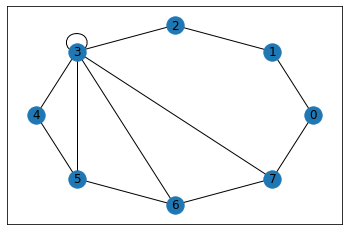

In [31]:
pos = nx.circular_layout(G)
nx.draw_networkx(G,pos=pos,with_labels=True)

In [13]:
print(maxAllowedEperNode)
print(calc_cost(G_sol,D))

5.0


NameError: name 'G_sol' is not defined